<a href="https://colab.research.google.com/github/khairul746/IDCamp-ML-Engineer-2024-Projects/blob/main/Analisis-Sentimen/Sentiment_Analysis_on_MyTelkomsel_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen pada Aplikasi My Telkomsel

## 1. Import Library dan Import Data

In [3]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.2 MB/s eta 0:00:00


In [4]:
import pandas as pd  # Pandas untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # Menonaktifkan peringatan chaining
import numpy as np  # NumPy untuk komputasi numerik
seed = 0
np.random.seed(seed)  # Mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # Matplotlib untuk visualisasi data
import seaborn as sns  # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
from sklearn.metrics import accuracy_score

import re  # Modul untuk bekerja dengan ekspresi reguler
import string  # Berisi konstanta string, seperti tanda baca
import unicodedata # Modul untuk bekerja dengan Unicode
import requests # Modul yang memungkinkan untuk mengirim htttp request
import os # Modul untuk pekerja terkait os seperti manajemen file

from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

from Sastrawi.Stemmer import StemmerFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  # Stemming (penghilangan imbuhan kata) dalam bahasa Indonesia
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # Menghapus kata-kata berhenti dalam bahasa Indonesia

from wordcloud import WordCloud  # Membuat visualisasi berbentuk awan kata (word cloud) dari teks

import nltk  # Import pustaka NLTK (Natural Language Toolkit).
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
nltk.download('punkt_tab') # Download the punkt_tab data package
pd.options.mode.copy_on_write = True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop, AdamW, Adam
from sklearn.model_selection import train_test_split

In [7]:
app_reviews_df = pd.read_csv('app_reviews.csv')

## 2. Dataset Overview

In [8]:
app_reviews_df.head(3)

reviewId         userName  \
0  bb582a94-9844-40aa-8c97-506e07c22fb7  Pengguna Google   
1  d8474dc1-da09-4605-9aab-de73f1d61dbe  Pengguna Google   
2  63dbc9c4-2da7-4825-b335-2a5a1e1575de  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  Jujur pake Shopee ini baguss banget sebenernya...      2             20   
1  Terus terang saya suka sekali belanja di shope...      3             17   
2  Aplikasinya bagus, mudah dipahami. Seeing bela...      5            309   

  reviewCreatedVersion                   at  \
0              3.42.24  2025-01-21 20:19:08   
1              3.42.24  2025-01-21 05:13:42   
2              3.42.24  2025-01-20 09:29:58   

                                        replyContent            repliedAt  \
0  Hai kak, mohon maaf atas ketidaknyamanan nya. ...  2025-01-21 21:18:24   
1                                                NaN                  NaN   
2  Hi kak, maaf ya udh buat kamu ga nyaman. Terka...  2023-02-07 16:24:08   

  appVersion  
0    3.42.24  
1    3.42.24  
2    3.42.24

In [9]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              3000 non-null   object
 1   userName              3000 non-null   object
 2   userImage             3000 non-null   object
 3   content               3000 non-null   object
 4   score                 3000 non-null   int64 
 5   thumbsUpCount         3000 non-null   int64 
 6   reviewCreatedVersion  3000 non-null   object
 7   at                    3000 non-null   object
 8   replyContent          2808 non-null   object
 9   repliedAt             2808 non-null   object
 10  appVersion            3000 non-null   object
dtypes: int64(2), object(9)
memory usage: 257.9+ KB


In [10]:
df = app_reviews_df[['content','score']]

In [11]:
# Mengecek data yang kosong atau hilang
df.isnull().sum()

content    0
score      0
dtype: int64

In [12]:
# Menghapus baris yang memiliki duplikat
df.drop_duplicates(inplace=True)

## 3. Text Preprocessing

In [13]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def remove_superscripts_and_subscripts(text):
    # memfilter karakter yang bukan superscript atau subscript
    def is_not_super_or_sub(char):
        # Cek kategori Unicode karakter
        return not (unicodedata.name(char, "").startswith("SUPERSCRIPT") or
                    unicodedata.name(char, "").startswith("SUBSCRIPT"))

    # Filter karakter dari teks
    text = ''.join(filter(is_not_super_or_sub, text))
    return text

def casefoldingText(text):
    # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text):
    # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text):
    # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata

    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [14]:
# URL file slang words
url = "https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt"

# Mengambil konten file dari URL
response = requests.get(url)
if response.status_code == 200:
    content = response.text
    # Memproses konten ke dalam dictionary
    slangwords = {}
    for line in content.strip().split(","):
        if ":" in line:
            key, value = line.split(":", 1)  # Memisahkan kata slang dan arti
            key = key.strip('{"}') # Menghilangkan tanda kurung kurawal pada key
            value = value.strip('{"}') # Menghilangkan tanda kurung kurawal pada value
            slangwords[key.strip(' "\'')] = value.strip(' "\'') # Menyimpan pasangan key-value pada dictionary slangwords
else:
    print(f"Gagal mengunduh file dari URL. Status code: {response.status_code}")


In [15]:
list(slangwords.items())[:5]

[('@', 'di'),
 ('abis', 'habis'),
 ('ad', 'ada'),
 ('adlh', 'adalah'),
 ('afaik', 'as far as i know')]

In [16]:
def fix_slangwords(text):
    # Memperbaiki kata-kata slang dalam teks
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [17]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText).apply(remove_superscripts_and_subscripts)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

In [18]:
df.head()

content  score  \
0  Jujur pake Shopee ini baguss banget sebenernya...      2   
1  Terus terang saya suka sekali belanja di shope...      3   
2  Aplikasinya bagus, mudah dipahami. Seeing bela...      5   
3  1. Pesanan cod roksaya dibatalkan sendiri oleh...      3   
4  Aplikasi elit benerin bug shopeepay sulit, tia...      2   

                                          text_clean  \
0  Jujur pake Shopee ini baguss banget sebenernya...   
1  Terus terang saya suka sekali belanja di shope...   
2  Aplikasinya bagus mudah dipahami Seeing belanj...   
3  Pesanan cod roksaya dibatalkan sendiri oleh si...   
4  Aplikasi elit benerin bug shopeepay sulit tiap...   

                                text_casefoldingText  \
0  jujur pake shopee ini baguss banget sebenernya...   
1  terus terang saya suka sekali belanja di shope...   
2  aplikasinya bagus mudah dipahami seeing belanj...   
3  pesanan cod roksaya dibatalkan sendiri oleh si...   
4  aplikasi elit benerin bug shopeepay sulit tiap...   

                                     text_slangwords  \
0  jujur pakai shopee ini baguss banget sebenerny...   
1  terus terang saya suka sekali belanja di shope...   
2  aplikasinya bagus mudah dipahami seeing belanj...   
3  pesanan cod roksaya dibatalkan sendiri oleh si...   
4  aplikasi elit benerin bug shopeepay sulit tiap...   

                                 text_tokenizingText  \
0  [jujur, pakai, shopee, ini, baguss, banget, se...   
1  [terus, terang, saya, suka, sekali, belanja, d...   
2  [aplikasinya, bagus, mudah, dipahami, seeing, ...   
3  [pesanan, cod, roksaya, dibatalkan, sendiri, o...   
4  [aplikasi, elit, benerin, bug, shopeepay, suli...   

                                       text_stopword  \
0  [jujur, pakai, shopee, baguss, banget, sebener...   
1  [terang, suka, belanja, shopee, kesini, shopee...   
2  [aplikasinya, bagus, mudah, dipahami, seeing, ...   
3  [pesanan, cod, roksaya, dibatalkan, sistem, me...   
4  [aplikasi, elit, benerin, bug, shopeepay, suli...   

                                          text_akhir  
0  jujur pakai shopee baguss banget sebenernya be...  
1  terang suka belanja shopee kesini shopee memba...  
2  aplikasinya bagus mudah dipahami seeing belanj...  
3  pesanan cod roksaya dibatalkan sistem melewati...  
4  aplikasi elit benerin bug shopeepay sulit upda...

## 4. Labeling Kata

In [25]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = "mdhugol/indonesia-bert-sentiment-classification"
# model = "indolem/indobert-base-uncased"

clf = AutoModelForSequenceClassification.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)

sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [26]:
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

pos_text = "Sangat bahagia hari ini"
neg_text = "Dasar anak sialan!! Kurang ajar!!"

result = sentiment_analysis(pos_text)
status = label_index[result[0]['label']]
score = result[0]['score']
print(f'Text: {pos_text} | Label : {status} ({score * 100:.3f}%)')

result = sentiment_analysis(neg_text)
status = label_index[result[0]['label']]
score = result[0]['score']
print(f'Text: {neg_text} | Label : {status} ({score * 100:.3f}%)')

Text: Sangat bahagia hari ini | Label : positive (99.481%)
Text: Dasar anak sialan!! Kurang ajar!! | Label : negative (99.828%)


In [27]:
def labeling(text):
    result = sentiment_analysis(text)
    return label_index[result[0]['label']]

In [28]:
from tqdm import tqdm
tqdm.pandas()

In [29]:
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
    if pd.isna(row.get("polarity")):  # Skip jika sudah ada nilai
        try:
            df.at[idx, "polarity"] = labeling(row["text_akhir"])
        except Exception as e:
            print(e)
            raise e

Processing Rows: 100%|██████████| 3000/3000 [00:30<00:00, 99.23it/s] 


In [30]:
df['polarity'].value_counts()

polarity
negative    1753
positive     639
neutral      608
Name: count, dtype: int64

## 5. Visualisasi Analisis Sentimen

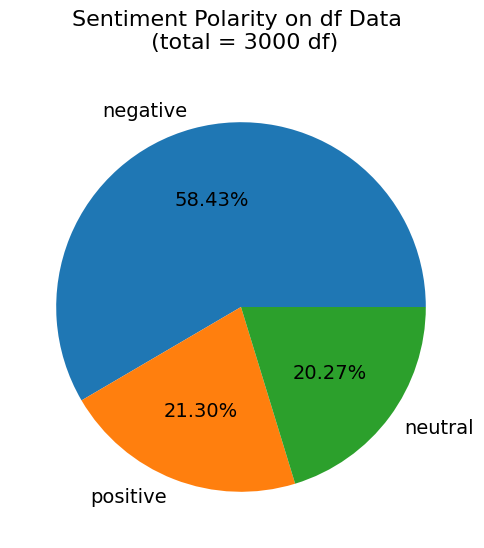

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df["polarity"].value_counts()]
labels = list(df["polarity"].value_counts().index)
explode = (0.1, 0, 0)
ax.pie(
    x=sizes,
    labels=labels,
    autopct="%1.2f%%",
    textprops={"fontsize": 14},
)
ax.set_title(f"Sentiment Polarity on df Data \n (total = {len(df)} df)", fontsize=16, pad=20)
plt.show()

In [34]:
positive_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'positive']
negative_reviews = df[['text_akhir','polarity']].loc[df['polarity'] == 'negative']

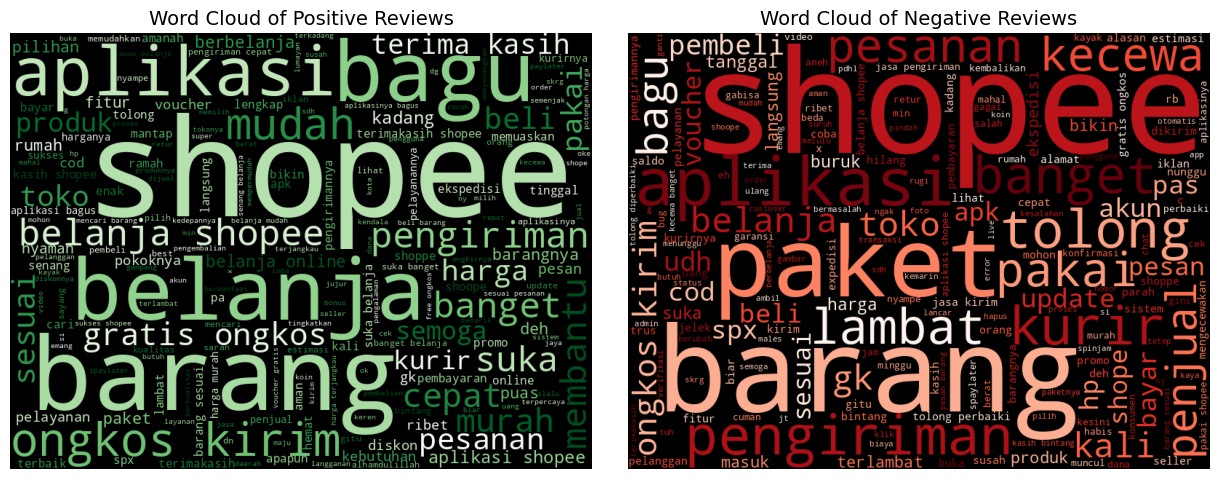

In [35]:
# Visualisasi Word Cloud
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Word Cloud pada review positif
list_postive_reviews = ""
for row_word in positive_reviews.iloc[:, 0]:
    list_postive_reviews += " " + (row_word)
wordcloud_positive = WordCloud(
    width=800, height=600, background_color="black", colormap="Greens", min_font_size=10
).generate(list_postive_reviews)
ax[0].set_title(
    "Word Cloud of Positive Reviews",
    fontsize=14,
)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis("off")

# Word Cloud pada review negatif
list_negative_reviews = ""
for row_word in negative_reviews.iloc[:, 0]:
    list_negative_reviews += " " + (row_word)
wordcloud_negative = WordCloud(
    width=800, height=600, background_color="black", colormap="Reds", min_font_size=10
).generate(list_negative_reviews)
ax[1].set_title(
    "Word Cloud of Negative Reviews",
    fontsize=14,
)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis("off")

plt.show()

## 6. Ekstraksi Fitur dan Membangun Model Klasifikasi

### 6.1 Membangun Arsitektur Model beserta Embedding

In [54]:
def makeReviewDict(series):
    # Membuat dictionary berisi kata dan frekuensinya dari suatu pandas Series.
    words = dict()
    for row in series:
        texts = row.split()
        for text in texts:
            if text not in words:
                words[text] = 1
            else:
                words[text] += 1
    return words, len(words)

In [56]:
# Hyperparameter
vocab_size = tokenizer.vocab_size  # Jumlah kata dalam vocab tokenizer
embedding_dim = 128  # Dimensi embedding yang akan digunakan
max_length = makeReviewDict(df['text_akhir'])[1]  # Panjang maksimum input sequence

# Model Klasifikasi
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  # Meratakan output embedding
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 6.2 Train Test Split

In [115]:
# Fungsi untuk mendapatkan indeks kata
def get_word_idx(text: str):
    return tokenizer(
        text, padding='max_length',
        truncation=True, max_length=100,
        return_tensors="tf")['input_ids']

In [106]:
# Fungsi untuk mengubah baris dengan nilai boolean menjadi biner
def convert_to_binary(row):
    result = []
    for value in row.values:
        result.append(1 if value else 0)
    return result

In [121]:
X = df['text_akhir'].apply(get_word_idx).tolist()
y = pd.get_dummies(df['polarity']).apply(convert_to_binary, axis=1).tolist()

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.3 Pelatihan Model

In [124]:
tf.keras.backend.clear_session()

In [119]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [126]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

ValueError: Unrecognized data type: x=[<tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7078, 10255,    57,   461, 30388,  1305,
          191, 11835,  5077, 24622,    27, 18102, 16119,  3656, 28152,
         5889,   191,   633,  2785,   963, 18102, 18102,  7078, 10255,
        12798,   456,  5992, 27157,   377,   189,    50,  2436, 16803,
        30354,  6325,  4270,  6012,  8161, 18102,  2608,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  6505,  2628, 16054,   310, 11780, 10792,
         1055,   684, 17299,   963,  5459,  3467,  2203,  2008, 14420,
         9550,  6505,  2628,  3196,  3866,   663,  1703, 14626,     5,
        10792,  1103,  1292,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  2628,  2573,   403,  5537,  1997,  4293,
         7649, 10220,  2971,   804,  1997,  4293,  7649, 10220,  2971,
         9681,    57,  2837,  9274,  5759,  2903, 12619,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   921,  2054,  6743,  2174, 21987,  6452,   216, 20538,
         3265,   921, 14993, 14993,  1110, 11504, 18102,  1605,  7216,
         3353, 22455,  3865,  2374, 20538,  3265,  1911,  2948,   818,
         7216,  4903,  3526, 28084, 18102,   626,  1052,  5526, 28084,
         3854,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4018,  6505,  2628,  7652,  9873,  4634,   280, 16201,
         3290,  6505,  2628,  9873,  5788,  9051,  4122,  3290,  7652,
         9873,  6505,  2628,   343,  2817, 27764,  5788,  8081, 15316,
         9873,  3290,  5060,  5006, 30357,  3290,  6505,  2628,  1243,
         7944,  2785, 12054,  8475,   280,  3747,  2354,  1162,  1629,
         1753,  7734,  3290, 26224,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  2109, 12065,  1604,  1998,  1262,  5485,  1110,
        14993, 20811,  5290,  1923,   963,  1110, 14993,  6244,  5290,
         1602,  1998, 17416,  5485,  8547,  3422,  5290,  5196,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  2631,  2631,  2354,  2733,  6703,  2692,  8794,
         2424,  1644, 28812,  6505,  2628, 28596,  9061,  8794,   786,
         4368,  6751,  2867,   377,  6858, 11158,  8794,   427, 12180,
          728,  1338, 11540,  8302, 23593,  1438,  5381, 28932,    57,
         7594,  2061,  5421,  2501,    32,  2631,  2354, 11540,  8794,
         8302,    57,  8794,   804,  8302,    57,   377,  3703,  1338,
        11540,  4755,  6505,  2628, 28596,   975, 13482, 12906,   106,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163,   699, 21517,  6012, 10692,  4398,  3401,   727,
         4398, 24265,   483, 29807,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28148, 27635,  2174, 15917,  1339, 28148,  3440,  1262,
        28148,  2867,  3665,  2428,   988,  4221,  3266,  8353, 15971,
         1396,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431,  2174,  6538,  1339,  6587,  6505,  2628,  2983,
         1008,  1492, 28836,  6805,   927, 10294,  4173,   548, 30366,
        10737,  7649, 10220,  2971,  1110,    42,  3954,    65,  2419,
        10785,     5,  7216,  7038, 17119, 28836,  7089,  4061,   174,
         6447,     7,   726,  7808,     5,  2419, 10785,     5,  7649,
        10220,  2971,  5985, 30361,  2641,   457, 27273,   233,  7216,
         2108,  5759,  2468,  6505,  2628, 15215,  4595,  5759,    17,
        10737,  1299, 30369, 11682,  2174,  1339,  7356, 12040, 30366,
         5120,  2641,  5035, 30369,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  2174,  3866,  6505,  2628,  4525, 10692,   786,
         2054,  3703, 13273,    44,  5759,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  1103,  1305, 25013,  1605, 23849,  6505,  2628,
         5053,  8521,    32,  7667,  9334, 11669,  5005,  2780,  3308,
        12267,  9281,  1605, 23849,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 10661, 15971,  1339,  6505,  2628, 24319, 15211,
         7412, 15257,  2681,   553,  5261,  1332,  3108,  1339,  6505,
         2628, 15211,  7412,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1305, 29744, 13002, 14061,    59,  1998, 29744,
        12470,  1911,  2948,  2535,  9949, 29744, 10072,   963,  4762,
         2174, 11565,  1998, 10072,   786,  2687,    17,  4104,  7894,
         5290,  5290,  8055,  6743,  2203,  1605,  1736,  3448, 10072,
         1911,  2948,  7175,  6596,  4104,  1869, 13921,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4172,   505, 13863, 15078, 22891,  2692,
          794,   603,    17,  5769,  1998,  7038,  1788,  3448,  1998,
        10692,  4104,   963, 18102,  1122,  8198,  1320,  8204,  3866,
         6505,  2628,  6408,  3854, 12470,  9072,  3511,    57,   985,
        30354, 13169,  2174,  2911,  1998,    83, 16888, 11008,  7004,
         3132,  1339,  6505,  2628, 18602,  3294,   301,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3067,    32, 14891,  1305,  2174,  6218,    88, 14891,
         7649, 10220,  2971,  7038,  5759,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1173,  1505,   405,  1103,  6505,  2628,  6158, 30359,
         2174, 30358,  5345,  6505,  2628,   271, 30361,  2174,  4073,
         4525,   405,  1103,   271, 30361,  2174, 18201,   288,  1305,
         2983, 30369,  1339,  6505,  2628,  3196,  3866,   405,  5991,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   921,  1384, 13977,  1339,  6505,  4264, 20653, 30363,
         6505,  2628, 21111, 30355,   255,  4866, 30366, 15516,  6505,
         2628,  3297, 21111, 30355,   255,  4866, 30366,  1605,  4364,
        13891, 18568,  6505,  2628,  1055, 15516,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25010,   633,  6743,  6505,  2628,  1780,  1753,  2608,
         3472,  1416,  3511,  3196, 18599,  3196,  3426,   461, 30388,
         1416,  3511,  8576, 24481, 24481, 24481, 12065,  1506, 13856,
          950, 11489,   265,  2420,  3511,   963, 21475,  5290,  2631,
         2733,  1416,  3511,  1605, 12065,  7356,  1080, 10626, 30366,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  3125, 30361,  4763,  6505,  2628,  6012,  2699,
        17045,   905,  6012,  7038,   786,  1110, 14993,  6743,   921,
        28812,  1998,  7038,  1110,  9101,  3854,  2315,  4763,  6505,
         2628,  3511, 19398,    72, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  1629,  6505,  2628,   963,   786,  6012, 15704,
          497,  8989,  5307,    57,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  5998,   157, 14288,   204,  7767,  1246,  1605,
         4104,  5897, 17488, 11835,   963,  1605,  8883, 10985,     5,
        21292,  3807, 30057,    51,  3656,  6140,  7154,   988, 10692,
        22523,  1605,  2818, 23315,  2229, 30357, 20105, 19278,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1243,  7944,  2785,  3511,  8816,    15,   486, 15945,
         1753,   342, 16225, 12429, 13584,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  3000,   461, 30388,   794,
        18102,  6012,   794,  2468, 12065,  3161,   972, 18102,  7021,
         6012,  1103,  2179,  7944,  2785,  5788,   461, 30388, 18102,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857, 16727,  1339,  5163,  2775,  2056,  4398,   405,
         3665, 10705, 30361,  2352, 13040,  2010,  2010, 29664,  3297,
         4040,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  6012, 15237,  2810,  4775,  7199, 30358,  2054,
         3511,    57,  2174,  5163,  2174, 14993,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963, 18102, 13366,  1339,  8668,  6012,  2424,  1730,
         3854,  4657,  7727,  1752, 12065,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 27906,   191, 28144,  2468,  1339,  3866, 25862,   233,
         5000,   166, 25538, 30361,  6825,  6612,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5163,  2174,  1243,  7944,  2785,  3684,
         3511,  4525,  4525,  9596, 28596,   636, 30361,  2913,  8302,
         5035,  3866,   941,   941,  4942, 16127,   405,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6825,  2468,   633,  2468,  3208,    17,  1109,  6505,
         2628,  6825,  3588, 12889,  3852, 26664,     7,  4266,  1055,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4760,  3866,   663, 18855,  1605,    57,
        10651,  6751,  4266,  4595,  3866,   663,   783,  5289,  6505,
        26776,  8839,  7424,  7424,  5196,  6505,  2628,  1671,  2152,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  1357,  3188,  2170,  2332,  6505, 30357,   403,
         4665,  2778,  3188,  6244,  1262,   280,  3121,  6505,  2628,
         6185,    57,  6764,  1733,  4525,  3854, 10661,  3121,  1339,
        28254,  4980,   728,  6764,  1733,  1396,  2109,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508, 24621,  9873, 28836,  1110, 10018,  4525,  5853,
          405,  5888,  6764,  5853,   405,  9656,  1110, 10018,  7944,
         2785,   600,  3666,  1162,  5883,  1629,  8221,    17,  6771,
        14891,  3161,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,  6505,  2628, 29190, 13520,  3511, 10759,  3397,
         3852, 11239,    17,  6505,  2628,  3854,  1338, 10759, 12065,
           57,  3511,  3308,  3852,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  3440,  2911,  4946, 22974,  1320,   963,
          157,     7, 11540,  2911,  4946, 22974,  3684,  1320,  3016,
         3975,  1846,  3440,  2999,  3684,  1997,   522,  5184,  4789,
           57,  8302, 12180,  4073, 13684, 20555,  4879,  8668,  3975,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3163, 15030,  2805,  1339, 16538,    27,  4292,    71,
        10737, 21292, 30356,  1110,  2713,  6505,  2628, 13659,  8761,
         1633,  1633,  8055, 21292, 30356,  2826,  3178,  5516,  3903,
           74, 15372, 23525,  1339,  6505,  2628,  2403,  2149,     7,
        29206,  7038,  3574, 15561, 10782,  3648,   349, 10705, 11218,
         5381,  6746,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4314,  3186,  2174,  3121, 14891,  3756,   476,  1168,
        27943, 16484,  1730,   728,  3121, 14891,  6505,  2628,  5542,
        16484,  9766,  3121,  1105,  6722,  3153,   503,  9766,  3121,
        14891,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6698,  7250,   356,  8725,  7078, 10255,   424,   608,
          255,  2462,   510,   461, 30388,  1506,  2536,   530,     9,
          497,  2516,   959,  7078, 10255,   424,   608,   255,  5163,
         2468, 11501,  4810, 16488,  1671,  5256, 24826, 30357,  1788,
         1338,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19742,   491,   356, 30356,   405,  2276,  2276,  7944,
         2785,  3854,  7773, 30355, 11599,   265,  7944,  2785,   405,
          786,   963, 13872, 30355,  1321,  4549,    37,  1321,  3854,
         7994,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7089,  1998,  2785,  1953,  2229, 30361,  5985, 30361,
         5985, 30361,   402, 30369,  2785,  8198,  5290,  3127,  2420,
         8195,     5,  5839, 12065, 21968,  7154, 10759,  3854,   358,
         3726,  3511,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   176,    17,  1288, 12065, 11475,  1953,  3339,
        18973,   530,     5,  1998, 14993,  1110, 16888,  1110,  1110,
         1953,  1643,  6505,  2628, 28698, 13293,  8081,  4018, 12065,
           57, 21347,  7556,   423,  5421, 15431,  3866,  6505,  2628,
         8081, 23103,  1110,   963,  2054,   728,  6864,  9951,   280,
         1110,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2028, 13534,  1338,  1339,  6505,  3265,  3188,  5742,
         3188,  1671,  1339, 15406,   232,  1339,  5189,  6881,  3274,
        20233,   300,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   461, 30388,  3511,  3655,  1416,  3511, 15799,
         1998, 16888, 27157,  3422, 16888, 12065, 16888,    57,  5682,
         3016, 16888,  1998,  3188,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,   584,  4195,  1294, 22809,  5722,  2761, 14886,
         6505,  2628, 12059, 12065,    57,  4782,  5299,  3503,  6186,
          289,  2593,  1080, 30355, 10435,  4749,  6012,  1788,  1338,
          494, 26250,    27,  6505,  2628,  1605, 12065,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  2903, 12510, 15971,  3597, 11202, 15971,
         6012,  7154,  3597,  7038,  3756,   476,  8784,     7,  5290,
         6012,  7154,  8784,     7, 11503, 12085,  5290,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2913,  4663,   963,   786,  3703, 11757, 19112,  2942,
          342, 22523, 30356,  3866, 22683, 10778, 30357,  1671,  6505,
         2628,  1605, 10651, 13276,   978,  4958,  5957,  4037,   298,
         2692,   572,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  1753,  5516,  6505,  2628,  9857, 29744,   633,
        19642,    32,  3196,  3089,  2999, 11032,  3511,   963, 12434,
         5163,  1383, 30358,  1452, 23338, 14813, 16357,  3511,  6505,
         2628,  4625,  5928,  2608,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065, 30359,  3089, 10651,  2203,  5133, 13131,  2913,
         4122,   405,  1998,   216,    17,  4128, 12654,   786,  2108,
         1339,  3854,   358,  3726, 30355, 12065,  9596, 10778,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  3213,  3125, 30361, 23576,  6505,  2628,
          986,  7424, 14904,   986,  1243,  9999,    57, 16325,  3684,
        29767,  4846, 18802,  4250,   394,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   921,  6012, 11239,    32,  3648,  2468,  1416,  2785,
          461, 30388,  6550,  3448,  3511, 16888,    32,  7894,   683,
        12065, 16581,  2352, 16888,    32,  2420,  5839, 27257, 17439,
         6948, 30360,  4063,  2468,  2873,  3511,  1953,   232,   448,
         1998,  8055,  3016,  3854,  7517,  9149,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1515,   497,  1292,  3511,   972,  3854, 14165, 15971,
         5163, 26244,  9797,  6067,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628, 20270, 30361,  3121,  1153,   971,
          834, 12477,  9149, 13644,  9365,  4398, 11028,  9577,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  1339,  6505,  2628,   783,  3393,   491, 14655,
         1320, 22683, 10778, 15049,   963,  1234, 24134,  3597,   427,
         2785,  4104,  2458, 30354,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  2174,  1506, 28052,  4122,  6743,
           57,  2641,  9548, 30355,  2468,  2641,  6505,  2628,  2403,
         2149,     7,   636, 30361,  2468,   636, 30361,   530,     9,
        13131, 13131,  1173,  5433,  5526,   636, 30361,   530,     9,
          185,    16, 14031,    32,  2641, 22683, 10778, 30357, 28052,
         5526,  6907,    27,  2903, 10661, 30355,  3308,   636, 30361,
         9558,   636, 30361, 28052,  1788,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3242,  4869,  1305,  1339,  8725,  6578, 28764,  5888,
         6764,  5990,    57,   959, 12470, 18693, 30360,   795,  1671,
         4073, 22049,  1553, 15076,  5091,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  6505,  3265,  5210,  1339,  6505,  3265,  3854,
         4657, 12065, 11475,  1998,  3994,  6949,  3366,  8195,     5,
          582,  1240,  1998,  2054,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2165,  1506, 21111, 30355,   255,  6505,  2628,  6026,
           22,   801,  2692, 30388,  7944,  2785,  4942,  1103, 12434,
        26252, 16400, 29744,   633,  2108, 22639,   801,  2692,    57,
         7216, 18102,  2867,   127,   263,  8637,     5, 16850,  5184,
         7882,  4968, 26252, 16400, 13131,  6052,  6392,   801,  2692,
        20811,  4104, 28909,   461, 30388,  9901,  1008,  3511,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857,  6505,  2628, 15215,  9681,  6505,  2628, 15215,
        15438,   405,   497,  4222,  1162,  7944,  2785,  9351,  9873,
         1243,  7944,  2785, 13040,  6505,  2628,  2405,  1243, 11328,
        29398,  9681,  7649, 30371,  2453,  1486,  3308,  1869, 22256,
         6858,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783, 23576,  6505,  2628, 13276,   978,  3703, 18855,
          783, 23576,   972,  3067,    61,  3684,  3866, 11114,  3866,
         3866,  3866,  6505,  2628,  2641,    57, 11114, 11565,  5035,
         3866,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,   963,  6505,  2628,  8676, 13440, 27498, 24260,
         1049,  8725,  3391,  3121,  1339,  3597,  5163,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382,  3866,  6505,  2628,  1629,  1416,  2785,  6949,
        14993, 17962,  2655, 16119,   972, 11210,  5063,  6012, 10497,
        14382,  2054,   963,  1788,  6012, 14993,    57,  2713,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2116, 24733,  6505,  2628, 13659,  6678,  2020,  1841,
         1915,  6612,  5000,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2174,  3866,   963,  1182,   219, 30354,
         6505,  2628,   176,    17,  2631,  6852,  5156,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1055,   842, 15332,  2203,  1055,
         7047,  1426, 13021,  7606,  1375,  3121,  6505,  2628,  2512,
          955,   963,  4120,   558,  1108,  1338,  6505,  2628,   842,
        12786,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  7424,  3511, 16119, 26844,  3511,   963,  1736,
        11390,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  3511, 12065, 13440,  2468,  6505,  2628,
         6743,    17, 12470,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   775,  3107,  2174, 14718,   255,  6505,  2628,  3511,
          972,  4073,  2631, 25338,  3551,  4634, 28836,  1455,  1998,
          424, 29613, 26326, 30356, 13131, 14718,   255,  1605, 17457,
         7396,   149, 18102,  1954,  9318,    19,  1998,     5,  2775,
         2056, 12065, 14492,  1263, 30355, 20385, 30358,  7606,  2174,
         4080,   963,  3125,    57,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,   783,  3866,   663,  8713,  1671,  2152,  6505,
         2628,  7174,    57,  9681, 10705,  6359,    63,  3866,     5,
         2468,  1129, 10778,   149,   138,  8168, 17887,  3866,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4942, 14891,  1305,  1173,  2733,    57,  3150,  1605,
         3158,  7424,  8989,  1997,  4203,  1103,  3911,  7944,  2785,
         2631, 11114,  3158, 22324,    57,  7424,  1966, 30369,  4079,
        17005,  1605,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505,  2628, 12214, 28544,   720,  3866,   663,
         7174,  1506,  2468,  1339,  6505,  2628,  3158,  1998,  6226,
        11705,  1506,  1339,  6505,  2628, 11565, 11114,  4525,  4073,
         8676,  6505,  2628,  5900,  2152,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  2468,  1339,  9596, 10778,   405,  4942,  5189,
         8725,  3386,  2857,  9206,  4017,  4222,    17,  1339,  5788,
        29152,   138,  1869, 10301, 10706,    27,  1452, 23338,  6505,
         1515, 14975,  9206,  4017,  4122,  9596, 10778,  2403,  1671,
         4398,  6563,  1339,  9206,  4017,  9596, 10778,  3308,  5759,
           57,  7216,  9596, 10778,  2403,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 23918,    32,  3866,  6505,  2628,  1556, 16119,  1305,
         1893,  1371,  1103,  4660, 12365,  6505,  2628,   963,  6291,
         1103, 20814,  7973, 30359,  2999,  7373,  3866,   988,  2246,
         8676,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4018,   405,  1103,   231,   405,  5107,  4919,  2276,
        11236,  1614,  5184,  4128, 16488,  1841,  3866,  6523, 30366,
        26025,  1067, 19410, 13495,  4456,  1103,  3866,  1703,  2825,
         8161,   963, 21870, 30355, 18102,  5421,  3866,  6505,  2628,
         7004,  4810,  8515,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12065,   461, 30388,  2172,  6402, 30360,  4667,
           77, 30355, 12510,   504, 13935, 12065,   963,   494,  2946,
         1110,  1110,  3401,  1293, 30360,  1953,  1052, 15431,   540,
          255,  6505,  2628,   494, 12065,   461, 30388,  9036, 11114,
         3597, 22829,  6592,   795,   200,  1790,   210,   539, 12065,
          461, 30388,    98, 30355,  6505,  2628, 13043, 14665,   255,
          185, 17488, 30365,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 15971,  1506, 28148,   494,  1441,  1505,  6505,
         2628,  4212,  7038,  9520,  1441,  1339,  3987,  4308,   861,
         2999,  1505,  6505,  2628, 18228,  1300,   868,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   384,  2060,  6505,  2628,  3606,  2514, 30355,  1998,
        10539,  3597, 18102,  1000,   435,  2054,  1110,  2054,  1110,
        23452, 18102,  6505,  2628,  8366,    16,  2903, 12510,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2313,   373, 10742,  3807,  6505,  2628,  9681,    83,
          804,  8883,  6873,   988, 11682,  6569,  5516,    57, 16073,
           57, 15927,  2775,  2056,  2857,  4843,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  3265,  4104,  4104,  3025,   963,   963,
         5587,   974, 11875,   633,  5210,  9733, 30368, 30365, 13044,
           57,  1072, 13013,   963,  6483, 16394,   405,   963,  6483,
         3158,  1116, 23017,  8052, 23826, 10484,   804,  4894,   356,
         4104,  2054,  6764,   963,  2170,  6483,  8064,  5290,  5587,
          497,  4385,   636, 30361,  4511,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25967,  1305,  4438,  3265,   747, 25013, 30355,  3511,
           57,  5163, 27053,    84,  5447,  2655,    17, 16407,   786,
          561,     5,  5163,  2174, 16119,  2655,    17,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4151,  3597,  6524,  7154,  8668,  1320,  6505,
         2628, 28596,  2468,  6505,  2628, 17671,  8794,    57, 23177,
         7849,  2867,  6012,  2536,  2174,  3854, 10661,  8081,  7944,
         2785,  6505,  2628, 28596,  3303,  7154,    57,  8668,  1788,
         2054, 12065, 21347,  7556,   958,     5,  1105, 12065, 17966,
          369, 24418, 30355, 11540,  2983,  6353,    91,  1339,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1506,  1055,  2512, 11551,  3297,  2174,  3000,
         2054,  6505,  2628,  5227,  4128,  4942, 28106,  2031, 23309,
         4660,  1506,  3047,  6668,  2874,  1107,  4055,   121,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2382,   963, 26664,     7,  4692,   988,
        30057,  6538,  6505,  2628,  2403,  2790, 11114,  4895, 30057,
          963,  3656,  1055,  3235,   457, 16627,  6505,  2628, 12398,
        17119, 23826,  6505,  2628,  1243,  7944,  2785,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  3511, 13863, 30360,  7038, 25381,  9456,
         5163,  1998,  2867,   988,  2655,   963,  1320,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1105,  2273,  1492,  1492,  1371,  1320,  2201,
        20351, 30358,  1371,  5968,  1371,  3854, 21135,   762,  1371,
        13490, 30354,  2776, 30354,  7074,  8571,  2468,  2109,  2641,
         3189,  1305,  6463,  1890,  1605,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11540,  2632,  9596, 10778,  6379,  7078, 10255, 15799,
         1519,  7078,  1854,  1980,   963,  9825,    20,  3540,  1954,
          633,  7078, 10255,   963,  8576,   963, 13045,    57, 12065,
        10852,  1998,  1953,  1052, 19991,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,   511,  6505,  2628, 12065,  3511,  2054,  1110,
         2938,  1110,  2713,  1998,  3656,  3854,  6505,  2628,  3511,
        19542,   972,  2733,  3150,  1788,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,   369,  4454,  2631, 26473,  1667,   963, 26473,
         1667,   963,  6743,  3189,   405, 10368,   786,  1153,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866, 22683, 10778, 30357,  1734,  1243, 11328,
         9334,  5769,  3450,  3386, 18091,  1736,  5769,  2776, 30354,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1055,  2155,  1255, 21093, 30355,  6371, 13058,
         2906,   405, 16119,  1292,  2857,  1375, 17693, 11114, 19753,
         1485,  3807,  1117,  6505, 30371,  2403,   963,  1788,   786,
         6012, 10651,  5493,  4840,  2468,  4763,  6505, 30371,  3866,
         1103,   783,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2983,  5900,  3511,  5163,  9932,  3316, 12489, 11565,
         2913,  1339,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  1198,  5991, 15059,  3310,  2293,
        10270, 18389,   405,  5029,  3597,  2352,  3747,  6642,  6505,
         2628, 15540,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1339, 3866,  663, 1305, 5722, 9873, 1243, 7944, 2785, 5666,
         448, 5210, 1255, 6505, 2628, 2999, 4771, 1788, 1338, 6505, 2628,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1614,  8754,  3866,  6505,  2628,  4104,  6424,  3150,
         1605,  1305,  4313,    55,  3150,  3684,  5380,  4104, 10651,
        19893,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 4763, 6505, 2628, 1055, 5210, 2903, 4162, 2631, 3189, 2631,
        3189, 5485, 1899, 1899, 1105,  963, 3221, 4763, 3161,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   658,   532,  5901,  1173,  1153,   497,  6505,  3265,
         3125, 30361,  1998,  1006,  3125, 30361,  6007,  1072,  9816,
         3854,  2300,    27,  6505,  3265, 20844,  4771,  6505,    55,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4068, 14636,  4068, 12054, 14813,  1305,  2179,  4068,
        14636,  8168, 19361,  4068, 14636, 12054,  9548,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  4438,  2628,   921,  3866, 25603,  2054,  3243,
          786,  1243,  7944,  2785,  1671,  8789,  4438,  2628,  1629,
          842,  2516,  4525,  9525, 27940,    27,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971, 10661,   459, 26856, 26856,   794,  1564, 30358,
         4122, 25843,  7190,     5,   794,   346, 22451,    57,  4843,
         5788,  1339,  3161,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  3266,  1151,  5360, 28836,  1246,  1416,
         2785,  1416,  2785,  2933,  1583,  3191,   461, 30388, 20965,
        30362,   461, 30388,  2063,  3854, 10661,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 17976,  8213, 15929, 26994, 25615,  2428,  1687,
        12054,   443,   433,  2903,  9149,  5711,  4843,  1339,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628, 11565,   795, 11105, 13374,
         3866,  1375,  2054,   448,  1375,  4034, 16119,  1809,  2054,
         2512,  2721,  1556,  2983,  6505,  2628,  4073,    57,  3000,
         2983,  1788,  1338,  6505,  2628,  2152, 10651,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2632,   737,  7652,  3985,  3295,  3511,   963,  2739,
        13815,  7280, 11681,   118,  3985,  3295,  3511,   963,  3985,
         3295, 14373,  3330,  3655,  5260,  7893, 16119, 28052,   395,
         4349,  1012,   118, 20385,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13895,   389,  6505,  2628,   280,  3747,  2468,  6505,
         2628,  2403,  9681, 10049,  1175,  3108,  1162,  2071,  2405,
        10049,  2946,  9681,  1980,  1492,  2727,  9681,  6505,  2628,
         2403,  1643, 10968,  3526,  2174,  9681, 22256,  5590,  2276,
          239,  5913,  9681,    57, 22523, 15431,  2468,  6505,  2628,
         2403,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  1416,  2785,    57,  8828,  1288,  8794,
          636,  1011,  1998,  2229,    94,  1052,  5526,  2873,  6325,
         1072, 16119,   356,  6325,  2913,  8081,  7571,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1055,  2174,  2647,     7,  1605,  9550, 16119,
        24216,   790,  2523,  8213,  1046,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  5360, 10072, 16100,   721,  2243,   963,
          786,  9034,  5381, 17005,   304,  5563, 30360,  2243,  5500,
         3328,   721,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 13863,  9521,  2453,  3526,  4059,  9681,  6505,
         2628, 15215, 27755,  1339,  2897,  4266,  7152,  2332,   189,
           50,  1998, 18102,  6907,  2993,  5133,  1998,  1103,  1841,
         2116, 30369,  5788,  1320,  2109,  2867,  4762,   137,  7855,
        14547,  8676,  6505,  2628, 13863,  1268,  1268,  2116, 30369,
         3866,   663,  6505, 30357,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  4293,  3588,  8828,  4068, 10759,   232,  3096,
        20545,  3526,  4068,  1129, 11663,  7571,  4293,   804,  6743,
        24553,  5815, 10759,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  2138,  3511,  5309, 15401,  6538,  7078, 10255,
          356,   972, 15194,  1320,   963,  2468,  3511,  1243,  7944,
         2785,  4810, 24325,  6505,  2628,  3958, 21452,  1416,  3511,
           57, 13584,  2063,   505, 30361,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505,  2628,  1055,  1375, 10016,  3866,  1255,
          626,  6520, 20490,  6505,  2628,  2152,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   494, 12964, 13632,  3121,  1605,  6505, 26831, 16696,
        28812,   804, 26903,   291,  4219,   212,  2984, 15951,  1998,
        28812,   191,  2424,  3290,  2785,  5892, 16331, 30356,  3290,
         4305,  1367,  6398,  1821,   494,  6822, 30354, 28812,   423,
        12154,    55,   212, 15951,  8571,  1489, 13152,  5381,  4090,
        15272,  1998,  2785,  8277,  2174,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,   963,   493,    57,  1736,  4762,  9596, 10778,
         2632,  9596, 10778,  2054,   963,  5163,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 10651,  3866,  6505,  2628, 16368,   209,  8212,
         1478,    32,   728,   712, 12065,   636,  1011,  2487, 14993,
         3598, 16028,  3188,  6401,   633, 11835,    17,  1998,  3598,
        15566, 12065, 13131,   801, 16561,   189,  1345,   729, 30355,
        10094,   636,  1011,  1998,   794,  6557, 30374,   712,   636,
         1011,  7373,  1659, 30356,  3017, 10901,  2608,   231,  1107,
          764,   208, 20602,   786,  3188,  1589, 18436,   728,  3150,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628,   525,   333,  2501,  1505,  2769,
         8621, 12856,  1110, 10018,  1162,  3303, 29181,  6505,  2628,
          280,  1110, 10018,  3866,  3308,  1103, 11648,   280,  1110,
        10018, 12180,  2174,  9873,    57,  5372,   799, 15431,  2174,
        26163,    63,  7882,  1505,  9873,  3308,  5290, 12721,  3866,
         6505,  2628,   775,  9661,  2174,  6505,  2628,  9873, 28836,
         9109, 24621,  2174, 14886,  6743,  6505,  2628, 28836,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508,  8302,  2174,  1320,   963,  8189,
         8611, 10734,  3656,  3703,  5500,  7021,   427,  1605,    57,
         8794, 17332,  7571,   486,  5421,   988,  7021,  3648,  3131,
           28,   963,  2468,  4900,  1062,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  6505,  2628,  3854,  4398,  8540,  9642,  9131,
         9642,  2009,  5007,  1154,  7216,  8540,  2468,  9642,  2009,
         5007,  1154,  6505,  2628, 27995,  1340,  7216,  2983, 10384,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3511,  7994,  2796,  4416, 25527, 12434, 12434,
         3511,   963,  5163,   959, 12065,  7944,  2785,  3303,  2174,
         1408,  2276,  4762,  1719,    15,  2054,   963,  4587,    51,
         1103,  1396,  7944,  2785,  2276,  5590, 12423,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   699,  9932,   963,  4990,    47, 16323, 12742,
         5290,  3353,  5883,  2632, 25083,  6505,  2628, 19784, 16660,
         5819,  2913,  4122,   562,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,    57, 17616,  4762,  2174,   461, 30388,  5163,
         6433,  5163,  2012,  6433,  1110,  3511,    57,  4903,   626,
         1052, 11328,    57,  3303,  9873,  4073, 24621,  1110, 10018,
         8213,  1046,  1162,  5453,  3303,  4266, 14993,  3511,  4618,
          337,  4762,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  2632,  3854, 11114,  5759,  4241,  3807,  2512,
         7272, 22891,  2692, 22891,  2692,  5759,  5163,  5163,  3854,
        12065, 29020, 15965,  6509,    59,  4755, 13440,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   268,  4864,  8419,  2631,  1418, 30360,  6764,  1733,
        16745,  6505,  2628, 14651,    57,   728,  3648,  3121,  6764,
         1733,  1528, 30354,  2174, 27635, 15516,  4293,  1006,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  2174,  6505,  2628,  6052,   637, 12470,  8852,
        12470,   461, 30388,  2913, 25192, 21636,  5163,   636,  1011,
         1998,  2913, 29929,  2170, 15431,  2174,  2468,  1339,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 4416, 6505, 2628, 3067, 6743, 2174, 9681,  461, 1619,    7,
        1320, 5759,   57, 5759, 6743, 2174, 5035, 4580,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3684,  2174, 21347,  7556,   268, 21133, 16715,  6237,
         5983,  6505,  2628,  8964,  7154,  4521, 12065,   461, 30388,
          461, 30388, 21086,   194, 16490, 29927,  1288,  2897, 22295,
        15372,  3854, 29020,  6505,  2628, 17808,  2064, 23512, 20539,
           17,   963,  3386,   457,  2468, 12065,   461, 30388,  3684,
         2174, 29509, 20932,  1103, 12054,   356,   461, 30388,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  1339,    92,  7666,  2857,  2837,    57,  3997,
         3386,  8989, 23895, 30172,  9281,  4104, 10651,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12470,  5163, 12214,  6452,   963,  3656,  4398,  3511,
          963,  2535,   684,  5191,  1957,  6012, 21987,  1110,  4398,
         1954, 21111, 21111, 30354,  3987,  6881,  3511,   461, 30388,
         3308,  2608, 17693, 12470,   842, 20569, 18278,    17,  2810,
           94,   461, 30388,  3483,  7739, 12470,  1753,  2632,  3566,
        16854,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  5722,  5152, 12604,  1288, 12065,  8195,
            5, 26664,     7,   783,  1785,  8595, 12065,  3511,  1899,
         1785,  8595, 12065,  1998,  3656,  5196,  1671,  4398,  2631,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1338,   405,  1103,  1243,  7944,  2785,
          963, 11239,    17,  7078, 10255,  1173,  1186,  1350,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1998,  4399,  9273, 12065,   461, 30388, 11394,  2468,
         1700,  3511, 17671,  9932,  1869,   593,  3556,  5163,   921,
          727,  4398,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305, 20922,  7649, 10220,  2971, 17887,
          921,  2514,  6229, 20922,   633, 13820,  6227, 12548,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497, 13169,    17,  6751, 22680,  1730, 13017,  7767,
          280,  1320,  8049,  2352, 24907,  1730,  2468,  7835, 13169,
         6751,   582, 12648,  6751, 11682, 15237,  1105,   497,  1103,
         3854,   391,    87, 30359,   423, 15049,  3553,  1338,   804,
         6505,  2628,  8811,  2655,   963,  1103,   963, 11537,   189,
           50,  8881, 10938,  5038, 30361,   497,  5575, 17585,  4102,
         2468, 18334, 30356,  6751,  1371,  2273,  1559,  8811,  1173,
         1305,  1371,  7495,  6174,   280, 13159,  2692, 23970,  3364,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5722,  2468,  6505,  2628,   550, 30369,  5886,   284,
           32,  1866, 28062,  4104, 10861,  6012,  3656,   427, 10072,
        17567,  6600,   963,  5133,  2873,  7517,  6505,  2628,  1869,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971,  1489, 10408, 16201,  1868, 10214,
        23832,   263, 12172, 19176, 29321,  1738, 17887,  2825, 30355,
         5687,   292, 12054,  8415,  4349, 18161,   133, 30369,  4755,
          963, 19132,  9379, 30369, 16086,   102,   580,   626,  2229,
        30357,   395,  5649,  1998,  1107, 15215,    21, 30368,  2334,
        30355, 14891,  3161,   972,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2641, 19784,  2204,  5997,  5196,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  3854,  4561,  3511,    57,
        12065, 15312,  9045,    50,  6419,  7606, 14492,   175,   963,
          494,  7078, 10255,   963, 11092, 15625,  7894,  6743,  2174,
         8676,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15316, 17005,  3747,  2419, 10785,     5,  1103, 27053,
        30358, 14252,  4071, 11395,  8293,  8189, 11648,  1786,    17,
        11395,  8293,  8189,   794,  4525,  5853,  4587, 30365,   794,
         2867,  2174,  9873,  5769,   280,  3747,  9873,   794,    83,
         4385, 14026,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20226,  6505,  2628,  3597,  1375,  1351,  2203,  4900,
         2655,  3684,  2012,  2468,  6505,  2628,  1282,   332, 16119,
         1320,  6505,  2628,  1103,  4073, 13553, 16119,  2170,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  8222,  2628,  8055, 14802, 11114,  4162,
         2109,  5152,   815, 15019,  5342, 12065,   626, 10970, 11475,
        14130,  4001, 17510,   728,   804,  2485, 23651,  2759, 18900,
        19648,  4710,     5,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  1416,  3511,   959,  2796,  5658, 30355,  6743,
         3511,  6505,  3265, 11394,  1998,   626,  1052,  3422,  6226,
         1998,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,  5163,  2109,  4942,  1795,     5,  3866,
         3158,  1339, 25589, 22049,  7250,  4812,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 15372,  2054,   963,  2054,   963,  1339,
         9681,  1869,   728,  2867,  1633,  2857,  3108,  6505,  2628,
         6066,  8881,  6505,  2628, 15372,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1055,   405,  1103,  3854,  4104, 10651,  2903,
         4683,  2641,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737, 11114, 21338,  3511,  3588, 11817,  6012,  2776,
        30369,  1696,   755,   847,  6012,  7078,  1375,  4634,  9121,
           17,  4104,  2776, 30369,   921,  9121,    17,  4104, 11114,
         4683, 10835,  3196,  1008,  4438,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1605,  4595,  8725,  2631,   633,   963,  3511,
        12065,  1481,  7014,    17,   683, 12065,  3684, 22948,   921,
          963,   395,  7977, 30355,   316, 27347,    17,  4104,  6271,
         1339,  8828,   350, 12762,  5290,  8161,  5104,   495,   963,
        12065,   424, 29613,   963,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  2174,  4104,  1506, 10651, 21987,
           57,  3656,    13,  1153,  1505,  3656,   963,  3067,   311,
        12184,   712,  6505,  2628,  2576,  6505,  2628, 24828,  2490,
         2796, 16987,    45,  2524,  6661,  9317, 30355,  4104, 10861,
        28416, 16279,    32,  7280,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5722,  8881,  2158,     5,  5091, 16178,    57, 13440,
         3854,  6505,  2628,  3083,   800,  2420, 15247,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3566,  2818,   963, 18091, 10539,  4222,
         5850, 11127,  1697,  2999,  2608, 23319,  3854, 15316, 21347,
         2597,    17, 15611,  5035, 14368,  2064,  2565,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  4561,  8794,  6505,  2628,  7729,  5381, 17005,
        19947,  2631,  7492,  1339,  5902,  1288,  2028,  8794, 11480,
         2796, 16950,  4571,  3841, 17005, 13815,  5236,   955,  6012,
         4128,  3303, 15704,  3150, 15704, 10408,  4968, 18948,  3334,
        15372, 13885,  6505,  2628,  5957,  1062,  6505,  2628,  7729,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1105,   963,  4076,  8273,  1253,  2284,   963,
          963, 25843,  3047,   963,   963,  4076,   405,  5189,   238,
        14243, 30355,  1055,  3391,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28022,  3732,  7767,  1246,  1605, 22872,
          583,  8603, 30354, 12722,  1605, 22872,   583,  3025,   963,
          786,  5554, 26191,  1667,  6505,  2628, 28022,  3732,  7791,
         8898,  5290,  7396,   204, 30360,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628, 28414,  2608,  7767,  5307, 16119,
        13442,    57,  2054,  2468,  9916, 20529, 30359,  3687,    21,
         2468,  6505,  2628, 15215,  3687, 12501, 24215, 10661, 27565,
        25911, 26560, 30370,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8676,  6505,  2628,  2246,  8987, 25522,  2983,   963,
         2054,   786,  3511,    57,   972, 12065,    57,  4782,  3175,
         2941, 14492,   631,  1998,   448, 26773, 14886,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3297,  4755,  6505, 18916,   197,  3511,   461, 30388,
        12065,   636, 12762,   175,  1502,   719, 10016,  2816,  2420,
         2581, 21620, 12065,    57,   356,   972,  2867, 22336,    57,
         5087,   461, 30388, 13863, 16631, 30360,  7334,  3159, 30370,
         1671,  2110,   461, 30388, 13564,  9350,  1193,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   427,  1339,  6134,  1255,  6585,  5210,  4942,  1556,
        12241,  1753, 28547, 11146, 24042,  6505,  2628,  1671, 15971,
         3416,  2109,  5104,   155,  3278,    21,  6149,  6244,  4104,
         3025,   963, 11277, 16557,  6815, 28062,  2761,   738, 10386,
        30370,   988,  1110,  3366,    57,  7894,  4120,  4025,   963,
        16850,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   462,  8368, 30365, 12054, 10049,  3303, 17457,  2332,
         9273,  4068, 15316,  2071, 15076,  3303,  2174,  5345,  2174,
         3150,  6505,  2628,  2727,  4068, 11540,    57,  5722,  2796,
         6505,  2628,  4549,  2748,  3866, 14368,   462,  8368, 30365,
        10049, 10049,   775,  4595,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,   963,  4619,   963,   783,  2382,  7649, 10220,
         2971, 17887,    57, 12180,  6227, 12548,  7649, 10220,  2971,
         1852,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3886,  1243,  7944,  2785,  7216,  1243,  7944,
         2785,  4840,   271,    17,  1243,  7944,  2785, 18129,  8399,
         1605,   569,     9,  3854,   459,  2300,    27,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4674,   666,  3994,  3243,  1305,   569,     9,   427,
        15316,  5845,  4840,   459,  3854,   271,    17,  9873,  4073,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  2685,  9596, 10778, 18855,  5722,  3511,    57,
        16119,   486, 27489,  2044, 16119,   972, 17239,     5,  2919,
        14993,   963, 11780, 27515, 11332,  5900,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6743,  2174,  3511,  2174, 18102,    57,
         7216,  5769,  7216,  3754,  7652, 12214,  2867,  3526, 12510,
         3511,    57,  6505,  2628,  3293, 12190,   512, 16920,   224,
         1506,  7038,  4080,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 25450,  3642,  1998,  6505,  3265,  3336,  1416,
        12470,   708,    70,  1998,  1506,  7038,  5290,  1246,  1416,
         3511, 12089,   461, 30388,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12600,   727,   727,  1217,  3158, 13040,  3588,  1841,
         3854, 12510,   737, 11835,  5839,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4221,  6012,  2993,  3854,  2174,  1338,  4221,  6825,
         6012,   232,   427,   926,    84,  4380,   232, 11777,  2382,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19598,  3229,  6505,  2628,  1338,  3150,  2903, 29395,
        12635,  2174,  6505,  2628,  3854,   737,  3511, 17030,  1288,
         2109,  1526,  3986,  4223, 12065,    57,  3308,   783,  5338,
          633,  1998,  3588,  1788,  1954,   804,  4894, 12065,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14070,  1622,  9932,   963,   786,  6538,  2054,   633,
        15253,  9596, 10778, 30357,  4104, 10861, 27764,  8903,  3386,
         6505,  2628,  4104,  5290, 19893,  8819,  2692,  4104,  8883,
         1221,  1338, 11158,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,   356,  6505,  3897,   230,  7944,  2785,
         3303,  1998, 11114,  4660,  3047,  7944,  2785,  2966,  3703,
         5815,  1700,  2857,  5196,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   663,  6505,   842, 15509,   963,   786,  2054,   405,
         5189, 21838,    19,  1998,  1671,  6505,  2628, 13276,  1338,
         9916, 20529, 30359,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   786,  1866,  2028,  3656,  1110,   372, 27349,  1110,
          963,   372, 27349,  1604,  6520,  9596, 10778,   461, 30388,
         5506,  6621,  2796,  2049,    20,  4755,  4924,  3598,    57,
         3648,  3016,   963,  6012,    57,  1095,  6856,  3134, 27860,
         6794,  4597,  6621,  3041,  2796, 15565, 14104, 30362,  4635,
        11799,  3866,  9302, 30370,  3089,  1559,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  3107,  2382,  1703,  2014,  1339,  2655, 17872,
         1876,   783,  2014,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628, 22962,    74,  5359,  1416,  3511,
        22427,   510,  2608, 10733, 12470, 22427,   510,  1998,  1604,
          626,  1052,  1375,  2785,  1953,  6325, 12470,   356,   972,
         5163,  1998,  1604,   626,  1052,  2785,  1953,  6325, 16563,
           16,  2608,  1632,   728,  1416, 12470, 25449, 30359,  3554,
          728, 11860,  5163,  1107, 13482,  8455,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3108,  2209,   497,  4731,  6505,  2628, 20198,  3892,
        27995,  1340,  2775,  2031,  1605, 25548,   672,  3371,  5262,
         5262,  6743,  1396,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 4762, 1162, 2071, 4104, 2744, 1790, 3866, 3303, 7855,   20,
        3866, 5381, 1162, 1629, 9873, 9837, 7944, 2785, 2867,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  3656,   786,  2273,  3597,  5587,   997,  3766,
        11241,  4104,  1338,   683,  8074,  6138,  3575,  8074,  1103,
        17962,  6601,    83,  4710, 17853, 16119,    40, 30388,  3422,
         2204,    83, 12065, 15063, 18351,  3591,  2785,    83, 11835,
        11114,  3158,  9932,   518, 30365, 29913,   988, 16964, 30369,
          518, 30365,  5629,   405,  9901,  3158,  8074,  8373,  5290,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  7038,  7038,  6452, 24622,    27,  2867, 16119,
         1859,  2682,  2508,  2054,   633,  4634,  7038,   719, 10016,
         4942,   795,  2264,  2268,  1399,   895, 12065,  3597, 14492,
          175,   448,  1632,  4942,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  1055,  5210,  3067, 12065, 12470,    42,
        12006,  2999,  6743,  4173,  4660,  2054,   963, 15247,  2468,
        12065,    42, 12006,  1602,  8161,   963, 16888,    32,  1954,
         5290,  4270,  1644, 16119,  2900,   921, 24187,  1512,   123,
         7154,  1602,  1493, 30365,  1546,  1137,  4107,  1173,  2109,
         7518,  7154,  2911,  5040, 29428, 30057,  8603,   155,   216,
            5, 10049,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  6743,  9596, 10778,  3511, 12510,  3511,    57,
         7154,  5516,  9596, 10778,  2188,    27,  1055, 10753,  5035,
         1452,   941,  6505,   741, 30371,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  3511,  5163,   972, 16267, 30360,  6743,  1396,
         7078, 10255,  6505,  2628,  6505, 30357,  4810,  7925, 13056,
        11476,   963,   972, 18102,    57,   963, 11724,  3526,  5184,
         6505, 30357,   959,  1338,  7022,   963,  1998,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  6505,  2628, 13885,  2687,    17,  2631,  1338,
         1001, 12065,  1782,   225,  5091,  2631,  8213,   766,  2174,
         1001, 12065,  3987, 12964,    57,  2687,    17,  2631,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3107,  3107,  3866,  6505,  2628, 12657,  3511,  7038,
         6505,  2628,  2903, 13584,  3511,    57, 14891,  3161,  3511,
           57,  2721, 14578,     7,   972, 12657,  5733,  7216, 14891,
         3866,  6505,  2628,  1506, 15431,  3511,    57,  7038, 24598,
         9873, 13202,  9873,  1527,   459,  4645,  7216, 14170,  6743,
         1998, 16407,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 30279,  6505,  2628,  2468,  6505,  2628, 11394, 11114,
         4080,  3311,   636,   630, 30358, 12065, 14492,   175,  1998,
          727,  3401,  5290,  3852,  6601, 12065, 20569,  2080, 30355,
         3511,  1439,  5839,  3346,  3401,  2785, 12214,   921,  2913,
         8081,  2536,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4438,  2628,  1305, 11210,     7,  4073,  5117,
         2203,  2512,  5163, 11210,     7,  1243,  7944,  2785,  1788,
         1338,  4438,  2628,  1671, 22049,  1553,  3866,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2614,  3121,  1339,   728,  9519,  6764, 12668, 24314,
           57,  1396,  2174,  7421,  1396, 25298,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   663,  6505,  6505,  2628,  3866,   783,  2468, 11565,
         2008, 29156,  4900,  5759,    57,   783,  4241, 11114,  6505,
         2628, 15215,  2403,  1619,     7,  1556,  1375,   959,  2857,
           27,  5161, 14357,  6505,  2628, 29394,   591,  4202, 14428,
        30362,  4203, 11174, 23947, 30361, 14357,  1151,  5196,  1403,
         1320,   663,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,   277,  3866,    57,   783,
         1703, 12065,    57,  4782,   526,  9036,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  6505,  2628,  1305,   461, 30388,  9109,  3511,
          461, 30388,  2174,  3511,    57, 15237,  3511,   626,  1736,
         6052,  1552,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 22948,  2631,  7994, 12470, 13325, 12434,  2631,  1243,
         7944,  2785,  7078, 10255,  4201,   786, 16027,  1788,  1338,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743, 14306,  1997,   963,  1072,  8399,     9,  1072,
         3290,   988, 15704, 21636,  6743,  2054,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  3854,  2468,  1700,  2857,  2293, 11114,  2436,
         6012,  2424,  3854, 13271,  2913,  1700, 11114,  1730,   459,
         3308,  3107, 29744,  6601,  4380,  1730,   459,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,   783,  8725,  9281, 12065,    57,
         7701,  7606, 12889,  1632, 14130, 16888, 16134, 15625, 16484,
         1632,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1396,  2109,  3089,  2631,  2999,  5163,  3121,  1339,
          728,  6764,  5516,  1730,  5542,  2203,  3266, 16615,  4080,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3121,  2403,  7973, 30359,  3121,  1505,  2884,  2203,
        11644,  5759, 11127, 13185,    19, 10737,  1173, 11644,  2857,
         9274,  5209,  2403,  7973, 30359,  5759,  1686, 30361,  7723,
         2403,  2149,     7,  3717, 30354,  2313,  1505,  4157, 30355,
         5209,   804, 10737,  5788, 11565,  3684,  1105,  2983,  2871,
         7719,  2203,  5209, 11202,  1831,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7769,  2174, 11476,   963,  1103, 11128,  2724,   972,
          186,  4456,  8452,  2641,   783,   432, 18911,  1006,  2028,
         4646,   232,  1675,  2957, 30104,   121,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14447,    94,  4104,  6743, 25527,  1908,    17,  1745,
          543,  1605, 17431, 18414,  1357,  3150,   786,    49,  1954,
         1788,  5290,  1338,  3150,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1000,  9873,   804,  4894,  9873,  4073,  3311,  3866,
         9873,   462,  8368, 30365,  2746,  1255, 15194,   403, 19784,
         3854,  6505,  2628,  2382,  2468,  6766,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8881,  6505, 26831,  7871, 30354, 12258,  1114,  1114,
        24548,  2382,   185,    16,  2352,  5290, 12258,  2733, 22872,
          583,  1338,  5769,  5290,  1736,  9334,   997,   963,  2468,
        17853,  2873,  3287,  3287,  5290, 16520,  4104, 15605,   802,
        17488, 30354,   963,  2468, 17853,  3150,  4104, 14149, 15553,
         3150,   573, 26269,  3158,  5290, 21121,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4525,    57,  9873,  2276,  6012,  7038,  6012,  2785,
        15076, 15076,    57, 13987, 11835,  3290,  3648, 11239,  9873,
        13202,  7571, 11835,   963, 15076, 17054,  2064,  2565,  7571,
         4525,  9601,    32, 15076,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628, 12510,  1162,  2071,  8360, 29744,
         7619,  5372, 30360,  5526,  4077, 30355,  2857, 16209,  1581,
        30355,  5372, 30360, 11599,   265,  5526,  8221, 30357,  6505,
          149,   138,  5075,  2276, 16209,  2504,    17,  3934,  4331,
         2536,  7882,  5372, 30360, 21968,  5636,   149,  5026,  1788,
         1338,  3854, 12510,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  6271,  4914,  3108,  9681,  6505,  3265,  2403,
         3975,  2903,  3401, 12499, 19052,   192,  1339, 15401, 27755,
         9681,  6505,  2628,  2403, 18209, 30355,  6271,  4914,  9681,
         1492, 11644,  3666,  1036,  2821,  1843,    27,   683, 14886,
         1339,   974, 12823,  6538, 12499,  9681,  6505,  2628,  2403,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  1153,  1492,  5711,  4942, 24615,   389,   356,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 11501,  6505,  2628,  6452, 26252, 16400,   280,
         6012,  5463,    87, 30359,   280,   626,  1052,  2284,  5788,
         4122,  1110, 14993,  1603,    58,  2284,  1165, 19568, 30369,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  3684,  3843, 30356,   728,
         1605,    57, 17535,  2314,     5, 10792, 17962,    12,   448,
          633, 19542,  6743,  1605,   801,  2692,  2785,   786,  2054,
        10792,  9932,   427, 12065, 18970,    57,  1632,   963, 10072,
          448,  4587, 30356,  3422, 10792,  7894,  6743, 10792,  6743,
         3134, 13440,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 26315,  4041,  3121,  6505,  2628,  5888,  1460,
         1974,   245, 30469,   245,  6505,  2628,  4826,   457,   280,
         6505,  2628,  7685,  1581, 30355, 12889,  1974,  4634,  9762,
          887,     5,   804, 15971,  2983,  7740, 14368,   508,    57,
        12236,   548, 30366,  5120,  4080, 28148,  1505,  4580, 14813,
          245, 30469,   245,  1528, 30354,  1974,  1528, 30354,  3121,
        15971,   311,    84,  2913,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  9552,  6505,  2628,  2014,  3592,  6226,  3511,
         6029,   963,   719,    42, 11394,  3308, 13276,  2796, 21377,
         1923,   963,  3656, 18388,  3865,  1416,  3233,   783, 11744,
         1788,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15282,  6505,  2628,  8989,  4104, 15372,  7571,  3866,
         6505,  2628,  3866,  2546,  7280, 13166,  3866,  6505,  2628,
         6743,   737,  3541,  4104, 23675,  2546,  5587, 10906,  8881,
         6505,  2628,  3866,  4580,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  3876, 13131, 12258,  5435,    50,  3655,   280,
         3158, 21817, 20946,  1492,  2485,  2008, 12510, 12604,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 22683, 10778, 30357,   663,  8055,  3188,  3866,
          963,  1635,  1506,  3000, 10458,   737,  2857, 11114, 13482,
         6623,  1640, 23841, 11114,  2462,    27,  4104,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10737,  2403,  7973, 30359,  3311, 10049,  3597, 10049,
         7216,  8852, 13040,  3308,  3866,  4634, 13040,  3684,  6291,
         7216, 15486,  2687, 10997,  5133,  1320,  3297,  8852, 13040,
         6771, 25515,  7992,    46,  6771, 28862,   498, 13040,  7992,
         7232,  1178,  7412,  7606,  3866,  4645,  2504,   271,   457,
        17345, 16473,  3866,   663,  7216, 15486,  5759,  1162,  1629,
        16342,  5883, 16342, 12914,   633,  3866,  4846, 13040,  8781,
         5980,  2425,    46,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3192,  1741,  8188, 20366,  1213, 11795, 10915,    57,
         5163, 25950,  1396,  2014, 15971,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  3107,  1243, 11328,    57,  3440,  6463, 12126,
        18446,  2476,    17,  3665,  1256,   280,  3121, 14891, 10293,
           82,  4762,   389, 16360,    39,  1357,  1699,  3819, 30362,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000, 17377,   959,  1605,  1403,   786,  6012,  1153,
         9444,   633,  6743,  3000,   405,  1103,   963,  4416,  3150,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16473, 30355,  3150,   238,   491,  4416,  1213,  2010,
         6505,  2628,  6719,  2844,  1478,   404,  3291, 30354,  2109,
        12946,  6492,  2820,   189,  1345, 13169,   189,    50,  8725,
         8344, 13040,  5526, 13040,  2776, 30354, 16473, 23681,  1185,
         4762,  8222,  2628,  3188, 16473, 12527, 15904,  3188,  6743,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305, 13230,  9307,  1416,  2785, 13508,  2632,
         9004, 30359, 10435,   389,   461, 30388, 20965,   921,  1998,
         4658,  2867,   369,  9678,  2860,  1998,  5315,  6771,  2867,
         5184,  7249,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  3511,  1998,  9101, 23778,    91,  1110,    57,
         1110,  4634,  6969, 23778,    91,  1110,  6881,   786,  1110,
        23778,    91,  6969,  3386,   972,  1305,  3511,  1923,  1998,
          728,  6593,  6505,  2628, 14186,  2903,  1553,  3511,  2462,
          510,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13584,   963,  3310,  5974,  1770,   835,  5862,  6331,
        11550,  2468,  3423,   985,  5292,   473,  1728,  1153,  4141,
         1292, 29789,  2796,  5196,  6505,  2628,  1671,  2152, 15429,
         7250,  4812,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5788, 15971,  1622, 11239,    57, 25837, 27519,    27,
        29231,   963,  1622, 11239,  2903, 17853,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2147,  6505,  2628,  4580,  6218,    88, 17345,  2641,
         4580,   270,    50,  4580,  6505,  2628, 17693,  6505,  2628,
         1605, 10651,   786,  5883,   972,  4580,   530,     9,   387,
        30369, 16407,   387, 30369,  4104,  5091,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  7606,  5210,   728,  8052,  3554,
         2999, 11565,   405,  3303,  3866,  6505, 30357, 11114, 30057,
         1375,  2203,   963,   963,  2528,  1305,  3297,   963,   786,
        13013,  7424,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6626,  9932,   963,  1869,  7649, 10220,  2971,  1869,
         5265,  5759,  7649, 10220,  2971,  7571,   963,  9121,    17,
         5759,  2403,  7973, 17488,    27,  2687,    17,  3983,  1968,
         5759,    32,  3975,   963,   405,  9004,   160, 20925,  4942,
        17853,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  1339,  1865,  6505,  2628,  3196,  7078, 10255,
         1012,   118,  3866, 23217,  1452, 23338,   520,    36,    46,
          972,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6505,  2628,  3866, 22623,    27,  4810,  1243,
         7944,  2785,   497,   801,  2692,    57,  1305,  1605,  8676,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  6505,  2628,  7729,  4380,   926,    84,   633,
        14368, 14368,  1799,    57,  5163,   280,   959,  1700,  2857,
         4549,  2748, 29428,  3040,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  3866,   663,  1305,  5360,  3511,   369,  1206,
        12065,    57,  8852,  5380,  2812,  1604,  1571,   448,   963,
         6452,   268,   869,    72,  3854, 12065,    57,  6291,  1814,
         5380, 14416, 25809,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,    83,  6052,  1697,    17,  1546,  5060, 12856,  8571,
         4789,    57,  6209, 26479,   430,    24,  3747,  3401,  4789,
         8668,  7239, 15243, 24882,  4080,  2109,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1776, 12054, 11565,  2174, 30358,  6825,  2109,  1776,
         2468,  1973,  2109,  2109,  1786,  5788,  6825,  2109,  4068,
         2109, 11565,  2174, 30358,  2174, 30358,  3061,  3770,    57,
         6742,  2315,    57,   794,   333,    17,   232,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971,   457, 13420,    32, 10937,  2516,
         5759, 11236, 21292, 30356,  9577,    83,  2468, 23103,  2405,
         2857,    83, 12156, 10049,  7619,  5381,  1117, 10154,  4068,
        10759,  3397,  7089,  5038, 30357,  6505,  3505,     5,  1788,
         1338,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  7820,   389,  1515,  1605,   663,  1515,
         5997,  2857,  9480,   225,  1268,  6227, 12548,  1605,   804,
         1992,     7,   532,   633,  1605,  5091,  3511,   963, 21074,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1133,   809,  1830,  5283,  2054,  1110,  1110,
        14993,   972,  7424,  7424,  6505,  2628, 11114,  3158,  5210,
         1605,  9022, 15971,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 13637,  4264, 30362,  3178,  5516,    57,  1109,
         1865,   461, 30388,  4104,  5290,  6073,  1865,   461, 30388,
         5210,  6505,  2628, 20370, 19827,  5210,  2641,  6505,  2628,
         7835,  1876,   719,  3001, 11123,  1865,   461, 30388,  3554,
         3089, 11473,  6505,  2628,  3866,  6505,  2628,   633,  6250,
        30355, 18272, 30365,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  4271,  7078, 10255,  2721,  5163,   137,  1005,
        30361,  2983,  3866,   239,  2895, 14891,  3161, 14891,   569,
            9, 14886,  1998,  2721,  5163,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1505,  1506,  1622,  1256,  4826,  3121,  1339,
         4634, 28148,  6052,  2587,  6505,  2628,  3648,  1339,  8384,
         6505, 14243,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3866,   663,  1305,  1506,  3191, 30360,
         2468,  7649, 10220,  2971, 16607,  6610,  9334, 13420,    32,
         9061, 12207,  9334,  5759, 21292,  6701,    15,  3188,  3574,
        12964,  8574,  6505,  2628,  3854, 12510,  3016,  2510,  7649,
        10220,  2971, 16607,  6610,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 3866, 6505, 2628, 4416,  405, 1103, 2174, 3290, 3866, 5546,
         427, 2903, 4396, 3308, 3866,  921, 3866, 6505, 2628,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3208,    17,  2857,  2512,  5759,  1320,
         3866,  4843,  3743, 28052,   356,  6505,  2628,  3854, 12510,
         3308,  4843,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7021,  6012,  8428, 16715,   316,  1192,  6012,   436,
          436,   427,   926,    84,  2054,   963, 21475,  8576,  6626,
        16956,  2501,  1339,  6505,  2628,  1165, 12245,  4668, 12126,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3125, 30361,  2174,  5340,  3866,  6505,  2628,
         3158, 11239,    17,  7021,    27, 10314,  6497,  9334,   963,
         3656,  9334,  9521, 11114,  3158,  7821,  4133, 11756,   583,
         1636,  3703,  2999,  4771,   423, 10408,  7739, 11328, 10408,
          959,  1243, 11328,  5421, 26446,  7944,  2785,  3866,  6505,
         2628,  5196,  6505, 18916,  4712,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6332,  1998,   963,  2983, 18102,   719, 10072, 11835,
         2727,  3324,   633,  6743,  7356,  1080, 10626, 30366, 14891,
         9596, 10778,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  6743,  3511,  2174, 14993,  3511,  1455, 14793,
         6452,     5,   963, 18102,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12470,   461, 30388,  5163, 11724,  1998,  4489, 14993,
         3511,   189,    50,  6052,  1427, 11032,  5516,  5184,  2632,
        12470,  6505,  3265,   461, 30388,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8081,  3511,    57,  5163,  1506,   369,
          721,    58,  3511,    57,  3597,  7089,    57, 12065,  3209,
         1953,  1052,  1217, 11687,    17, 12065, 10880,  1624,  3511,
         2911,  6325,  7701,   232,   448,  8161,  2999, 24885,  6817,
           21, 26244,   758,  1262,   280,  3656,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7786,  4202,  8052, 15971, 28052,  4731,  1733, 14925,
        22974, 23841,  5184,  5757,  6052,   106,  4073, 13040,  1733,
         6764,  4568,  7835,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   405, 10368, 10705, 30361, 13490,  2352,  3648,
           79,  2333,  5123,   490,  2795,   490,  2795, 28712, 29170,
        30356,  4525,  1243,   490,  2795,  5587,  3854,  1726, 14411,
        14527,  4525,  1243,   490,  2795,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   972,  1671, 13276, 13390,    58, 10759, 12065,
         1492, 21074,  4574,   783,  5338, 12065, 11475,  6012, 11835,
        12065,  5338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497,   497,  6505,  2628,  5587,  7216,   786,  1153,
        15049, 25548,  6452,  1320,   963,  2040,  1505,    32,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727,  6743, 24709,   497,  6138,  2911, 25868,
          413,  5587,   728,  5120,  6505,  4495,    27, 15076,  6505,
         2628,  1403,   963,  6138, 19947,   986,  3158,  1008, 13013,
         2796, 19947,  2326,   963,  9140,  2724,  5120,  4122,  5381,
        15272,  5754,  6505,  2628,  7216,   521,  1162,  5554,   497,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15071,  2061,  2713,  1899,  2857,  7649, 10220,  2971,
        10737,  7038,  6039,  7649, 10220,  2971, 12723,  3108,  2125,
         4293,  4619,  6535,   245, 30469,   245,  3108,  2155,  3061,
         7649, 10220,  2971,   459,  8222,  1997, 17461,  6535,   804,
         2209, 11092,  4762,  1841, 10661,   459,  8222,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4763, 20257, 24001, 24830, 30357,  5853,  4073,  1292,
         7944,  2785,  1103,  6182,   963,  2903, 10661,  2631,  8701,
         5463, 30358,  6881,  2564,   963,  6291, 15889,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  2174,  1506,  5210, 12065,    57,   972,
          493,    57, 15247,  8676,  1339,  1305,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16607,  6610,  6505,  2628,  5163,  2857,  4549,  2748,
          972,  6681,  7038,  5759,  2284,  9802, 30354,  3854, 23710,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8576, 11135,   461, 30388,  2828,  4165,
         1276,  6012,   633,  3656,  7038,  3656, 10692,  4104,  1998,
         3353,  1320,  5759,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2436,  1243,  7944,  2785,  9154, 10368,  1243,  7944,
         2785,  1493,   600,   459,  3866,   600,  3747,  1339,  1396,
         9641, 26856,  1733,  1733,  1131,   175, 14624,   521,  6148,
         5583,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15076, 10861,  8137,   963,   786,  5415, 30358,  9034,
         3791,   128, 29837, 18278,  5926,  1339,  1375,  6751,  1796,
         4838,  5120,  4372, 15076,  6746,  6751,   786,  3765,  1644,
         1998, 14906, 30369,  1841,  3854,  6746, 20352, 20633,  2733,
         5120, 15076,   231,    32,  3832,  5516,  1997,  5516, 10651,
        10651,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508, 11105,  1339, 14986,  3866,   663,  1396,  2174,
        29046,  1339,   280,  3121,  1349,  1771,  1349,  1771,     5,
         6492,  2818,  4584,  3121, 14891,  4212,  5163,  4080,  4212,
         4150,  3189,   633,  1339, 29046,  2071,  1173,   963,  1072,
         1153,   400, 29594,  1072, 16119,  2174, 12477, 11835,  6370,
         2956, 29078,  2911,  1815,   727, 14161, 14161, 16681,  6861,
        12183,  2421,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891, 13131,  2054,   963,  2785, 17853,  4104, 13131,
         6012,   963,  1700, 11114,  2903, 12510,  6743,  1339,  6505,
         2628, 19991,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,   633,  5888,  1733,  6505,  2628,  7677,    73,
         6592,  6764,  6764,  7677,    73, 21370, 21968,  2786,  6067,
         1153,  1733,  2896, 10494,  1699,  1733,  1641,  6856, 21968,
         3440,   459, 14787,    94,  1076,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727,   633,  6743,  6505,  2628,  6012, 10497,
         1110,  1493,    26, 12873,  1110, 10878,  7021,  8198,  3656,
        15614,  3004,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7216,  1338,  3150,   280,  1320,  6505,  3265,  7729,
         3290,   921,  1320,   405,  7216,   405,  6012, 11239,    32,
        13131,  7216,  2655,  3150,  1320,   633, 19150,  4080,  4104,
        13334, 20218,    19,  2150, 25062,  2796, 28098, 30355,  6805,
        30359,  9318,    19,  3975,  8198,  7216,  8794, 26773,  8344,
         3150,   280,  1320,   955,  7216,  8344,  3150,  1012,   118,
         7021,  7216,  2442,    51,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20226,  6538,  1339,  1105,  4900,  7074,  3832,  3386,
         6505,  2628, 16551,  8329, 10802,    19, 25868,   413, 15512,
         1403,  1320,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,   712,  3865, 10006, 12065,    80,  7547,
           32,  9061, 12065,  7894,   280,   448,   448, 12065,  4007,
         5290,  3854,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 14891, 24010, 10154, 26664,     7,  4266, 16192,
        19720, 11777,  1869,  7216, 24255,  5612,  5133,  1112,  2523,
        30367,  5883,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1734,  3866,  6505,  2628,   405,  5189,   963, 16119,
         1305,  1753,  1151,  2892,  5900,  6505,  2628,  3743,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6229, 13977,  6505,  2628,  9521, 14530,   461, 30388,
        11394,  8006,  4755,  2109,   633, 11239, 17853,  4104,  7894,
         1954,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3089,  2631,  3266, 16499, 14813, 11976,  2382,  5708,
        14813,  5117,  1246, 12065,  6505,  2628,  3566, 16499,  2332,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  9149,  1844, 17887,  7649, 10220,  2971,  7154,
         6505,  2628,  5338,  5516,   166,  2651,  1492,  1974,    55,
         6681,  2631,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2,  712, 3866,  728, 3597, 5722, 3597, 2887,  405,  938, 3071,
          51, 3303,  963, 1305,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,   633,  6505,  2628,  3511,    57,  5163,   786,
        14993,  3511,  5769,  5496,  3511,  3511,  2229, 30357,  3511,
         4398,   963,  9608,   818,  3511,    57,  2632,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1268,  4104,  4163,  3158,  9656,  5853,  2071,  4525,
         4525, 15401,  5227, 29860,  5575,  5133,  7619,   405,  2919,
         3023,    94,  1843,  1103,  6339,  2071,   245, 30469,   245,
        13594,   963, 11290, 23844,   405,  1320,  5353,  2020, 15362,
         2420,  3121,  2404,  8222,  1339,  9022,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737,  2957,  6505,  2628,  2403,  2632,  2174,   794,
         3425, 30355,  7882,  6505,  2628, 10049, 16752, 30368,  3158,
        11949,  8087,  2857,   663,  3353,  2174,  8081, 28347,  5381,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2124,  7182,  1505,    27,   633,  1974,    57, 15971,
        14025, 20605,  4264, 30369, 28148,  2999,   232,  3558, 11940,
         1339,  2512,  3121,  1505,    27,  6505,  2628,  1974,  9961,
         1974,  1841,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1339, 1305, 1055, 2155, 1255, 3190, 1809, 1105, 1788, 1338,
        6505, 2628,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   857,    17,  3266,  5620,  7493,  6505,  2628,
         1138, 25162,  1506,  2468,  1138,  8725, 11682, 15237,  7310,
         3297,  2468,  6522,  1974,  1339, 17735, 17478,  2109,  7687,
          331,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1416,  2785,   356,   972, 15257,  1108,   356,
          972,  8479,  2767,  2054,  1998,  1736,   216, 20966,   646,
         2911,  1953,  1127, 23103,  8317,   795,   448,   209, 24907,
         6505,  2628,   494, 28698,   956,  5120,  1416,  2785,   356,
          972, 11501, 23011,  2334,   461, 30388,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2382,  2900,   633, 12065,  6505,  2628,  5338,
         6751, 11475,  1998,  4059,  1998, 10072,  4104,   683,  2512,
         1288,   612, 24335,  1953,  6751,  1556, 17005, 30360, 11644,
         1998,   902,  3353, 12065,  5053,  2655,  3016,  1998, 10723,
         4104, 19742, 26131, 10049,  3483,  6743,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2040,  3000,  4416,  2174,  2892,  3866,  6505,  2628,
        11565,  7433,  1375,  2054,   963,   448,  1375,  2054,   963,
         1103,   963,  3303, 14381,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2983,  2040,  6505,  2628, 25013,  3511,   963,  4755,
          726, 30354,  2174,  1107, 20538,  3265,  2516,  2054, 23149,
        18200, 30365, 12510,  3511,   963,   130,  5087, 13007,  4241,
         1243,  1117, 13169, 24999,  1162,  2071,  2468,  2071,  1243,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971, 21097,  2501,  1953,  8353, 12054,  2911,  1799,
         2008,  1057,   595,  1799,  6007,  4860,  2911,  1799, 26809,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 23778,  2470,  3597,  3597,  2606, 10759, 12065,
         3401,  8195,   549,  1452, 23338,  8222, 30357, 12065,    57,
        16192,  9036,   728,  7154,  3397, 24162,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3107,   737,  1262,  1246, 12470,   786, 14625,  1998,
         3656,  2468, 12470, 17122,  2790,    32, 12470, 10852,   728,
          448, 25113, 11875,  6562,  1262,   963, 13361,  3154, 26184,
        10165,    32,  1866,  1246, 12470, 12470,   959,  2069,   448,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3601,  6505,  2628, 15215, 12434,   461, 30388, 11394,
           57, 12076,  6833,   963,  1008,  1110, 30055,  1110, 10878,
         9932,  1869, 11565,  2468,  1416,  2785,  1793,  8204,  2983,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   403,   602, 23527, 30357,  1248, 30369,  4416,  4128,
         5618,  1103,  2999,  6743,  1483,    87,  3511,    57,  1416,
         2785,   461, 30388, 10125,   461, 30388,  5631,   887,  2632,
          963,  5631,   887,  1110,  1110, 25242, 30357,   448,  3386,
        12510,  1416,  7078, 29259,   329, 14368,   461, 30388,   232,
         7606,  3866,  6505, 30357,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5900,  5997,  3866,  1105,   963,  1899,
          350,  4471,  5849, 22683, 10778, 30357,  1055,  5584,  3866,
         1103,  1403,  4250,     5,  5196,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 22683, 10778, 30357,   790,  8679,  1843,    27,
         1305,  1045, 22988,  6012, 23462,  5853,   405,  3703,  1243,
        15932,  6505,  2628, 26340,   271, 17874, 30354,   245,  6623,
        30362,   602,  3673,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6948, 30358,  1243,  7944,  2785,  9873,  3866,
        13594,   963,  4128, 15441,  5590,  2276,   662, 16883,     5,
        18102,  2276,  6505,  2628,   963,  1556,  1103,  1103,  2174,
          963, 19991,  9873,  3866,  1506, 15998,  6948, 29222,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1505,  6505,  2628, 11811,  5788,  1505,  3290, 10049,
        17959, 12572,  2874,  1505,  5381,  1162, 10049,  2874,   232,
         1162,  1505,  3290, 10049,   232,  1320, 27531, 11674, 22846,
        14721,  7194,  6505,  2628, 14651,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2457,  7280,   427,  1605,  6505,  2628,  6401,  2420,
        11669,  5516,  7488,  1788,  3566, 13440,  1605,  2179, 11473,
         6068, 12957, 30365,  8896,     5,  2424, 13440,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1089,  3866, 15835, 15076, 10651,  3511,  5163,  6012,
         8072,  1416,  2785,  6696,  5700, 30361,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  8668, 16715,  4041,  1320,  8176, 22974,  3854,
         6505,  2628, 12510,  8668, 16715,  4789,   742,  6771,  4789,
         8668, 12510,  4789,  1643,  2108,  4273, 30361, 21569, 11835,
         4789,  1151,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1506,  1911,  2948,  6733,   804,
         1622,  4127,   804,  1622,  8417, 30359,  2109,  5583,  8302,
         2410, 20162,   166, 16225, 12510,  9552,  5196,  1495,   491,
         7710,   804,  4127,  1339,  8417, 30359,  2109, 16715,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1357,  1305,  6012,  3511,   972,  5381,  5801,  6189,
        10782,  3180,  9720,  5421, 16360,    39,   427,  2903,  1621,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   461, 30388, 29206,   633,  1998, 29428,  7894,
         3656,  3793,  1173,  3448,  1998, 13131,  3854, 12510,  1998,
        29428,  1998,  4034,   582,  2796, 29428,  2796,  7571, 24751,
         2631, 11114,   427, 12470,  3854,  2631,  1288, 12065,   712,
        12065,   783,  6052, 17856, 12065,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12434,  2999,  2536,   633,  2054,   963,
        16581,  7767,  3511,  4034,   280,  3158, 16581,  5463,    87,
        30359, 27257,  4122,  3511, 21116,   633,  6012,  4104,   203,
         3178,  1786,  1953,   448,  1556,  1788, 24556,  4104,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3897,  1937,  5383, 27053, 30358, 10125, 30355,
        30388, 30364,  1843,   176, 30388,  1339, 14718,   255,  4587,
           51,  5189, 14718,   255,  7216,  2468, 11565,  8811,   448,
        10792,   963,   536, 15049, 19349, 12779,    57, 15998, 30365,
        30361,  7216,  7216,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5184, 16615,    17,  4721,   497,  2655,
           17,  7670,  1553,   405,  4104,  8576,  4080, 24187,  1765,
         5290,    51,   427, 15247, 28909,  8989,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,   461, 30388, 26464,   491, 10484, 12398,   459,
          963,  2054, 10072,  7894,  2655,  2174,   232,  3311,  7562,
         3027, 19156,  3298,   948,   292,  5582,  2054,   280, 10072,
        10484,  3311,  7894,  3308,  3422, 29190,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 22875, 24812,  9932,   783, 15076, 15372,
         6244,   963, 10692,  4938, 15076,  1057,     5,  3158,  3183,
          963,  3866,     5,  1605,  3161,   963,  6660, 28416,   106,
         3183, 12643,   963,  5421,   157, 10811, 30355,  3183,   728,
          963,    27,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   786,  6505,  2628,  3886,    57, 10097,  9334,
         6505,  2628, 12657,   633,  4068,  2641,  2789, 15318,  3798,
          280,  7310,  2468, 15318,  3798,   786, 15318,  3798,  1107,
         3464,     5,  2174,  9951,  6012, 19603, 14368,  2641,    92,
        30356,  3854,  6505, 30357,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,   663,  9012,  1470,  7368,  6505, 14243,
         4654, 10791, 12280,   963,   786, 11114, 10548,  5612,  1339,
         5900,  1339,  3866,  2382,  1470,  7368,  7424, 30367,  4398,
          459,   271,    17, 11210,  3464,  1243,  7944,  2785,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2796,  6743,  2315,  6505,  2628,  3866, 17887,  7649,
        10220,  2971,  1908, 15411, 30361,  2061,  4397,  2061,   232,
         5759,  1841,  7038,  5759,  7649, 10220,  2971,  2293,  1786,
         8419,  4063,    57,  5397,  1049,  7038,  5759,  6942, 15441,
         1633,  2641,    27,  6505,  2628,  5120,  3754,  8384, 14813,
         7424,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9857,  2054,   176,  2415, 16920,   224,  9251,  4330,
          461, 30388, 28479,  7081,  3703,  3089, 25589,  4489,  2172,
        17239, 15451,   461, 30388,  3876, 13863,  6505,  2628, 12434,
        30358, 18814,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  2911, 14886,  6505,  2628, 28144,  3866,  5000,
         7038,  3574,  1923,  1869,  8491,  6825,  3961,  3351,  6825,
        10878,  5000,  3854, 12510,  2796,  4770,    43,  1557,  2834,
         2138,  4628,  1055,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  5582, 16114, 21111, 30355,   255,  9596,  3319,
        22398, 12686, 19095,   794,   405,  2063,    83, 22427, 30366,
        30374,   963,  3588,    17, 12065,  1954,  6325,    83,   515,
        30372,  1843, 28932,   794,  5290,  5421,    83, 11114,  3167,
          794,  8970, 12065, 11239,    17, 28296,  7894, 13482, 12906,
          106,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1506,  2109, 14891,  2201,    57,  2903, 10661,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,   540, 30372, 30355,   255,  6505,  3265,   405,
          794, 10393, 14331,   963,   405, 16488,  4942,  1305,  1635,
        25010,  6743, 12065,   794, 19398,    72,   461, 30388, 30365,
         5700,   128,    42, 12006,  1868, 30388,  7216,  3597,   963,
         6012,  3154,   732,  8399, 30355,    42, 12006,   512,  4468,
         4708,  9072, 26625,  4958, 12065,   794, 12863,    53,   461,
        30388,  7216,  4782,   794,  5447,  2229, 30356,  1506,  2436,
         2796,  4270,  2054,  3526, 23103,   461, 30388,  7216,  2229,
        30356,   448,  4299,    42, 12006,  9072,  3511,  2420,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8668,  5307,   955,  4073, 11021,  1505,  1339,   636,
        10195, 22813,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3440,  7739,  3511,  2410, 13440,  1246,  7739,  3511,
         5087,  1788,  1338,  6505,  2628,  6244,  4843,  2109,  3440,
         7739,  3511,    57, 21817, 10941,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  5360,   585,    37,   461, 30388, 19103,
        24323,  2012, 15168,  1691,   963,  1998,  8055,  1911,  2948,
         9167,  4191,  5516,  6505,  2628,  7154,  2903,  2727,  2903,
         2727, 15899,  6505,  3265,  2468,    42, 12006,  9072,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  2174,  6505,  2628,  5788,  3511,  5163,   963,
         3330,  1257,  6161,   963, 17853,  5759, 12470,  6505,  2628,
          461, 30388,  2632,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2632,   636,  1070,  9034,   497,  3684,  2174,
          737, 20385, 30361, 21986,  2031, 20270, 30361,  3778,  6447,
           57,  9034,  8744,  7216,  2721,  5163,  3089,  2631,  4446,
          225, 14938,    57, 12510, 24553,   737, 12169,  3125, 30361,
         7216,  4122,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  3854, 12510, 30355,   530,     9,  3443,  3823,
        21359,  8505,  8505,  1107, 19469,   612, 24335, 12065,  6505,
        30357,  2687,    17,   988, 19899,   457,  7571,  3443,  3823,
         8505,  1107, 24907,   755,    17,   988,   209,  9926,    87,
         7571,  1844,  3854,  6382, 12065, 12065,    57,  5163, 13362,
        17693,   497, 11114,  1243,  7944,  2785,  7944,  2785,  9577,
         5759,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 29664,  1396,  1393,  8152,  3747,  3684,  7606,
         3866,  1305,     5,  6505,  2628,  2614,  8713,  3416, 11565,
        16445,  3866, 23526,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4525, 20270, 30361, 11565,   448,  3866,  1255,
         2266,   669,  3467,   448,  4934,   955,  2273,  4786,  9549,
         7166,  2952,  1077,   861,  3994,   963, 20270, 30361,   786,
        18081, 21612,   497,  1539,  9816,   232,  2721,  5414, 20270,
        30361,  3866,  2519,  2647,  1572,  1339,  9453,  3994,  1243,
         7944,  2785,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,   633,  3975,  6505,  2628,  3588, 13682,  1605,
        21338,   867, 18414,  6332, 11835,  6012,  3047, 16407,  6505,
         2628,  1605,    57, 21338,  8902,  7021,  5040, 13682,  3016,
         4104,  2775,  2056,   921,  6610,  1605,  8576, 19278,  1954,
         3308, 13574,  3047,  6743,  1396,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1320,  1998, 17671,  6505,  2628, 17671,  8725,
         1998,  1998,  8794,  1632,  1998, 17671, 17671,  4080,  1998,
         6505,  2628, 20518,  5383, 30354,  8794, 29428,   728, 28862,
         6934,  1815, 21177, 30355, 28812,   633,  8794,   728,  1626,
         6934,  3783,  4090,  5801,  6505,  2628,  1339, 11625, 20518,
         5383, 30354,  8794,  6083,  2204,  6505,  2628,  6083,  8794,
         3435,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3783,  3866,   663,  4525, 25515,  5060, 12856,  4692,
          405,  1103,    57,  4222,  2631,  9596, 10778, 28596,  4628,
          436,  2503,  8700, 15829,  2647,     7,  2203,   521,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1339,  3866,   663,  4760,  6505,  2628,
         3551,  7231,  2148, 15076,  3076,   963,  6483, 17398, 23940,
         6505,  2628,  5957,  6751,   902,  1670,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9521,  2659,   106,  1998,  5769, 18102,  6452,  2775,
         2056,  6505,  2628,   972,  1810,  1339,  3854, 30365,  3866,
           83,  1105, 11210,     7,  5769,  2655, 14302,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4942,  1966, 30369,   633,  5901,  5060, 12856,  1320,
         5163,  1719,  3897, 29222, 24255, 30369, 24622,    27,   963,
         3290,  5060, 12856,  3805, 11476,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   383, 10097, 22100,  3175,  2468,  1006,  6007,  5163,
         1396,  3121,  2109,  3160,  1381,  3121,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28596,  1753,    27,  2174,  3072, 11724,
          727,   955, 13178,  7167,   280,  6012,  5788, 26418,  1375,
        12319, 10998,   146,  7547,     5,  4866,    52,  1815,  6012,
         8624,  4866,    52,  8012,    58,  1815,   493,    57,   727,
          427,  8794,    57, 14701,   737,  6505,  4495,    27,  8794,
        14701,    57,   633, 21987,  8794, 14701,    57,  4299, 21180,
        30354,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1243,  7944,  2785,  2468,   461, 30388, 23103, 10125,
         3511,  2632,  1866, 10452,  1598,  1998,   427,  1953,  3617,
         3600, 30355, 12065,  2208,  1217, 19603,   633,  2900,  1162,
         1629, 11638,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851, 15491,  2470,  1055,   469, 20605,  2721, 10293,
           82, 10293,    82,   711,     5, 16201, 10293,    82,  3121,
        10293,    82,   369,  1206,  6505,  2628, 15971,   745, 20768,
           32,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1305,  2174,  4660, 12214,  3866,  3386,  6505,
         2628,  3854, 28466,   963,  1733,  4104,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3121,  6505,  2628, 19132, 29222, 30358,  5582,    84,
         2109,  2410,  5163,  8081, 12043,  2999,  2109,   972,  1990,
         1671, 10661,  1506,  3866,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  2054, 25603, 10539,   786,  6012,  6743,    32,
         1553,   963,  1671,  2913,  8081,  5526,  6505, 14243,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   786,  2796, 10350,     5,   486, 19398,    72,  4782,
         1338,   683,   963, 10705, 30361,  1506, 11114, 15794, 20490,
         4645,  2504,  4598,  7216,  2468, 11565,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 13440, 29891,  6229, 26182,  3598,    57,  2145,
         9244,  3866,  4525,  2293,  4525,  3598,    57,  4489,  1110,
        24907, 29164, 14908,    57,  1305, 12510,  3167, 21527,    32,
         9789,  3866,  1605,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1339,  4525,  3067,  2174,  3511,  2174,  4942,
        10531,  2174, 11835,    17,  1110,  3511, 11565,  3511,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5769,  5163, 14993,    57,  3914,  1110,  3511,  5163,
         3648,  3914,  1110,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8213,  1046, 13131,  4398, 14891,  6505,  2628,   280,
         3121,  5622,  1454, 13131, 20385,  1799,  6007,  5622,  1454,
        14891,  3089,  3440,  6170, 12510,   459,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2495,  1339,  6505,  2628,  1305,  1703,  1703,  1305,
         1753,  7078, 10255,   461, 30388,   633,   633,  1309,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1396, 15971,  3416,  3150,    57,  2761,  4840,
         6505,  2628, 15971,  1396,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10684,  4398,  6505,  2628, 27995,   993, 30371,  5163,
         3684,  6975, 15785, 22068, 30369,  6505,  2628,  1733,  6538,
         1553,  1305,  4299,  1008,   247,  8482,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   512, 16920,   224,   972,   512, 16920,   224,  2468,
           42, 12006,  6029, 13040,  2407, 12789,   514,  2775,  2031,
         3422, 10368,  3422,  1928, 10368,  3854, 12510,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  9932,  1869, 11565,  6292,  2687,    17,   963,
        12065,    57,  2655,     1,   727,   795, 10041,  1320, 11453,
          514, 18209, 30355, 13131,  1072,  8023,    78,  9269,    55,
        12889,  2687,    17,   963,  1605,  1320, 21566, 12245, 12126,
         7047,  2174,  4299,  1605,  3161,  1112,  2523, 30367,  1375,
         1072,  1733,   712,  1605,  2424,  1869,   728,  9051,    17,
         7882,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 22948,  1998, 13117,  3158,  3448,  1339,  6505,  2628,
         1998, 16850, 12470, 19398,    72,  6560,  5516,  6052,   106,
         3196,  9961,  4755,  2420,   497,  1320,  3854, 12604,  1780,
         5053, 30172,  1339,   945, 12008, 30356,  5722,  2796,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15509,  4398,  6505,  2628,  1054, 30369,  2632,  3107,
        30355,  6505,  2628,  4398,  5117,   185, 17488, 30365,   260,
         8526,    32, 17173, 30361,  9873, 19991,  2108,  6764,  5853,
          405,  4122,  2775,  2056,  6505,  2628,   379,  1918,  5853,
         4128,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  6505,  2628,  3627,   261,  1962,   882,  4073,
         6505,  2628, 10878,  5000, 16607,  6610,  3092,  2403, 13520,
         2971,   783,   972,  5196,  6505,  2628,  2505,  4628,  3866,
          448,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3642,  7280,  8874,  4151,  3994,  2014,  1339, 25842,
         1153,  7174,  3188,  4068,  2109,  7174,  2903, 10661,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,  6505,  2628,  7729,  8794, 10395,  4755, 14701,
         1198,   955,  3107,  3522,  2631,  6746,  6751,  3854,  3958,
        10395,  4755,  4299, 14701, 14701,  6751,  3016,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5769,  3598,    57,  1110,  4634, 10484,   428, 16119,
         1110,  5526, 24556,  2352,  5769,  3598,    57,  1110, 10484,
         8344,  5658,  1080, 30356, 10484,  2468,  5769,  3287, 22406,
         3308, 26664,     7,  9873,  5769,  3598,    57,  6771, 11328,
           57, 10484,  6379,   356,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1629, 11114,  3684,  3866, 11114,  3854,  4398,  8697,
         1629, 11114,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  1998,   280,  9961, 11835,  2583,  1998,  3656,
         5283,   280,  7154, 26664,     7,  4266,  6505,  2047,  1998,
        23452,  1338,  9873,  9195, 30374,  6711,  2103,  3325,  7038,
         8676,  3866,  1055,  5210,   783, 28414,  3854,  4202,  8052,
         6505,  2047,  4827,  6743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17317,  6505,  2628, 23895, 15076,  5091,  3745, 19893,
         6751,  1866,  3511,   963,   786,  2053,  2997,  5029,  9278,
        16119,  1103,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  2628,  3526,  3866,  2320,   405,
         9004, 10484, 11114,  3287, 10484,  5254,   633, 11114, 10484,
         2040,   728,  2984,    17,  2790, 11114,  5937,  2320,  1705,
          786,  2528, 12237,    55,  3866,  1436,  2320,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  4598,  4810,  5729, 17693,  1605,
        11540,    57,  1305,  5311,     5,  1305,  8049,   786,   963,
         1879, 10487,  1103,  4546,  3554,  1375,  3308,  1243, 11328,
         1872,    72,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  8353, 10293,    82,  1153,  1492,  1687,  1799,
         1305,  6733,    63, 19252, 21455, 19252,  1006,   633,  2108,
         2468,  7649, 30371,  3422,  4040, 13040,  6764,  5759,  2468,
         7649, 30371,  1974,  2631, 14891, 11565,  1162,  1629,  2641,
          457,  3303,   921,  7290,  1008,  5191,  2641,  6505,  2628,
        15500,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  2174,  6505,  2628,  2983, 21987,   963,  1605,
         2785, 12065,    57,  5163, 18102,   795,  8302,  2174, 12065,
         6505,  2628,  5526,  1988, 30354,  1288, 12065, 27950, 30360,
         3866,  6505,  3265,  8081,  5163,   633,  6743,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2632,  4398, 17693,  7078, 10255,  3511,  1000,   435,
         1210,    17,  1339,  7078, 10255,  1305,  6505,  3265, 11394,
         5163, 11674,  2468,  7078, 10255, 18102,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8852, 17887,  7739,  2857,  3588,  1954, 10990,  8852,
        17887,  1968,  2983,  6771, 18855, 12648,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   356,  6505,  2628,   794,   782,  2468,  6505,  2628,
         2403,   280,  2246,  9681,   921,  7290,  2405,   963, 16201,
        11565,  5582,  5582,   988,  5035,  1452, 23338,  6505,  4782,
         2857, 17934,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 12470,  1350,   310,   155, 15744,  1276,  3566,
        13440,   963, 16888,  3290,  9577, 16888,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174,  6505,  2628,  4068, 12470,   461, 30388,
         3511,  2174,  1998,  1736,  1954,  1998, 26830,  1954, 15782,
         2174,  8198,  2468,    42, 12006, 20385, 30358,  1736,  3854,
          459, 12510,  3511,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,   237,  1305,  9334,  1753, 12065,  5722, 14274,
         7216, 14492,   631,  6012,  1953, 10368,  1998, 22029,   719,
         1351,  4325,    16,   440, 13347, 16203,   112, 15092, 19729,
         6721,  5768, 14274,  3016,  1998, 13934,  2796,  3072, 20586,
            5,  1659, 23103,  2268,   795,   671,   193,  1305,  2170,
         5587,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  1055,  1605, 14527,  5290,  3025,
          963,   786,  6012,  2796,  9444,  2595,  1305,  2796,  2054,
          963,  9122,   963,  2796,  2054,  5587,  3655,  3316,    55,
         5040,  6746,  2796,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  2174,  4398,  5163,  1799,    83,  3308, 19252,
        13644,  2523,  5163,  3854, 12510, 20441,  8302,  4710,  3854,
        12510, 30355,  9109,  1339,  8302,   912,   948,   133,  7893,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13184,  2796, 24078,  6075,  3000,  5210,  1556,  1255,
         4416,  1262,  5210,  3597,  5759,  3807,  6505,   149,   138,
        11114,  3597,  6505, 30357,  1619,     7,  2796,  3067, 17887,
         6505, 30357,  1619,     7, 10049, 11644,  3866, 17887,  3597,
        17887, 10049,  3597,  8901,  1173,  1614, 17887,  2229,    94,
         9004,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  1083,   163, 11835,    57,  2174, 30358,   737,
        30183,   591,  4755,  2407,  1162,  1629,  5883,  3866,  5526,
         2071, 15076,  2174, 29222, 29222, 30358,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  2174, 14891,    57,  6154,  3089, 13228, 30357,
          612, 30357,  5516,  6505,  3265, 18194,   963,  6138,  6722,
           57, 23525,  4772,  6761,  5636,  6761,  5636, 17005,   232,
          405,  1103,  6743,  2174, 15194, 17005,   963,  5184,   405,
         1103,   387, 30469,   387,   405,  1103,   963,  6138, 23525,
         4772,  6761,  5636,  1605,    57, 15625,  6505,  8888, 30354,
         2999, 14149,    17,  5005,  2780,   633,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131,  6075,  2468,  1339,  2147,  1339,  6743,  1605,
          569,     9,  3975,  1998,  1006,  1700,  2857,  7649, 10220,
         2971, 28047,  3747,  9548,  2490,  3372, 28007,  3854, 10661,
         6743,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  1339,  6505,  2628,  3944,  1753,  2365,  6626,
         4104,  1416,  2785,   461, 30388, 10862,  7944,  2785, 12499,
         3648, 23525, 11114,  1416,  2785,   461, 30388, 17853,  1954,
         9281, 12065,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8137,  3866,  3076, 11838,  1076,  4628,  5210,  4900,
          436,   448,  2583,  7649, 10220,  2971,  7739,   417,  1151,
         2174, 16607,  6610,     5, 17887,    57,  3837,    17,  1788,
         1338,  6505,  2628,  2152,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320, 27499,  5060, 12856,  6505,  2628,  1815,  1841,
        11239,    32,  8428,  4104,  9261,  1173,  1605, 21338,  6505,
         2628,  3346,   963,  6614,  3527, 26277,  2109,  1338,  3150,
         2313, 17921,  2697, 21233,   959, 11114, 24638,  6505,  2628,
         1305, 22366,  1605,  7042,  3854, 19798,  1605,  3308,   521,
         2457,  1788,  1338,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12470,  4762,  2174,  6505,  2628, 30388,  4392,  2054,
         1110, 14993,  1110,  8055,  5526,  6969,  1110, 13131,  1110,
        13131,  2999,  2490, 22948, 12889, 11835,  7488,   494, 11835,
         9961, 11835,   494,  1110,  3448,  6012,  2352,  3511,  1923,
         3158,  3448,  6012,  7767, 11479, 16803,  4762,  2174, 13131,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8576,  6505,  2628, 15215, 13131, 14149,  4068,  1332,
        10759,  2109,  4043,    17,   699,   727, 13131, 13131, 28144,
         8635,   491,  5416,  6505,  2628,   633,  6743,   633,  1605,
        11817,  6012,   988, 30057, 17853,  7767,   902,  6505,  2628,
        15215,  6505,  2628, 15215,  1332, 11648,  4068,  1332,   699,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  3265,  4595,   356, 30356,   963,  4790,
         3585,  6743,  6505,  2628,  4068, 12065,  3276,  3511,  2468,
         6505,  2628, 11394,  6505,  2628,  6550,  3511,  8161, 10539,
          612, 24335,  5516,  6505,  2628, 11092,  1998,  2867, 12851,
         8576, 12065,  1416,  2785,    57,  4299,  2785, 21090,   494,
          972,  3656,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9187,  4525,  2903,  1841,  4525,  4305,  3747,  2641,
          503, 21338,   786,  2315,  6505,  2628,  2385,  5757,  4525,
         2911, 22090,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3132,  1339,  1505,  6505,  2628, 25972, 25972,  1679,
         2523, 30358,  4221,   921,  2014,  1339,  8760, 30362, 24199,
        12966,  2335,  1535,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5309,  3050,    50,   794,  5839, 10279,    55,
          794,   963, 20792,  3754,  1788,   963,  7280,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  1866, 17853,   963,   786,   921,
         3866, 17298,  6538,  4914, 11114, 17035,   497,  3656,  7042,
         4104,  5290,  1644,   786,   786, 17853,  3386, 11114, 17298,
         5290,  8055,  6600,   963,   786,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  3866,  6505,  2628, 16119, 16407,  4104,
         4782,  1506,  2983,  3866,  6505,  2628,  1788,  1338,  6391,
         1339,  6505,  2628, 21399,    21,   232,   379,    84,  1320,
          963,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  9596, 10778,  1635, 30356,  6743,  3601,  3866,
        27638,  1605, 10651,  4330, 14527,  2785,  2490,   224,  1754,
         5040,  3854,  1605, 17328, 14527, 21338,  1844,  3378,  4037,
         9596, 10778,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  3511,    57,   985, 30358, 14993,  1110,  2352,
          238,  3576,  6505,  2628,  5196,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  6505,  2628, 15431,  1320,   963,  1320,  6505,
         2628,  4128,  1103,  1243,  7944,  2785, 14161, 30369, 16445,
         1320,  1103,  5612,  2174,   728, 10705,  6359,    63,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2825, 30354,  2796,  1246, 12470,  6505,
         2628, 11394, 13584,  6012,  8369,  1052,  3852,  5516, 20270,
        30361,  7012,   963,  6452,  7809,  6226, 20270, 30361,  2535,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16607,  6610,  4594, 15263,  1687, 25989, 19252, 21455,
         1799,  4860,  4594,  3854,  6505,  2628, 10737, 16607,  6610,
         6039,  2871,  7719,  3852,  7154,  5040, 25589,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1556,  1008,  3866,  2246,   110,  2857,  2010,
          245, 30469,   245,  2744,  1790,  2109,  3125, 30361,  1339,
         5163,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  6505, 30357, 23895,   157, 21165,  6359,  2639,
         1417,  5447, 18873,  1605,  2170, 17005,  8881,  5902,  6347,
         8881,   963,  5587,  4372,  8344,  1745,   543,  2428,   497,
        18660,  6751,  3832,  7802,  6751, 15704,  1605,  6505, 30357,
         2054,  2428,   963,  1357,  1745,   543,  2428,  8074,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1416, 12065,   461, 30388, 11394,   461, 30388,
         2063,   461, 30388,  1447,  3703, 14993, 30369,  1998,  1110,
         2713,  2713, 14993,  1110, 18050,  2713, 13440, 19398,    72,
         2352,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,    57,   921, 14492,   631,    57,  3448,  1953,
          867,  4365, 12964,  3121,  1416,  1062,  1305, 11724,   963,
         1788,  5290,  7882,  4304,  1122,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3235,  3511,    57, 12507,     7,  3253,  3943,  2487,
          963, 12065,  1605,   678,  4078, 16119,   636,  1011, 16119,
          795,  1941,  5184,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  5163,  1243,  7944,  2785,  8668,  4398,
        19252, 13644,  2523,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  2054,  6505,  2628,  7729,  2812,  2563,    57,
        28479,  1533,  1953,   786,  1953,  3854, 12510, 11835,   955,
         2913,  4122,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,  6743,  2174,  1753,  6505,  2628,
        10878,   963,  1869, 10643,    57,  6452, 11835,  7894,  4104,
         4104,  5104,   495, 16119,  3158,  4104,   636,  1011,   963,
         2672,  2725,    94,  2873,   430,   641,  2631,  4938,  6505,
         2628,  6218,    88,  2983,  2071,  6505,  2628, 11835,  4104,
         7894,  2608,  6505,  2628,  6743, 16987,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  3511,  4990,    47,  1008,  2448, 30370,
         5908,    85, 30371, 18102,  1506,  5421,  4634,  2448, 30370,
         5908,    85, 30371,   633,   678,  3511,  6505,  2628,  2174,
        18102,  6452,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1997,   963,  7231,   497,  1515, 13286,  1352,
         2203,   963,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,   342,   175,  1502, 12065,    57,  5227,  2430,
         3511,   963,  5290,  5227,  2874,  5290,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2313,  9681,  6505,  2628, 15215,  9351,  1162,  2071,
         4634,   804,  9681,   988,  7374,  5853,  2071,  2174,  5853,
         1162,  2071,  9577, 13440,  5853,  4418,  1162,  2071,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  1309, 13782,   128, 21987,   963,  3967,  4900,
         4279, 28836,   963,  3158,  3511, 17394,   427,  1953,   921,
        26830,  3253,  1129, 11663,  4365,   157, 17571,   963,  7216,
         4762, 21111, 30355,   255,   963,  1703, 15951,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   959, 12065,  4762,   280,  3866,   963,  3303,  9004,
         7120,    57,   424,   608,   255, 16573,  4398,  1998,  4903,
         3855,   424,   608,   255,  4122,  5157,    17,  3648,  6505,
         2628, 11394,  2913,    42, 12006,   424,   608,   255,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628,  6274, 15257,  2681,   553,  1339,
         4337,  3665,  2410, 15211,  4585,  2332, 15257,  2681,   553,
         1339,  6274,  4766,    27, 15257,  2681,   553,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 10087,  4221,  6012,  2993,  7994,   921,  7894,
          921,  2444,  1262,   633, 15330,  4380,  2858,  3448,  6012,
         2424,   963,  2993,  6224,  1752,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  4525,   395,  7977, 30355,
          786,  1506,  3597,   786,  3597,  6743,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7421,  1305, 25013, 30355,  3209,  1072,  2873,  3511,
         6737,  5770,  3343,  3233,  1644,  2054,   963,  7038,  3656,
         1736, 15932,  6505,  2628,  4162,  5770,  3343, 14626,   199,
        30361,   636,  1011,  1072,  2873,  4755,   963,  1288,   612,
         1083,    46,  7894,   963,  2295,  6737,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1339,  6505,  2628,  3866,   783,  4073, 19696,
        22049, 18855, 21135,  3750, 13040, 13508,  3750, 13040,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497,  3025,  6746,  6505,  2628,  4543,  5733,    48,
         3844, 30388,  6746,  2174,  9223, 30369,  5801,  5733,    48,
         3844, 30388,  6012, 16493,    48,  3844, 30388,  1107, 30369,
         6764, 22335,  7154,  5516,  1107, 30369, 16522,   641,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,  3511,  2828,   626,   310,   155, 10855,   461,
        30388,  1753,   461, 30388,   626,   310,   155,  5722, 23675,
          963, 10072,  7089,  6029,   963,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5290,  5416,  9596, 10778,  4919,  3927,  1439,  7571,
           32,   427,  4104,  9596, 10778,   963,   786,  1072,  9034,
         4104,  7154,  7518,  2911, 24404,    32,  4104,  7154, 16307,
         1339,  6505,  3265,  5500,  9932,   963,   921,   950,  7812,
            5,   963,  1439,   146,  3278, 15113, 11239,    32,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5360,  1339,  1396,  2174,  3707,  4789,    57,  3053,
          927,   331,  3067, 15282,  6505,  3265, 14243,  1339,  1396,
         2174,  2109,  1381,  7133,  3121,  1339,   147, 14762,  1799,
         1305,  4654, 17370,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2468,  7078, 10255,  1008,  6505,  2628,  5985,
        30361,  5985, 30361,  5769,  5184,   281, 11132, 30355,  5769,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  3265,  1055,  1008, 15076,  6505,  3265,
        10861,  5195,   963,   786,  3369,  4024, 23087, 30355, 28712,
         4068,   963,  1671,  6505,  3265, 16551,  7767,  1246, 15076,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131, 14886,  6505,  2628,  3511,  1998, 13131,   585,
          237,   636,  1011, 13131,  3397,  1998,  7216,  7154,  7216,
         2064,   683,  1998,   424, 30359,  3290,   428,  2867,  7433,
         1998,    57,  7078, 10255,  6863, 30357,  6505,  2628,  6244,
        12510,  2724,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  4942,  9932,   963,  3866,  6505,  2628,   636,
        30373,  3303,  1243, 11328,    57,  1788,  1338,  8055, 19947,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459, 19821,  2203,   963,  1492,  6907,  1799,  8576,
            5,  2903,  7994,  5622,  2008, 23103,  1799,  1151,  1455,
         3121,  6505,  2628,  1492,  8081,     5, 23103,  1028,   352,
         2403,  7973, 30359, 28404,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  4790,  1556, 15971,  4843,   783, 10661,  3182,
         3511, 12065,  1788,  1338,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  7184,   963, 21370,  5526,  1733,  6764, 27635,
         2999, 29576, 15431,  5526, 15903,  4221, 15903,    57, 29576,
         2170,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6825,  1769, 16715, 21986,  2031, 13131,  7942,
         1109,  6825,  1769, 24855,  4150,    55,  6825,  2783, 18856,
        11565, 12237,    55,  5035, 15316,   245, 30355,   775,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  6026,    22,  3000,   155,  3278,    21,  1608,
           69,  6743, 15906,   536, 19629, 26506,  4793,  6331, 23976,
         1268,  1268,   232, 13987,  9334,  6505,  2628,  1788,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  2468,  6505,  2628,  4142,    66,  3107,  2468,
        11565,  1375,  1730,  6505,  2628,  6764,    57,  4073,    57,
          405,  1103,  2999, 16445,  3866,  3866, 15431,  3866,  1116,
          605,  6505,  2628,  5900,  1788,  1338, 16742,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  4763,  5470,  7835,  7133,  3121,  4763,  6505,
         2628,  7767, 14912,  3089,  6505,  2628,  1733,  3189,  2913,
        28603,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  9334,  2903, 30144,  4398,   280,  3121,   497,
         3588,  6681,  5711,  1305,  2174,  2903,  4396, 11503,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 17995,    32,  8213,  4509,  3665, 12350,
           74, 20270, 30361,  1173,  1153,  1733,  3026,  3822,  6751,
         4266,  3196, 12889,  4398, 12889,  5120,  1339,  1427,  6505,
         2628,  3337,  2796,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12470,  3511,  6505,  2628, 11394, 13440,  2054,  1998,
         9004,  3511,    57,  1998,   461, 30388, 13440,  2632,  1998,
         3588, 10764,  1515,  1246,  6505,  2628, 11394,  6505,  2628,
         1246,    32, 12470, 12065,    57,   633,  1998,  3588,  1644,
         1998,  6505,  2628, 11394,  5120, 12470,   461, 30388, 13362,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,   985, 30354,  3511,  1107,  8534, 17946,
         2174,  8852,  9873, 10049,  2174, 19129,  3308,   356,  2608,
         3866,  3311, 10049,  6630,  3308, 15194,  2174, 10049, 12054,
          775,   239,  5913,  3125,    57, 18102, 19452,  2903, 10661,
         3511,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,  4810,   972,  1055,   232, 30018, 17535,
         1605,  6408,  4525,    57,  2999, 22330,  4041, 26163,    63,
        13584,  3944,  2957,  3511,   963,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  2628,  1605,    57, 16119,  1515,
         9932,   963,   783,  3511,    57,   972, 12065,    57,  4782,
         1671, 22049,  5196,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2468,  6505,  2628,  3854,  6505,  2628,  1998,
        16407,  2436, 28960,   369,   749,  8993, 28152,  2523, 30358,
         1998,    57,  1671,  7779,   856,   511,  6505,  2628,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641,  9548,  1954, 19893,  4914,  9873,  6505,  2628,
         2403,  4525,  4099,  6505,  2628,  2403,  2641,  5381, 12723,
         5759, 10737,  6535,  3807, 25967,  4785, 30356,  6535,  5872,
         2857,  6505,  2628, 15215,  4040, 13040,  5381, 12723,  3854,
        12510,   737,   494,  1339,  2512, 25805,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3601,  1338,  3150, 12434,  3150,  7154,  5611, 10783,
         7154,  9244,  7518,  9548,  3046,  5262, 15076,  7518,  7154,
         6347,  4457, 10783,  7154,   737, 28975, 22049, 10783,  7154,
        30373,  5547,   742,  3247, 17879,  3854,  4398,    57,  2424,
         4398,  3150,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  2174,  6505,  2628,  1621,  3866,   786,
         1255,  2746,  9375, 30148,  1572,  1671, 13276,  6505,  2628,
        12510,  3440, 28764,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,   432, 10294,    17,   804,  1339,  3854,
         6764,  8881,   728,  1492,  4222,  9352, 22813,   684,  9951,
          886,  1185, 30356,  2867, 18454,    16,  5319,  3186,   684,
          326, 30356,  6505,  2628,  6764,   728,  1492, 18579,  2999,
        29576,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3684,  4755,   963,   963,  1515, 12065,  9004,   268,
         4864,   461, 30388,  3854, 20922, 12470,  5117,  4201,   786,
          719, 27623, 12470,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 12065,  2468,  1416,  2785,   461, 30388,  3511,
         3854,  2054,   963,  1736,   232,  6743,  3107,  3511,    42,
        12006,    40,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,   405,  6131, 12470,  2174,   127,
         6086, 18399,  1635,  2946, 20134,  2309,  5519,  3366,  6029,
          963,  3511,  1107, 16225, 12510,  4068,  3150, 12510,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508,  4762,  8302,    57, 13131,  1416,
         2785, 17693,  5526, 14130,    57,  2721,  5163,  4755,  1110,
        13131,  3656,   728,  1110,  4903, 14130,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1252,  1339,  5888,  6979, 26928, 24715, 25362,  4059,
         1505,  6505,  2628,   728,  1339, 20448,  1339,  5163,  4762,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 14727,  5290, 11468,  5290, 22948,  5290,
         8902, 22948, 17853,   963,   728,  2993,   737,  6505,  2628,
        15362,   737,  6505,  2628,  1319,  8902, 10732,  4104,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6764,  1492,  1153,  4398,  1339, 17309,
         1974,  2420,  1492,  1153,  6505,  2628,  6764,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6577, 15670,  2352, 22114,   373, 23854,  8155, 15670,
         9355, 26191, 14785,  3693, 13651, 18894, 11879,   223,  6405,
        21392,  4827,  3665,  8705, 18894, 22631,  9830, 26225,    33,
         4737,   373,   343,   945,  3734,  4827,  3665,  2027,  8705,
         3000,  9229,  3149, 25849,  8985,  1122, 16498, 17798,  2899,
         4209, 19899,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5769,  9873,   550,   263,  8637,     5,  7038, 14993,
         2352,  3601, 14993,  2583,  2352,  1110,  3656,  2352, 20270,
        30361,  4080,  1110,  1880,   567, 12054,  5769,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174,  6505,  2628,  1980,  8353,  2174,  5711,
         6007,  7835,  1305,  8353,  1980,  2903, 10661,  3440,  8353,
        13276,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 30144,  5163,  3121,  4398, 26277,  1799,  1454,  3121,
         4843,  7356,  1080, 10626, 30366,  1974,  3854, 12510,  6505,
         3265,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3089,  1162,  2407,  9596, 10778, 28596,  1605, 14718,
          255,  1162,  2407,  1162,  1629,  3597,  1162,  1162,  1629,
         1605, 21566, 14243, 30369, 22739,  3364, 13131,  5853, 11328,
          847,  2825,  1162,  1753,  1432,   144,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  8195,     5,  7216, 23203,  6661, 30360,
         5163,  1998, 21710,  8195,     5,  6743,  1753,   461, 30388,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851,  3188,   140, 13137,  6505,  7190,  6161, 28836,
         1054, 30391, 30369,  8964, 24668, 30354,  2818, 27053, 30358,
         5270, 30354, 10878,  9932,  1869,    26, 12873, 20340, 30359,
         5526,  7174,    57,   369,   491,   989,  2031,  4104,  4651,
        23593, 13131,  8344,   683, 24668, 30354, 13131,  7894,  6505,
         3265,  5290, 29428,  3975,  7274,  2031,  3188,  7374,  1869,
         1320,   497,  2229, 30357, 13131, 12260,  7767, 21517,   108,
        30379,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3440,  3703,  3930,  1072,   497,  1733,
         1492,  5711,  4843,  1541, 12604,  6058,  3854, 12510,   972,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265,  8302,  8353, 28052, 13863, 16481,  6505,
         2628,  5163,  2174,   678,   626,  1454, 24615, 14648,  4461,
         1713,  2413,   366,  9334, 19132,    57,  4762,  2174, 23632,
         5473,  5035,  1605,   497,  9140,   497,  1395,  3623,  4762,
         5163,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  2785,   461, 30388, 11394,  6012,  1110,  5463,
           87, 30359,  6012,  1953,  6325,  4634, 27257,  5463,    87,
        30359,  1736,  2054,  1846, 14993,    57,  1110,  2713,  4634,
         1110,  2713,  3854,  2818,  5290,  6743,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1288,  9642, 12065,  3684, 12065,  3511,  3854, 20267,
         1288,  9642, 12065,   783, 12065,  3209,  1998,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   804,  2641,  6505,  2628,  2516,  1973,  6401,   633,
        11682,   804,   982, 30367,  3397,   804,  1973, 16908,  6191,
         4881, 12432,  5516, 22964,   804,  5983,  3684,  2911,  3422,
         6614,  2468,  4213, 24845,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28975,  2332, 11565,  3121,  7717,  2946,  2846,  3380,
        11565,  2999,  1252,  1179,   972,  1173,  2209,  3041,   926,
           84,  5256,  1389,  5612, 11565,  3150,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265,  7373,  1320,   963,  7074,  1556,  1515,
        16119,   963,   963, 27072,  2796,  2147,  6538,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  5722,  8407,  1809,   988,  6538,
         6505,  2628,  3866,  1375,   959,   959,   497,  5372,   250,
         5839,  9816, 28190,   763,  1788,  1338,  6505,  2628,  1671,
         3743,  2152,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28148,  4826,  2174,  3121,  1339, 14368,  1505,  4826,
         4222, 16223,  1869, 15926, 30361,  2957,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  2632,  1427,  5516,   633,  1869,   972, 25267,
          727,  4014,   727, 10041,  1998,   727,  4551,   727,  4398,
         4380,  4398,  1998,  5163,  1869,   972,  1869,  9351,  6191,
         1869,   972, 17430,  1869,   972,  1869,  5163,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 15509,  2999,  5117,  1320,  7606, 11835,  1736,
         4942,  1921,  6026,   427, 15971,   427, 15247,  5091,  8881,
         1339,   762,  4104,  4104,  5091,  4104,  5091, 17005,  2457,
          427,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,   972,  4416,  3866,  6505,  3265,  8989,  2203,
         1605,  4313,  8152, 14139, 16119,  3819, 14091,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  3265, 13508,  3303,  1162,  5883,  2913,
         5759,  5222,  6408,  1436,  2966,  5213,  3866, 15252,  3303,
         1162,  1629,  2333,   139,     5,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  6751,  4266, 12657,  2490,  7280,  7488,  6505,
         2628, 17005,  4104,   280,  8007,  7488,  3934,  6505,  2628,
          166,   212,  5418,    17,  9681, 21116, 15372,   963,  6660,
          405,  4919,  2276,  3656,   963, 26473,  1667, 11644, 10049,
          633,  6743,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2468, 21987,   963,  6505,  2628,  4151,  3337,
         5622,  1454,   280,  1841,  1339,  1703,  6979, 24288,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305, 11202,  6505,  2628,  1492,   804, 15971,
        11924,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3121, 19917,    57, 13131,   728,  2485,  4654,  6764,
        11059,  6601,  8881, 18522, 28463,    27, 10086,  7216,  1105,
        12407,  6505,  2628,  7729,    57,  3684, 10087,   489, 30388,
           57,  7216,  4625,  2631,   633,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12604,  3854,  1339,  6505,  2628,  4398,  5120,  1974,
         2903,  2727,  1338,  3150,  2655,  2174,  1339,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1416,   461, 30388,  6452,  2468,  1416,    42,
        12006,   972,  2983,  3854,  1984,  2468,  1416,   972,  6452,
        20270, 30361,  1416,   461, 30388,  6452,  7710, 11835,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2983, 22698, 10097,  3866,  6505, 30357,  4942,  5163,
         4124,  1173,  9816,  6505,  1083,  3364,  4879,   395,  1789,
        15971,  4303,  3687,  8841,    43, 30391, 19505, 10566,  7216,
        17670,  5683,    12,  1173,   497,  1605, 15773, 10222,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3158,  3448,  3511,  8668,  3597,   786, 15857,  1604,
         1998,  3597,   448,  1998, 10935, 28084,  4104,  3854, 12510,
          737,  6505,  2628, 11240,   461, 30388,  8852, 14061,    59,
         1998, 10139, 17122,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3107,  3866,  6505,  2628,  3511,  5163,  2913,   972,
         2468,  6505,  2628, 20965,  2174,  1998, 18102,    57,  2903,
        13584,   886,   194,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  7280,   963,  5587,  2903,  6505, 30367, 22366,
         2641, 15049,  3025,   963,  5587,  1471, 15372,  1268,  1605,
         3439,    61,  7280,   963,  5587,  1671,  6505,  2628, 22366,
         2641,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21987,  2468,  1243,  7944,  2785,  3290, 21987,  1243,
         7944,  2785,  2641, 22974,  2108, 13508,  2641,   427,   387,
         9676, 22335, 15905,  2315,    57,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12604,  6505,  2628, 19798,  1416,  3511,    57,
         3191, 30360,   280,  2468,  6505,  2628,  3511,   626,  9521,
         4068,   461, 30388,  1107, 10408,   614,  1487, 22388,  3703,
        13131, 10293,  1027, 30355,  4372,   963, 24907,  5053, 30172,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8344,  2857,  1869,  2468,  1869,  1841,  6166,  1869,
         2857,  3854,  8373,    97,  1320,  1998,  1006,   387, 30469,
          387,  3303,  1869,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13885, 12510,   737,  7154, 15076,  2174,  4104, 23193,
         5040, 27787,  7518,  3854,   212,  1338,  5546,  5651, 11841,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10684,  3866,  6505,  2628,  6743,  1416, 12065, 17616,
          461, 30388, 12065,  7154,  8725,  4646,   941,  1209,  4780,
        12065,  5757,  2208, 16888,  1217, 18102, 30361,  3072, 15951,
        21838,    19,  1998,  5485,  3854, 17853,  1416, 12065,   271,
         7897,   867,  2179, 17693, 12065, 14886, 15431,  3866, 22683,
        10778, 30357,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  3511,  2864,    32,  2420, 12065,  5290,  7571,
         2874,  5549, 12065,  6404,     7,  3223,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   804, 16607,  6610,  6452,     5, 14663,
          804, 16607,  6610,  3665,  1687,  3854, 24553, 12510,  6746,
         6893,  5759,  2871,  7719,  7038,  5759,  5381, 10782, 14368,
        16607,  6610,    57,  2268,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596,  3255,  3265,  1339,  1107, 30354,  1305,  4628,
         3866,  9596, 10778,  3866,   663,  3067,  6505, 30357,  3167,
         9873,  2468,  2385,  3854, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12604,  3866,  4398,  1980,  6681,  1799,  1305,  1305,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150, 12434,  2727,  3150,  8055,  5163,  3684,   804,
         4829,  4271,  2485,  1256,  3526,  5612, 12258,  8302,  5769,
        19720, 30374, 19040, 30361,  1966,  5612,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  4810,  4810,  7882,  4810,  4810,   609,  7640,
        22765, 19099, 30369,  3866,  2468,  6505,  2628,   497, 10960,
         1173, 13007, 12968,     7,  3927,  1173, 11612,  3401,   497,
         3597,  1153,  5265,   497,  5029,  2368, 17781,  1416,  3511,
        11394,  6743,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,   972,  5447,   786,  6012,  1243,  7944,  2785,
         2892,  3866,  6505,  2628,  3627,  5722,  5196,  6505,  3897,
         4471, 12065,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 5210,  663, 1305, 2174, 4525, 1292, 9873, 1243, 7944, 2785,
         842, 4073,  842, 4988, 5210,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5886,    59,  5883,  6505,  2628,  9932,  1869,   963,
        21116, 28738,  2873,  1733,    78,  9269,    55,  1072,   245,
        30469,   245,  8012,    58,  1603,    58,  1954,  7036, 15076,
        23103,   921,   727,  8534,   389,  6505,  2628, 19708,  6751,
         7435,  4892,  1319,  6751,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1416,  3511,  6505,  2628,   461, 30388,  3994,
         2174,  2785,   727,  3854, 13584,  1629,  3511,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2246,  9681,  6505,  2628, 15215,  2857,   663,  9681,
        27755,  9681,  6505,  2628, 15215,  3914,  3852,  5516,  9681,
           54,  2313,  3854,  6746, 11644,    57,  4942,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  3854, 12510,  1998,  2896,  7701,  3656,
         3366, 12510,  3308,  2332,  6505,  2628,  2983,  1339,  2016,
        13276,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3121,   728,  6764, 12668,  7184,  2866,  3191, 30360,
         2382,  1372, 26486,  2005,  3308,  6273,  1246,  1622,  4585,
         2468,  4221,  2109,  2487, 12186,  4585,  4763,    57,  3597,
         5040,  2109, 24878,  2109,  2071, 12831, 25791,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743, 13131,  2468,  1339,  3866, 14840,  7649, 10220,
         2971,  3588,  5526,  5516,   574, 30360,  1109,   633,  3588,
         5526,  5516,   574, 30360,  1109,  1605,  3129,  1103, 23675,
         4525,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 2468, 6505, 2628, 3511,  972,  933,  124, 3351, 3866, 6505,
        2628, 3511,   57, 2174, 2468, 5163, 3927, 1736, 1998, 1911, 2948,
         626,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382,  5210,  1339,  6505, 16920,   734,  1285,  2983,
         6743,  5210,  1339,  6505,  2628, 10408, 11114,  6856,  4525,
           57,  3703,  4203,  8407,   486,   543, 20555,  1730,   728,
         2785, 15794,    57,  2174,  2983,  6505,  2628,    37,  5900,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  2628, 10684,  2950,  3397, 10878,  6505,
         2628, 16607,  6610,  7649, 10220,  2971, 10878, 10348,  5757,
          525,   333, 27635,  3854, 20267,  1288,   612, 24335, 12065,
         3994, 12065, 29428,  1998, 28812,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5360,  5035,  3866,   663,  6505,  2628,  1162,  2407,
         1162,  1629,  1162,  5883, 11315,  5359,  1162, 18660,  6234,
         1416,  2785,  6505,  2628,   200,  2692,   774,  5359,  2468,
         1416,   461, 30388,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   280, 12470,  9004, 22427,   510, 14492,   631,  1998,
         1998,   972,  4632,  2468,   461, 30388,  3511,  1998,   614,
         1487,   699,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505,  2628,  1055,  3866, 11780,  4416, 13440,
         3866,  6505,  2628,  2203,   786, 13440,  3511,   972,  6856,
         9525, 27940,    27,  6856,  1243,   490,  2795,    57,  5447,
         8006,  3703,   786,  2054,  1869,   972, 17853,  6505,     7,
          972,  3166,    36,  5196,  6505, 26831,  2309,  5519,  3743,
          842,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628, 13440,  1605, 10861,  6505,  2628,
          972,  4845,   783, 15625,   963,  1243,  7944,  5196,  6505,
         2628,  1055, 15193, 10479,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  2382,   783,  1753,  1605,  1605,    57,  1112,
         2523, 30367,  3866,  7216,   786, 24450, 12477, 10927, 16178,
          963,  3656, 23726,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9873,  1243,  7944,  2785, 23908,   123,  2130,  5519,
         2610,  2692,  5363,  4061,   174,  4525,  2775,  2031, 13520,
        13520,  3747,  6447, 14349,    57,  1110,   801,  5563, 30360,
         9873,  2826,  4549,  2748, 23908,   123,    42, 20768,  1730,
         2999,  4173,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1416,  7078, 10255,  4068,  2468,   461, 30388,
        30023, 22850,    57,  1998,  3597,  3597,  3994,  8770, 12558,
        17365,  8802,  2785,  4165, 12065,  1998,    57, 20229,  3180,
         1350,   648,  6398, 15480, 13488,   633, 12065, 10852,  1998,
        15951,  3046,   795,  1632,  1998,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174, 14891,  6505,  2628,  3511,    57,   775,
         3107,  2054,   963,  1736,  1165, 19568,  6743, 13347,  2597,
        14025,  8081,  3511,    57,  1012,   118,  2054,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431,  2174,  1660,  3866,  6505,  2628,   719, 14923,
         1351,   214,  2348,   585,  6748, 12065,  6505,  2628,  1998,
         2152, 23812,  2767, 16357,  6505,  2628,  5788,  4304,  1122,
        28836,  1998,  2054,  2867, 14769,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  1000,   435,  3266,    27, 11565,  2174,
        16499,  2071,  2874,   963,  8363,  5035, 10643,   699,  3597,
        16573,  2785,  1998, 23989,  8081,  2903,   459,  1621,  3308,
         2913,  2116, 30369,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  3511,   461, 30388,  3511,  6505,  2628,  2468,
         1416,    42, 12006,  7078,  1854,   963,  2365,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28144,  2468,  3511,  1703,  3511, 29522, 12319,    57,
         3656, 16119,  2825, 30355,  1375,  4334, 12319,    57,  6614,
         6505, 30357,  3353,  2632,  2174,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4221,  1605, 20366,  4724,  1730,   728,  2485,  1605,
          633, 14921,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  2382, 12065,   461, 30388, 18855,   699,
         3511,  4942, 10646,  6012, 16888,  1008,  2208, 11008,  1998,
         3854, 10661,  6012, 11114, 29744,   633,   519,  4117, 30359,
         2631, 11114, 24751, 12065,  7894,   728, 26277,  5290,  4270,
         1998,    57,  3854,   176,    17,  2631,  3865, 12065,   783,
         8343,   728, 12065,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3067,  3511,   461, 30388,  5163,  9180,  1511,  3601,
        14993,  1110,  1110,  2903, 27353,     5, 12510,  3511,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19906,  3482,  5416,  2332, 14381,  4587,    51,   369,
         3207,    32,  1493, 30365,    32,  2332,  5416,  8049,   369,
         1957,    32,  9645,    50,  2332,  5416, 29068, 21111, 30355,
          255,   318,  1108,   921,  1103,  1635,   398,   212, 10435,
         5473,     5, 21111, 30355,   255,  3158,  3303,  4061,    32,
          963,  1605,  7145,  2352,   405,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8055,  1006,  5500, 15553,  1006,  8055,  9940,    63,
         2783,    63,  2512,  9149, 10006,  5516, 15553,  1006, 12889,
        16972,  9940,    63,  2783,    63,   280, 13131,  2424,  5120,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 11135,  6505,  2628, 28596,    42, 20768,  8852,
         3072,  6146, 12472,   448,   955,  3107,  7476,  8852,  7216,
         2054,   955, 13573,  3540,  2054,   955,  6505,  2628, 28596,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  3854,  4299,  1605,  1338,  9916, 20529, 30359,
         7944,  2785,  1243,  5256, 15252,  4299,  1605,  5759,  7944,
         2785, 12054,  4090,   239,  5913,  8302, 24553,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  7734,   166,  9130,    96, 20831,  2748,  1320,
         2837,   963, 10408,  1320,   521,  2837, 13659,   988,  1395,
        30370,   842, 25015,  1045,  6505,  2628, 13413,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18802,  2485, 12510, 15429, 24265, 10998, 11674,  2983,
        26163,    63,   963,  7074,  7356,  1080, 10626,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1339,  6505,  2628,   783,  5210,  6505,  2628,
         1436,  1320,   963,  1375,  1320,  6505,  2628,  1465,   867,
         6505,  2628,  4073,  1292,  4073,  2089,  8554,  1338,  6505,
         2628, 16054,  6505,  2628,   842,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16223,  1869,  2874,  8055,   921,  6610,   963,  9961,
        11835,   921,  6610,   699,  6505,  2628,  3723,  1831, 27073,
          656, 17396,  6746,  1605, 15076,  2655,  3866,  4305,  4633,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12076,   255,  6505,  2628,  1320,  9866,   757,  8082,
           58,   963,   963,  1305,   786, 12625,   963, 13440,  1605,
         8964,  4380, 17005,  6505,  2628, 23525,   633,  5500,  9932,
          963, 16850,  1339,  3854,  6505,  2628, 19150,  1605, 17845,
        10651,   556, 25184,  3866,  6505,  2628,  4134,  4416,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  3866,  6505,  2628,  6743,  3866,  7495,  2692,
        16407,  3854,  1173, 25809,   578, 30369,   636,  1011,   963,
          578, 30369,  3511,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20399,  7184,  6505,  2628,  2858,  6148,  5583, 18948,
         3334,  2718,  3182,  8353,  3386, 11100,  2485,  7184, 11715,
         5040,  5686,  2818,  5196, 15863,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1416,  3511,    57,  7216,  2468,   461, 30388,
          461, 30388,   719,  4165,  1276,   626,  2737, 29148,  1753,
         1305,  5447,  6012,  3297, 16888, 12065,    57,  3852,  5040,
        13347,  2597,  1753,   461, 30388,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  1556,  4525,  1103,  2468,  6505,  2628,  6743,
        16607,  6610,  3854,  1908,    32, 17887,    57,  2796,  6505,
         2628,  7424,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16551,  5490,  1105,   232, 12065,  2900, 14368,  6587,
          461, 30388,  8213,  3823,  6262,  1416,  5585, 13841,   356,
         3328,   721, 16715,  7882,   963,  7120,    57,   428,   562,
        21968,   577,   963,  3849,   757, 19578,  4456,  7614,  4523,
          201, 16119, 14443,   516,    17,  2174,  5582, 23824,    17,
          963,  2867,  3167, 12065,  3311,  1338,   428,   963,  2867,
        12065,    57,  5381,  3265,  3308, 17567, 12065,   794,  1849,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2466,  2403,  7973, 30359,  2109,   997,  2109,  2403,
         7973, 30359,  2109,  1320,  7174,  3866,  2403,  7973, 30359,
         2641,  3854,  1621,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  9411,   633,  2054,   963,  2468,  6505,
         2628, 11394,   633, 16119, 10692,  7894,   626,  4827, 18859,
         1205,  9411,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  1339,  6505,  2628, 30055,  5769, 10072,   963,
          786,   963,  1788,   728,  2424,  4710,  2914,  5035,  1339,
         4655,  3129,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 24621,  7944,  2785,  2468,  2174,  1110,
        10018, 11328,    57,  9577,  6771,  1243,  7944,  2785,  3311,
         3975,   600,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1055, 1320, 2512, 7047, 1821, 1375, 4034, 8161, 3511,  972,
        4128, 5189, 1788, 1338, 6505, 2628,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971, 13131,  1786,  6505,  2628,   716,
           37,  1786,  3866,  9596, 10778, 28596,  4549,  2748,  2857,
         2403,  7973, 30359,  5516, 20922,  2403,  4119, 13131, 20922,
         7396,   149,  4549,  2748,  6505,  2628,  8302, 13508, 16972,
        20229,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   663,   783,  1373, 10420,  8883, 10985,     5,
        11565,  1796,   220, 13584,  1753,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9764, 15076, 28466,   963,   783,  7155,  6226, 12470,
         1998, 29544,  8155,  3328,   721,  1305,  6751,  1923,   963,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  4942,  9334,  3866,  1416, 12065, 22427,   510,
          269, 30360,  2999,  6743,  6505,  2628,  8255, 12065,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10684,  5901,  6012,  1209,   155, 19538,     5,  3648,
          737,  8198,  2641,  2109,  1198, 17061, 16850,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16551,  8881,  6505,  2628,  2641,  1605,    57, 28476,
        16218,   436,  1133,  4078, 15372,  1338,  1357,    83,   728,
         4683,  4122,  6012,   786,  5413, 30369,  2999,  6743,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857, 16607,  6610,  7038,  3577, 14025, 13634,  4770,
         2837,  2903,  2727,  8081,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   212,  2501,  1505,   137, 23947, 28148, 15998,
         4221,   921,  1492,   847,  4212,  1505,   847,  4212, 23812,
        13611,  7835, 12054, 13185, 30365,  1605,   663,  1403,   963,
         5587, 26252,  7060,  5290,    83,  1209, 30355, 29046,  4264,
        16282, 30356,   137,  7506,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  1305,  2174,  1506,  2536, 12065,   461, 30388,
         3511,  2174, 29222,  3448,  6012,  1953, 27257,  3588,  2785,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,   459,  3854,  3121,  8329,  1202,  7280,  4299,
         5788,  8329,   300,  7280,   963,   786, 20948, 23406,  6746,
         3866,  3866,  8329,   300,  2468, 12236, 12236,   786, 20948,
         8329,   300,  6614,  7280,  3866,  6505,  2628,  1506,  1339,
         2897, 16256,   818, 12684,  3866,  1202,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5901,  1110, 10018,  6207,  7506,  2174,  2170,   963,
         2724,    17,  4128,  8344,  4073,  2203, 14891,  4128,  1103,
        11987,    20,  2170,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  2468,  1815,     5,  5163,  2174, 25967,  5526,
          804,  4299,  1339,  3866,   245,  5191,  2031,  4398,  1114,
         7356,  1080, 10626,  1974,  5340, 29021,  2380,  2109,  1381,
         1493, 21566,  2628, 30369,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,  1998,  2468,  1243,  7944,  2785,   405, 11328,
           57,   636, 12762,  7740,  4080,  1243,  7944,  2785,   395,
        26615,  2436,  1243, 11328,    57,  1321,  3520,  3520, 18521,
         7606, 23824,    17,    31, 10219,  4122, 16983,   280, 13131,
         4398,  7606,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10937,  3866,   663,  1436,  8574,  3297,  3341,    54,
        12425,  4256,   552,  2632,  3043,  2016,   552,   664,  3142,
         4040, 25895,  2790,  1644,  1427,   972,   427,  3040,  1313,
        14380,  6505,  2628,  4628,   343,  3866,   728,  4840,  7051,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   655,   191,  6825,  5300,  4068,  2109,  2109,
         3655,  3648,  7786,  2420,  1109,  5300,  8353,  3588, 10132,
        25373,  2109,  7739,  7373,  2332,  2903, 20553, 30360,  2420,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25752, 21135,  4073,  9873,   459,  3866, 12470,  1780,
         3854,  2912,  3448,  3511, 11114, 16888,   448, 26326,  1464,
           21,  6751, 12889,  3422, 12470,  7701,  2775,  2031, 10368,
        16201, 30358, 28876,  3656,  3137,  5381,  2641,  2028,   457,
         5985, 30361,  8369, 11114,   794, 13521,  1753,  5516,  4782,
           13,  2903,   268,   116,  5652,    32,  1671,  6505,  2628,
         1288,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8006,  2315,  7396,   149, 29020, 30172,
          427, 22335,   737, 15549,  2641,  1335,  1401,  2468,  7858,
         4574, 12434,  4549,  2748,  2108,  6505,  2628, 11231,   169,
         2000,  1046, 30356, 15316,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  7174,    57,  3511,   963,  1416,
          461, 30388,  2655,  9916, 20529, 30359,  2655,  6452,  3994,
         3656,  3854, 12510,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641, 11114,   963, 10072, 30357,  1008,  1008, 12065,
        12065,  5338,   744,  1339, 12065,   786,  4014, 12065,   461,
        30388, 22427,   510,  8198,  9548,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1055,  1105,   963,  2386,  7701,  1339,  6291,
         1243, 11328,    57, 30023, 20375,  9552, 11210,  3464,  1243,
         7944,  2785, 13344, 30362, 23826,   405,  6771, 13482, 18264,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3196,   963,   786,  9034, 11565,  1243, 11328,
        15668,  4900,   963,  6505,  2628,  3386,  4104, 19893,  4380,
         3025,   963,  5587,  1198, 28148,  2903,  1749,   106,  1759,
        30354,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508,  3526,  3511,    57,  2775,  2056,
         2468,  6505,  2628, 12470,  3511,  2174, 11835,   963,  2867,
         3290,  3279,  4762,   356,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628, 12236,  2983,  5551,  5551,  3511,
         1246,  1416,  3511,  7249, 25647,  5290,  1998,  1736, 18102,
        18102, 18102,  2965,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  2174,  6505,  2628,  2054,   963, 10737,  7649,
        10220,  2971,  3158,  6271,  6012, 25862, 24733, 22948,  2911,
         5053, 30172, 16833,  3502,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3440,  3854, 10661,  1980,  6505,  2628,  6764, 13040,
          804, 13040,  7433, 13040,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,   459,  5381, 30354,  6505,  2628,  4080,    83,
        11114, 23803,  1393,  6505,  2628,    83,  4710,  3866,   963,
          280,  3866,   963,    83, 11114,  2468, 14965,   232,    83,
         2468, 14965,  1805,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  2785,  2054,  3807, 24935,  9596, 10778,  8576,
         2785,  1072,  3588,  5526,  2785,  2054, 29744, 30354,   633,
         3588,  4221,   410,   179,  7154, 27448,  3588,  6543,  2420,
         7695,  9424,  7894,  1605,  3854, 12510,  1339,  4789,  9596,
        10778,  2775,  2031,  7767,  1186,  1799,  1305,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 14492,   175, 28812,  3050,    50,   521,
         2229,  3422, 28812, 28812, 14048,   955,  3422,  9410,  1637,
            5, 24021, 30366,  3422, 28812,  3526,  2174,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,   459,   742,   461, 30388,  5120,   633,  2054,
         1998,   461, 30388, 11475,    57,   198, 24733, 12008,     5,
        10072,  2867,  3854,   459, 12510,  2867,    17,   461, 30388,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28836,  6505,  2628,  3297,  1243,  7944,  2785,  8663,
          532,  8168,  3866, 11565,  2174,  1243,  7944,  2785,  6764,
         6505,  2628,  1733,  4080,  2999,  1252,  1179,  3866, 11682,
        17693,    17,   963,  5296,  5087,  9109, 13508, 26252, 16400,
         1243,  7944,  2785,  3297,  2174, 23675,  8725,  1110,  2176,
        12054,   459, 10049,  1841,   459,  4080,   281,  3732, 30279,
         1605,  4080, 10293,  3732,   373,   144,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,   356,  6505,  2628,  4104, 10651,  2785,   963,
        11648,  2687,    17,  7944,  2785,  3353,  1605,   959,  7739,
         3511,   633,  7739,  3511,  3102,  1165,  2628, 30369,  8881,
         5133,  7571,  4264,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13040,  2867,  1375,  6505,  2628,  3705,  2796,  6743,
         6347, 10692, 13040,  6505,  2628,  9192,  1339,  6505,  2628,
         3067,  2796,  6743, 22876,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3866,   663,  1055,   684,  3997,  5210,
          783,  1703,  5447,  1556,   405,   790,  3305,  1553,  1151,
         5421, 11565,  8277,  1105,   963,  1375,  1730,  1339,  6505,
         2628,   728,  2983,  2203,   963,  4069, 18264,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7089,  4398, 11202,  6012,    57,  5163, 11687,    17,
         3756,   476,  2436, 11757,   867, 14091, 13976, 20843,    47,
         9824, 30368, 10643, 11202,  1339,  6505,  4495,    27,  5163,
         4739,  7579,  4739,  7579,  4398,  4398,  4122,  3526, 30369,
        14891,  4398,     1,     1,     1,  3854, 12510,     1,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  3293, 12190,  1629, 12470,   424,   608,   255,
         4104, 22373,  3331, 14420,  3121,  8801,  8828, 22295,  1629,
        14091, 26346, 12889,  9642,  1288,  1288, 12322,   424,   608,
          255,  6012,  1629,   424,   608,   255,  3588,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8384,  1339,  3161,  5664,  7154,  6764,   794,  6186,
         2818,  3472, 21394,  3196,  2315,  6505,  2628, 23675,  6746,
         2608,  3061,  2919,   794,   786, 24599, 12006,    67,  4958,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  1852,  7594,  4438, 30357,  3180, 28466,   972,
         9932,   783,  7004,  5777,  5290,  7980,  4104,  7424,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  2632, 25010,  6012,  2867,  6218,    88,  2867,
         3137, 17293, 14613, 30357, 11835,    17,  6012,  4634,  4658,
         2867, 25010,   633, 29444,   176,  2031,  1553,  1629,  3511,
           57,  1305,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2468,  1305,  3243,  1629,  2332,  5209,   857,
         9089, 21527, 24983,  3259,  1852,  1339,  3460,  1753,  4104,
          786, 17009, 14288,    91,  3167,  1339,  2608,  6743,  3975,
           57,  6593,  6505,  2628,  5546,  5638,  5707,  2874, 25241,
          279,  7042,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16573,   461, 30388, 20965, 30362, 11644,   405,   963,
        11114,   963, 11114, 12065,   461, 30388,  2912, 11644,   786,
          405,  6743, 25010, 12065,   405,  1339,  1198,  7297,  4411,
         2796,  3854, 12510,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727,   459,  3854, 12510,  2631,  2054,  1788,
         3308,  7216,   384,  6875,   232,   427,  1779,    37,  6012,
         2993, 16119,  1052,  3854, 12510,  7136,  7894,  6012,  2993,
         6078, 26504,     5, 23218,   427,  1779,    37,  2516,  7216,
         1173,  4380,  7571,    32,  1998, 15625,  3655,  3854,   459,
        12510,  2631,  6012,  2993,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11114,   636, 30361, 11239,    32,  4660,  7021,   963,
         6012, 22141,  5254,  9896,  4173, 10350,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  4942,  1396,  5345,    57,   804,  4763,
         3648, 27592,  6543,  3397,    15, 30374,  1173,   520,  5179,
         7526,  5191,  2031,  1505,   610,  1192,   414, 17657,  6505,
         2628,  4826,  5957,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  5210,  6505,  2628,  8137,  1975,  4628,  1866,
         3866,   663,   427, 10960, 28348,  1292,  5060, 12856,  1243,
         7944,  2785,  9873,  4073,  2505,  2631,  1357,   497,  1055,
         1246,   963, 19899,  1629,  2796, 20366,  1055,  6505,  2628,
         1975,  8137,  3866,   663,  1569,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1622,  2857,  3807,   903,  3730,  2053, 28219,  2857,
          100,  6589, 30355,  3807, 22858,    20,  3403, 23826,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   663,  1055,  2903,  6505,  2628,  1338, 12289,
         4104,   497,   963,  2386,   963,   786,  2979,  3310, 30372,
        30365,  2553,  1103,   786,  2979,  4793, 19893, 14527, 15049,
         5029, 20948,   963,  1305,  3310,  8064, 16119,   786,  2979,
        13482,  6623,  1956,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,   379,  3866,  2647,  1572, 11682, 18862,  1375,
          926,    84,   963,   448,  3597,   963,   786,  6012,  5729,
         4372,  1788,  1338,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  8668,  3665, 13435, 17612,  5163,  5040,  3866,
         1339,  8576,  3703,  1605,  5253,  9873,  4073,   405,  9873,
        25515, 16715,  5253,  1605,  3161,  4073,   405,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3783,  6505,  2628, 16325,  1320,  4018,  3684,  9521,
         1974,  6505,  2628,  1320, 10623, 19001, 13520,    21,   783,
         6505,  2628,  5900,  5113,  1403,  1320,  1788,  1338,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628, 17299,  3866,  3440,  9873,   209,
         6858,  6427, 13117,  9873,  1457, 12006,    21,  3440,  6505,
         2628,  4380,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,  3107,  2174,  3511, 12470,  4549,
         2748,  6742,  7120,    57, 12470,    57,  5163, 16715, 17119,
         2468,    42, 12006, 14886,  3107,  2174,   972,  7894,   783,
        17693,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2983,  4150,    55,  8353, 16715, 17345,   727,  1799,
         2966,   191,  1841,  3866,  1452, 23338,  1703,  1703,  1465,
         9334,  6505, 30357,  8353,   636, 12762, 18480,    72, 24907,
          342, 30356, 12604, 12686,  3937,   216,    57,  2903,  2727,
         5231, 24748, 10470,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  2903, 17962, 17059,    42,
         2692, 30355, 14527, 23080,  3305,   963, 12827,   572, 30365,
           32,  3656,   786,  3854,  6505,  2628,  1209, 12686,    17,
         9837,    57,  4635, 11799,  1243,  7944,  2785,  5196,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  2785,  6505,  3265, 12434,  5163,  5163,  1110,
        14993, 20069,  1110,  9101,  2631,  3852,  1288, 12065,    57,
         1556,  4416,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605,   663,  4628,  3866,  4104,  5091,  2627, 15413,
        30365, 20198,  5587,   963,  2386,   786, 14499, 10955, 20130,
          297, 25989,  1114,  9140, 23406,  2733, 18258,  4763,  6505,
         4495,    27,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   146, 10195,   124, 25972,  1492,  8845,
         5184,  1305,  3854, 11779,  3121, 15971,  6902,  1320,  6505,
         2628,  1736,   921,  1505,  9521,  1505,  6522,  5120,  1339,
         6505,  2628,  2014, 15431,  1320,  1339,  6505,  2628, 22813,
         5861,  6907,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1980,  1954,   683,  2352,  1841,  7994,  1799,  1454,
          654,    17,  6505,  2628,   804, 24999,  5409,    55,  3866,
        14813,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3975,  6505,  2628,   783,  4073,  3911,
         7944,  2785,  5991,  6505,  2628,  5629,  2857,  1869,  7373,
         2857,  5117,  7191,  7216, 11565,  2108,  1700,  2857, 30057,
         6505,  2628,  2903,  6166,  2631,  5196,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15509,  1339,  1055,  7649, 10220,  2971,  1396,  5759,
        12657,    57, 17887,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  7078, 10255, 18050,  3017,   544,  2785,  4201,
         7078, 10255,    57,  2352,   786,  1515,  6505,  2628,   786,
         1515,  6505,  2628, 18050,  7078, 10255,   340, 13614,  2739,
         2332,  6505,  2628,  5120,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21987,  1998,   633, 24598,  3511,   972,   280,   427,
        21987,   963, 17853, 12065,    57,  4700,  2900,   633,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  4628, 20510,  3866,  4900,  3785,  9334,
         2757, 30361,  3854, 24573, 30356,  5778,    32, 14891, 21968,
         3440,  2109,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   560,    69,  9195, 30367,  1998,  3927,  2468,  1243,
         7944,  2785, 11114,  9195, 30367,  3511,   786, 14993,  3511,
        11390,  3511,  2352,  6538,  1954,  1998,  3588,  2785,  2785,
         3511,  9101,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7373,  2203,  1255,  6509, 23792,   342,  8062,    17,
        13584,  5997,  5997,  1753, 26664,     7,  2152,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1506,   497,  7944,  2785,  1103,  4073,
         4073,  1243,  7944,  2785,  4128,  3303,   405,  1343, 20493,
         8881,  5853,  5290,  5759,    57,  4942,   636, 12762,  8081,
         6505,  2628,  3866,  2641,  3161,  2903,  2727, 13002,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8576,  3511,  1998, 27897, 15782,  3511,
         3994,   683,  3511,  2352,  1998, 14993,  6370,    32,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   185, 10736,  1243,  7944,  2785,  3311,
         3866, 10049, 14407,  1243,  7944,  2785,  3311,  3866,  2655,
           17,  4080,   963, 12054,   405, 10049, 28023, 19011, 27053,
        30358,  2983,  6505,  2628,  8081,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7786,  1339,  1974,  2631,  6505, 30357,  6007,  1974,
          795,  2903,  4657,  1974,  1006, 11369,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4840, 11030,  9873,  2857,  7649, 10220,  2971,  3854,
         1209,  2763,  3311,  3866, 10049, 12914,  2468,  3311,  3866,
         2857,  7649, 10220,  2971,  3854,   395,  1789,  5759,  3108,
         3108,   282,    32,  5759,    57, 13273,    44,  3108,  3308,
         3416, 13820,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 23591,  2174,  3866,   963,  1305,  4128,  5189,  5861,
         3579,  3866,  6505,  2628,  2403,   405,  5189,  8676,  4595,
         2174,  2983,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   164, 30355,  3667,  4398,  5163, 27053, 30358,  4903,
        13131, 15637,  1018, 30355,  1258,  1313, 15614,  3004, 13131,
         3188,  5576, 30355, 21018,  9577, 10831, 30354, 20385,  2380,
        13131, 10831, 30354, 11028, 21455,  1010,  1717,  8299, 30356,
         1339,  2109,   443,   433, 16607,  6610,    57,  1417, 12619,
         3017, 30355, 17488,    27,  1749, 30358,  4416,  1749, 30358,
         1055,  1255,  5210,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  1506,   185, 17488, 30365,  3511,
         8471,    74,   972,  3997,  6505,  2628,  1181,   575, 30369,
          842,   254, 30355,   255,  6379, 26326, 30356,  3866,   663,
         6505,  2628,  2810,   118,  6505,  2628,   842,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   162,  5612,  6505,  2628,   280, 21987, 16119,  1103,
         5296, 26773,  3747, 25967,  6505,  2628,  7216,  3747,  7356,
         1080, 10626, 12434,  1841,  1974,  1103,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 17962,  2619,  7446,  4763, 15842,  4863,
         3655,  1175,  1403,  1320, 17929,     5,  1866,  2713,  1320,
         1582, 21359, 17962,  1605,  9907,  4634,  2088, 30388, 12065,
         7446, 15842,  4863,   356,  5290, 13873,  3574,  2276,  4040,
         1166,  3456,     5,  1314, 30388,   963,  3526, 30388,  7089,
         2861,  6587,  1635,  3687,  2523, 17962,  6505,  2628,  1314,
        30388,  1880,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5210,  5946,   972,   507,  9484,  6270,   276,  7373,
        12773, 12846,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 11239,    17,  6012, 29548,  9873,  5372,   799,
         3684,  2174,   280, 12214, 16850,   684, 11172,    57,  2310,
         5254, 20122,  1570,   356,    74,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,   461, 30388,  6505,  2628,   636,  1011,  1998,
          988,  7894,  3397,  3684, 23812,  2767, 12065,   640, 30355,
         1602,   232,   448, 26830,  2785,  5839,  7894,  3397, 12065,
        12065, 12434,   988,  7894,  2913, 10368,  3397,  6325,  9608,
         1841,  3852, 30355, 29928, 30362,  6505,  2628,  6325,    45,
        30355, 24263,    32,  2420,  3511,  2983,  3597,  1506, 28052,
          804,  6764,  7154,  6907,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1852,  6505,  3265, 14091,  1998, 12065,   461, 30388,
         5040,  2903,  2071,  1621, 12065, 13668,   461, 30388,  1786,
        14091,  1998, 14130,  1036, 18529,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1553,  1339,  6505,  2628,  8081,  4594,  7378,    17,
         9274, 15971,   794,   333,    17,  3866,   941, 16920,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5759, 16607,  6610,   412, 15904, 30369, 11127, 13185,
           19,  3684, 16607,  6610,   316,  1192,  1321,  1687,  2790,
         2174,  8081,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  7004,  1605,  1556,  4122,  1799,  2536,
           17,  2468,  6007, 14475,    83,  9577,  4151,  1799,    57,
         3121,  1258,  1313,  4843,  3158,  1799,    57,  1305,  1974,
         1339,   972, 11648,  3121,  6505,  2628, 10293,    82,  8081,
         2903, 12604,  4162,  3440,  1799,  3566,  4826,  2174,  1788,
         1338,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1427,  2069,  6505,  2628,  1416,  3511, 24216,  1753,
         6940, 13580, 15076, 16027, 15867,  5754,  1515,  2857,   497,
        11522,  1375, 19067,  4763,  9764,  8668,  1780,  2641,  1339,
         1396,   356,  3129,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,  1844,  4416,  5210,     5,  6505,  2628,  4416,
         3866,   427,   280,  3866,  1980,   786, 22938,    22,  3854,
        13584,  1553,   963,   786,  5892,  9781, 30356,  2903,  2727,
         1844,   427,  6543,  3866,  5722,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  2903,  7517,  1780,  2789,  6505,  2628,  2403,
         7973, 30359,  5629, 30356,  7517,  2919,  2385, 19276,   633,
         1109,  6505,  2628,  2403,  7973, 30359,  5629, 30356,  3401,
         5629, 30356,  3150,  2746,   683,  1780,  5516,  3684,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971,  9548,   459,  7038,   127, 10530,
         2742,    57, 21121,  1339,  9596, 10778,   459,  1305,  4762,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8423,  5958, 10531,  1320,   963,  6505,  2628,  3450,
          963,  5839,   428,  3178,  1571,  6505,  2628, 17918,  1072,
        16573,   963,  1953,  1605,  4104,  5120,    69, 16550,  3551,
         5295,    17,  5120,  7004,  8081,  1173,  1357,  5554, 26562,
         3150,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9140,  1733,   963,  3656,  3540, 10998,  3854,  6166,
         2631,  5087, 21370,  4628,  7919,  3422,  1733,  1008,  3436,
          728,  1008,  5191,  1339,  6505,  2628,  1788,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866,  6505,  2628,  1515,   497,  1255,  3511,
          972,  9873,  7944,  2785,  2403,  7973, 30359,  6505,  2628,
         5900,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10878,  7021,  6012,  2462,   510,  7021,  3648,    57,
          633,  1866, 10878,  7021,  6012,  3594, 15247,  4270,   427,
         4755,   497,  7154, 15247, 11817,  6012,  4104,  5040,  3854,
        14165,  5227,  4104,   459,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   494, 16192,  1305,   786,  3511,   963,  2174,  2536,
        13407,    19, 16119,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  6505,  2628,  1055,  2155,  1255,   669,   783,
          405,  1103,  5189,  1243,  7944,  2785,  9932,   963,  3703,
        30354,   972,  6330,  5636, 12047,  1339,  6505,  2628,  6451,
          763,  1788,  1338,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727,  8222, 30357,  1980,   963,  3756,   476,
         4525,  4525,  1974,  2420,  9577,  5788,  4122,   716,    37,
        21987,   963,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628, 13440,   427,  1321,  1609, 10072,
         1671,  6505,  2628, 13276,  2152,  7280,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  8593,  1396,  2010,  3122,    19,  1515,  1733,
         6505,  2628,  1506,  8668,  3121, 22295,  6505,  2628, 28596,
         3122,    19,  5485,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3511,   310, 11476,  5163,  5163,  1736,
         1736, 14993,   963,   626,  1052,  5463,    87, 17488,    27,
        26346,  1571,  3137,  3854,   212, 10661,   737,  3511,    57,
         6746,  2332,  7078, 10255,    57,   461, 30388, 11394, 11394,
          310, 11476,   310, 11476,  6743,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   921,  4755,   921,  6012,  7038,  2999,  5535,   232,
         2655,  9873,  2655, 14969,  2873, 22948,  5516,  2203, 12065,
         2818,  8195,     5,   963,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1506,  3866,  7433, 17535,  5372,   250,  1320,
         2512,  2647,     7,  1375,  4034,  2176,   448,  1788,  1338,
         6505,  3265,  1671, 10651,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  7767,  3511,   280, 22068, 30369,  4772, 12065,
         1953,   503, 19278, 10759, 12065,    57, 23812,  2767, 12065,
           57,   280,   626, 12065, 15237,  2903,  1010, 14166,  2152,
         3743,  6505,  2628,  5196,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 18154,  2692,  1830,  1107,    69,  5769,  3511,
         2328,  3538,   985, 14127, 30358,  9873,  5769,  3366,  8040,
         3866,    51,  9901,   350,  4471,  3161, 11479, 14941,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104,  5587,  1403,  2785,  2315,  4104,  2785,   963,
         4163,  2641, 24162,  2054,  2641,  4104,  1403,   963,  1403,
         2054,  5290,  6505,  2628,  2315,  3158,  6012,  5290,   963,
         4104, 10651,  4104,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15076, 16987,  1416,  2785,   461, 30388,  1998,  2785,
         5912,   921,  3841,  5315,  7089,   963,   728,  3656,  4189,
        12657,  4919,  2276,  1998, 22948,  1571,   461, 30388, 28154,
         1417,  6746, 15076,  6146,  1309,  4802, 15076,  9768,  3378,
         1745,   543,  6505,  2628, 10125,  9926,    57, 10661,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  3511,  7038,  3597,  7038,  4587, 30356,  2983,
          350, 12703, 30355,  3854,  1416,  3511, 13584,  1339,  1305,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  8881,  1320,   963,  3067, 17735,  5853,  8881,
         1605,  4587,    51,  5672,   494,  2086,  1845, 25548,  2204,
         4104,  5853, 28812,  2903, 10661,  4104,  3308,  7364,  1788,
         1338, 10435,    74,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  2628,  2382,  6012,  4022,   783,  4299,
         1605,  3161,  3597, 18521, 11565, 30015,  4755,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2632,  2109, 26244,  9797, 30387,   963,  4525,
         1103,  1980,  9558,  3588, 17309,  2109,  3308,  9558,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,   887,   255,  6505,  2628,  7216, 10759, 12065,
         1107,  4660,  1320,   963,   737, 11114, 20966,   646,  1821,
        12065, 14946, 26234,  4634,   280,  4034, 12065,    57,  4063,
         1671,  6505, 30356, 13276, 10759, 12065,  5117, 26252,     7,
         6437,  5290,  4731,   938, 12065,  4018,  3703, 20811,   280,
        12065,  5290,  7924,   280,  5290,   448,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7216,  6505,  2628,  3511,   963,  5163,   633, 14993,
         2352,  7994,  1110,  7994,  7606,  1320,   963, 14891,  3161,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,   963,  9596, 10778, 30357,  1305,  1305,  5189,
         4128, 13312,  9596, 10778,  3558,   963,  9596, 10778, 30357,
         1243,  7944,  2785,  2054,  6505,  2628,  1320,   963,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5718,  1742,  1305, 20644, 30369,  2975,  6505,  2628,
         5163, 25010, 23335,  2903,  6505,  2628,  4162, 12486,  4084,
           57,  3297,  7184,  4150, 10692,  7184,  1256,  1788,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28812,  6505,  2628, 25603,  7174,  3994,   343, 28812,
         4900,  3723,  5338, 12065,    57,  6170, 13276,  6505,  2628,
          343,  1629,  5338, 12065,   728, 12065, 15045,   683,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357, 29605, 14993,  5163,  1110,  2352,  1110,
         4034,  1953, 12684,  2453, 25809, 14061,    59,   795,  6012,
         2227, 17571, 11114, 11114,  1505,  1262,  1841,  1605,  3684,
         2203, 11114,  1339, 12684,  3189,  2246,   110,  7944,  2785,
        17192,  1154,  4762, 11114,  3074,    19,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1672,   352,   160,  2468,  1805, 14965,  1805,  2837,
         7606,  5035,  1869,  1373,  1117,  9206,  6505,  2628,  1162,
         4713, 20946,  5759,  2468,  1117,  1805, 21295,  9429,  3854,
        10661,  5622,    57,  3308,  5117,  2857,  1605,  3129,  4843,
         3108,  2468,  1805,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1629,  6505, 30357,  1175,  8902, 10733,  7649, 10220,
         2971, 15782,  3854,   166,    32,  3127,  5759,  2871,  7719,
         5759,   232,  4340,     5,  7905,   988,  4660,  6170,  3551,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2721,  5163, 12258,  2631,  5256,  1339,  2913,
         1733,  2033,  4648, 16265, 14891,  1605,   663,   602,  8047,
           57, 14891,  8713,   783, 15571,  1943, 17234,   927, 15991,
         5430,  5270,   103,  9932,   963,  4104, 12889,  8902,  9932,
          963,   963, 28052,  4380,   963,  2785,  2942,  6505,  2628,
        11817, 10878,  9932,  5184,  3818, 30365,  6505, 30357,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1403,   963, 20372,  2628,   633,  6052,   726,    17,
         9681,  2874, 27273,   233,  6825,  8106,  1769,  8881,   633,
         9737,  5231,  6229,  4122,  6825,  2655,   494,  2174,  4762,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1700,  3866,    57,  1305, 16607,  6610,  2632,  2641,
        16607,  6610, 27273,   233,  1780, 14300, 21292, 30356,  7038,
         3854, 10661, 16873, 24553,  1788,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1129,    72,  1339,  6505,  2628, 13440, 25004,  7310,
         1309,  7174,    60, 16098,  2641,  2641,   528,  1176,   106,
        22974,  2380,  1799,   500,  4660,  6743,   633,  6170,  6505,
         2628,  4162,  2631, 25298,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  8302,  1974,  2631,  2857,  2174,  1974,  1339,
         6505,  2628,   727,  1988, 30354,  7062, 18446,  4122,  5256,
         1974, 28457,   525,   333, 11565,  4438,  2628,  2721, 14578,
            7,  5163,  4398,  1305, 11907,    17,  4398,  2075,  4789,
           57,  4398,  4763,    57,  4398,  4789,    57,  3308, 21394,
         5163,  2913,  8081,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28836,  7216,  1637, 30362,  2174,   405,
        15252,  2102, 30354,   280,  1980,  3854,  6881, 17553, 13322,
         3747, 10049,  3526,  2174,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,   614,    22,   212,  4763,  5163, 26244,  9797,
         6067,  9244,  3747,  2468, 11395,  8293,  2403,  7973, 30359,
        15926, 30361,  8353,  1974,  2631,  4122,   944, 20966,   646,
        11114,   728, 13896, 30358,  2071,  9961,  4398,  5120, 21455,
          166, 16185,  1707,  8701,    83, 23319,  6538,  3372, 11901,
          482,  4763,  4860,   804,  4763,  6505,  3265,  1799, 10041,
         3763,   134,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5853, 15076, 10686, 21700,  1609,  5485,  1396,  5485,
         1375, 10041,   633,  2785, 30317,  2821, 30365,  1823, 28318,
        20362,   118,  5516,  1657, 16027,   626,  2203,  3308,  2785,
          626, 10368, 10041,  1796,  4838,  2999,  2382,  7641,   144,
          963,   972,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11092,  7310,  3016,  2209,  6825,  1973, 10497,  3656,
         1629,  6751,  4266,  3754,  7310,  2641,  9961,  6825,  1973,
        15723,  2903,  9149,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971,   369, 24830,  1937, 30358,  4549,
         2748, 16201, 17887,  6039, 17887, 16488,  6039,  7038,  3854,
          166,    32, 30323, 13714,  2403,  7973, 30359,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5722,  3866,  6505,  2628,   403, 19784, 11860,  3866,
         2284,   633,  3747, 13584, 18855,  1671, 13276,  5163,  1776,
         5196,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762, 11202,   280,  1492,  4997,  4059,  2999,  6733,
           63,  4763,  4594,  4826,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  2054,   963,   783,  9873,  1243,  4040,
        13040,    57, 24102,  3266, 27009,    70,  3994,   443,   433,
         4595,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2614, 25298,  3121,  1339,  6505,  2628,  2382,  3648,
         3121,  1339,   728,  1492,  6764,  1733, 12044,  1852,  7835,
         1454,  4942, 13131, 19252, 21455,  5120,  1006,  1339,  3372,
        12604,  6505,  2628,  1452, 23338,  6979,  3866, 27048,  3121,
         6505,  2628,   728,  4801,    32,  2485,  6764,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1010, 14166,  6505,  3556,  3703,  3854, 14904,
          232,   530,     9,  1998,   867,   501, 30356,  1288, 12065,
           57,   818,    57, 25184,  5290,   636, 18428, 30366,  5850,
         1998,  9668,   128,  7174, 12065, 16279,    21,  1288, 12065,
           57,   775,  8644,    27,  3854,   501, 30356,  1288, 12065,
        14061,    19,  6012,   124,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6078,  4438, 30356,  1162,  2071,  1008,  4104,  2405,
          405,   963,  1980,  1162,  2071,  5290,  1339,  2071,  2857,
          857,  4438, 15609, 30357,  1162,  5883,  1339,  1629,   795,
        10742,  1772, 16419,  2268,  2414,  9905,  2259,  7331, 27586,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 15076, 10861,  3511,  1736,  3221,  4580,
          727,  6012,  2993, 15076, 10861,  3209,  6012, 19033,   786,
         2063,  2957,  2054,  5094,   514,  2579, 12014,  8192, 30359,
        13728,  7155, 13728, 19033,    57,  4334,  4979,   591,  6352,
           36, 11974, 16889,  2512, 22948, 15076, 24403,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   804,  1339,  6505,  2628,   728, 21437,  1733,  3308,
         4122, 15171,  1339,  3866,   500,    17,  1452, 23338, 15516,
         7835,   804,  1339,  1622,  6702, 21437,  1733,    78,  3403,
        12390, 21370,   403,  7907, 26097,  1339,  3252, 11094, 13508,
        11105, 12604,   521,   384,  4228,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3397, 20764,    36, 30361,  6505,  2628,  4942,  1305,
        24907,  1799,    57,  1010,  7788,    32, 15429,  1338,  3150,
         1248,  8571,  1427,  6166,  3150,  5231,  1788,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5853,  2071,  4104,  1000,   435, 16223,  1869,   728,
         5290,  7894,  6012, 11835,  4104,  1869, 12558,  3854,  4625,
           32,   737,  4104,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4634,  6505,  3265,  2628, 13508, 11105,  4104,  2158,
            5,  3854,   358,  3726, 13800,  4104,  5195,   963,   786,
         6306,  4380,   260, 26506,  5290,   963,  1320, 17853,  3854,
          737,  1403,  1320,  4104,  7125,    17,  2061,    17,  1553,
         1339, 26963,    85,  4104,  2332,  6505,  2628,  2158,     5,
         1339,  6505,  2628,  1305, 15247, 11540,  2061,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4549,  2748,   636,  1070, 14636,  2775,  2056,   728,
         7994, 24999,    83,  2229, 30357, 13131, 28144,  2468, 25967,
         4398,  4549,  2748,  2108,   280,  2108,  1492,  2436,  6505,
         2628,  4398,   280, 14663,  4398,  1492,  2436, 15444,  1339,
         1841, 23989,    57,  5035, 25967,  3161,  2468,  2631,  6505,
         2628,  2403, 12214,  4398,  4549,  2748,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15076, 12503,  1953,  7981, 13603,   128, 23504,  3298,
         3305,  8976,  5307,  1186, 20845,   153, 24098,  8828,   712,
         4237,    57,   712, 24098,  1678,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2010,  1202,  2913, 20768,   986,  2010,    57,   795,
         4330,  8213,  1046,  4122, 30369,  2010,  1202,  2913, 20768,
         6505,  2628,  8310, 30371,  8055,  1696,   280,  1110,  2010,
         7042,  2942, 11241,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2201,  3440,  1262,  5163,  3121, 14891,  1703, 15076,
         2203,  3125,    57,  6505,  2628,  2983,  7356,  1080, 10626,
        30366, 14891,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5231,  1339,  3866,   663,  7299,  2403,
         7973, 30359,  5000, 10086,  1968, 12914,  4847,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1339, 1055, 1105,  963, 5781, 1375, 5210,  728, 1605,   57,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3971,  1339,  6505,  2628, 16119,  1103,  1243, 11328,
           57,  7174,    57,  3511,  3588,  3511,    57,  3854,  9764,
         3132,  1416,  2785,    57,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 17535,  6505,  2628,   405,  1103,  1305,  1553,
         5253,  1506,  3656,    57,   461, 30388, 16563,    16,   963,
          626,  1375, 15951,  3597, 17394,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 14891,  1305,  4755, 14429,  1984, 14993,
           57,  4942, 16983, 13276,  6505,  2628,  2631,  7424,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  2165,  8989,  1997,  8049, 10368,  4724,   405,
          963,  1492, 13666, 24104, 16561,  6012, 19579,  4221,  2424,
        18346,  4380,    59,  4221, 28960, 10661, 15009,  2444,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  5040,   972,   963, 17005,   786,  6012, 16850,
         6505,  2628, 16119,   786, 13103,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1105,  1997,  4900,   963,  3511,   972,  1506,
         3280,    58, 11114,  3158, 10943,  1055,  1997, 11069,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  1844,  2727,  1338,  3150,  6505,  2628,  1622,
        16607,  6610,  1417,  2300,   683,  7154,  5516,  6505,  4495,
           27, 13131,  1309, 15263,  6264,  7490,    12,  1687, 13131,
         1841,  3852, 30355,  5516,  6505,  2628,  6158,    17,  2229,
        30357,  5990,    57,  3188, 10737, 16607,  6610,  5839,  1110,
         3854,  9896,  6505,  2628, 14031,    32,  1622, 16607,  6610,
         3188,  1309, 15263,  6264, 10031, 11550, 30354,  4595,  7216,
         7174,  2903, 14815,   766,  1788,  1338,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1305,  2468,  6075,  7174,  5759,
        16607,  6610,   119, 10408,  3121,  7154,    55, 13396,  1076,
         1417,  2300,  6505,  2628,  4594,  1776,  1776,  1799,  1305,
         6569,  5516,  6505,  2628,  1788, 11953,  2641,  1841,  7649,
        10220,  2971,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,    57,  1644,  1998,  1217,  1866,  3866, 13440,
         5307,  1998, 11114, 12386,  1998,   727,  2208,  4034,   727,
         4551,   727,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2983,  6505,  2628,  1153,  5120,  1974, 11092,  4398,
         1153,  3121,  1492,  3854, 12510,  5711,  1305,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431,  3866,  6505,  2628,   921,  1162,  2407,  1162,
         5883,  1162,  1753,  1162, 11114,  2246,  6505, 30357,  2403,
         6339,  2071,  1117, 30317,  2821, 30365,  9681,   804,  1165,
        14243, 30211,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3290,  9214,  5820,    27,  5345,  6948, 30358,
         4299,  2174,  1339, 17535,  3161, 26856,    55,  1072,  9214,
         5820,    27,  2724,  1454,  7993,  2109, 16201,  2109,  9408,
         5184,  1205, 15971,  5778,  1396,  9410,  8608,  2174,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  6522,  3150,  6012,  7038, 12365,  6505,  2628,
         5196,  5210,  6505,  2628,  7174,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000, 20385,  6505,  2628,  3597, 21097,  2631,    57,
          972,   783,  6205,  9932,   963,  1869,  9279,   963,  3655,
         8006,  1539,   427,  2785,   497,  2631,  3754,  2818,  5290,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   794,   786,  1110, 14993,  2054,  2142,  1954,
          794,  3865,  5290,   427, 16715,  3854, 12510,  6743,  2174,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4580, 27472,  6505,  2628,  3391,  6505,  2628,  2423,
        17819,  1697,  4580,   343,  2631,  4068,  4039, 18689,  6852,
         6505,  2628, 15409,  3480,  6359,    17, 24111,  1469,  1175,
        13040,  4222, 13390,  1669,   135,   591,  3480,  6359,    17,
         7573,   600, 13040,  6505,  2628,  7573,   600,  9873,  4073,
         4580,  1975,  5901,  1110, 10018,  1198,  6505,  2628,  9873,
         4073,    57, 19742, 26131, 30361,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  3265,  6166,  2631,  1288, 12065,  2913,
        15316,  3161, 15316,  3161,  2631,  1288, 12065,    57,  3308,
         5290,  1288,  8195, 12065, 12065, 12054, 10759,  5290,  6170,
         2631,  2536,  1998, 14993,  5666,  1788,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1506,  3526,  9681,  6505,  2628, 15215,
         5759,  2468,  9681,  5759, 12889,  2246,  9681,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 22049, 24553,   783,  8108,   245, 16546,   128,  2332,
         7571,    32,  9999,    57,  2457,  7280,  1339,   783,  8108,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3108,  2857,  6505,  2628, 15215,  3588,  9681, 27755,
        14894, 18474, 30357,  5516, 13017,  6452,  9681,  7894,  2825,
         9961,  3016, 13258,  3271,   797,  1633, 11479, 16803,  6035,
          193,  5700,     5,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778, 30357,  2641,   804,   280,  1776, 30356,
         3125, 30361,  1973,  6825,  2209,   280,   926,    84,  6825,
         6825,  7310,  4634, 10484,   804,  2641,  1841, 30361,   804,
         6863,    71,  1288,  3178, 25589,  3290,  5256,  6042, 10484,
          804,   804,  7488,  2332,  6505,  2628, 14302,     5,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2697,   459,   346, 21486, 30358,  3189,  2942,  2812,
          459,   346, 21486, 30358,  1492,   562,  3189,  3854, 10661,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628,  1893,  6505,  2628,  7216, 24709,
         7216, 11114,  3566,  6743, 11114,  7216,  6012,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305, 12657,   633, 12065,   171, 14192,  2420,
         3511,  7894,  6751, 12065,  3852,  6751,  3854, 20267, 13079,
        12065,    57,  3308,  6751,  3852, 30355, 12065,  3854, 12510,
         8873,  8137,  5196,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  5000, 17345,  5785,  1339,  1815, 12214,  5785,
        13659,  5693,    52,  5549,  1869,   804,  1373, 12169,  1634,
         5526,  1255,  8603,  8835,    19, 12169,  3854,   460,   704,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  2300,  1621,  1325, 30359, 17427,  5120,  2641,
        26963,    85, 13114,  2641,  1626, 30369,  3108,   325,  5820,
           33,  5075,   999,  1277,  6505,  2628,  2424, 14658,    27,
         6522,  6505, 30371,  8966,  4068,  7446,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12169,   356,    74,  3511,  1107,  1962,    84,   633,
        10484, 16888,   389,  6452,  1998,  3401, 26346, 12065,   280,
         3158,  2039,  1998,  2993, 12169,   356,    74,  3854,  8081,
         1782, 13749, 15470,   128, 11682, 11835,    17, 10484, 14149,
        10484, 19864,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6052,  3673,  3866,  8300,  3298, 30363, 22891,  2692,
          963,  1107,  3425,    94,  5759,  5542,  2352,  5759,  1730,
         5759,  1719,  2203,  2796,  3684,   963,  2054, 10348, 30361,
           54,  3096, 30356,   963, 30365,  3656, 23539, 10348, 30361,
         1110,  5231,  4073,  2276, 30360, 13169,  2608,   395,   707,
         5231, 11638, 30369,  2790, 21396, 30355,  5759, 20147, 30357,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8106,  6505,  2628, 15215,  8106,   974, 12823,  2641,
        29206,  3854,  7517,  8106,  2641,  6505,  3265,  4241,  1117,
         5418,   988,  4628,  3108,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 27053,    84,  3866,  6505,  2628,  3511,   794,
          972, 12065,  4782,  5742,   963,   786, 13508,  6505,  2628,
         7944,  2785,   794,   636, 12762,   356,  1455,  3303,  2857,
        11114,  7944,  2785,   794, 28190,   763,  2903, 12510,  6505,
         2628,  3132,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468, 14891,  3866,   663,  3511,   972,  3511,  1736,
        18102, 30361, 18102, 30361,  1736,  2468,  3511, 11501, 18102,
        30361,  1736,  2468,  3511,  4810, 18102, 30361,  6743,  2174,
        14891,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29857,   784,  6012, 10692,  4104, 23103, 16888,   659,
         4660,  1644,  2054,  3178,  1008,  7078, 10255,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   737,  1305, 22556,  1416, 12065,  3511,   963,
         2999,  6743,  4489,  3366,  6479, 19651,  5163,  1416,  2785,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 16355,  5000, 30323,   245,  8222,  2628,
         6771, 19398,    16,  2692,    17,  3308,  1055,  1339,  1696,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1703,  2468,  6505, 30357,  2403,  1619,   175, 20922,
         5307,  3756,   476,  7038,  5759,  6505, 30357,  2403,  1619,
          175,  2468,  2631, 16484,   280,  5120,  2641,  3756,   476,
        22974,  2641,  3854, 12510,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 13584,  3182,  2857,  4241,   699,  5985, 30361,
          727,  4664,    19,  2468,  2873,  4241, 11565,  3854,  1010,
        14166,  1339, 11976,  1506,  6505,  2047,  1243,  7944,  2785,
         7944,  2785,  1103,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5718,  1742,  1622, 24524,  5334,  5526,  1391,  1622,
           57,  3228,  5334, 17242,  1730,  1622,  1256,  3228, 16286,
         1730,  1622,  1256,  1730,  3228, 28416,  9926,  1733,  4525,
          497,  1515,   245, 30469,   245,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851,  8603, 28532,   390,  4525,    57,  1292,  3372,
           83, 13440,  8725,   334, 13978,   532,   633,  1966, 30369,
         8725,    83,  1506,  3511,   727,   727,  4551,  7519,   963,
         4986,  7894,  2724,  2785,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,   448, 10487,  1103,  1635,  3597,  6626,
         1246,   963,   786, 21262,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  7571, 12851,  1339,  3290,  4398,  2424,
        30355,  3975,  5622,  8576,  3121,  1339,  1703,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,  9456, 30365,  1103,   457,  1191,   342,
        19593,    57, 10651,  3617,  1011,     5,  2063, 17585,   972,
          189,  6623,  1640,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  3107, 12851,  2174, 12434,  5526,  1799,  2775,
         2056,  1799,  4654,  3121, 14891,  4843,  8576,  6505,  4495,
           27,  3290,  4398, 10548, 16563,    16,  1506,  2536,  6606,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4018,   356,  9596,  3319,   633,  2054,   963, 11114,
         7216,  2468, 10792,  3208,  4958,   633,  3854, 12510,  3717,
        30354,  2054,   372, 30354, 30370, 10792,  7216,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1733,    78,  9269,    55,  1422,    17,   459, 10998,
           57,   636, 11634,  8637, 25362, 24935,    55,  1815, 21014,
           47,  9351, 15247,  1733,  4654,    57,  3684,  2174,   636,
         1011,    57,  3597,    83,   945,  1011,  1799,  2966,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21987,  6505,  2628,  7729,  2054, 19603,  1602,  8794,
         7633,  3802,  8794,  2983, 18102,  4763, 11281,    52,  8794,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628, 15215,  2108,  6505,  2628, 11835,
         8632,  2631, 11687, 20920,  1186,  1799,  1305,  4068,  6007,
         1006, 11369,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   461, 30388,  2632,  2054,   963, 12065,    57,
         1072,  2873, 16119,   448,  3854,  6505,  2628,  3705,   461,
        30388,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,   737, 15971,  7310,  2641,  8353,  6547,
         5622,  1454, 14891,  2966,  6505,  2628,  8353,  2380,  6603,
         6905,  1381,  7133,  3854, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1505,  1339, 24532,  1262,  3351, 15235,  1505,  7216,
         3754,  1339,  8302, 14502,  2767,  7216,  5535,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 16119, 24855,  4128, 12657, 12065,  9036, 13459,
         4660,  1338,  3386,    35, 15176,  1108, 12065,  6761,  9760,
         2692,  6329, 12065,  8302,  1305,  3089,  1305, 14398, 30360,
         7701,  3000,  2903, 17517,  2655,  2655,   963, 12065,  2655,
          988, 12065,    57, 15971,  1305,  8049,    57,   453,  1103,
           69,  1243, 11328,    57, 12065,    57,  6382,  9004,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2536,  2174,  2631,  1980,  2468,  6505,  2628, 15215,
        19685,    94,  1769,   716,  4738, 20968,    17,  3684,  1506,
        28052, 11565,  2468,  7649, 30371,  1650,   476,  1769,  1602,
         8302,  1683,    71,  7701,  5156,  3684,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1305,  1492,  1505, 14891, 28733,  5679,  1528,
        30354, 28152,  2523, 30358,  4380, 28152,  2523, 30358,   728,
        14891,  6505,  2628,  2903, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2010,  6505,  2628,  5163,  2014,  5163,  5526,  1320,
          963,  8353, 11674,  6505,  3265, 28052, 16715, 28052,  6505,
        30357,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29825, 11540,  2632,  1339,  6505,  2628,  5774,   491,
         5318,   476, 10792,  5542,  1110,   786,  4660,  4587, 30356,
         3016,  7894,  9932,  1869,   209,  1635,  1427,  3655,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12289,  6751,  2054,  6505,  2628, 17671, 11682,
         3142,  6751,  6751, 29190,  2812,  8195,     5,   786, 13584,
         1339,   147, 26586,   633, 12236,  8794,  2655,   988,   633,
        26446,   988,   804,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  6505,  2628,  5163,  6146, 14993, 13202, 14170,
        16119, 25967,   263,   963,  1597,  3511,  5163,  8366,    16,
         1736,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  1753,  6505,  2628, 12470,  9101,  1339,   716,
           55,  5163,  1998,  1752, 14368, 12470,   461, 30388,  7004,
         6743,  2468,  1339,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12604,  3025,   963,  1700,  2857,   728,  8883,  1221,
         3574, 24122,  3541,   963,  9681,   804,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265, 12851, 12214,  1305,  6270,  6948,  8657,
         2359, 30355,   229, 30373,  1243,  7944,  2785, 14488, 30365,
         6743, 25527,   229, 30373,  1243,  7944,  2785,   636,  3937,
           17, 10049,  1008,  4587,    51,  2966, 11328,  1535, 30354,
         7858,  1243,  7944,  2785,   801,    87, 11328,    57,  1243,
         5526, 20909, 30354, 20510,  1629, 12065,   602,  9067, 30357,
         3854, 14793,    17,  4587,    51,   794, 22516,    19, 19821,
         3866, 10049,   280, 10049,  8653,  4087,  8663, 26281,  4587,
           51, 21898,   353, 30365, 11668,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605,   569,     9,   405,  5722, 17119, 14886,  6505,
         2628,   405,  1103, 16119,  1305,  1243,  7944,  2785, 30023,
         5774, 30365,  2631,  3158,  5759,   963,  3656,   786, 10348,
        17370,  5995, 30360,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2979,  2054,   963,  2468,  4073,  4810, 13362,  1243,
         7944,  2785, 11114, 17868,  5290,  4104,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1799,  1305, 14891,  3121,  6505,  2628,  8668,
         1966, 14787,    94,  1076, 14891,  6746,   232,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9521,  1339,  5117, 11682, 11682,  1105,   963,  1255,
        14715,  1375, 26856,   294,    70, 15252,  3158,  1299, 12126,
         4040,  5853,   405,  1243,  7944,  2785,  4255,  4456,  4122,
        20764,  7495, 12693,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17887,  7649, 10220,  2971, 16607,  6610,   737,  6271,
         6893,  4843,  1162,  1629,  3303,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4663, 14792,  1339, 24010, 10154,  6743,   497,  1403,
         3161,  1339,   245, 11236,  1841,  3881,    27,  6505,  2628,
         4076,   497,  2170, 16484,  5788,  3161, 17005,  5587,  1107,
         8554,  1338,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6052,   726,    17,  2900,  3526, 22683, 10778, 30357,
         1320,  8074,   547, 10165,    32,  3401,  3546,  6505,  2628,
         4104,  7767,  5195,   963,  6012,  8761,   600,  1869, 10692,
         2641,  6505,  2628, 15215,  7297,  9932,  3526,  1869,   600,
        10862,   600,  5516,  1597,  3546,  1117, 12499,  1162,  2775,
         2031,  1869, 13721,  4104,   600,  9121,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4398,  3107,  1243,  7944,  2785,  6764,
         1243,  7944,  2785,  6764, 12434, 13040,  1105, 13040, 12434,
        19135,    57,  8618,  2174,   459,  7606,  3866,  6505,  2628,
        12434,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,   963, 13728, 13728,  5133,  3399,  1869, 17853,
         1703, 23576,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  2867, 12470,    57,  8302,   804,  4894, 11835,
         3287,  2867,   633, 25010,   598,  2867,  6743,  9596, 10778,
         2315,   963,  2054,   633,  2867,  5053, 30172,  8081,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12434,  3866,  6505,  3265,  8055,  7216,  2382, 12065,
         6012,  6326, 30354, 11988,  4061, 30374, 11744,  3209,  1072,
         6012,   348,  3425, 30358,   238, 20150, 11744, 12065,  3397,
         3178, 21838,    19,  6603, 11744, 12065,  2825,  2911,  3854,
        12065,  6012,  1506, 17005,  3041,  6505,  2628,  3854, 19278,
          712, 12065,  2109,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  8302,  1753,  5516,    57,   699,  9932,
         1869, 15237,  1072,  1733,  2775,  2056,  3656,  1733,    78,
         9269,    55, 11682, 17392,  6505,  2628, 29744,   633,  3423,
         4833,     5,  3656,   963,  7155,  5682,  3656,   963,   427,
         5682,  7047,  7888,  9932,  1869, 15076,   427,  2785,  1609,
          786,  3801, 11565,  1417,  2300,  5516,  3196,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7950,  3191, 30360,  2468,  6505,  2628,  6719,  9873,
         3975,  4293,  2109,  7835,  9346,  7412, 28449, 28588,  6452,
            5,  5077, 23788, 28724,  5108, 10881, 23788,  1671, 13276,
         4102,  5319,  2006,  3975,  3247, 17879,  1162,  2685,  7835,
           57,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1339,  3511, 11976,  2999, 14889,   626,  3308,
          972,  1122,  5290,  4810,  1162,  5388,  1604, 10267,  6398,
         1320,   963,   678,  2785, 14889,  9167, 14889,  1574, 14889,
        10267,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3328,   721,  1869,   963,  2867,  3511,   963,  3588,
         3656,  7078,   461, 30388, 22948,  2071, 23046,   921,  6764,
        13896, 30358,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  1700,  2857,   728, 11114,  2632,
         1416,  3511,   461, 30388,   972,   737,  2857, 11114,  6505,
         2628, 25647,  3511,  2857,  3546, 11114,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2903,  2631, 22335,  1733,  1505,   497,
         9061, 25298,  1997,   497,  4660,  2903,  2631, 25989,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  1339,  6505,  2628, 10439,  1629,  1865, 12065,
         5558, 20965, 30362, 14581,  1972, 11394, 24133,  7622, 10439,
         2631, 15179,  6724,  5603,  2874,   963,  6505,  2628,  5603,
         7373,  1632,  2204,  3835, 24553,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  6505,  3265,  2313,  9681,  2276,   804,  2276,
        14236, 13131,  5381,  5853,  5526,  6339,  6505,  3265,  1339,
         8273,  1305,  1605,  1446,   102, 10157,  2468, 14891,  6505,
         3265,  2468, 14891,  1605,  1446,   102,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416, 12470, 21437,   461, 30388,  7739,  6742, 12470,
        13594,  6012,  1044,  3464,  1786,  6743,  5035, 14891,  3161,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2468,  6505, 30357,  9521,  1515, 12470,  1305,
         2468,    42, 12006,  2468,   461, 30388, 25192,  1998, 16888,
          519,  4117, 17488,  3854, 12510,  1416,  2785, 22254,  3484,
        12065, 14492,   631,  4122,  3866,   350,  4471, 15773, 23319,
          963, 16888,  2759,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628, 15215,  2152,  4241,  9681,  7216,
          804,  1052, 13131, 14149,   633,  3372, 23788,  2983,  4241,
         6505,  2628, 15215,  1703,   280,  1634,  2900,   633,  1671,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16607,  6610,   443,   433,  2857, 21292, 30356,  3835,
         5120, 21455,  4398, 25967,  1841,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 17710,  1320,   963, 11114, 13131, 18102, 30361,
         9853, 11648, 13131,  5759, 13366,   972,  2796,  3574,  4122,
        13131,  6452, 18102, 30361,   678,  3526,  5184, 29767,   280,
         7676,  3943,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5516, 27417,   972, 16192,  7767,  8603,  6885,  4780,
          674, 15782,  1416,  3511,  2796,  9961,  3016,  2407, 10998,
         6012,  2796,  6505,  2628, 23596, 18855,  8624, 16192,   972,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  1151,  6483, 13440,  4755,  3617,  1011,     5,
         4782,   786, 11644,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1810,  1339,  1110, 14993, 20069,  1998, 25589,
         5463,    87, 30359,  1417,  5463,    87, 30359,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8701,   405,   963,  2942, 11241,  4128, 12375,  9863,
         2097,  8734,   175,  4056,  3854, 10661,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857,   561, 10785,   728,  7701,  4221,    57,  4314,
         3255, 23774,  2444, 11114,  9334,  1520,  1492,  2903,   959,
         1700,  2857,   561,    57,  5759,  7701,  9453,   633,  1309,
         6320, 15971,  8213,  1046,  2903,  4271,    57,  8852,  4914,
         5808, 21576,  3278,  1339,   978,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302, 12604,  6505,  2628,  3854,  6166,  1700,  2857,
        29152,   138,  1869,  3866,   663, 14891,   783,  3854, 10184,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  2628,  9004,   610, 20080,  6505,  2628,
         2028,  9004,   972,  5117,  3316,    17,  7488,  6505,  2628,
          461, 30388,  4595,   212,  5290, 17693, 12065,   786,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  3854,  1605, 11540,  2733,  2029, 10588,
         7280,  3854,  5053, 14045, 22335,  1605,    57, 25298,  5957,
         5210,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19755, 12434,  1050, 30357,  4755,  3684,  1105,  1357,
         2170,  1173,   497, 19855, 11712,  5107, 25644,  5590,   804,
         4894,  4122,  1357,  5088,  2174,  2744,  1790,  7154,  1008,
         2641, 14502,  2767,  1416,  1629,  4755,  1357,  3854, 24016,
        15076, 10861,  3854,  8701, 16262,    57,  1305,  3597,  1105,
         1506,  4678,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866,  2403,  7973, 17488,    27,  2229,    94,
         8852, 17887, 24907, 14562,  2403,  7973, 17488,    27,  3866,
        12795,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   261,  1962,     5,  8074,  5587,  9932,   988,  6505,
         2628,  2403,  5163,  6505,  2628,  9045,    50, 13440,   988,
         1503,   804,  6505,  2628,  2403, 18846, 30354,  2873,   963,
          759,  3493, 17853,  8074,   804, 18194,   988,   804, 11835,
         8074,  1605, 15372,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2631,   794,  4595,   212,  4398,   325,  5950,
        13159,  3010,  5163,  3121,  1339,  8353, 29744,  5526, 19906,
         1011,     5,  8593,   985,  2707,  3442,  6452,  2775,  2031,
         1604,  2142,  4739,  1750,   582,  3854, 10913,   608, 14815,
        17135, 24553, 14578,  3581,  1339,  2632, 22722,  1659, 13152,
            5, 23315,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  4755,  6505,  2628, 28596,  8794, 10395,  4755,
         3656,  1815,   727,  2631,  4755,  7022,  6505,  2628, 28596,
         1587,   955,  8822,  4502,  3522,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28144,  2796,  6505,  2628,   398, 30367, 16467,  3750,
         1320,   895,  1103,  2109, 17119,  8055, 11712,   100, 30366,
        30374,  2776, 30369,  4617,  4521,    53, 10384, 16209,   123,
         6685, 15631,  3896, 25555,  2013,   988,  3866, 22683, 10778,
        30357,  7650, 16226,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510, 20229,  3511,  2632,  1998,  3297, 12065,
         1752,  1998,  5163,  5120,    32,  1416,   461, 30388,    80,
        21935,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 15076,   963,  2867,  3167,  6505,  2628,
        11394,  6382,  2825, 30355,  3294,  4055,   121, 11302,  3985,
         3107,  9896,  2867,    17,   963, 14130, 15076,  3308,  3985,
         4942, 22636, 15076,  2818,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 3000, 6505, 2628, 4073, 1243, 7944, 2785, 2631, 1243, 7944,
        2785, 9764, 1055, 2655,  963, 9375, 2746, 7594, 8243, 1609, 1339,
        2109, 5163, 1609, 1339, 5196,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,   663,  1556,  3076,  1103, 10613,  4782,
         7362, 15889, 24687,   448,  3866,   963,   448, 17104,   963,
        11114,  3158,   963,  2040,   786,  6012, 17853,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857,  3448,  3975,  6039, 16850,  7433,   988, 11032,
         5582,  5582, 10643,  3016,   562,  2632,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13131,  1305,  9334,  3854,  1416,  3511,
        12065,  4561,  4660,  3601,  1173, 14655,   626, 29274,  7037,
         1998,   963, 11094, 17636,  4785,   121,  6751,   963,   794,
         3655,  1796,  4838,  5381, 22948, 27489,  1790,  2158,     5,
         4772, 16119,  8126, 30357,  8712, 30356,  5788,  3805,   105,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 27053,    84, 25967,  4628,  3866,   663,  7047,
         3866,   448,  9334,  3994,  7944,  2785,  3303,  3854, 12510,
          719,  4078,  3303,  7944,  2785,   794,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  6587,  6505,  2628,  3511,  6043,  1998,   216,
         9334, 29857,   784,  1998,  2687,    17, 12065,  6817,    21,
         7154, 12065,    57,  7518, 10006, 15614,  3004,  4646,  6743,
         2174,  1998,  2174, 15625, 16119,  2903,  6505,  2628, 10661,
        30355,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17735,  2631,  3866, 14446,    57, 30023,   276,  1320,
        17350,  1368,  4619,  9061, 15076,  2752, 12724,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1305,  3866,   663,  4040,    57,
         4128,  2721,  1103,  2736,  6787,  3872,  7598,   956, 30364,
         1339,   602, 28522,  2628,  4034,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1553,  1305,  1505, 16473, 30355,  7216,  1054,   134,
         3597,  2724,  2010,  3290,  1505,  6505,  2628,  1686, 30361,
        28152,  2523, 30358, 12180,   728,   804,  4202,  8052,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,   662, 16561, 21987,  1998,  1998, 14891,  6012,
        12065,    57,  1282,    88,  4782,  3854, 27544,  1998,  6660,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971, 20922,  4088,  6039, 21292, 10484,
         7038,  5381, 10782,   818,  5133,  1375,  6611,   473,    17,
        13228, 12123,   591,  6251,  9961,  3158, 10875,  1187, 30370,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   959, 12470,  7120,    57,  6505,  2628,
        11394,  3511,  1110,  1069,  1953,  1052, 27428,  1110, 11638,
         2174,  6505,  2628,   280,   959, 12470, 18102,  5163,  2174,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505, 26776,   191,  4810,  3866,  6505,  3505,
        22334,  3791,  2208,  1320,  6505,  2628,  4119,  8571,   405,
         6505,  2628,  4119, 16473,  2125, 17600, 15945,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7621,  6505,  2628, 14381,   783,    32,  6505,  2628,
        13144,   106,  6505,  2628,  7174, 16607,  6610,   209, 15049,
         2268,  1309, 15782,  2857,   159,   702,  5516, 18571,   764,
         1849,  7819,   389,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7174,  7310,  1973,  6042,   280,   804,  6825,  3397,
         2950, 10759, 10368,  2641, 10759,  1786,  4068, 10759,  1776,
        25589, 25589, 25589, 12383,  1776,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727, 12434,  2468,  1339, 19542, 11565,  4068,
        14921,  1650,   476,  1973,  1650,   476,  2950, 13442,    52,
         2867,  6743,  9109,  7310, 11565, 27053, 30358,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5900,  2174, 15971,  1997,   963,  1339,  6505,  2628,
         3182,  1416,  2785,   972,   972,  2892, 19128,  2174, 15971,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5883,  6012,  2867,  7433,  2632,  2174, 13228, 12123,
          591,  6940,  7078, 10255,   461, 30388, 18903,  6661,   476,
         1753, 13863,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7994, 12470,   963,  8195,     5,  4034,  5666,  7994,
         1110,  1110,  6742,  1110,  2655, 16119,  4034, 16119, 16201,
         6743,    17, 13043,   963,  6743, 12470,  1107,  3594,  2208,
         1217,  1911,  2948,  3448,  8195,     5, 12065,   818,   818,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15316, 15282,  6505,  2628, 24556,  2510,  1416,  3511,
          461, 30388,  2012,  1416,  3511,   461, 30388,  2632, 18855,
         1998, 17853,  7894,  5290,  4762,  1998, 10692,  4104,  3448,
         1339,  6505,  2628,  1998,  3511,  1339,  6505,  2628,  1339,
        15799,  2468,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20562,  6505,  2628, 17887,  6505,  2628,  2403,  7973,
        30359, 25842,  2276,  3866,   245, 30469,   245, 17887,    57,
        16488, 20764,  2363, 13312,  1339,  6505,  2628,  9012,   232,
          232,  2641, 28144, 17887,  2403,  1619,     7,  2276,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1339,  6505,  2628,  7174,  3511,   728,  5040,
         1338,  9149,  2999, 27906, 12065, 12065,    57, 25486, 14806,
         8965,  3045,  8460,  1506,  3980, 12065,   232,  2794,  4782,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  4763,    57, 25989,  3121,  3910, 30365,
         6012,  6401,   633,  1100,  9659, 30357,   804,  9577,  4122,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,  1339,  5163, 27053, 30358,  2485,
         2655,  1992, 15705, 30354,  1815,  3386,  2631,  3754,  3854,
          270,    50,  2999,  1396,  1339,  1733,  6764,  4826,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  1553,  1753,  2632,  8302,  2054,  1228,  1228,
        12054,  1110,  1110,  1998,  3401,  4763,  1998,  1911,  2948,
        12065,  2796,  4372,  2911,    57,  1998,   972, 13440,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12510,  1553,  1753,  1605,  1403,   963, 29869,  1103,
         1753,  7038,  3511,  5163,  1954,   786, 15747,  2608, 16357,
        15747,  1372,   169,  1288,  4879, 11835, 27787,   963, 10643,
         4519,  5899, 14840,  1243,  9873,  1338,  1175,  3150, 11647,
         1975,  4826,  7669,  5210, 26728,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12470,  6505,  2628,  4657,  1506,  9558, 18875,
         2551,  2727,  6237,  1998,  1506,  1506, 12065,  1506,  1506,
        12470,  6147, 20602,  3401,  5290,  4270,  5290,  3127,  2420,
         6012,  5290,   427,  1953,  7894,  5290,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3233,  2399,   982, 30367,  6505,  2628,  2332,
         6505,  2628,  4134,  2399,   982, 30367,  3656,  9642,  1983,
         6505,  2628,  4037,  2332,  1339,  2365,  1671, 13002,   511,
         6505,  2628, 13276,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1866, 5210, 3076, 1553, 8074, 2386, 1753, 2138, 4525, 5029,
        9873, 4073, 1292, 5210, 6505, 2628,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3934, 28836, 29428,   963, 13131, 14993,  1752,  1315,
        13131, 11757, 24599,  5683,    28,   737,  5133,    17,  4104,
          775,  5035,  3161,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11638,  2174,  9596, 10778, 19885, 10778, 30357,  2403,
         3311,  9681,  1528, 30354,  2174, 11277,  3897,  4018,  7649,
        30371,  2468,  9681,   405,  3866,    32,  3388,  5075,    17,
         3311, 20166, 11277,    84, 24365,    23, 30369,  7356,  1080,
        10626,   521,  2983,  4080,  9681, 27213,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8344,  3150,  6743,  1339,  3866,  6829, 15188,   340,
        14474, 28712, 28712, 30356,  4073, 11210,     7,  1112,   837,
         7944,  2785,   126,   212,  5901,   794,   280,  1730, 10293,
           82,  1492,  2436, 11210,     7,  3290,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  3265,  1305,  1173, 15237,  3866,  6505,
         3265, 16368,  1243, 11328, 11236, 10705,  6359,    63,   405,
          963,  5231, 14793,  5231,  2739,  1243,  7944,  2785, 14793,
          405,  4660,  1338,  3150,  1243,  7944,  2785,   582,  9873,
         4073,  3150,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  3511,   461, 30388,  7078,  1854,   461, 30388,
         4810,  3854, 12510,  2174, 30358,  3511,  1107, 30354,  6452,
        10497,  3854,  6505, 14243, 10661,  1416,  3511,  2382,  3866,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2352,  3866, 15252,  4128,  4299,  6522,
         3866,  2546,  3161,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163, 12180, 18119, 15903, 30364,  8668,  2724,  6195,
         6264, 11682,   804, 19917,  2010,  8668,  7814, 14765,  2523,
        13040,  1899,  3089,  1740,  2999, 24481,  8353,  6264, 16473,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 12510,  3511,   963,  1998,  2174, 11239,    32,
        12065,  6505,  2628,  1954,  8428,  5290,  1998,    57, 11239,
           32,  6505,  2628,  1954,  2903, 12510,  1338,  2941,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357, 23710,  5163, 13131,  4122,  5759,  2403,
         7973, 30359,  4018,  1730,  1262, 14552,  3854,  7994,  6742,
        29181,  2403,  7973, 30359, 19542, 11565,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   842,  3866,   663, 24104,  9916, 20529, 30359,
        11328,    57,  1103,  3994,  1243,  2010,  5159,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628,  7729, 13325,   737,  8794, 11475,
          955,  4502,  3350,  3522, 26568,  1660,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  3511, 17845,  1605, 11114,  2790, 17005,  2608,
         2887,  8195,   963,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6766,  3684,  1243,  7944,  2785,  1162,
         2071,  1629,  1162,  2071,  1629,  2999,  1339, 13440,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2050,  6538,   405, 12059,  1105,   963,   783,  6538,
         6505,  2628,   663,   963,   972, 16192,  2152, 22049,  9398,
         1081,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743, 11114,  2293, 20922,  3703, 11835,   406, 16368,
         1998,  1209, 10626,   951,   231,  4766,  1107,  3594,  6505,
         2628,   176,  3676, 26269,  7894,  1248,   169,  1954,  5290,
          789, 10626, 19146, 27487, 11817,  8571, 10692,  5254,   786,
         9034,    32,   737, 11114,  3158,  1248, 19593, 10651,  2993,
         3703,  5759,  1899,  3866,  1612, 24907, 19798,  2796,  5416,
         1841,  1841,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1671,  6505,  2628, 27995,  1340,   783,  3892,  2857,
        17813,   737,  9681,  4122,  2857,  3892,   728,   804,  9681,
         1805, 17813,  4968,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  3265,   755,    17,  3511,  6379,    42,
        12006,  2468,   461, 30388,   719,   461, 30388,   310, 30358,
         2632, 18855,   963,  7216,  7894,   519,  4117, 30359, 11835,
         3854, 10661,  1339,  6505,  8888, 30354,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  2628, 14622, 10792,  3188,  2911,  6505,
         2628,  1305, 15300,  1129,    72,   963,  6012,  5163, 27053,
           84, 26830,   921,   241, 24086, 14993,  9480,   225,  6505,
         2628,   358,  3726, 12065,    57, 10792, 15133,    42,  2692,
        30355,  2130,    21, 15133,  2999,  2913,   663,  6505,  3161,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,   459,   459,  3386,  3121,  7739,  7154,  4104,
         6505,  3265,  7729,  4628,  6012, 21399,    21,  7894,  1622,
          955,  2008,  5718,  1742,  7424,  1671,  3649,  9552,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   387,   106, 21569,  4549,  2748,  7310, 14636,  6042,
         3290, 12889,  6825,  1769,  6825,  3588,   786, 16522,   641,
         2174, 13508,  5983,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25989,  1162,  1629,  3975,  1700,  2857,  6505,  2628,
         2403,  1162,  1629,  6538,  1700,  6538,  1700, 11114,  1162,
         1629,  6538,   497,  3975,   350,  4471,   600,  1162,  1629,
        12499,  1162,  1629,  3303,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4840,  6505,  2628, 12510,   737,  5901,  2109,  2512,
         3854,  7194,  7194,  5901,   633,  5968,  1338,  3150,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1055,   699,  3189,  1255,  9818,  9244,
        14726,  6483,  1375,  1352,  2961,  8554,  1338,  6505, 26831,
        20375,  6505,  2628,  3743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  7435,  5163,  6154,  9932,  1869,  6370,
           32, 10878,  9932,  1869,  1869, 25267,  7154,  4938,  7488,
         3178,  5516,  9961,  3016,  1973,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,   232, 29428,  1954,  3158,  3975,  3469,  4397,
        19784,  2487, 12365,  6505,  2628,   921,  2687,    17, 11114,
          530,     5,   963,  2170,  5587,  3987,  4104,  5133, 10293,
        24890,    17,  5290, 17005,  2368,  1375,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5722,  3104,  1416,  2785,  6379,  6505,  2628,   719,
        12894,   356,   972,  5120,  3511,  5163,  1998,  2867,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3448,  6012, 14891,  2993,   712,  6012,  2424,  3648,
         1137,  5104,   495,  6012,  2873,  1072,  6325,  2468,  3511,
          461, 30388,   728,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131, 28144,  3866,  1339,  6505,  2628, 16119,  1305,
          786,  5892,  9781, 30356, 13131,  6229,  6012, 14993,  3511,
         7174,    57,  6012,  7038,  3511,   783, 23576,  1339,  6505,
         2628,  1632, 20130,   297, 12065, 14492,   631,  1998,  3209,
         6012,  1700,  2857, 11114,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  3265,  3511,   972, 12065,  3854,  2785,
          786,   405,  3597,   405,  2276,   988,   755,     5,  2687,
           17,   636, 30361,   786, 13131,  2724,  6339, 10484,  9036,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12055,  4416,  1416, 12470,  9521,  1416,
        12470,  4201,  3747,   633,  2516,  7994,  1416, 12470,    57,
          959,  3648,   719,   585, 21227,  1998, 15951, 10651,  1416,
        12470, 10651,  9616,  7249, 23525, 12065,  2632,   633,  1268,
         1268, 13594,  1998,  3655, 10072,  1998,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1644,   963,  3655,  1788, 10878,  9932,  7038,  3511,
         6012,  6012, 27744,  2867,  1338, 11210,     7,  7004,   545,
          457,  7801, 30355,  3987,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  2382,  5210, 11565,  1339,  4142,
           66,  2174, 30358,  2983, 30369,  1339,  6505,  2628,  2382,
         5210,   663,  5196,  6505,  2628,  5210,   663,   783, 10792,
          405,  5189,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29744,  1339,  2413,  2614,  2410,   855, 22215,  4881,
         2332,  2410,  6546,  2631,  6505,  2628, 25213, 12434,  4068,
         2109, 11868,  1217,   505,  1339,  6505,  2628, 28596, 15238,
        17239,  1492,  1841, 29744, 15238,  2109, 18815,   457,  1492,
         3388,  1339,  6505,  4495,    27,  8866,  2775,  2056,  3158,
        20664,  1492,   428, 15238,  5345, 30355,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,   459,  4221,  4585,  2942,   857,  2631,  4760,
         8816,   427,   963,  4760,  4243,  1162,  3927,  2468,  2487,
        12186, 14093,  3380,  4221,  4585, 18258,  2631,  4760,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6505,  2628, 11394, 25450,  3511,   271,
           17,  1515,  1416,  3511,  6505,  2628, 10107, 13353,   461,
        30388,  5163,  7254,  3511,   448, 14889,  6569,  3072,  9283,
         2983,  1320,   963,   972,  4299,   963,  3303,   493,    57,
         2790,  3866,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  7078, 10255,    42, 12006,   847,   176,    17,
         3104,  3511,   461, 30388, 18102,    57, 10862,    57, 27053,
           84,    42, 12006,  1736,   963, 13131,   461, 30388,  8369,
         3597, 18102,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16522,   641, 30362,  7882, 13797,  1107,  2692,   457,
        30358,  7649, 30371,   280,  2516,  1332,  2399,   982, 30367,
          945,  1011,  2950, 25010,   633,  3793,  3793,  6825, 29206,
        13594,  9681,  6505,  2628, 15215,   239,  5913,  2468, 14891,
         2137,   212,  5516,  4549,  2748,  6569,  9961,  2313,  6915,
        16522,   641,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6170, 16607,  6610,  9596, 10778,  6227, 12548,  3896,
         3866,  9596, 10778,  5000,  9022, 28892,  9596, 10778,  2382,
         6227, 12548,  2147,  9596, 24173,    27,  4595,  5196,  9596,
        10778, 12065, 21753, 14217,  1998,  4416, 12365,    42, 12006,
        12065, 10483,  1854,  3004,  3852,  3397,   719,  3684,  5711,
         7734,  1454,  3125,  8854,    46,  1290,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1416,  3511,   131,  4117, 30359,   963,
        11687,  7894,  2796, 10484,   963,  1416,  3511,  3158,  6012,
         4059,  7089,  6012, 16850,  3866,  6505,  2628,  4416,  9521,
         1416,  3511,  5035,   461, 30388,   728, 13440,  3854, 29020,
        30356,  5957,  5928,  2796,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3876,  7310,  3588, 28038,  1954,   728, 12889,
         3852,  6751,  4266,   280,  5338,  6751,  4266, 12889,  7310,
         2420,  3876,  3876,  1339,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 30362,  3121,  6505,  3265,  1799,  4860,  6007,
          114,  4456,  7174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6768,  6505,  2628,  4416,  5210,  6505,  2628,  5210,
         6505,  2628,  4416,  3927,   790, 30354,   790, 30354,   972,
        13040,  1788,  8344,  6505,  2628,  1671, 11290,  4843,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866,  6505,  2628,  3511,   972, 12065,    57,
         4782, 15782, 25991,  4040,  8676,  4416,  6538,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12258, 16178,    57,  2632,  6505,  2628,  1506,  5163,
        30321,    82,   359, 20046, 17962,    12,  5526,  5759,  2403,
         7973, 30359,  3588,  5526,  6681,  2485,  5381, 10782,  2983,
        12434,  5759,  2903,  6505,  2628,  4396,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1953,  1052,  6505,  2628,   775,  2174, 14912,
         3656, 15076, 11240,  4942,   972, 15431,  3866,  8081,   775,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1339,  1055,  4900, 11860,  5359,  1339,
         3439,    57, 10566,  8353,  1622,  6505,  2628, 19595,  1733,
         1733,  6764,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012, 21116, 19616, 14889, 13999,  1998, 26664,     7,
         6505,  2628,  1243,  7944,  2785,  2468, 12065,   461, 30388,
          959,  1416,  2785,  8302,  2174, 17616, 15094, 28975, 26664,
            7,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163,  1998,   786, 14993,  3854, 12510,  5416,  2468,
         6505,  2628,  2468, 11114,  1338,  3150, 12391,  3511,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11940,  2174,  2631,  2403,  7973, 30359, 16325,  1786,
           17,  2631,  1786,    17, 11114,  7944,  2785,   325, 13322,
        19175,  3107,  2174, 30144,  4819,  3726, 30355,  2468,  2403,
         7973, 30359,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13440,  1416,  3511,   461, 30388,  7078,  1854,  6746,
         6751,  3854, 12510,  1753,  1416,  3511,   461, 30388,  7078,
         1854,  1998, 12065,   626,  1998,    57, 12065,  6600,   963,
         4104,  1954,  1998, 10348,  5290, 12065, 11475,  1953,  3566,
        13863, 12065,   461, 30388,  1506, 11817,  3511,   963,  6751,
         3566, 13440,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431, 27053, 30358,  3866,  3911,  7944,  2785,  3311,
          600,  3866,   963, 20845,     9,  2434,  3866, 16715, 11395,
         1117, 15431,  3866,  7216,  6505,  2628,  3911,  7944,  2785,
         7649, 30371,  3911,  7944,  2785, 11395,  1117, 27053, 30358,
         2983,  7216,  7356,  1080, 10626, 30366,  4080,  7773, 18695,
           87,  6505,  2628,  3854,  2125,  6505,  2628,  7216, 24621,
         7944,  2785,  6505,  2628, 23613, 30359,  9873,  7944,  2785,
         1165, 12245, 12126,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  2983,  1339,  4789,  5163,  2174, 11674,   395,
        26615,  4549,  2748,  8353,  5163,   548,  2999, 15431,  6587,
         6505,  2628, 13131,  9453,  2468,   762,  2109,  6505,  2628,
         5163,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,   157, 14288,   204, 11155,  4104,  8329,  1605,
         3025,   963,   786,  1153,   963,  1153, 13159,    30, 27009,
           70,  2636,   786,   655,   707,   160,  5290,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,   963, 13131,  2229, 30357,   316,  1059, 10935,
        28084,  2687,    17,  1869, 11835,  2229, 30357,  1110,  3854,
         8362, 10643,  1320,   963,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163,  3511,  5788,  8363,  8902,  9932, 10348,  1605,
        23103,  1069,  2828,   795, 17992, 30359,   493,  1890,  1605,
         3276,  1605,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   268,  4361,  2054,  9548,  2054,  1008,   921,  1998,
        16006,   246,   268,   433,    83,  2054,  4034,  6012, 23068,
        18208,   558,  1108,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10293,    82,  5163,  5711,  1305,  2109,  1114, 13508,
        11105,  1339,  1416,  3511,  6949, 14993, 12510,   737,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  3594,  2468,  6505,  2628,   633, 14993,  3511,
         1492,  1416,  3511,  1114,  4634,  5163,   972,  3043,  6149,
         2328,  3538,  5163,  6505,  2628,  1700,  3511, 17853, 14993,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3566, 13440,  1133, 11376,  2264,  3089,  1629,  3511,
          678, 24143,  2903,  2860,  3308,  5582,  7074,   963,  2685,
         2796, 17244,  2407,   497,  1492,  3089,   786,  6291,   997,
         6291,   470,    20,  2273,   212,  4786,   212,  2203,  2495,
        29745,  1492,  2273,  6291,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3266,  4525,   497,   847, 30391,  3994,  1416,
         3511,    57,  7038,  4398,  4574,   461, 30388,  2063,   972,
          493,    57,  2900,  1798,  1671,   461, 30388,  2063, 13276,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12604,  5769, 14993,  1110,  3541,  6742,  1998, 14993,
         2993,  1110,  1110,  2352,  1110,  1110,  2352,  1110,  5769,
         7038,  6742,  7994,  1416,  2785, 25966,   215,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,  3108,   663,  6244,   699,  1403,
         1320,  1703, 22948,  9932,   963,   783,  3061, 10067,   727,
        22948,  9681,  5196,  5516,  6505,  2628, 22049, 13584, 10270,
          292,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  4628,  3866,   663,  6505,  2628,  8989,  3132,
         1305,  1605,  1605, 15372,   786,   963,  1403,  1339,  1396,
         5163,  4398,  4398,  4398,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  1339,  6505,  2628,  1703,  1866,  2632,   699,
        15625,   497, 15076,  4299,  7495, 14586, 30356,  6505,  2628,
         2014, 21579,  2313,  1998, 15625,  6743,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 29190, 28295,  9873,  7216,  2468,  3818,  1205,
        29190, 11835,   727,  9577,  4273, 30361,  1980,  3818,  4128,
         2352,   280,  1980,   972,  6505,  2628,   436,  3818,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3545, 17693,  2468,  2785,  3265, 20121,  1049, 19132,
          106,  5219, 16201,  2983,  5163,  7078, 10255, 14998, 15785,
         6273, 17693,  2468,  7078, 10255,    57, 20515,  6158, 30359,
          395,  7019,  4456, 29181, 22948,  4122,  6557, 22948,  2825,
        30355,  9410,  2483, 16798,    21,   582,  7078, 10255,   125,
          702,   160,  6771,   578, 30369,   582,  7078, 10255,  5163,
        16201,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,   786,  6012, 10439,  7649, 10220,  2971,
         1899,  1841,  6401,  2420,   633,  5629, 30356,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1515,  1416,  2785, 23315,  9072,  7797,  5531, 30356,
          461, 30388,  2174, 11724,  7719,  1736, 14993,   963,  3158,
         6969,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3601,  3601,  4843,  4843,  3121, 16607,  6610,  3121,
        16607,  6610,  5759, 12914,  3121,  6505,  2628,  7308,  6610,
         3977,    16,  3053,   927,    94,  1076, 11503,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628, 12578, 30356,   633,  6012,   448,
         6949,  1110, 14993,  3511,    57, 11239, 15431,  6505,  2628,
         1246, 12065,  2818, 10651,   612, 12693, 30355,  5516,  3426,
         3511, 12065, 10861,  1726,  2948,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628,  1416,  3511,   461, 30388,  1753,
         2632,  1998,  7038,  3386,  1416,  2785,  9072,  9004, 11394,
         7606,  3866,  1416,  2785,   461, 30388,  1350,  4165,  1147,
        19576,   461, 30388,  7893, 12065,  1753,  3511,  1998,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854,  1338,  2631,   712, 12065, 10759,
         3397, 12065,  4142,    88,   728,  1998,  3656,  1866, 15799,
         3574,  2468,  6505,  2628, 15215,  1998,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  5742,  7216,  6743,  6261,    57,
         1305, 15247,  4782, 10651, 12065,    57,  3511,    57,   972,
        25015,  1045,  2130,  5519,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  1055,  2885, 10214,  9334,  3067,  5000,
          921,  9681,  7216,  5785,    32, 11835, 21292,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3897,  1849, 12065,    57,  5091,   405,  7827,
        22891,  2692, 16201, 30358, 10368,  4128, 14527,  3703,  3324,
         4104, 10368,  4958, 11822,   405,   857, 11114, 26479, 30361,
          405, 10049, 30360, 14815, 30366, 30365, 10094, 10049, 12474,
         6700,    72,  4018,   764,    88,  2054,  1998, 24450,     5,
          405, 22389, 30360,  3854,  6505,  3505, 10811,   849, 30369,
        12065,  5091,  5215,    10, 30388,   921,  6538, 17120, 24450,
            5, 12065,  2896,  1635, 30356, 16798, 26367, 22725,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  1629, 16607,  6610,  2936,  2837,  1305,
         5759, 17887,  5500,  5000,  6743, 21292,  9766,  7356,  1080,
        10626, 30366,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1396, 10965,  6273, 14921,  3993,   636,  6800,
        30369, 10293, 25108, 15971, 14921,  2903, 10661,  3416,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1268,  3975,   963,   997,  9954,  1320,  2109,  7249,
         3293,  3163,  3975,   316,  1192,  2424, 10997,  6505,  2628,
        20366,    80, 22938,    22,  4330,  1921,  6026, 19533,  6505,
         2628, 18154,  1203,   963,  7042,  2170,  4104, 15372,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3866,   663,  3076,  3866,  6505,  2628,
         6743,  6026,    22,  9816,   786,  9034, 15932,  6505,  2628,
         9552,    27,  3743,  2152,   811, 13482, 18264,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12065,    57,  9764, 18855, 21987,  1998, 11114,
        21998, 10986,  1998,  5526,  1815,  7518,  7378,  1821, 15431,
        21987,  6505, 14243,  3854, 29020, 30172,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  8852,  4457,   403,  9577, 19784,  8725,  7649,
        10220, 11568, 30359, 17887,    57,  8725, 23849,  2068,  2748,
        16201, 25373,  8725,  3866, 15971,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  3866,   663,  3511,    57,  9234,  2468,
         1339,   633,  8447,  6538,  1954,  3854,   737, 10958,    57,
        12510,  2608,  2382,  7695,  6538,  8447,    57,  3854,   793,
         2339, 30358,  2957,  2641, 28909,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1506, 3866, 3158, 5759, 2790, 8074, 3655,  786, 6012, 4416,
         963, 2054,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  4525,   963,  1292, 17339,  3854,
         2631,  9197, 13040,  7649, 30371, 13040,  7216, 16209,  2504,
           17,   716,   225,  3290,  4122,  3854,   176,    17,  2631,
         9197, 13040,  7649, 30371,  2313,  9681,  1605, 24012,   728,
          716,   225,  2631,  6505,  4495,    27,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  1103,  1305,  1282,   332,   649,  1305,  1305,
        16119,   925,  4128, 10771,  2790,  3108,  6505,  2628,  1703,
         1703,  3036, 30379,  2174,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   663,  6505,  2628,  1268,  4134, 10194,    72,
          427, 16119,   497,  2054,   786,  6012,  5853,   405,   786,
         8676,  4416,  2983,    83,  7047,  2203,   963,  6012,  6379,
          457,  1320,   663,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  3511,    57,   137,  4660,  1012,   118,  5769,
         2453,  1320,  2999,  4173,  3511,    57,  3818,  5163, 11744,
        25546,  8055, 10440, 21440,  1416,  3511,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6074, 12514,  8449, 30360,  9004,  8428,   944,  9244,
        18890,   647, 16054,  3089,  2631,  2999, 19132, 26589,    57,
         4041,  3496, 15622,  2403,  7973, 30359,   457,  5722,  8081,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 10293,    71,  9558,  3351,   280,  4594, 28052,
         1339,  5167,  9558,   280,   959,   959,  3351, 10293,    71,
         9558, 28052,  1339,  7996,  3876,  5163,  3655,  1339,  3121,
         2632,  3866, 14891, 28052,  6681,   956,  6262,   699,  3351,
        10293,   151, 14891,  4881,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6300,  2313,  9681,  6603,  9681, 10968,
          633,  5381,  1162,  2071,  7216, 19893,  3601, 10661, 28836,
         4380,  2999,  6158,    17, 14302,     5,  1339,  5091,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  6743,  2332,  6505,  2628,  6505,  2628, 15215,
         2246,  1805, 16954,  7361,  1805,  2034,    73,  9681,  6505,
         2628, 15215,  8055,  5549, 16969,    84,  2034,    73, 27300,
         1805,  2109,  3588,  1841, 19917,  9681,   804, 11202,  1008,
         6505,  2628,  2857,  2246,  9681,  6505,  2628, 15215,  8055,
         5549,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3754, 19906,  3482,  3866,   663,  3067,   847,
        15355,   413,   847, 10566,  8353,  2903, 11468,  3196,  8353,
          847,  8221,  1956,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2054,   963,  7231,  6505,  2628, 12065,    57,
        11817,   963,  2054,  8363,  8902,  9932,   497,  1953,  6751,
         3511,   497,  6012,  7038,  1953,  6751,  6751,  9873,  3866,
          600,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5152,  1998, 12065,  2179,  1246, 13977,  1243,  7944,
         2785,  1736, 18102,    57,   972, 27986, 18102,  5163,  1736,
         6505,  2628,  3854, 12510,  2510, 12065,  6505,  2628,  2125,
        23844,  2608,  6712,  5519, 30359, 14993,  1998, 17853,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  8766,   209,  9379, 30369,  7216, 10507,   497,
         6505,  2628, 27087,  1126,   986,  7864, 16016,  3298,  1305,
         1788,  1338,  6505,  2628,  1671,  3892,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1389, 30354,  1305,   963,  1103,  4073,  9873,
          245, 30469,   245,  3000,  3866,  1753, 12065,   972,  1320,
         1998,   678,  1147,  1996,  1276,   728,  6379,  6505,  2628,
         1320,   963,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  2174,  6505, 30357,   176,    17,  7078,  8534,
        30356,   461, 30388,   461, 30388,  4810,  6550,  6170,  1998,
         1998,  2867,  3316,     9,  4903,  7346, 12470, 20166,   461,
        30388,  6505,  2628,  7373, 28975,  3597,  4549,  2748,  4068,
        12470,   280,  3158,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  6505,  2628, 11239,    17,  6012,  1736, 11835,
        26163,    63,  1320,  5759,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 30279, 11239,    32,  6012, 17365,  3366,    57,  8725,
         1998,    57,  8363,  7194,  3511,    57,  1998,  1103,  1320,
         1998, 16850,  1209, 10626,    17,  1834,  8363,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 21968,  3911,  4992,  5958,  5958,  5958,    54,
        21226, 16842, 26224,  2911,  4398,  1799,  1454,  4843,  9766,
         5035,  3161,   775,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3311,   775,  3837,    17,  1700,  2857, 29152,   138,
         5759, 11565,  5759,  1605,  9550,  3837,    17,  1700,  2857,
        29152,   138,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,    57,  4866,    52, 14993,  3598,    57,  5769,
        23309,    57,  6601,  3000,  9873,  3866, 16119,  7038,  2993,
         2028,  1788,   963,  7980,  9873,  3866,  9922,  5290,  8055,
         1304,  2646,    32,  1100,  4132,  2948,  2187, 14993,  3598,
           57,  5091,  6743,  2382,  3866,   350,   118, 16920, 29164,
        23989, 30361,  8081,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,  6158,    17, 23497,   405,   963,
         4919,  2276,  4073,  8725,  5590,  2276,  7216,  1980,  9681,
         6505,  2628, 15215,   280,   405,   963,  2999, 15431,  2246,
         6505,  2628,   281,   197,    17,  2276,   405,   963,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,   783,  3067, 12065, 14492,   631,  2032,
        17551,  1953,  1052,  3854, 13584, 11114,  3158, 17853,   963,
         2785,   786,  2054,   531,    27,  5546,  1605,    57, 10651,
          737,   356, 14941, 30369,  3994,  1605,  7894,   963,  4986,
        20181,    33,  2108,   963, 11093, 30361,   728,  2724,  2785,
          963,   786,  1465, 30354,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  6505,  2628,  3247, 17879,   633,  1339,  4594,
          728, 25362,   849,  2101,   719,  5622,  1799,  1305,  3121,
         1339,   728,  1622,  2866,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605,   712,  1753,  7891, 20130,   297, 12470,  1798,
         1998,  6452,     5,  1998, 25589,   786,  7727,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10293,    71,  5711,  1541,  9558,  5345,  1506,  4903,
           17,  6329,  3121,  1339,  9558,  5967,  1890,  1305, 28052,
        28296,  3526,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3854,  3837,    17,  2857,  3807,   903,  3730,
         8137,  3866,   783, 19442, 23291,  4075,  6505,  2628, 15215,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 17693,   461, 30388,  1571,   461, 30388,  3399,
          963,   951,  6781,   461, 30388, 13934,   963, 13934, 10072,
         6743,  1305,   280, 17693,  3511,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5060, 12856,  6492,   972,  2727,   497, 11712,  3290,
         1893,  5060, 12856,  6492,  5682,  6492,  5196,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 17853,  3104, 12470,  5091,  3104, 12470,  3511,
           57,  3511,  2468,   461, 23767, 23527,  3265, 11394,  3597,
        14993,  7435, 13228, 12123,   591,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14908,   497,  3150, 15076,   786,   699,  3511,  5946,
         7767,  7727,   997, 15076,  3831,   151,  2785,  1224,  5694,
          887, 14889, 28084,  5234,   858, 28973, 20445,  1006,  2344,
         6616,  7727,  5946,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  9764,  1780,  3182,  1416,  2785,  1416,  2785,
          461, 30388, 11394,   719,  5163,  3511,  4398,  1911,  2948,
         9608,  6052,   726, 30356,  2054,   963,  2293, 11114,  1736,
         1998, 18102,   489,    21, 14993,  2468,  1416,   461, 30388,
        11394, 11501,  3107,  2468,    42, 12006,  3854,  9764,  1780,
        12470,  1338,  7739,   417, 12470,  5196,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7249,  6505,  2628,  1416, 12470, 22427,   510, 18602,
        17376,  1339,  1309,  3440,  2787,  1911,  2948, 24697,  6657,
         1046,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  2911,  1799,  4860,  1799,  2109,  4860, 21892,
        20768,  8668, 15971, 16225, 10661,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1998,  2027,  4005,  8637,  2229, 30357,
        14912,   963, 18102, 11202,  9932, 16119, 11638, 22100,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4551,  6505,  3265,  2054,   963,  5759,  2468, 23485,
         2971,   610, 10676,   963,  1788,  1644, 16119,  1416,  2785,
         2468,   644,   255,  1841,  3852,   644,   255,  3807,  3397,
        10759,  5338,   511,   644,   255,  2242, 15094, 12889, 20922,
        16607,  6610,  2911,  7280,   728, 18337,  3807, 10006,  9149,
         5968,   742,  2468,  1416,  2785,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628, 17332,  2436,  6012,  2424, 13325,
          280,   963,  1752,  6896,  5290, 16987, 23462,  2436,  1786,
          926,    84,  4380,  3676, 26269,    57,   387, 25838,   563,
          963,  2993, 11253,  2436,  6012,  2424,  1786,  6896,  3566,
         2382,   684,  3703,  3574, 16119, 16888,  3703, 10661,  5035,
         1339,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  2857, 11114,  9334,   356, 12065,
         6012,   448,   356, 12065,  1954, 12372,  1389, 10456,   495,
         6743,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  3854,  3121,  6764,  9596, 10778,  2857,
         7154,  5516,   804,  3401,  2631,  1974, 25589,  8478,  5526,
         1974,  2420,  9596, 10778,   457,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13440,  9521,  3511,  2468,   461, 30388, 11394,  3588,
         8428,  5290, 12065,  5338, 13276,  3866,  6505,  2628,  8384,
         1173, 20174,  6505,  2628,  3566, 13440,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,    57,  5490,  1305,  3866, 24598, 24111,  1469,
         5490,  6587, 30361,  1008, 10268, 30360,  2825, 30355, 14891,
        10293,    82, 22065,   265,    17,  4510,  7652, 13040,  3597,
         7652, 13040,    57,  2724,  6505,  2628,  6719, 13040,  4549,
         2748,  7652,   794,    77, 16400,  2170,   280, 30132,  1919,
        26837,  8353, 14381,   395, 26615,  7641,    21,  8213,  1046,
        12169,  5490,  1841,  1776,  2420,  2109, 30362, 13644,  9365,
         1861,    17,  6007,  1454,  8576,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28148,  4826,  4221, 15903,   280, 10077,  3648, 16261,
         6505,  2628,  2914,  1505,  3575,  6047, 23848,  6178,  4826,
         5091,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2536,  2174, 12065,  6505,  2628,  1998, 11648,  3669,
           46,    83,  6845,  6845,  7154,  7518,  7518,  1998, 21987,
         2494,  8603,  4456,   356,   191,  4122, 15971,  5163,  1553,
          963,  4942,   459,    53,    57, 12065,    57,  1235,    25,
         2174,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  4438, 30356,  1338, 12065,  5731,   636,  1185,
           17,  1998, 14447,    94,  4104, 16987,  1736,   963,  8881,
         2867,   921, 27764,   963, 23452, 23504, 30358,   963,   728,
        17853,  2313,  1998,  1998,  2313, 24631, 24016,  1998,  2867,
         9197,    57, 12065,  2468, 24631,   405, 10049, 24631,  4380,
         2687,    17,  4104,  3308,  4438, 30356,  4068,  7571,  3337,
         1998, 27764,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  1954,  7174,  5388,   963,   626,  1052,  3854,
         7078, 10255,   461, 30388,   358,  3726,   921,  3566, 13440,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  2328,  3538, 24621,  3752, 14891,  3129,
         4525,     6, 30391, 30355,  3819,  4525, 13169,     5,  7216,
         5985, 30361,  4212,  3290,  3819,  4299,  3129,  7424,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  6751,  4266,  8302,  2174, 26479,  2490,  4068,
         6751,  4266, 11648,   804,  2490,  7216,  5883,   423,   155,
        30360, 20367,  5819,   280,  2490,  6751,  4266,  6505, 30357,
         3546,    57,  2785,  2054,  4212,  3648,  2335,   149, 20367,
        11822,   280,  2999,  2490,   356,  6751,  4266,  4380, 10293,
          116,   985,    17,  2983,  7518,  1107,   758, 19956,   728,
         6063,  2490,  6751,  4266,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2147,  3866,  1612, 11236,  2857, 14443,  1038,  2713,
         2352,  2865, 15945, 18855,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 17155,  2692,  3511,  8081,  1719,    15,
        18102, 16119,  6452,     5,  3854, 13584,  3511,    57,  7953,
           17, 23539,  4580,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163, 24215, 12258,  1339, 13017,  5163,  3440,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4760,  8725,  1339,  1869,  2903,  4398,  6505,  2628,
         3837,    17, 14891,  1869,   783,   972,  2903,   459,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 3511,   57, 3016, 1998,   57, 9932, 3854, 9764, 1416, 2785,
          57, 3308,  963, 3422,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,   783,   663,  6505, 27638, 14891, 17735,  3723,
        14011, 28370,  6012,  1288, 12065,  2008,  3448, 19798,  1322,
         6764,  7154,  1923,   699,  3386,  1780,  1288, 12065, 10368,
        19798,  1322,  6012,  1696,   232,  3723,  5338, 12065, 12065,
         5338,   356,  6325,  6012,  1671, 12788,  5196,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6587,  9873,  1112,   837, 11328,  3191, 30360,
         2174,  6587,  4273, 30361,   166, 17332, 24573,     5, 16360,
           39,  2203,   497,  1506, 10293,   151, 11835,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  6743, 12065,  6505,  2628,  2054,   963, 18102,
           57,   985, 10097,  2174, 11476,  3448, 21838,  8506, 14203,
          448, 16581, 16484,  2655,  2174,   775, 14722,  3305, 30362,
         2983,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7571,    32,  6600,  1869, 11724, 25010,  7571,  7216,
          755,  1038,  1869, 16119,  7216,   786,   512,  7190,    91,
          209,  4614, 30365,  5573,  5163, 11724,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  7701,  5163,  3866,  2512,  3067,  3866,
        20399, 30355,  4866,    52,  3511,    27,   493,  5421,  4866,
           52,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  9596, 10778,   963,  6949, 14993,   963, 14993,
         1110,  7424,  2152, 14813,  4034,   963, 16407,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6505,  2628,  1733,  3264, 21801,  1460,
         1733,   497,   633,  2014,  6505,  2628,  1733,  3585,   497,
         1492, 21801, 19803, 21059,  3536, 13400, 30355, 12606,  1788,
         1338,  4162, 30355,  3440, 11202,  6170,  6505,  2628, 21370,
        10661,  5847,  1460,  4202,  1860,  1733,  7596,  2386,  4104,
         1788,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431, 28836,  6505,  3265,  6505,  3265,  7729, 28836,
          737,   794,  1632, 28812,  7216,  5946,  7216,  1506,  1495,
          847,   530,     9,  6505,  3265,  7729, 13334, 18102,    57,
        15078,  1320,  1660,  1660,   794, 13131,  5785, 18102,   448,
         2999,  2796,  6743,   176,    17,  1632, 28812,   795,  7216,
        24111, 30358,  3150,  2174,  5184,  6505,  3265,  1963,  1305,
        16310,   794,  7216,  2796, 12635, 30371,  2174,  2174,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055, 20510,  5210,  6858, 11682,  1105,  1605, 10435,
          491, 13374, 15794,    57,  3000,  5210,  1339,  6505,  2047,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  3511,    27,  2468,  1243,  7944,  2785, 15431,
         1320,  6505,  2628,  1320,  1605,  3161,  1243,  7944,  2785,
         3511,  2966,  6505,  2628,  2468,  1243,  7944,  2785, 18102,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   340, 13614,  6505,  2628,  5154,  9873,  5619, 24116,
        17540,  1928,  1841,   633,   432, 26506,  7154,  5516,  2468,
         2965, 12375, 12375,    83,  1928,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2632,  1998, 17853, 16715, 15951,  1305,  2468,
         3544,    42, 12006,  6505, 30357, 11394,  5163,  3511,    57,
         1339, 29190,  6505, 30357, 11394,  5788, 29929,  1998, 16407,
        16407,  1205,  2632,  4549,  7788,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16522,   641,  3511,  5163, 27569,  8715,  6452, 13131,
         2913,  1984,  3597, 16850,  2999,  6743, 13131,   921,  3511,
         5163,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3975,   963,  2857, 30057, 20074, 11114,  2462,
          510,  1107, 26479, 11114, 21817, 20946,  5759,   985,  9951,
        12065,  7168,   174, 13523,  1635, 30356,   963,  1095,  9926,
           87, 11648,  4034,  6325,  1604,  6858,  3852, 23103,   988,
         2054,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7769,  2174,  1173,  6505,  2628,  4041,
         3866,   405,  1103,  1103,   963,  1305,  1305,  8415, 14243,
        30358,  1671,  9552,  7767,  5853,   405,  1243, 11328,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  1974,   633, 11114,  1339,  3540,  7216,   459,
         1339, 11114,  5120,  3876,  2109,  1339,   728,   459,   735,
           22, 12472, 10139,  3235,   457,  3386,  5120,  1339,  3290,
         1998,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  3440,  1799,  4151,  5711,  5435,    50,  6743,
         2054,  3440, 14891,  3854, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5516,  1055,  7174,  6909,  3511,    57,   461, 30388,
         8576, 26664,     7, 27430,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6751,  4266,    57,  1358,  7391,  1605,  8576, 11339,
        15782,  3511,  7571,  5290,  4104,  1416,  3511, 21872,  6505,
         2628, 11394,    57, 10935,  8576,   432,  7019,    17,  9558,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  6505,  2628,  6237,  1841,  1841,  1320,   663,
         7805,    74,  6379,  1339,  3866,   663, 13553,  1703, 12604,
        24621, 11210,     7,  4073,  1395,  3623,  7424,  2983,  1339,
          786,   963, 17853,  1455,  2468, 11114,  3158,  2727,  7784,
         6237, 12604,  2903,  2727,  5184, 28052,   427,  2109,  1339,
         2903,  2727, 20829,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8446,  6505,  3265, 30357,  6052,  1697,    17, 16417,
         3175,  2924, 11608,  4525,  1262,  4634,   280, 16201,  4763,
        10293,    82, 16201, 16652,  4349, 10293,    82,   633, 11608,
        12510, 30355, 24553,  4763,  5163,  8081,  4398,  4398,  4763,
         1339,  4398,  3150,  4398,  5163,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13040,  6764, 11021,  1605, 13040,  6764,  1243, 11925,
        13040,  6764,   783, 13040,  2993,  3854, 13040,  6764,  9548,
         3285,  1605,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7078, 10255,  3648,   461, 30388,  7994, 22639,  7078,
        10255,   461, 30388,  2632,  3511,  5163,  4398,  1604,   461,
        30388,  2632,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  2174,  2787,    51, 15224,  1506,  3121, 14891,
         4843,  1465, 30354,  2201,  5914,    57, 16473, 30355,  3121,
        14891,  2201,    57,  2108,  3684,  9802, 30354,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1671, 13584,  1243,  7944,  2785,  1671, 12510, 30355,
         1605, 15889,  1243,  7944,  2785,   280,  2108,  3303,  2174,
        11328,    57, 27477,  4525,  6505,  2628,  2179,  4203,  2108,
         3016,  1110,  9101, 11210,  3464,    57, 28047, 30355,  1338,
         1110,  5231,   232,  2108,  3016,  4403,  6234,   232,  3866,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 2468, 1339, 3866, 6505, 2628, 4416, 4104, 5290, 7174, 3511,
        4212, 1998, 1703, 1866, 3107, 2468, 6505, 2628, 2152, 6505, 2628,
        7621,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8353,  2174,  1173,   963,  4122,  1153,
         1492, 17872,  4860,  3121, 14891,  2966, 13131,  1776,  4398,
         6401,   633, 24999,  3854,   358,  3726,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131, 15971,  1396,  3511,    57,  5163, 28466,  3511,
        28466,    57, 12054,   727,  1605,  2913,  4122,   775, 20270,
        30361, 12470,    57,  2468,   461, 30388,   461, 30388, 17119,
         2468,  9072,  3511,    57,   972,  2174, 12470,  6702,  4068,
         9072,  7038,   775,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  3866,  6505,  2628,  2174,  3866,  6505,  3897,
          230,  3511,   972,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4416,  3866, 14891,  1556,  3597,  7853,
           57,   963, 10378,  3819,  1198,  3597,   963,   369,    88,
         1305,  3656,  8302,  2404,  8222,    57,  3931,  6408,  6138,
         5340,  5968,  6138,  8881,   963,  8302,  2903,  5409,   869,
           72,  1605,  1605,  2487,  6408,  6138, 16027, 15704,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2418,  1339,  5163,  3121,   728,   804,  6764,  1733,
         1110,  2469,  5163,  5163,  5163,  5163,  5163,  2469,  2313,
         9681, 11395,  8293,  5163,  2174,  1110,  2469,  4398,  9140,
         1733,  8198,  4441,   786,  2903,  1841,  3545,  1733,  3545,
        11638,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5345,  6505,  2628,   427,  2641,   921,  9548,  1151,
         2116, 30360, 10732,  2993,  2641,  9548,   921,  2116, 30360,
        10732, 13159,   495,  1998,  3866,  1998,  2993,  9548,   921,
         4063,   427,  5184,  3866,  3866,  6505,  2628,  5184,  3167,
        20373,  2116, 30360, 10732,  3408,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,   783,  6205, 11788,    55,  3866,  6505,
         2628,  9873,  1243,  7944,  2785,  1506,  3107,  3866,  6505,
         2628,  2857,   783,  3511,   972,  5040,  5516, 13508,  1305,
         7174,  3472,  1780,   963,  6660, 20798,   972, 19579,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  4942,  1396,  1506,  3866,  2672,   433,  1416,
         2785,  6505,  2628, 11501,  6452,  3597,  1671,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5213,  2903,  2727,  2641,  6505,  2628,  2054,  5261,
         1288,  6248,  2399,  6825, 26277,  3588,  3852,  5516,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2999,  6743, 17962,  1077,  4619,  1151,
        11648,  2273,  5402, 17272,  6743,   997,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,   427, 15316,  1515, 17155, 30365,  2641,
        11114,  3854, 20922,   737, 11114,  5744, 30355,  3308,  2382,
         5210,    57,  4075,  9681, 11565,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2891,  6505,  2628,  3866, 22683, 10778, 30357,  3297,
         3866,   350,  4471,  1605, 27579, 30362, 14355,    20,  2054,
        22683, 10778, 30357,  8374, 11114,  5117,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2174,  4104,  4782,   963,  2386,  3310,
          229,  3511,    57,   972,   356,  5184,   469,    57,  1243,
         9873,  7038,  3526, 14993,  1243,  9873,  7038,   280,  3158,
         1110, 14993,    57,  2352,  3526,  6948, 30358,  7396,   149,
         1506, 15971,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1515,  6496,    57,  1305,  1556,  1103,  5360, 15971,
        10293,    82, 16715,  5711,  1305,  2109,  6148,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1749,   106,  1396,  1605,   786,  1072,
          963,  7421,  3854,  5926,  1657,  6505,  2628,  5290,  2147,
         4416,  1788, 10792,  1338,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4438,  3265, 30357,   271,     5,  5163, 10199,  2309,
         5519,  1110, 18102,  4958,  7678, 30320, 30356,   921, 10293,
        12046,  9214, 20460,  6513, 30361,   921, 15566,   530,     5,
        10293, 12046,  7038,  1338,  3150, 12214, 10661,   737,  3511,
         1338,  3150,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  1305, 14993,  8195,     5,  1110, 21177,
        30355,  3366,  1110,  6300, 27053, 30358,  1998,     5,  4772,
        25589,  1998,     5,  3128,    71,  8949,  1320,  2692, 23781,
         1841,  7155,  4068,  3167,  1605,    57,  3167,  3511,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  3511,    57,  5163,  3511,  5759,  1998,
         2867,  2174,  5526,  1339,  6505,  2628, 28148, 10172, 30359,
        30365,  1998,    57, 16407, 29767,  2109,  9907,  9004, 16407,
           57,  3766,  1320, 13424,  8052,    57,   461, 30388,  3854,
        13584,  2957,  1998,  6614,   232,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  1703,  1339, 22668,   963,   786,   783, 15625,
        22948,  3511,  1703,  3511,  3386,  6505,  2628,  4222,  3189,
          857,  6764,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1055,  4710,  5960,   963,   783,
         6205,  4903, 13159,   355,   963,  1375,  4088,  2194,   139,
         3460,  1788,  1338,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1110,  9873, 13202, 15782,  4634,  4059,
         2352,  1110,  5839,  2352,  1110,   737,  5788,  4122,  9305,
         9873,  4222,  3511, 10937,   959,  1416,  3511,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 23812, 13611,  7835,  9901,  5805,  2420,   633,
         9577,  1815,  7829, 10161,  1622,  1256,  1151,  7356,  1080,
        10626,  8419,  1605,  3161,  2983,  4762,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29744, 28812,  4104,  7078, 10255,   461, 30388,  4079,
         1696, 26168,   106, 30368,  1953,  1186,   795, 11901,    19,
          245, 30469,   245,  1305, 12065,  7078, 10255,  8025,  3426,
        10651, 17333,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9109, 14891,  9596, 10778,  5274,  1049,   792,   129,
           17, 14886,  2608,   325,  1080,   931,  1117,  7174,  1117,
          794,  3425, 30357,  2284, 16647,  3676,  3108,  1117,  1703,
         1703, 21295,  4645, 11835,   727,  2608,  2382,  3208,    17,
        14891,  2913, 15638, 30356,  8603,  6262,  8725,   794,  3425,
        30357,  9004,  5883,    27,  2174,  6743,  1396,   356,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  1105,   963, 14715,  6379,  1556, 10172, 10736,
         6505, 30357, 19906, 30359, 21031,    27,  4782,  7362, 23675,
        11328,    57,  1243, 10172, 10736,  1506,  2174, 11476, 21111,
        30355,   255,  6505, 26831,  5292,    51,  6505, 30357,  2016,
         2152,  6270, 30362, 20844,  6505, 18161, 30357,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9109, 11092,  1320,  6505,  2628,  7038,  5526, 16119,
        13131,  7038,  1736,  7216,   804,  4894,  2174,  2608,  3150,
         2913,  8081,  7216,   633,  7038,  5526,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641, 19784,   963,  7231,  6505,  2628,  1556,  2152,
         5405,    17,  1339,  3866,   663,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  4958,   532,  7944,  2785,  1103, 13508,  7944,
         2785,  3303,  2174,   921,  7290,   405,   963,  1107, 24907,
          459,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3684,  3866,    36, 30361,  1396, 24104,  4151,  1153,
          457,  1799,    27,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,   318,  7960,  2969,   583,  1506,
         3209,   963,  6012,   280,  3121,   963,  6012,  7155,  8902,
        10072,   356,  4104,  2911, 27950, 30360,  1320,   794,  8715,
        30358,  4122,  2969,   583,    57,  3854,  6108,   459,  6505,
         2628,  2785,  2490,  5516,  6505,  2628,  3166,  8214,   217,
        14878, 30355, 13131, 13440,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727, 12510,  3121,  6505,  2628,  6329,  1998,  1006,
        19152,  7133, 17853,  3121,   497,  1733,  3290,   238,  2375,
        30365,  1998,  1006,  5196,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3526,   372, 30354,  1339,  7685,  1403, 29767,
         4595,  3597,  1153,  7216,  1492,  7184,  5711,  2482, 21455,
         1876,  1339,  4843, 12054, 12477,  1492,  3854,  6505,  2628,
        12510,   737,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971, 26163,    63,  2313,  4293,  1700,
         2857,  7649, 10220,  2971,  6862, 30361, 26277,  2155,  3061,
         1339,  9149,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1798,  4104,  2332,  6505,  2628,   804,  7154, 11202,
          684,    57,   804,  7038,  7154,   804,  7518,  7154,   804,
         2867,  1320,  1492, 11202,    57,   310, 11780,  7038,   727,
        11202,    57,  3150,  1114,  5290, 25381, 18055,    91, 10661,
         3854,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29744,  2468,  1339,  1533,  1357,  3266, 10087,  1339,
        10613,  1622,  2999,  1252,  1163, 15948,  2999,  1339,  1696,
         5163,  2468,  2109, 18041,  9307,  1454,  4860, 11202,  1492,
        22234,  2257, 22110, 30354,  1339,  2781, 27914,  1339,  8134,
         6273,  3158,  4525,  2243,  6505,  2628,  7729,  5163,  2054,
          727,  3346,   727,  3346,  1671,  1427,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,  6505,  2628,   786,  9375,  6743, 28062,  1605,
         1403,  1605,  1403,  9548,  6505,  2628,  6505,  2628,  3705,
         5290,  4104, 12065,  4657,  5196,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4628,  3866,   783,  1821, 11105, 13374, 14318,
        15971,  1305,  2040,  5290,  1320,   963,  1229,  5519,    12,
         1202,  5196,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1255,  2512,  2284,  4900,  5036,   448,  2583,   861,
         1571,  6587,  6246, 24998,  2548, 17837,  2512,   212,   405,
         6131,  1375,   959,  1553,  1103,  4559,  7424,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21987,   963,  6505,  2628,  7216,   786,  4128,  3303,
         4634, 16119,   963,  2636,  1320,  1605,   728,   405,  4416,
         1246,  1320,   663,  5788,  1320, 16157,    17, 19214,  1847,
         5153,   775,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  6505,  3265, 11114, 12434,  5759,  2468,
         1117,  7571,  6505,  2628,   988,  3866,  6505,  2628,  4895,
         3854, 12510, 11114,  1338,  3150,  6505,  3265,   712, 15132,
        30356,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  3121,  1339,  8081, 17872,    57, 24615,
         2174,  3121,  6979,  7484,  4843,  3121,  6505,  2628, 19821,
          142, 12477, 17872,    57,  1305,  4843,   531,    27,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6505,  2628,  1841,   633,  3866,   562, 13440,
         4595,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,   699,  3511,    57,  4299,  8446,  2468,  9004,
         6012,   972,   493,    57,   350, 22115, 30361,  6012, 16888,
         2208, 11202,  1217, 12065,   963, 14062,  5666,   963, 16888,
         9334,  4551,  1217, 12065,   348,   118,  2759,  1998,  3854,
        12510,  7078, 10255,    57,  2468, 12470,   461, 30388,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1101,    39,  1339, 28148,  1492,   944,  9951,
         1505,  1305,  3386,   457, 16473, 28148,  5319,   572, 13185,
        30360,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6696,  4264,   106, 13659, 29206,  2403,  2149,
            7, 29206, 21292,   707,  6161, 29206,  8571, 18045,   959,
          245, 11560,  9273, 18045, 29321,  1738,  3308,  6186, 30364,
          342, 12237,   482, 15372,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5769,  2436, 12054,  4250,    74,  5769,  4829,
         2938,   963,  4634,  5769,  6969,  2938, 23989, 30361, 13131,
         7216,  2655,   963,  1320, 11835,    57, 12065,  3422,    57,
          699,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  2174,  7346,  6505,  2628,   958,     5,  3684,
         2174,  4755,  1563,  7729, 11835,   727,  1209, 10626,    17,
         8794,  1506, 10395,  4755, 11835, 13131,  1162,  7022,  7396,
          149,  4299,  7396,   149,  2174, 11835, 13508,  8081,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  1305,  8302,  2775,  2056,  2631, 11114,  7231,
          232,  1805,  5746,  5759,  2631, 11114, 15561,  1162,  3303,
         2468,  2631, 11114,  1243,  7944,  2785,  2867,  2468,  1700,
         6505,  2628, 15215,  1605,  3554, 14025,  4075,  6505,  2628,
        15215,  3854, 12510,  1923,  2631, 11114,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  6505,  2628, 24073,  4104, 12065,    57,   461,
        23767,   128,  1375,  1350,  2172,  2935,  9913,   626,  5950,
        12065,   461, 30388,  1998,     5, 16300, 12820,     5, 15745,
         8576, 12065,   461, 30388, 23675,  1998,     5,   316, 27347,
         3287, 23675, 22994,   748, 11114,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  1305,  7216,   427,  2727,  3150,  4165,
         3854,  2687,    17,  9004,  9072,  3511,   461, 30388, 11394,
         3597,  1998, 10072,   448,  4577,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  1326,  9873,  5619,  3330, 12344,  3750,
         3330, 13040,  7078,  6401,   633,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1730,  1339,  9596, 10778,  3866,   448,  1788,  3866,
            5,   448,  1105,  9115,   963,  7231, 16714,  1809,  7047,
         5570,    44,  7216,  7378,  5196,  6505,  3265,  3866,  2564,
         5946,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,    57,  8676, 15252, 14986,  5712,  9166,    32,
        11540,  3649,  6505,  2628,  2516, 11672,   963,   271,    17,
         4073,  1243, 11328,    57, 24621,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  4594,  5120, 21455,  1799,  4860,   903,  3121,
         2468,  2109, 23989,  3029,  5711,  3121,  6979, 14891,  4843,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14763,  3866,   663,  1605,  4104, 10651,  1866,  2632,
        11488,  1841,  3866,  1339,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4595,  1305, 13508,  6505,  2628,  6505,  2628,  7729,
         4080, 26252, 16400,  6805,  1572,  9109,  4879, 10395,  4755,
         1841,  6805,     7,  1629,  2632,  5946, 29164, 19497,  4784,
         6012,   232,  6805,  1572,  6505, 30357,  7729,  5946,  2632,
        10395,  4755,  2108, 11791,  3305,   209,  9334,  7059,  3150,
         1057, 30360,  3150,  1671, 10395,  4755, 12510,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 18660, 12470,   461, 30388, 12065,    57,   540,
        13749,   232, 19560,    32,  3854,  8697,  7739,  1416,  3511,
         4949,  5759,  1243,  7944,  2785, 18102,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  4521,   250,  3440,  3511,  3072, 14889,  1953,
         3072, 11775,    57,   727, 30363,  3656,  1953,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265,  3511,  3684,  2174,  4762,  6743,  2174,
          963,  2655,   972, 24622,    27,  2468,   461, 30388, 19132,
           57, 11674,   191, 11835,    17, 15094,   963,  9932,  1869,
         2174,  6743,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7038,  5759, 21292,    17,  9577,  7649, 10220, 22393,
            7, 16607,  6610, 13420,    32,  9109, 26773,  2174,   459,
         6177,   459,  6177,    17,  1614,  3386,  2277,  2028,   857,
         2028,  3308,  5788, 11648,  2655, 13420,    17,  6505,  2628,
        15147, 22556,  9681, 13420, 11231,   329,  6942, 16715,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  1844,  6505,  2628, 11114,  7021,  1998, 30183,
           73,  2785,  2903, 10628,  1844,  1605,  3588,  3422, 20257,
         1605,  6562,  5381,  5480,  1305, 27448,  1339,  6505,  2628,
         2903, 11503,  4271,  1844,  1788,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  8302,   633,  6012,  1700,  2857,  2293,
        11114,   683,  3511,    57,   963,  1869, 10692,  8302,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21987, 18004,   435, 12065, 12214,  7894, 15247,   963,
        12214,   684,   389,   459,  2903,  4271,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4692,  3511,  7038,  2983, 14993,  1110,  2284, 11687,
         6969,  1110,  3448,  3656,  1604,  4634,  3511,  1209, 10626,
           17,  4829,  1953,  1556,  8828,  1953,  1533,  1556,  1339,
         4829,  9873,  6949,  1110, 14993,   794,  1110, 11479,  2628,
         7004,  6743,  1753,   633, 29891,   633,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4018,  1339,  3866,  9529,  1339,  3866,  3158,   963,
        20576,  4586,    63,   963, 10049,   405, 10049,  2352, 10049,
         1528, 10920,  3551, 26163,    63,  4519, 26163,    63,   497,
          405,  2352,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29576,  2174,  1998,   457,  2867,  5291,  4525,  2867,
         1320,   405,  2966,   286,   208, 30369, 12510,  4692,  1998,
         2867,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9140,  6505,  2628, 25362, 10293,    82,  1339,  6505,
         2628,  3854, 12510, 25298,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641,  6505,  2628, 15215,  3601,  8576,  1320,   963,
         2054, 16119,  3574,  4829,  1799,  8576,  5338,  1417,  2300,
         7154,  6505,  2628,  8055,  1841,  1006, 11369,  6007,  3372,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   963,  3656, 21186, 13431,   786,  6012,  3107,
         2468,  6505,  2628, 14161,  3067,  4762,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15355,   413,  1305,  1055,  9334,  3089,  2631,   149,
         2455,  2309,  4317,     5,  2631, 30357,  6505,  2628,  9214,
        11476, 15810,  2044,   540, 18506, 23103,  7835, 21235, 20395,
            5,  6148,  2413,  1339,  1010,  1717,  8299,   734,   129,
         2382,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305, 10684,  6012, 11239,    32, 14983,  5614,
         4104,   963, 14993,  2229,    94,  6452, 14993,  8369, 17966,
          719,  3511,  3854,  6505,  2628,  6012, 11114,  4683,  3167,
        12065,  6012, 14993, 11114,  3121,   358,  3726,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28812, 11202,  3448,  3511,   786,  7421,  1288,  2109,
        12065,   904,  3950,    91, 11114, 11202,   963,  1953,  4551,
          493, 23103,  4034, 13662, 17005, 13440,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  3866,  6743,  1796,   220,   786, 17887,  4942,
         1255,   963, 20845,   153,   377, 17212,  1110,  1594, 13482,
         1108,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 27312,  2641,  4397, 19784,  3108, 10968,  4397, 19784,
         2641,  4397,  5537, 17386,  3108,  4397, 19784,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  3511,   461, 30388, 14889,  5463,    87, 30359,
        16448, 12065,   461, 30388, 11114,  2061, 12718,  1745,   543,
         3150,  1338,  3150,  3511,  1984, 14993,  3511, 14889, 14889,
        24265,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18564,  2641, 18815,  8471,    74,  1103,  2641,  2775,
         2031,  1605,  1403,  1493, 30365,    32, 18815,  2510,  2028,
         2315,  1320, 18564,  1338,  2061,  3150,  4397,  5537,  5035,
        24116, 30366, 11041, 30369,  1925,    91, 30373,  1597,  3866,
         1305,  6743,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,    57, 12398,  3511,    57,  4438, 12065,  1929,
          727,  6012,  2785,  1052,  2796,   727, 18944,  4191,  1721,
         5359, 16888,  2208, 10900, 14998,   558,  1108,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15076,  1416,  2785,  5163,  7038,  5163,  2468, 17671,
        10539,  5839,  2468, 11501,  7038,   406, 16757,  9873,  7038,
        16201,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   699,  3511,  2818,  6012,  6949, 14993,   997, 13527,
        14993,  2713, 14993,  6742,  2713,   818,  6012,  6660,  1110,
         2739, 27312,  5231,  1866,  1998,  5722,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5091,  5231,  5416,  6505, 30357,  3866,  6505, 30357,
          972,  2174,  1320,  1998, 16407,    57, 18102,  1736,  1320,
         1998,  5728,  1998, 14025,   626,  2655,  5463,    87, 30359,
         1998,  6743,  2174, 26163,    63,  1110,  2713,   626,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  4250, 30371,  2724,  2010,  9596, 10778,
        19991,  1923, 13040,  4306,    27,  9724,  2724,  7627, 12054,
         1338,  3107, 15094,   636, 24350, 13040,  9596, 10778,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,  2983,  5711,  1305,  5914, 16498,   280,  3910,
         8353,  1492,  1841,  4789, 12510,  5780, 15431,  8081,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2054,  1110, 14993,  1998,  1110,  2655,  1998,
         3511,  1953,  1052,  4380,   985,    32,  1309,  9521,  6505,
         2628,  2468,  1416,  3511,   461, 30388, 10157,  1416,  3511,
         5120,  6746,  6751,  6505,  2628,   633,  1309,  2468,  3511,
          461, 30388,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2632, 19132, 10487,  3303,  1162, 16792,   572,
          124,  4299,  1416,  2785,   461, 30388,  2632, 14993,  3511,
         5163,  1110,  2352, 20602,  1305,  5485, 20797,  1519,    42,
        12006,  3703,  9072,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305, 16368, 17887,  2403,  7973, 30359,   209,
        30354,  2174, 11476,  1671, 30354, 11258,   215,  6505,  2628,
         5518, 30354,  3866,  2837, 22683, 10778, 30357,  2403,  7973,
        30359,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29513, 13935,    80,  2268,  2512, 11901,   482,  8576,
        23103,  5622,  4860,  7835,  1454,   271, 15286,  6273,  6743,
         6948, 14547,  7216,  3866,  8571,    78,   784,  1080, 10626,
        30366,  6522,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19415,  3866,   663,  1339,  6505, 30357,   550, 30354,
         3866,     5, 10692,  4597,   786,     5,   350, 21930,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2,  783, 1852, 3927,   57, 3511,  972, 2911, 3295,  783, 9932,
          57,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302, 30370,  2468,  6505,  2628,  1686,   453,  1974,
         1339,  7396,   149,  6505,  2628,  1515,  1256,  1110,  2699,
         3601,  1309, 15372, 30355,  9146, 29575,  6505,  2628, 22710,
         5801,  7479,  3574,  9004,  2826,  1309, 22710,  2641,  6505,
         2628, 13420,    32,  5742,  3574,  6505,  2628,  2903,  2631,
         6149,  2957,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2999,  7606,  3866,  6505,  2628,  1416,  3511,  1416,
          461, 30388,  5163,   565, 26393,  1753,   461, 30388,   988,
         2407,   988,  8268, 11475,   963,  6012,   786, 11114, 22029,
           57,  1416,   461, 30388,  1133, 13077,  1511,  3854,  1416,
         9004,   972,   565, 26393,  1753,   988,  2407,   963,  6012,
          786, 11114,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8081,  3448,   963,   372,   107,  1604,
         4634,  4068,  1604,  1165, 19568, 30369,  2854,   212,  6012,
         6012,   232,  5535,   530,     5,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11239,   963,   901,    57,   804,  6505,  3265, 15215,
        11395,  8293,  9896, 14381,   232,  6505,  3265, 15215,    57,
         1786,  5418,   804,  6505,  3265, 15215, 26269,  3866,  1248,
           51,  5788,  1339, 15773,  1109,  8106,  1869, 29192,  5418,
          423,   231,   988,   988,  3866,  5418,   988,  1109,  6505,
         3265, 15215,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357, 13508, 26252, 16400, 12635,  2174, 11476,
        11835,   982, 30367,  6505, 30357,  2403, 25010,   633,  8872,
         4762,  2174, 29222, 29222, 30358, 13131,  3511,   461, 30388,
          786, 14993,  5769, 11210,     7, 16201,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1109, 11565,  2174,  5256, 10759,  2109,  4879,  5256,
         2209,  1973,  6825,  6825,  2468,  2109,  2109,  2950,  3178,
         1492, 10000, 14556,  2983,  1815, 14523,  5757,  2999,  1339,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   383, 12501,  6733,    63,  7310,  2420,  1609,
        15971,  2999,  5163,  3930,  2631,  2631,  2641,   428, 24617,
        17868,  7652, 13040,  2332,  2641,   428, 24617,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2536,  2174, 15194, 17005,  5991,  6505,  2628,  3303,
         1810,  8137,  3866,   663,  3161,  4299,  4128,  3866,  1605,
        15773,  1614, 30469,  1614,  1103,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6209,  2510, 12470,   525,   333,   461, 30388,  1998,
         3851,    12, 25589, 23319, 21084,    17,  9004,  3107,  4843,
        15526,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   921,  2857,   903,  3730,  9681, 27755,   804,
        30323,  3316, 12489,  5040,  6505,  2628,  1268,  2857,   903,
         3730,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  7649, 10220,  2971, 26277,  5693,    52,  3311,
         5759,  1603,    58,  1736,  7719,    57, 13659,  5693,    52,
        13659,  7054,  2871,  7719,  9596, 10778,  2332,  1786,  5210,
         6505,  2628,  3511,    57,  4299,  3161,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  5883,  6505,  2628,  7078, 10255,    57,  2632,
         7038,  9932,   963, 12065, 13934, 12065, 12415,  5110,  1597,
          963,  3655,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  7078, 10255,  6505,  2628,  7078,  1854,  1162,
         3511,  3303,  8816,  3511,    57,  5163, 27448,  3511,    57,
         1696, 29439,    21,  6587, 25950,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  2174,  6505,  2628, 20299,  4782,  6445, 15786,
         9208,  7174,  3975, 24599,  5683,    28,   963,  3656, 11757,
        28414, 15786,  9208, 15786,  9208, 17920, 13436,  6751,  4266,
         6505,  2628,  2632,  3196,  1358,  7391, 12324,  6854, 30355,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  7649, 10220,  2971,  6505,  2628, 16499,  1110,
         3975,  2871,  7719, 17257, 24907,  2032,   641, 15358,  1339,
         3161,  3460,  2857,  1110, 10737,  2871,  7719, 13482, 18264,
          459, 15932,  2032,   641,  2608,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6805,     7,  6805,     7,   663,  6505,  1305, 10295,
        30355,  4080,  2079,  2170,   963,  4122,   997,  6505,  2628,
         6408,   963,  8302, 24111,  1469,  6612,   804,  6505,  2628,
         6408,  4122, 24801,  1686, 30361, 10705, 30361, 13131,  2174,
          963,  1305,  6505,  2628,  6408,  4634,   280,  4299,  2174,
         1072, 13013,  4299,  4456,  6817,    21,  5320,  2903,  4657,
        16960,  5435,    50,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 22875, 24812,  3511,   972, 28466, 16119,   972,  1515,
        12065,    57,  4847,  2631,  2631, 15971,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4007,  3511,   410,  9365,  3191, 30357,  2901, 11233,
        30356,  9424,   468,   869,   646,   963,  5892,   461, 30388,
         6569, 30354, 23046,  6569, 30368,  3656, 11648,  3895,  2897,
        22295,  2641,  2897,  3426, 23188,  1324, 15782,  5040, 15625,
          963,  3546,  4398, 15509,  4595,  1254,  3511,  3067,    32,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628, 17887,  2403,  7973, 30359,  6505,
         2628, 13659,  7038,  5759,  7038,   728, 13420,    32,  9521,
        15431,  6505,  2628, 10943,  3866, 13420,    32,  3866,  6505,
         2628,  2983,  5035, 14891,  1055,   996, 13839,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1417,  6170, 20553, 30360,  1553,  3511,
           57,   719, 24099, 30370,  9834,    16,  1133,  3159, 30370,
         2142,  7334,  1553,  3132,  6505,  3265,  2415,  4468,  2632,
         4724,  6012, 10497, 25242,     5,  2608,  1632,   460,   704,
         9137, 30360,  1954,  7004,  6743,  1553,  3511,  6505,  3265,
         2415,  4468,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854,  1416,  2785, 13002, 13228, 30357,
          612, 30357,  3303,  8976,   963, 18098, 18098,  2468, 12065,
         3448, 11127,  1697,  3975,  4080,  4122,  5290,  1759, 30354,
         3747,  1339,  3934,  2983,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174,  6505,  2628,  2054,   963, 12065,   794,
        11835,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1309,  4151,  3440,  4762,  1859,  5307,   963,
        11114,  1954,  5307, 10705, 30361,  6012, 21116,  3648,  3854,
        12510, 22813,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  3854,   963,  6660,  3297,  2896,  2588,
        30361,  3854,   783,  6424,   737, 11114,    57,   963,  2516,
         3137,  1700,  2857, 11114,    57,  2867,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  4398,  3511,  6505,  3265, 20385,  6379,  6505,
         2628,   728,  7078, 10255,   461, 30388,  7078, 10255,  5163,
          461, 30388,  1305,  3854,  5788,  1515, 12065, 23675,  3920,
        30355, 20385,   461, 30388,  5526,  2054,   963,  6505,  3265,
         2825,     5, 11202,  9932,  1305,  7078, 10255, 19542,  2054,
          963,  6505,  3265,  3787,  2692, 25527,  2655,  1062, 11560,
        30369,  5788,  1187,  2415, 16920,   224,   461, 30388,  7893,
          300,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  6505,  2628,  3866,   783,  1515,   497,
        29907,    15,   405,  4628,  6616,  9375,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7174,  3121,  9596, 10778,  6764, 15916,  4594,  3401,
           27,  1974,    55,  2631, 11724,   114,    24,  5196,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   663,  4942,  1305,  7174,    54,  3997,  6505,
         2628,  1505,  2769,  1339,  1505, 11682,  7216,   311,    84,
         4221,   921, 11860,   609, 15188, 10586,   311,    84,  4221,
          804, 15971,  1528, 30354,  1505,  2468,  1339,  1492,  1505,
        27635,  2174,  1505,  2769,  3180,  6335, 30368, 12214,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,    42, 12006,   461, 30388,  1998,    57, 11114,
         2867,   795,  2828,  4165,  2468,   461, 30388,   921,  1998,
         2867,   921,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3076, 10125, 22801,  1403,  1320,  5849, 25013,  5152,
         6505,  2628, 28466,  4584,  3648, 11239,  5290,  6743, 15782,
        28466,  1788,  1338,  6505,  2628,  2407,  5152,  3684,  6825,
         2109,  4461,  3655,  4594, 15412,  2109,  4461,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5900,  8676,  1506,  3866,  6505, 30357,   157,   121,
         1103, 16119,   397, 30360,  7216,  1880,   225, 11114,  4299,
        11114, 10185,   626, 12434,   300, 12145,   716,  3484,   453,
        11114,  2152,  2125,  6505, 30357,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416, 15971,   405,  1103,  7944,  2785,  1103,   963,
          786,  4073,    57,  2903,  9764,  3182,  3511, 16119,  3597,
          963, 16407, 15745,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1997,   783,  2596,  1605,  1671,  2152,  9596,
        10778,  4076,  2174,  8676,  7424, 30367,  4076, 12635, 27515,
         3866,   663,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,  3511,  6613,  5077,  3601,  1841,
         4755,  6146,  1984,   972,  9949,    57,  4073,  2010,    57,
         5159, 25740,    17, 13040,  1243,  7944,  2785,  4128,  1103,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  1339,  9596, 10778,   783,  2903,  1339,  6505,
         2628,  4561,  1605, 13440,  5290,  5053, 14045,  2315,  2874,
        13440,  5290,  5196,  1339,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  1866,  5210,  6505,  2628,  1629,   972,   683,
         6012, 10875, 16178,   963,  3994,  4787, 12180,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4241,  4968,   166, 24548,   728,  4241, 25540,  6825,
         4968,   219, 27289,  2983,  4660,  5087,  1357,   209, 26020,
         3854,  5463,    87, 30359,  1605,  1403,   497,  2588,  3538,
         8302,   712,  6505,  2628, 15971,  5163,  2174, 16922,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2050,   783,  2631,  1556,  9952,   362, 30362,
         6702,  2999, 12721,  1339, 13361,  1703,   549,  7838,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8052,   712,  8687,    57, 13424,  8052,  5500, 15625,
          963,  3436, 22262,  3436,  3295,  8091,    57,  3436,  2428,
        24489,  3393,   491,  4772, 14714,  3436,  3655,  1752,  7154,
         7410,  8687,    57,  8052,  5040,  1175,  3308,  3655,  4313,
           55,  8052,  1107,  4660,  8902,  9932, 10348,  5040,  2903,
         6505,  2628,  5053,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  4438, 30371,  2999,  2084, 22948,  1416,  3511,
         2109,  1998,     5,  3852, 30355, 12065,  3067,  5759,  1998,
            5, 17853,  4104, 11835,  2174,   818,  1072,  3233,   727,
         1602,   448, 11117, 10006,  1305,  1339,  4580,  3852, 30355,
         3233,  1506, 12065, 14630,  2963,   963,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5091,  6743,  1110,  2176,  9873,   963,  2061,   405,
        11328,    57,  3303,   232,  4165,  1320,   963,  6146,  1984,
         4165,  3388,  8266, 30469,  8266, 12171,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  1373,  4084,  4748, 30356,  4525,    57,
         1703,  3108, 13584, 18855, 26664,     7,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  3837,    17,  2631,  6852,  5156,  3308,
         3665,  5156,  4122,  4810,  1123,   757,  9018,  6218,    88,
         1506,  6852,  5156,  2999,  6852,  4122, 17693,  1506,  6852,
         5156,  3665,  8676,  1338,  3150, 14544, 11687,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,   626, 10713, 11638,  1998, 10713,  2785,
         1953,  6325,  1998, 10692, 15076,  1954,  1953,  6325,  1556,
          212, 18157,  7004,  6325, 27430,  1953, 10368, 11744, 12470,
        13362,  1288, 10006,  1998, 11835,  1998,  7433, 16888,  6332,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743, 12470, 14398, 30360,   719, 20878,  1172,  7197,
        11748, 11475,  1052, 13280, 11127,  1697,  8195,     5, 13594,
         1998, 17853,  1954,  6743,  3866,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5359,  9596, 10778,  9722, 27850, 30362,  1105,   963,
         2198,  9596, 10778, 15076,  3369, 17765,  2657,  1874, 16027,
         7042,   343,   963,  1320,  1671,  2152,  2079,  5957,  2957,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762, 12470,  1210,    17,  1339,  4068,  1243,  7944,
         2785,   280,  1210, 14808,  9072,  2983,  1506,   985, 15998,
          636,  1011,  1165, 12245, 30369,   684,    57,  3756,   476,
         1998, 21116,  5104,   495,  3401,  1072, 13195,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  4039,  5156, 15358,    57,  1451,  1612,  3298,
         1108,  5156,  1055,  8980,  3729,  1687,  4799,  7248, 16473,
           59,  2718,  5186, 18236,  2099,  2436,  3665,  9061,  8941,
         1339,  5618,   855,  4660,  1451, 21957, 13364,  8941,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1243, 11328,  1289, 30369,  1243, 11328, 29321,  1738,
         8640,    76,  7280,   169,   264,  1788, 24144,   155,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3324,  6505,  3897,  1849, 15076,   636,  1011,   963,
        26664,     7,  5053, 30172,  3331,   187,  3601, 13433, 15076,
           57,  3391,   963, 30057,  2420, 25832,   176, 21614,   405,
          636, 30361,  6328, 25013,  6743,    57,   636, 30361,  3107,
        20844,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  8302,  2174,  3511,    57,   985,  4456,
         2174,  6631,  4080,  1998,  1911, 30361,  7062,   166, 30354,
         1841,   972, 12510, 15431,  3866,  6505,  2628, 20553, 30360,
          461, 30388,  6631,    57,  6631,   457,  7467,     5,  1339,
        18045, 12520,  4958, 30365,    92, 30356,   356,  6505,  2628,
         2655,  1736,  6300,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  2054,  4104,  1997,  4104,  6764, 16850,  6505,
         2628,  1954,  7062,  5254,  1954,  5254,  2641,  1997,  5254,
         1865,  6505,  2628,    26,  2734, 12754,  6347,  3472,  5757,
        23826,  1110, 10018, 13017, 29825,  2423, 22065,    12, 17043,
         1339,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4234,  1151,  6158,   169,  4793, 10861,  3597,  6012,
          585,    24, 30365,  2785,  3597,  6052, 30366,   786,  9034,
         5381, 17005,   530,     9,  8562,   963,  3656,  7882,  2867,
         3386,  6505,  2628, 13017,  4561,    43,  7454, 30363,  5957,
         5290,  7004, 13017,  5493,  5290,  5091, 13017,  2382,  3866,
         1605,  3161,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1618,  4151,  5291,  1381,  4826,  5377,  2763,
        11218,  1326,  2010,  7695,  2310,  4260, 11202,  6505,  2628,
         5291,  1381,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   131,  4117, 30359,   963,  7820, 23527,  2628,  3684,
        13309,  2273, 19423, 29522, 24660,  4104,  4417,  2731,  3278,
         2483,  1869, 13159,  2417,  5421, 15431,  1320,  6505,  2628,
          963, 10588,   858,  9932,  6505,  2628, 13854,    57,  2273,
        29522,  1635, 13159,  2417,  9932, 22171, 21121,  5612, 10941,
          118,  3866,  7820, 23527,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26773,  6052,  1974,  1339,  6505, 30357,   963,   963,
         3693,  1305,  1753,  2546, 14381, 10651,  5196,  6505, 30357,
         3866,  6743,  3703,  8195,     5,   486, 15932,  4843,  2152,
         9305,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2999,  1468,    30,   127,    77, 24159,  6505,  2628,
        16557,  4081, 15587,  5985, 30361,  4525,  1501, 23565, 10248,
         5447, 16407,   988,  2501,   405,  4073,   835,  5788,   963,
         2501,  3303,  7421,  1101,    39,  8881,  5091,  5733, 12214,
         6771,  1553,  2061,  1320,  7649,    33,  2752,  1321, 16407,
         4299, 24855, 16119,  7893, 23298,  3854,  6505, 14243, 19278,
         3460,  3927,  5485,  5290,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  7021,   783,  1243,  7944,
         2785,  1109, 16607,  6610,   582,  7649, 10220,  2971,  3684,
         8055,  2641,  2109,  2783,  3866,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8055,  5590,   633,  4919,  1320,  6505,  2628,  5950,
         7302,  2692,    32,   963,  6138,   728, 11114,  3167,  1605,
           57,  6743,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1338,   405, 23397,    27, 13325,   405, 23397,
           27,  3107,  4128,  5526,   232,  2516,  4128,   728,  1173,
         4128,  1988, 30354,  4128,  8081, 21347, 15556,   461, 30388,
        30015,  3158, 10776,  1262,  2321, 12006,  4583,   405,  5526,
         3158,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   842,  1320, 18855,   238,  4495,  8676,  7621,   582,
         6505,  2628, 19289,  5957,  6751,  3150,  7174,  1841,  2242,
         6505,  2628,  2983, 18855,  1167,  4456,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  7820,   389,  1515,  1605,   663,  1515,
         5997,  2857,  9480,   225,  1268,  6227, 12548,  1605,   804,
         1992,     7,   532,   633,  1605,  5091,  3511,   963, 21074,
        13276,  3743,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 15971,  5582,  5582,  1455,  1257,  3854,   972,
           32, 21889, 11835,    17,  3866,  7216,  3866,  6743,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   405, 11114, 20968,    17,  1998,    57,
         3158, 25373, 12065, 14473,  3597,  1506,  2536,    57, 12065,
          405,  1506,   216, 14808, 24621, 21987,   216, 14808, 10049,
        10049,  7571,   280, 13159,  2692,    57, 17091,  3281,    32,
         4122, 21987,    57,  4299,  3854,   494, 26250,    27,  1162,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1997,  1998,   737,  4241, 14016, 28152,  2523, 30358,
         2993,  1998,  5268,  6218,    88,   428,  1998,  1671,   286,
        13520,    21,  6505, 30356,  3854, 18660,  2631,   926,    84,
         4221,  2993,  1998,  8852,   921,  7894, 30369,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1841,   633,  3866,  6505,  2628, 19542,  6743,   737,
         1107, 20493,   727,  3927,  3448,  2424, 14972,   558,  1108,
         4364,  2174,  1998,  2993,  7154,  2300,  3158, 16573,  1998,
         1911, 30361,  1416, 12065,  7749,  3448, 29807,  7356,  1080,
        10626, 30366,  2999, 14132,  3866,  6505,  2628, 12510,   737,
         1753,  1339, 15773,  1730,  2424, 12470,  2424,  6012,  5290,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  6052,   726,    17, 12065, 17104,
         3401, 23504, 30358,  1506,  2785,   921,   728,  2687,    17,
         2536,     7,  1954,  3121,  2687,    17,   786,  6592,  2116,
        30369,  7894,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   963,   985,  4456,  2174,  1110, 14993,   963,
          963, 11169, 12065,  4517, 12470,  3854, 13584,  1553,  1416,
         2785,    57,  1320,  7835, 10292,   887,  5759,  7649, 30371,
         1619,     7,  4549,  2748,  5759,  8081, 22948,  5516,   988,
         5040,  1339,  8302,  1162,  1629, 20576,  2948,  2948,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  3854, 13584,  1753, 12065, 12065,   636,  1011,
         1998,   727,  1217, 11744,  1998,  6603,  1899, 11744,  2724,
         2109,  1006,   669,  6370,   636,  1011,  1998,  5839, 24622,
           27,   448,  4755,   963,  1110,  3656,  1110,  3166,    20,
         1546, 24255,  1998,  1110,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508, 28975,  2332,  3104,  1700, 23497,
         2999,  6743,  2468,  1117, 11395,  8293,  3648,   963,  3866,
          549, 12575,  4244,  5757,  3158,   560, 27506,  7059, 28836,
         4813,  3866,  5549, 15252,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3684,  2174,  3121, 15971,  6557,    88,  4594,  1730,
          963,   443,   433,  5062,   105,  2174,  2588,  3538, 23539,
        23103,  1799,  1305,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21968,  4151,  2174, 16762,  1114,  5711,  1703,   280,
          804,  4763, 13131, 10293,    82,  1173, 15252, 25028,  1687,
         4763,  5060, 12856,  1375,  5759,  1687, 25028,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  9034,  3058,    19, 17853,   636, 30361, 22377,
         4104,   238, 27165,  1844,  3854,  6505,  2628, 12510,  6505,
         2628, 13682, 22377, 24748,  4785, 30356,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 30362,  6170,  3089,  4398, 21968,  4151,  1381,
        21968,  4151,  2174,  1799,  1305,  3854, 10661,  1788,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1396, 14368,  6505,  2628,  1733,  2999, 10531,
         1505,  1262,  3854, 12510,  6505,  2628,  1885,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012, 29928,    50, 12260, 30369, 11757,  3656,  4068,
         1953,   427,  3854,  3196,   842, 20122,   191,    92,  8547,
         5815,  1953,  6012,  2229, 30356, 26163,    63,  1162,  3606,
            5,  1162,  5883, 20510,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   684,    57,  1505,   633, 12344,  4068,
         1505,  1505,  6505,  2628,   633, 17440, 20538,  3265, 21889,
         1173,  1505,  6505,  2628, 10195,  7216,   633,  1389,   161,
         9022,  7710,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 13584,  3511, 21987,  1998,  3656,  2174,  4489,
         3366, 14993,  3511,  2903, 12923,  6505,  2628,  1338,  3150,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  3866,   663,  3627, 15076,  4398,  7999,  7021,
         1980, 15076, 11302,  4398,  7999,  7021,  4938,  7154,  4755,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2109,  2109,  2109,  3655,  5035,  2109,  1973,  1973,
         4122,  5788, 11565,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,   403, 11726, 11158,  9896,  2332,
        20181,  5700,  1733,  8881,   280,  1730,   963, 19991,  2386,
          786,  8399,     9,  1733,  1506,  6743,   818, 16960,  1305,
         6505,  2628,  4398,  1110,  5430,  2010,  6505,  2628,  1335,
         9699, 30371,  4594, 15263,  3665,  1687,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3188,  4651,    82, 30358,  1506, 10792, 21986,  6505,
        30357,   699,  6012,   783, 11565, 10792,  1243,  7944,  2785,
        10792, 23315,  5817,    27, 11835,  6012, 29164,  3316,     9,
         7495,  2692,   972,   735, 30369, 13026,  2229, 30357,  4104,
         1151, 21986,  2031,  7406,  5889,  3473,   225,  9577,   699,
        19906,  3746,  4364,  8221,   124,  1506,  1753,  6505,  2628,
         7021, 10792, 10878, 10072,   497,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1515,  1256,  5210,  2858,  3866,   663,  3627,  6577,
         1339,  3107, 14993,  3511,   414,  8536,  4525,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5087,   737,  6825,  1769,  2109, 21702,  1014,  7310,
         3588,  7964, 30369,  1262, 22175,  3866,  3627,  9521,  4068,
         2109,  7310,  2468,  6825,  1769,  6817,    21,  8668,  1769,
          280,  4080,  2581,  9577,  4549,  2748,   280, 14149,  2071,
         1072,  8106,  5213, 11169,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7594,  6505,  2628,   156, 30360, 23319,  7052, 26163,
           63,  2485,  7649, 10220,  2971,  3121,   270,  4737, 30358,
         2614,  3854, 12510,  3393,   491, 12914,  7038,  5381, 10782,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  1703,  3866,  6505,  2628, 10684,   963,  6012,
        15625,  3648,   633,  3866, 15625, 22256,   461, 30388,  2172,
         5634, 20080,  3854,  2796,  6743,  1506,  9596, 10778,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  6743,  1416,  3511,   461, 30388,
           57,  1736,  9004,  3067, 15076,  9004,  3854, 12510,  8599,
         3511,   461, 30388, 14889,  4543,  1052,   678,  3286,  8599,
           57,   678,  4694, 28576, 19253,   118, 28576, 13440,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055, 16325,  2512,  6505,  2628, 30365, 30361, 11682,
          448,  1181,  1243,  7944,  2785,  8040,  3866,  5526, 19278,
         8957,  3004, 12065,    57,  3308,  3852,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  5516,  6505,  2628, 10661,  9932,  1869,   727,
         6227, 12548,  1893,  4368,  4829,  3180,  1110,  2713,  2713,
        10692,  2903, 11503, 10692,  1869, 10759,  3108,    57,    13,
        30391, 30359, 30391, 17055,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5040,  2490, 10878,  8571,  2490,  7174,  9424,  3295,
          963,  3448, 13921,  7154,  5516,   804,  7136, 15661,  1956,
         1110,  6370,   683, 14893,  3502,  5319,  5519, 30359,  1339,
         2490, 15614,  3004,    26, 12873,  4762,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265,  4513,  1319,  2608, 22948, 18683,  6370,
           32,  3196,  1055,  2608,  1605,  1605, 10861, 22218,   963,
         4619,  5583,   759,  3493,  8874,  6743,  2174,  2468,  1339,
        15431,  3866,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,  3244,  3802, 30370,  2901,   576,  2785,   963,
         1604,  6012,  1320, 30363,  1788,  3448,  6012,  4384,    21,
         2424,  1788,   963,  2512, 12065,  7894,  2785,   963,  3308,
          427,   232,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1357,   127,    77,  1221,  3121,  1153,  1733,  1153,
         5711, 24615, 15431, 21111, 30355,   255,  6505,  2628,  1452,
        23338, 26097,  5091,  1153,  1357,  2468,  6505,  2628, 15215,
         5340,  1162,  5883, 14488, 15431,  3089,  6757,    28,  7882,
        18045,  5340, 22725, 15431,  3866,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4073,    57,  7373,  3866,  2468, 11565,  3067,  7649,
        10220,  2971, 13420, 14031,    32,  3854,   972, 12923,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  6505,  2628,  2631,    57,  1305,  5184, 18003,
        14891,   469, 30356,  9521, 14891,  3369,   497,   405,  1103,
         7944,  2785,  1103, 18003, 11105, 13885,  6505,  2628,  9873,
         4080, 16484,  1338,  5853, 28331,  1338,  5853, 11328,    57,
         1908,     5,  5381,  6339,   405,  2170,  7944,  2785,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   789,    33,  3866,   663,   405,  1103,  5960,  4073,
         4525,  2204,  2512,  2386, 22683, 10778, 30357,  2198,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28836,  4762, 28812,  1110,  1846,  7216,
        18102,  1357,   522,  7216, 16357, 12065,  4104,  6678, 12889,
         4034, 15431,  2174, 12889, 17853,  7216, 13166,  5104, 10069,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866, 25527, 12434,  1162,  5883,  3511,  6185,
          461, 30388,  1350, 10855,  2229,    94,  8369,  3597, 17853,
          963, 10041, 25242,     5,   582,    51, 29189,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   249,  2795, 30354,  2979,  8852,  1243,  7944,  2785,
         7216,  1672, 10626,  4958,  6012,  7216,  3092, 30358,   462,
         4026,  7944,  2785,   164, 30355, 12284,  9916, 20529, 30359,
         2399,  3346,  1659,  9155, 18693, 14036,  3943,  2826,  3121,
         7944,  2785,  6505,  2628,  7944,  2785,  1243,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5664,  1339,  2818, 15049,  5133,   164,  9781,   128,
         2608,   519,  1046,   196,   684, 14904,  3150,  2434,  4330,
         9318,   959,  8440,  1339,  2632,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   461, 30388, 22315,   679,   417,   612,   220,
         5163,  3089,   699,  9004,   972,  7078, 10255,  9004, 19132,
           57,  3574,  2977, 30357,  1103, 13228, 12123,   591, 18776,
          468,   869,   646,   742,  7078, 10255,  5757, 22315,   679,
          417,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2521,  4737, 30358,  6505,  2628,  1292, 28141,  6505,
         2628,   405,  5189,   783,   972,  3511,   963,  1305,   562,
         3649,  6505,  2628,  3000,  5759,  2512,  1320,  4293,  1998,
         1006,   245, 30469,   245,  1788,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14130,  2721, 15655, 19033,  1151, 30361,  1753,  1151,
        30361,  1671,  9816,   786, 21262, 15794,    57,  4142, 15998,
         8808,   128,   633,  1320, 15076,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6505,  2628,  1476, 28283, 13436,  2837,   963,
         1506,  1841, 27995,  1340, 29781, 24878, 22948,  2651,   972,
         7488,    57,  5120,  2641,  2641,   614,    22,   212,  5718,
         1742,  1305,  1506, 17305, 30369,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  6505,  3897, 30367,  2999,  6743, 14886,  2174,
         8657,  1736,  3866,  2641,  7944,  2785, 23826,  3422,  2641,
         2155,  3061,   212,  2468,  2641,  3422, 23826,  1243, 11328,
        26269,  2641,  5788, 14886,  7022,  1256,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  4763,   794, 19542,  9825,  4810,  1006, 10079,
        30365,  2468, 23434, 30356,  1006,  7835, 10143,   105, 14368,
        20253,  6764, 12668,    57,   795, 19542,  2913,  2468,  1006,
        11369,   459, 20253,   794,  6764, 12668,    57,   728, 17127,
        20253,  2913,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2174,  6505, 30357,  2174,  7749,   963,  3656,  1262,
         1416,  2785,  5163, 24265,   963,  7749,   633,   795, 16119,
         6743,  2174,   602,  3265, 30357,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5759,  7649, 10220,  2971,  9004, 27531,
        11674,  5759, 22858, 17498, 18002,  2399,   427,  5759,  9601,
         2903,  5053,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3386,  3854,  6505,  2628,  9567,  7078,
        10255,   461, 30388,  4919, 28812,   461, 30388,  3250, 28792,
         7038,   633, 10072,  1954, 12065,   387,  3065, 19290,  2832,
         2198,  5002,  6142,  6505,  2628,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 27914,  1151,  3597,  7174,  3511, 20110,   633,
         1151,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,   663, 10651,  1703,  2382,  5262,  6408,
        12895,  1436,   663, 28914,  6772, 27208,  2155,  1255,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15071,  3511,  2632,  5447,  2054, 17119, 26830,  3511,
         1107,  1890,  1055,  2796,  1107,   306,  3511,  2632,  3703,
         1357,  2632,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 27053, 30358, 14891, 14891,  1305,  2641,  9873,  1243,
         7944,  2785,  3866, 23841,  3866,  2468,  9873,  7571,  7944,
         2785,  3303,   423, 24907,  2071,  6505,  2628,  1671,  2064,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25862, 24733,  2403,  7973, 30359,  3684, 17887,  2453,
         9310,  2631,  7373,  6751, 14527,  6751, 25862, 24733,  9932,
         1869,  1998,  1788,   727,  2424, 10497,  2424,  7154,  5516,
         5414,  5345,   742,  6505, 30357,   232,  5516,  4380,  6600,
        25464,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,   921,  5500,  2490,  5759,  6505,   149,   138,
         2149,  7216,  3756,   476, 27273,   233,  3526,  2174,  6012,
         8902,  2468,  2403,  2149,  7216,  5744, 30355,  3854, 17853,
         6505, 30357,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  1338,  6505,  2628, 28287,  1671, 20122,
          191,  7174,   457,  2203,   712,   232, 16615, 15889,  5788,
         2203,   232, 15889,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  6825,  2912,  1288,  3178,  2468,  2209,  6825,
         3684,  2268,  2039,  3189,  2897, 17332,  2468,  2399,   982,
        30367,  6825,  3807,  1973,   377, 30369,   783,  2268,  5256,
         6199,  6505,  3265, 30357, 13276,  6147,   783,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,   448,  7649, 10220, 22393,     7,  3416,
         1672,   352, 10924,  1100, 28757,  5196,  9596, 10778,  3595,
         4502, 20923,  5416,  2510,  1416,  1643,  9670,  9670,  9670,
         9670,  9670,  9670,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9281,  4793,  8240,  1032,    92, 16225, 26075,   459,
         6737,   728,  4683,  2641,    57, 17094,  9281,  4793, 19991,
         3401,  1072,  3607,  2997,  8329, 19991,   786, 19991,  6746,
         2332,   610, 19527, 30369,  1072,   389,  5152,  2332,   985,
         8554,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4525,    57, 11248, 30355, 11565,  7362,  5152,    57,
         3854, 24553,  5672,   997,  8701,   405,  5991,  5220, 19119,
          405,  5900,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6435,    70, 30361, 30321,    82, 16715,
         3089,  2428, 16522,   641,  5154, 10913,  3687, 23889, 30363,
         1320, 17461,  3684,  1320,  4293,  3684,  5345, 18890, 10661,
         6505,  2628, 28596, 12434, 25527,  8794,  1632, 23675, 28812,
         1660, 26568,   727,  1933,     7,  3854, 12510,   737,  7905,
        29164, 10395, 28812,  2023,  9123, 19901,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  2641, 19784,  2403,  7973, 30359,  1841,  2403,
         7973, 30359, 16288, 10348,  3401,  6273, 21111,  4523,   317,
        10705, 30361,   550, 30354, 21111,  4523,   317,  6505,  3265,
          550, 30354,  5759,  1110,  2871,  7719,  1841,  6593,  2340,
         3158,  2641,  3866, 13440,  5757, 19276,  1255,  6505,  2628,
        15252,  1320,  4813,  3866,  6505,  2628,  5035,  1339,  6621,
         2796,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  7488, 26181, 15355,   413,  2966,   403,
        11726,   403,  5537,  2352, 11726,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6012,  4078,   678, 13783,  2071,  6764,  7154,
         3196, 12889, 11835,  1012,   118,  2468,  9596, 10778,  3866,
         3196,  9546,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  9521, 12065,   461, 30388,  1350,  2964,
         1147,  1998, 22578,  1571,  4772, 12065,   424, 30359,  1998,
        10072, 12065,  5338,  1671,  6505,  2628, 11306, 12065, 10651,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2468,  6505,  2628, 11394,  3448,  1911,  2948,
         1998,  1953,  1052,  4122,   280,  3852,   356, 12065,  6678,
         2818,  9608,  1953,  1556, 14416,   712,  6505,  2628,  7562,
        12065, 15094,  6743,    17, 16027,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  1506,  1339,  6505,  3897,  6161,  9521,
         3092,   631,  2420, 16607,  6610, 17119,  8012,    58,  1603,
           58,  8977,  2072,  6401,   633,   372,   921,  2436,   744,
         2727, 23452,  9431, 12889,  2420,  2420,  3092,   631,  4080,
         3235,  9305,   775, 10172, 17488, 30365,  6505,  2628,  8302,
         3511,  5163,  5447, 16850,   114, 30354,   513,  5596, 24907,
        12698, 14787,    94,  1076, 13276,  4102,   114, 30354,  6746,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 14420,   461, 30388, 14952,  1440, 30356, 29483,
         4165,   963,   712, 12065,  2785, 12065,  5759,  1162,  7944,
         2785,  2407, 12065, 12065,  4810,  5946,  3854,  4561,  1632,
         2204,  2404,  8222,  1151,  1416, 12065,  6505,  2628, 11394,
        13440,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1339, 3866,  783, 1103, 3310, 1515, 1255,  669, 8676, 2246,
        2174, 1753, 5722, 6538, 4692, 2957, 5210,  663,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 4416, 3866, 6505, 2628, 6505, 2628, 3196, 3866, 8713, 1821,
        7433, 6505, 2628, 7231,  783, 2089, 1671, 9552, 1753, 6505, 2628,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,    57,  1151,  2790,  3866,  6505,  2628,  3866,
         5231,  6229,  1671,  6505,  2628,  4457,  1753,  2957,  5210,
        15611,  2152,  6505,  2628,  2016,  3649,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11559,  7249, 11202,   737,  2887,   633, 11559,  2641,
         3756,   476,  2903, 10661,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 6743, 6538, 6505, 2628, 3040, 7446, 1632, 2226, 6746, 5290,
        3745, 8844, 4104, 3167,  356, 4104,  963, 6751, 7930,   57, 2632,
        8329, 3129, 3161,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3511,  2736,  6787,   461, 30388,  6743,
         3511,  5163,   229, 30373,  8761,   963,  5184, 20845,   153,
         6743,  9004,   972,  1736,   963, 18102,   633,   768,  4707,
        30356,  1416,  3511,  6505,  2628,  4162,  6244,  1416,  3511,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628,  3866,  6505,  2628,  5985, 30361,
         8081, 14368, 14368,  6029,  1998,  5985, 30361,  1793,  8204,
        23504,  3298,  3305, 10814, 30357,  6505,  2628,  3854,  5053,
        30356,  3601, 11835,  9542,  9192,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16520,  4090, 19095,    27,  5117,  2512,  6505, 12099,
         4660,  2468,  6505,  4775, 20633,  2040,   786,  3961, 21057,
         6161,   804,  6505, 12099,  3089,  5091,  5091, 15945, 15290,
         1045, 17119,  6505, 30371,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  2628,  2641,   457, 12158, 13040,
         7566, 13040,  3588,  5526, 13040, 27755, 16225,  2300, 22906,
         1108,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605,   663,  4762,  8302,  3511,  7078, 10255,  4896,
        10539,  1998,  7038,  6452,     5,  1605,   663,  4843,  7078,
        10255,    57,  2999,  5345,  7078, 10255,  6505,  2628,  1605,
         6199,  3511,  8534, 23527,  2628,  5163,  7038,  6452,     5,
        16407,    57,  3854,  7687,    94,  5700, 30356,   737,  7078,
        10255,   461, 30388,  9072, 13863,  3308,  2796, 10484,  6185,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  4762,   867,  2367, 12207, 23462,  6592,
         5901,  1998, 19616, 10935,  6631, 14547,  3448,  2352,  4755,
         5901,  3854,  8374,    32,  3472,  1367, 16727,  1998,  1788,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  9517,  1403,  1320,  1556, 17478,  1292,  2423,
         1671,  1968,  3975, 12914,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3551,  3511,   461, 30388, 14891,  9596, 10778,   963,
        15625, 16357, 10056,    75,  4270,   963,  7042,  1122,   633,
          633,  6817,    21,   248, 16243, 30365,  3854,  3196,  5435,
          231,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  7767, 12831, 20366, 24216,  7767,  3189,   963,
          783,  7767, 17061,  5900,  5849, 17535,   403,  7685,  1366,
        30355, 19784,  5537, 17865, 30363,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13863,  6505,  2628,  2109,  2867,  1776,  2468,  2109,
          982, 30367, 14025, 30368,  6825,  2468,  2109, 22701, 11168,
         1930, 12889,  2785,  1006,  2028,  8106,  3284,  1072,  8567,
        30356,  3163, 15030,  4296,    73,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1173,   497, 17547, 10875,  5526,  1109,   497,  4068,
        28960,  4678,    32,   405,  1539,   963,  4525, 16715,  5526,
         9604,  2468,  2109, 17760,  2670,  2109,  9310,  3308,   926,
           84,   633,   443,   433,  1381,  5163,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  3067,  2785,  1733, 19349, 25842,
          633,  3588,  1072,  1733,  1357,    23,  9269,    55,  2867,
         3854,  9764,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1103,  1810,  1339, 12470,  6505,  2628, 11394,
         5163,  2423, 12470,  4073,  3511,    57,  2028, 17693, 12470,
         2785, 16119,  8964,  6505,  2628,   428,  8881,  1671,  4646,
        12604,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  3854,  2631, 16607,  6610,  2631, 12619,  8213,
        21703,  1110,  8213, 21703,  3756,   476, 14552,  6244,  3121,
          540,    30,  8087,  3344,  3854,  1844,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416, 12470,  6505,  2628, 11394,  5757,  3121,  1416,
        12470,  3121,  2983,  1998,   633,  9121,    17,  4104,  1954,
        18102,  7701,  1052,  9121,    17,  3854, 12470,  6505,  2628,
        11394,  1998,  1338,   683,  9121,    17,  9121,    17,  4104,
         1954,  1998,  5759,   633,  9521, 12470,  6505,  2628, 11394,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1055,  2155,  1255,  2284,  3067,    32,   963,
         5587,   804,  1339,  6746,   963,  7421,  8547,  8701,  6505,
         2628,  3025, 16119, 15932,  6505,  2628,  2152,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,   963,  6039, 13366,   280, 21838,    19,   963,
         4380, 28152,  2523, 30358,  6012,  2993,  9608,   963,  2424,
         7882,  2993,  4104,   963,   963, 19542,  2631,  3311,  2999,
         7894,   921,  4380,  1268, 15282,  6505,  2628,  2125,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  4438,  3265,  4438,  3265,  1506, 28052,  1153,
         3597,  5711,  1998,   428,  1173,  1452,   941,  4843,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  7652, 13040,   210,   115,  4942,   448,  2583,
         5537,   403, 19784,   191,  7154,  5516,  6743,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  1338,  3150,  1339,  6505,  2628,  5968,
         9932,  1869,  6452,   804,  4968,  5516,  3001,    17,  2188,
           27,  1439, 13854,  3866,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12131,   679,  8534, 30356,  5120,  6452, 16488,
         1998,     5,   626,  6452,  4299, 12131, 10255,  2284, 24907,
         5120,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24748,  4785, 30356,  2008,  4628, 21111, 30355,   255,
         1255, 12684,  7734,  3597,  7944,  2785,  3597,  2887,  3072,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  7276,  2927,  3866,   663,  7174, 25917,
         9684, 30354,  6012,   921, 12344,  3448,  3927,  1604, 14889,
        17332,   728,  2352,  3448,  3927,    57,  6012,  8428,  5290,
        10692,  4104,  3854,  4657,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851,  1339,  1305,  5163,  2174, 11202,  1799,  1305,
         6148,  5075,  9577,  5163,  1671, 10661,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1173,  1622,  6505,  2628,  1305,   963,  1556,  1506,
         1173,   963,  3866,  4525,  4073, 11488,  2999,  4173,  6746,
         2184,  7808,    17,   427,  1605,  4818,  6505, 26776,  1742,
          963,   357, 14007, 10802,  2018,   405,  3303,  1633, 11127,
         1697,  3975, 11488,  6505,  2628,  2155,  3353,  2979, 26664,
            7,  1869, 11835,  1671, 17439,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866, 30388,   497, 12265,  1602,  8074, 14130,
          783, 20602,  2733, 25989,   663, 15742, 13040,  6505,  2628,
         6764,  8931,  2867, 13040, 30388,  9681,  3914,  1799,  5414,
         3167, 13040,  2867,  5418,  1008,  7566, 13040,  8055,  9681,
        13040,  3914,  3854, 12510,  6505,  2628,  1786,  3866, 17085,
           17, 13040, 19981,   405, 12434,    83,  3422, 13040, 30388,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  1305, 13271,  9932,   963,  9932,  1869,  1305,
         1671,  9552,    27, 13584,  2326,  1605, 10861,  3209,   963,
          786,  9034,  6617, 19270,  7280,   963,  6012, 18579,  7888,
        17543,  2483,   963,  3016,  6012,  2795,  2248,  2152,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 30369,  4628,  5210,   963,  1255,  2123, 13440,
          963,  2054, 24450,     5,  1153,  4299,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605,  3866,   663, 30357,  4760,   457, 30360,   271,
        30361,  1243,  7944,  2785,  4073,  4525, 30370,  5189, 30360,
         1320,  9550,  8725,   459,    53,   902,  5459,  3703,  1553,
          963,  1320,  1966, 30369,  2739,  3866,  4456,   663,  2016,
        30365,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  7533,   963,  2993,   786,  6012,
         2857,   783, 12065,  5163,  1788,  1338,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 20226,  1320,  1320,  1556,  6505,  2628,
         7174,    57,   963,  2054,  3597,  7216,   786,  6012,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4221,  4585,    57,   316,   278,  5163,  2174,  5040,
           57, 28152,  2523, 30358, 12477, 12065,   461, 30388,  3854,
         9901, 14203,   626,  6452, 18102,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  9558,  9558,  2109,  7887,  2265,
           20,  5711,  3439,  6905,  3045,  1339,  9334,  4580,  4843,
        15945,  4580,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2986,  1305,  1338,  3386,  1294,  7594, 15971,  1841,
         7786,  2109,  5163,  9558,  6170,  1671,  5778,    32,  5231,
         5196,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851,  1305,  1305,  2174,  6505,  2628,  1162, 28287,
         2352,  4241,  6505,  2628, 15215,   280, 14028,   197,    17,
          636,  1855,  4241,  5381,  1162,  2071,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  2174,   963,   405,  1103, 16178,   636, 30361,
        22093,  5853,   405,  5997,  2857,  5196,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1373, 10420, 14891, 12065,    57,  3854, 12510,  6012,
         3656, 16581,  6012,  6012,  1105,  3656, 14469, 21116,  2873,
         1072,  1072,  1998,  7216,  1072,  6325,    57,  7216, 17845,
         6505,  2628, 11394,  1868, 30388,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12510,   459,  3866, 11114, 29428,  1998, 11114, 16473,
         9979, 15539,   459,  3386,  6505,  2628,  1506,  8213,  1046,
          459,  2516, 12510,   459,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  6505,  2628,   963,  1357,  4485,    29,   963,
         1788, 10517,  9932,  1175,   963,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6244,  6505,  8377, 30357, 10293,    82,   241, 24086,
            5,  1505,  1740,  1339,   379,  1918,  3684,  1730, 21214,
          699,  9932,  3684,  8329, 15372,   963,   786,  1753,  6505,
         8377, 30357,  2365,  6505,  8377, 30357,  8490,  6244,  5595,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3597,  1844,  5549,  3196,  1793, 17055,  8213,  1046,
         3121,  1339,  6505,  2628,  2775,  2056,  4001,  2512,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  2993, 12065,  4782,  3000,  5210,   602,  3265,
        30357,  6743,  6012,  1953,   316,  4332,  1605, 27430,  1339,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  3511,  3511,  5163,  1998, 14993,   522,
          522,   522,  6012, 22551,    47,  2229,    94,  2900,  1659,
         9155, 16407,  6226,  3854, 10661,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1339,  3866, 22875, 24812,  3866, 23675,
         4040,  1243,  7944,  2785,  4073,  7566, 13040,  1055,  9329,
         2631,  7649, 10220,  2971, 16607,  6610, 23675,  1621,  6505,
         2628,  4416,  1339,  6505,  2628,  5526, 13584,  2165,    24,
         2631,  5722,  2332,  6505,  2628, 16627,  6505,  2628,  7621,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  1055,   271,    17,   423, 30355,  4525, 23826,
        20490, 30362,  1671,  1605, 10651,  4782,   963,  7074,  2050,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6127,    19,  5510,  7038,  5759,  2403,  7973,
        30359,   728, 13420,    32,  2403,  7973, 30359,  6881,  5759,
         5381,  1968,  5759,  3096,  5759, 11231,   169, 10737, 24284,
          352, 21292,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  6505,  2628,  2174,  4789, 28052,  2485,  1256,
         4398, 24999,  1988, 30354,  1427,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2999,  1733,    78,  9269,    55,  3684,  4212,  2482,
         1733,   794,  2201, 11565,  3311,  3180, 21370,  3837,    17,
         4212,  2482,  1733,   847,  2201,  3308,  3290,    78,  9269,
           55,  6339,  1733,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  9873,   728,  3648, 16850,   386,  2369, 10531,
         5853,  2382,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,   959,  7739,  9004, 11501,   461, 30388, 14492,
          631, 24481,  7062, 18810, 14368, 14368, 11835,  1998, 11127,
         1697,   494,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4942,  4416,  1635,  7174,  4384, 30359,  7944,  2785,
         1243,  3597,  3684,  5526,  3121,  1339,   166,  4958, 30367,
          356,  6505,  2628, 28052,  3240,  1849, 10661,  7594,   794,
         3308,  2796,  4416,  6743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1515, 16119,  4104,  8725,  2857,  9550,  1320, 25035,
         7047,  5759,  1605, 26789,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   461, 30388,  8302,  2174,  1998,   963, 25842,
         6631,  1998, 13131,   468,   869,   646,  6631, 13131,   818,
        20602, 20602,  3854,  2203,  8405,  1998, 25842,  6631,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7641,  2141,  4792,  6589,    46, 12065, 11475,  1953,
          783,  6330,  7164,   963,  1953,   783,  3016,   448,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7424,  3854,  6505,  2628, 17887,  7649, 10220,  2971,
         1908,    17,  5968, 16488, 12054, 16607,  6610,  6227, 12548,
         5210,  1339,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7216,  2174,  7652,  9873, 10049,  6012,  7038,  2453,
         4755,   405,   963, 13362,  8344,  9873, 16425,  2692,   405,
         7216, 13131,  2468,  6505,  2628,  1506, 18855,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  6505,  2628,  7598,  9606,  5516,  1358,  7391,
         1998,  1069,  5077,  1998,  1911,  2948,  7701, 25862, 24733,
         3328,   721,  8428, 16681,  6861, 12183,  2421,   361, 30364,
         5737,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2721,  2632, 10938,  6154,   921,  1788,  6012, 12065,
         1998,   238, 20150, 12065,  2724,  2687,    17, 28152,  5889,
         2775,  2031, 13131,  3316,     9,  6505,  2628,  2825, 12648,
        12434,  2857, 11114, 24751,  3304,  2775,  2031,   289, 13137,
        30355,  2468,  1339,  1974,  2983,  3279, 10753,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4595,  1966,  9334,  2999, 23539, 12065,   461, 30388,
         5163,  2174,  3994,  3448,  6012,  1788,  4698,   493, 18826,
         2692,  1217, 16715,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1403,   963,  1305,  6515,   187,  4073,    57, 10792,
         1243,  7944,  2785,  8344,  2692,  4073, 10792,  1243,  7944,
         2785,   146,  2248,    57,  5163,  2721,  5163,  2785,   963,
         1243, 11328, 14624,  5759,  1416,  2785, 19991,   146,  2248,
         5163,  2174, 10792, 13686,   963,  1998,    57,  4102,  6012,
        19991,   468,   118,  3386,  3188,  5120,  1243,  7944,  2785,
         1553,  1416,  2785,    57, 18602,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854,  5256,  1416,  2785,   424,   608,
          255,   737, 21136,  1998, 15926, 30361,  2229, 30357,  9075,
          795,  3158, 22295,   712,   424,   608,   255,  9075,  9608,
         2174, 22948,  1998, 27787,  4903,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3121,  2313,  4293, 16307,  3854,  2462,
          510,  4271,   737,  3684,  5759, 10737,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4398,  1852,  1381,  3079,  2201,  2201,
          387, 30469,   387,  3386,  2148,  6852,  5156,  7014,  2692,
        23300,  6505,  2628,   387, 30469,   387,  2983,  1671, 13276,
        23300,  6505,  2628,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1000,   435,  7944,  2785,  3303, 13520,
        13520, 30366,   959,  3601, 15431,  2468,  6505,  2628,  1243,
         7944,  2785,   239,  1277,  3854, 11822,   459,  2687,    17,
         6505,  2628,  3601,  9318,  7944,  2785,  2687,    17,  5120,
        14891,  5035,  1103,  6505,  2628,  1000,   435,  8302,  2174,
        29222, 29222, 29222,  1395,  2524,   775,  1890,  1506,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18056,  6505,  2628, 29825,  5152,  1416, 12470,  3854,
         2468, 12470,   424,   608,   255,  6746,  2796,  3511,  2632,
         3854,  4517, 12470,   424,   608,   255,  1788,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055, 21394,  8361,  2999,   988,  3290, 30374, 19040,
        30361,  3854, 17377,  5926,  9281,  1605,  1605,  3025,   497,
         5587,  2608,  2457,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   403, 19784,  4660,  3866,  6505,  3265,  2405,  9004,
         7154, 26664,     7,  4266,   166,  1796,   220, 13396,  1076,
         3551,  5213,  5500,   497,  9334, 28052, 30359,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505,  2628,  1055,  5210,  1255,  2284,  2495,
         5742,   963, 13440,   497,  1605,  2386, 10651,  6505,  2628,
         1417, 22366,  1605,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13362, 11114,  3158,   963,  3158,   786,   786, 17853,
         2054,   921,   963,   786, 17853,  4104,  3511, 11114,  4827,
         4122,  7216,  3158,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 11394,  5163,   963, 10776,  1052, 19110,
        10753,  2468,  6505,  2628,   963,  2867,  4222,  1998,  3448,
         2158,     5,  5290,   448,  1072,  1998, 17310, 17310,   448,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2632, 20510,  8195,     5, 16119,   963,
        29428,  2088,   155,   329,  1605,    57,  8213,  6873, 28812,
        22794,    57,  4122,  1605,  8213,  3115,    17, 28812,  1008,
        12773,  6759,    57,  1339,  2632,  1605,  4104,  6505,  2628,
         6052,   726,    17, 25917,   118, 13508,    57,  2632,  6505,
        26831,   116,  1605, 26212, 10408,    57, 29164, 29428,  2403,
         7973, 30359,  2403,  7973, 30359, 22120, 30354,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5711,  4654,  4398,  7310,   804,  2485,  1256,  4398,
         1799,  4654,   804,  2485,  1256,   804, 11718,     7,  5135,
          804, 14891,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  6505,  2628,  2631,  1418, 30360,  8701,  3854,
          358,  3726,  2942,  3372,  2933,  1583,  3191, 22722, 30369,
         3854, 16473, 30355,  5154,  3866,  3558,  1213,  2050,  1788,
         1338,  1844,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  4495,    27,  1305,  3067,  7078, 10255,    57,
           42, 12006,  3386,  6505,  2628,  2468,  7078, 10255,    42,
        12006, 18855,  2632,  1998,  3854,  6505,  2628,    42, 12006,
         5120,  7078, 10255,  2632,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  3837,    17,  3150,  1162, 14729,   387, 30469,
          387,  4301, 15611,  2246,   963,  8576,   783,  2116, 24733,
           57,  1023, 10255, 17693, 12180, 11328,    57,  3386, 23485,
         2971, 18239, 10214, 20925, 15971,  1396,  2174, 29222,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6147,  3150,  6743,  6505,  2628,   963, 15625,     5,
         2867,   565, 26393,  3546,  6505,  2628,  6147,  3448, 15625,
        13213,  3209, 11239,    32,  2424,   963,  7433,   901, 18875,
        13935, 19244,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1553,  2632,  6012, 11239,    32,  3546,  6505,  2628,
         4755, 10395,  4755, 24907,  9764,  1553,  3546,  1107, 11172,
         3546,  2857,  1700,  5759, 23485,  2971,  1786, 17887,  2160,
         9951,  2857,  3844, 22657, 30360,  1841,  1605,  2468, 23485,
         2971,    57, 26903,   291,  9681, 27755,   963,   921,  4381,
         1506, 25680, 25589,   521,   486, 14787,    94,  1076,   815,
        10541,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  5808,  2631,  1055,  1243,  7944,  2785,  9873,
         6505,  1914,  7624, 30355,  6505,  2628,  4525,  4073,  2857,
        11976,  7649, 10220,  2971,  1055,  3866,   963,  5759,  3121,
         4968, 11395,  8293,  6505,  2628,  5769,  9932,   963,  9932,
         1869,  3061,  2919,   699,   783,   972,  5196,  6505,  3265,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1173, 11540,  1339,  1621,  1338,   662,  3393,   491,
          786, 11540, 28852,  2064,  3150,  1107,  3617,  6179,  1127,
         5447,  1788,  5722, 15932, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 23173,  1396,  4896,  9987, 21220,  6538,
        16039, 30364,  7078, 10255,    42, 12006,  2079,   712,  7767,
         1753,  6505,  2628, 15708,  7078, 10255,    57,   461, 30388,
          461, 30388, 12065,    57,  2632,  2174, 18855, 13131,  6039,
         2724,  2152,    17,   963,  1788,    31,  8808, 22948,  8874,
          963,  2867, 11114,  1412,  4060,  3178,  5743,  2724, 26830,
         1953,  2268,   795, 21295, 12006,    46,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1605,  6505,  2628,  1326,  3188,  1841,
         5500,  9932,  1869, 21987,   786,  2785,  1925,  3714,   280,
          804,  1072,  1733,  7779, 12006,    55,  1339,  1753,  2632,
         1605,  7154,  7518,   728,  2054,  3648,  2903,  3196,  6505,
         2628, 29891,   633,  3188,  7571,    32,  3866,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   783,  3866,  1339,  9596, 10778,   783,    32,  1375,
         3121,  1339, 13307,  1320,  1492,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4151,  2040,  3866,  2631,  5847, 17478,  2999,
         8277,  1890, 19112,  5788,  2010,  4501,  1552,    46,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1339,  5778,    17,  2174,  1740,  1505,  2999,
         4151,  6587, 28764,  2174,  2109,  9278,  4942, 14891,  9251,
        28764,  2174, 14891,  3161,  1321, 15773,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  6505,  2628, 28596,  9873,  9363,  1614,  1110,
         2938,   727,  1000, 15543, 14701,   280,  3747,  2641,   457,
         4549,  2748,  2453,  3108,  8902, 11559,  2641,  9873,   457,
         6382,  6746,  2174,  6743,  2174,   582,  6505,  2628, 12434,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174, 30358,  6505,  2628,   511,  1780, 12158,
         1869,  3448,   699, 14258,  5516,  9961, 11835,  4521, 30360,
          988, 16357,   494,  6463, 30369,  1869,  6743,  6505,  2628,
        16488,    57,  3495,   149,  7882,   232,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,    57,  4897,    91,  2352,  7994,  6881,  1350,
         7589,  3448, 12214,  2424, 14130,   963, 27257,  3656, 12214,
          921,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  5213,  2468,   461, 30388,  1515,  3511,    57,
          117, 30374, 15889,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14054,   497,  4076,   633, 21987,  4997, 19423,  4997,
        26773, 20270, 30361,  2108,   405,  1123, 12006,    55,   497,
         4595,  2382, 16201, 30365,  1609,   280,  6505,  4495,    27,
         1753,  4595, 12065,  4595, 10998,  2108, 16119,   972,  1112,
         2523, 30367,  1788,  1338,  6505,  2628,  1788,  1338,  8052,
           57,  1338,  4040,  3308,  3866,   786,  7362,  2983,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  2628,  6743,  1605, 10651,  2054,
           27,  2785,  4511,  2785,  5759,  2727,  1338,  3150,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505,  2628, 11558,  1866,  3866,   511,  6505,
         2628, 15215,  5516,  5196,  1055,  6600,  1869,  6505,  2628,
        15215,   786,   350,  1140, 30354,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1997,  3332,  2235,  7882,  4128,  3303,  1320,  4128,
         8640,    76,  8640,    76,   562,  2276,  8640,    76,  5631,
        29767,  4034,  1194,  4222, 30356,   232,  1594,  8640,    76,
          232,  1594, 10107, 13353,   436,  3102,  1671,  8105,  3332,
         2235,  7389, 12635,  1671,  4456,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  1452, 23338, 19390, 30359,   998,  3866, 10651,
        25540,  6505,  2628, 10651,   423,  9334,  2887, 13987,  1105,
         1605,  7312,  1173,  2565,  1605,   847,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   405, 24253,  1103,  8195,     5, 23582,  4456,   763,
         3597, 21987,   963, 23452,  7894,  1998,  3397,  2950,  4634,
         8902,  9932,   280,  3158,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2,  972, 3511,   57,  963, 4719, 1147, 1841, 2054,  963, 1396,
        6049, 8222, 2628, 8055, 1055, 1105,  963, 1255,  626,  405, 1103,
        5196, 6505, 2628,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  2054,  6505,  2628,  4881,    57,  9693,
         9004,  5974,  2385,  1350, 10309,  1416,  2054,  3601,  1416,
         3511,   461, 30388,   921,  2054, 14492,   631,   461, 30388,
         3401,  1752,  4068,  2641,  6012, 10692,  1954,  2799,   448,
         3854, 28072,  1416,  3233,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2147,  5290,  4104, 12065,  4096,  1305,   786,   727,
        13017, 11114,  2147,  6011,   786,  6012, 14130,  1268,  1268,
        16119,  3655,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104,  7571,    32,  3511,   461, 30388,   963, 10072,
         1954,  5290, 10006,  5743,  5290,  7154, 11835,  1998, 10006,
          804, 12065,  3511,  1110,  1110, 10072, 11644, 10049,   497,
         5076,   963,   241, 24086,  1546,  1403,  2420,  6505,  2628,
         5757,  4068,  7571,  1753,  2632,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8315,  6505,  3265,  6743,  2174,  1162,  7950,  2468,
         2403,  3327,   175,   804,  4894, 18102, 10737, 19790, 10737,
         1175,   963,  7074,  2405,  4958,  5307,  2857,  1012,   118,
         8277,  2536, 10927, 18157,  3865,  2109,  5790,    36,   350,
         6589,    46,  1010,   178,  4958, 15782,  2857,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 20257, 11298,  4032,   255,  5381, 11239,  3648,
         1954,    27,  2310,  5254,  6858,  5254, 19742,     5,  6505,
         2628, 10619,  6012,   212,  8571,   448,  6601,  3866,  2428,
         1010,  5717, 26269,  4299,  1953,  8571,  3061,  2919,  7249,
         2174,  6601,  3866,  7882,  6505,  2628,  6601,    83, 14718,
        30372,  1339,    83, 14252,  4071, 20082, 21764,  5869, 11661,
         3676, 26269,    57,  3279, 14718, 30372,  4407,  1339,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  6505,  2628, 12434,  2203,   963,  2512,
          166,    51, 11682, 24996, 15076,   271,  8049,  6131,  4076,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  1339,  1749,    82, 23906,    21,  2632,  2631,
        26664,     7,  4266, 13362,  2490, 16357,  1998,  3656,  1416,
         2785,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6942,  5759, 21292, 17887,  2837, 13420,    32, 17887,
        16607,  6610,  2468,  6505,  2628, 22065,  4253,  2731, 11901,
         7805,    74, 29181,  8945,   408,  7038, 14258,  3865,  1029,
           12, 13131,  2999,  5535,  1006,  8302,  3905, 11663, 13659,
        12178, 28836, 17104, 17887, 13420,    32,  2468,  4949, 18839,
         6505,  2628, 20653, 30363,  5535,   525,   333,  5759,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628, 10651, 22948,  2116, 28571,  9932,
          963, 11565,  2983,  2873,   281, 12353,  3298,   155, 30367,
         8428,   389, 15247, 10651,  9334,  2071,  6505,  2628,  1107,
        24907,  5516,  6505,  2628,   432, 10294,    17, 18855,  7827,
         8428,  6751,  5500,  9932,   963,  1120,    15,  4104, 10566,
          963,  3655, 10692, 17332,  6505,  2628,  4270,  1890,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,   963,  3655,  1788,  1338, 10078, 18696,   783,
        23576,  7022,  2796,  9895, 19902,   142,   532,  2796,  1605,
         2213, 30371, 12065, 25388,  9355,  1844,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9109,  5612,  2536,  2174,  1110,   963,  3656,  1998,
         7062,  6012,   699, 29069, 14889, 20271,   944,  6270,  1998,
          683,  1417,   683, 12889,  5682,  3016,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12065,  3900,  1998,   633,  1954,  1998,    57,
         1339, 16888,  1338,  2054,  1217, 11835,  2208, 12065,    57,
         7606,  1217,  1837,    58, 26101, 12065,    57,  1954, 11335,
        16119,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   405,  5189,  1243,  7944,  2785,  8725,  2903,  6505,
         2628,  8255,   461, 30388, 11394, 12180, 12180, 11817,  6012,
        23317,  1268,  7894,  1998,   963, 10072,   633,  8195,     5,
        14993,  1339,  8195,     5,  1998, 14993,    38,  5970, 24907,
          358,  3726,  8195,     5,  1998,  2903, 12065, 23317,  1268,
        10072,  1998,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1305,   335,   180,  3994,  1605,  3511,    27,
         7216,   786,  2903,  3551, 25832,  5759,   515, 11172,    27,
         5290,  4270,  6012,   256, 14904,   963,   786,  5759,  3774,
         9067, 30357,  1605,  7571,    32,  5290, 13131,  3016,  6012,
           27,  2903, 13002,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2632,  2983,  1162,  5453, 12470,    57,  5163,  5516,
         1055, 12065, 12470,    57,   347,  8856, 20299,  2632,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   119, 10408,  7310,  3125, 30361,  3632, 15906,  3125,
        30361,  1700,  2512,  1492,   903, 30359,  2591,  5636, 30356,
         2216,     9,  6185,    32,   537,  4775,   446, 12889,  1974,
        14891,  7231,  7310,  3632, 15906,  2957,    27,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  6505,  2628, 24215,  2071,  2857,  3807,
         6505,   149,   138, 17339, 13157,  4241,  1117,  3866,  6505,
         2628,  1055,  1671,  2152,  6505,  2628,  3595,  1705,  2152,
          459,  8055,  9149,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4942,  1055,  3866,   663,  3994,  1605,  1629,
        11114,  1506,  2857,   663,  5722,  3200,  3697, 30366,  1305,
         3866,   663, 17962,    12,   448,  4018,  1105, 11105, 13374,
         1105,   963,  4122, 19692,  5117,  4018,  1375,  1730,   728,
        26856, 26856,  1105,  6291,  2125,  8713,  5682,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1162,  1162,  2246,  6505,   149,   138, 14729,   571,
         4213, 24845,  6012,  2785,    57,  2054,  3656,  6452,  5769,
        11724,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  8725,  3511,    57,  8302,  7893,  2983,
          921,  2054,  1998,  7038,  3656,  1953,  5463,    87, 30359,
         7519,  3866,  6505,  2628,  2404,  8222,  4655,  3511,  1305,
          972,  4299,  5163, 12065,    57,   127,  6086,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2942,  1719,    15,  2204,  5210,  6505,
         3265, 30357,  7216,  1506, 12065,  8697,  6505,  3265, 29907,
           15,  5163,  5195,  6012, 12065,   356,   972, 11638, 27053,
        30358,  6012,  2229,    94, 10792,  2873,  6012,   728,  4950,
         3854,  5516,   793,  2339, 30358, 12470,  2382,  5210,  6505,
         3265,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 10771,  6538,  1605,  9550,   663,  1780,  9873,
         5769,  3180,  6881,  6538, 10368, 26473,  1667,  3747,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  2641,  3866,   728,  5759,  4122,
        19653,  2636,  1632,   963, 16226,  7038,  8081, 17887,  4549,
         2748, 12434,  4549,  2748, 16201,  3866,   963, 16226, 21292,
         7038,  1841,  2071,  6505,  2628, 12510, 17887,  9849,   655,
          191,  2641,  2387,  2641,  4762,  6505,  2628,  3866,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   614,   231,  1305,  1320,   783,  3108,  2857,
         5117,  8676, 25023,  2152,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 28148,  2908,  1339,  4826,  3994, 24967,  3684,
         2053,   204,   684,    57,   432,  2748,  2053,   204, 28148,
         8208,  4763,    57, 28457,  7435,  8134,  2174, 30358,  1974,
          232,  2655,  6505,  2628,   232,  6505,  2628,  5733,  8588,
           57,   742, 15282,  6505,  2628,  4162,  1294,  1753,   552,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  2628,  3067,  6012, 27313,   445,
        13440, 14975,  5759,  3511,  2174,  5345,    57, 14993,  4634,
        14793, 14993,  7495,  6700,    72, 14793,  4063,   497, 23675,
         1320, 16407,  6949, 14993,  3511, 15431,   212, 23315,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6300,  6505,  2628,  2983,  4398, 19053, 30388, 12889,
        11028, 21455,  9577, 23319,  2631,  3121, 19598, 30370,  2071,
         9480,  2692,   403,  7907, 27906,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1730,  3017,  1025,   963,   728, 11847, 21370,
        21074,  9604, 15355,   413,  7739, 16960,  4595,  2407,  3386,
         3854,  5209,  9034,  2510, 17680,   110,  1357,   783,  4646,
         2519,  1816,   505, 12423, 17021,   786,  6538,  1255,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 11210,  3464,  1243,    57,  7944,  2785,
         6049,   175, 14624,  3303, 25013,  3597,  1605, 11114,  3386,
         1605, 11473,  6505,  2628, 11114,  5757,  3866,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1016, 21226,  3255, 29222, 29222, 29222, 30358,  6505,
         2628,  2382,  2174,  3121, 15971,  3279,  3601,  5163,  1381,
         2109,  1381, 20257, 12126,  2109,  1381,  2855, 30355, 28052,
        29209, 30359,  1016,  3255, 29222, 11476,  5957,  2796,  1643,
         3854,  6505,  2628,  1209,  2334,    17,  3308,  7216,  1506,
        28052,  5163,  3854, 27353,     5,  6505,  2628,  6764,  3597,
         1492, 29907, 30358,  4826,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2721,  5163, 15667,    30,  1011,     5,   461, 30388,
         2054,   963,  6505,  2628,  3511, 12470,    42, 12006,   461,
        30388,   944,  6270, 30362,  1506,   461, 30388,   428,  5163,
        29222, 29222, 30358,  2174,  8081,  8603,  6262,  3866,  4896,
         4896,  6505,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   716,  4738,  6505,  2628,  9873,  3297,  2468,  6764,
         6505,  2628,  1733,  1243,  7944,  2785,  2468,  3107,  2174,
         2468,  6505,  2628,  4073,  6771,  1243,  7944,  2785, 19176,
         4113,  4943,  4073,    57,  6771,  6771,     5,  4634,  5537,
        19784,  3684,  9873,    57,  1506, 10293,    82,  3854,   459,
        12510,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24481,  5291,  9932,   963,  1869, 14993,  4829,   494,
         2424,  3180, 14993,  6505,  2628,  6147, 14993,  1798,   963,
         4104,   699, 18194, 13854,   963,  1339,  4829,  3180,  1110,
         3793, 17234,  6969,  1110,  6969,  1110, 20218,    19,  7894,
         5290,  1736,  2424, 12434,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16607,  6610, 14891,  6505,  2628,  4958,   169,  3121,
        14891, 22479,   784,  5759, 13131,  1736,  4594,  5985, 30356,
          747, 16225, 12619,  5421,  7038,  5759, 14368, 14891, 16607,
         6610,  3121,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9873,  5769, 10049, 13202, 15782,  3511,   963,  1319,
         3108, 16850,  6505,  2628,  9873,  6505,  2628, 16690,  5290,
        15512,  2873,  2873,  1647,    57,  1506,  2385,  7792, 15620,
           95,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5117, 19906,     9,  1320,   963, 12724,
         4587,    51,   790,  2523,  5189,  1506, 10097, 14886,  6505,
         2628,  1788,  1338,  9596, 10778,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386, 15932,  6505,  2628,  8789,  3511,   461, 30361,
         1305,  8460,  1869,  5785, 14547,  2424,  6452,  5418,  9681,
         2874, 11172,    57, 13854,  7944,  2785,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 2796, 5416, 6505, 2628, 7944, 2785, 3303, 2999, 4525, 1243,
        7944, 2785, 3308, 6505, 2628, 3649, 2152, 8055, 1305, 2825, 7944,
        2785, 4525, 1671, 2050,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737,  1339,  4628,  3866,   963,  8618,  3684,  2203,
         5360,   497,  5587, 22218,   768,  3363,  1690,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628, 20854, 11328,  6856,  9873,
          847, 15794,    57, 14886, 30365, 30361, 11565,   448, 15668,
          783,    32,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,  2071,  2903, 29020, 30172,  4241,   290,    55,
         4241,  1117,  6505,  2628,  2403,   699,   988,  3328,   721,
         2903, 12510,  1417,  2300,  3426,  3252, 11094,  6678,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  9681,  6505,  2628, 15215, 27755,  2896,  6505,
         1083,  3364,   600,   921,  2223,  3108,  6505,  1083,  3364,
         3601,  3158,  6271,  3108,  2873,  1072,  6271,  3108,  5360,
        19201,  2903,  2315,    57,  6505,  2628,  5196,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  9583, 14011, 10759, 13815,  7280,  9146, 29575,
         6505,  2628,  6743,  2900,  1798,  4660,  2147,  3866,  6505,
         2628,  6505,  2628, 23989, 30361,  8081,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12477,  1492,  5120,  1006,  5120, 21455,
         2614,  1114, 10093,    55,  1492,  1153,   497,  2913,  1687,
        12054,  4122,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174, 12065,  9596, 10778,   804,  4237,   921,
        14952,   795,  4237,  2054, 12889,  1632, 14952,   795,   804,
         4237,  1954, 12065, 23452,  5381, 30361,  7713,   146,  7547,
            5,  2903, 12510, 30355,  9596, 10778,  6743,  2174,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 16522,   641,  7649, 10220,  2971, 27273, 24733,
         3866,  2174, 14891,   569,     9,  1810,  8081,  1988,   413,
        30369,  1753,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  9623,   234, 25141,  2014,  2485,  1256,  7184,
         3866,  8055,  7786,  2614,  1114, 18414, 21455, 18414,  1006,
        18112,    51,  2109, 17309,  1055,  5711,  6007,  2014,  1339,
        15316, 28642,  7488,  6505,  3505,  2646,  6833,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 10661,  3511,   461, 30388, 28698,  6327,  5769,
          486,  9334,   963, 12434,  1788,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24621,  9873,  2174,  1243,  7944,  2785,  8369, 11390,
         3597,   857,  7649, 30371,   582, 11395,  8293,  2919,    57,
          462,  8368, 30365,    92,  7855,  1320,  7944,  2785,   963,
        22891,  2692, 11114,  2775,  2056,  1933,     7, 12065,  1162,
         1629,  3303, 29767,   626,  1339,  4151,  3107, 17693,   497,
         4549,  2748,   926,    84, 12510,  6743,    17,  5416, 11231,
        15904, 30369,  8384,  2404,  8222,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6626,  4104,  3163, 15030,  6505,  2628,  7280,  1632,
         4189,  2874,  4189,  1998,  3656,  4059,  9351,  6505, 30357,
        12657,  5759,  6505,  2628,   633,  2785,  1998,  4059,  4189,
         5549, 12657,  4919,  2276,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1103, 12065,    57, 10651,  6012,   719,
        12065,  6505,  2628,   157, 30356,  7801,  3823,  4299, 14891,
         3161, 12065,    57, 10651,  3209,   963,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1954,  1338,  3150,  3866,  6505,  2628, 20922,  7649,
        10220,  2971,  1006,  1339,  6505,  2628,  1506, 21968,  3440,
         9558,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1343, 30388,  3511, 30388,   972,   726, 30354,  7038,
        14993,  3598,  5191,  1957, 24815,  1095, 10000, 14556,  9915,
         8883,  1221,   171, 14192,  2420,  3511, 23103,  1996,  5381,
         1162,  7944,  2785, 22722, 30357,  6452, 20493,  2554,  2692,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497, 30371,  3310, 19033, 19112,  7944,  2785,  1103,
        14488,    16,  1243,  2332,  7649, 10220,  2971,  1055,  1320,
          963,  8019,    44,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  5159,  4525,  1243,  7944,  2785,
          794,   537,  3686,    32, 15965, 23620,    32,   280,  6834,
           84,  3866,  2468,  7649, 10220,  2194,  2152,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,  2108,  6505,  2628, 15215, 25352, 13440,  1305,
            5,   356,  4655,   356,  4655, 18271,  2403, 30057,  1117,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5091,  6505,  2628,  4299,   997, 15133,  4678,    32,
          405,  8734,  6052,  1552,   941, 16920,   941, 16920,  4678,
           32,  5991,   786,  6505,  2628,  9863,  2097,  3993, 16686,
         2602, 11682, 16956,  4525,    57,  2746,  2174,  1243, 11328,
           57,  2746,  2174,  1299,   212,  3221,   582,  4580,   941,
        16920,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   655,   191,  1105,   497,   963,  7231,
          663, 16119,  1556,   405,  6642,  5853,  7944,  2785,  2957,
         3108,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   356, 30356, 17384,  3511,    57,  7216,  2229,
        30357,   719,  7216, 20922,  1338,  6379, 21147,    57,  3588,
         2785,  5526,  1998,    57,  2999,   600,   105, 11835,    17,
         1998, 24622,    27,   519,  4117, 17488, 12470,  5526,  6505,
         2628, 10435, 30356,  6379, 12470,  9896, 10435, 30356,  6379,
        12470, 12470,   395,  4349, 15625,  1998,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   699,  3511, 14993,  1110,   963,   626,  1052,  2535,
         7078, 10255,  9873,  5769, 23788,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3597,  1998,  2993,  3655,  2781, 12319,     5,  1998,
           57, 13870,   505, 14127,   963,  2993,   786, 13361,  7695,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,   963,  1151,  1151,  7078, 10255,  6505,
         2628,   963, 10072,  2867, 16888, 15951,  2203, 10041, 18614,
         2034,    21,  4399,  4772,  7433,   582, 12065, 10072,  6743,
        14252,  4071,  7078, 10255,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1997,   497,  6505,  2628,   427,  2785,   963,  2739,
         6743,  3994, 28340,  1998,  1305,  1998,  1305,  2423,  6743,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4789, 12510,  1782,   225, 18658,  1016, 16842, 29222,
        30358,  8055,  4475,  1581, 30355,  3386, 19252, 13644,  2523,
         4398,  2614,   359, 12245,   110, 30367,  1016,  3364, 30364,
        12510,  4789,    57, 11682,  2983,  2404, 30362,  3129,  5163,
         1659,  3113, 16969, 12123,  2614,  1016,  3364, 30364,  4587,
        30356, 16271,    55,  2231,   103,  7216,  2405,  3108,  6505,
         2628,  2403,  1515,  2857,  2620, 10094,  7356,  1080, 10626,
         6505,  2628, 11860,  6771, 13185, 15512,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  8302,  9681,  6505,  3265, 15215,  4549,  2748,
         2468,  2775,  2056,  3866,  9681,  9681,   405,  2966,  5381,
         4073,   405,  4073,  9681,    57,  4549,  2748,  2468,  3958,
         4080,  6505,  3265, 21569,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,  9596, 10778,  1788,  1338,  1055,  4073,  4090,
         2761, 25515,  2352, 19373, 22948,   963, 10072,  3163, 15030,
         3137, 12065, 23662,  9521,  1110,  2826,  2230,  3016, 11202,
         7089,  3137,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5040,  2071,  9214, 11476,  2832,  2466,  3472,  7174,
        11669,  3538,     7,   255, 23193,    83,  1657,  5040, 28924,
         3687,  6218,    88,  9520,  6218,    88,  9520,  3673, 12957,
           27,  6743,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  7649, 10220, 22393,     7,  7038,  5759, 11390,
        12537,  3004,  2208,  3346,  4551,  1217, 26966, 18959,   633,
        21986,  2031,  5381, 10782,  5759,    57, 10737,  6039, 20270,
        30361,  4080,  5853, 18157,   684,    57,  7038, 18446, 10097,
          716,    55, 20270, 30361,  7038,  8369, 22725,  1481,    52,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  8725,  1396,  4122, 11202,  8240, 28663,
         2010,  3386, 20968,    17,  2010,  1395,    50,  4582,  5060,
        12856,  1243,  7944,  2785,  7340,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2775,  2056,  1799,   457,  1305, 13131,
         1010, 14166,  3121,  6505,  2628,  1733,  1799,  2413,  3854,
         7894,  3866,   663,  8081,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  3511,  2721, 14578, 18959, 30359,  5163,
         3854, 12510,   423, 30356,  3422,   963,  3328,   721,  3422,
          424, 29613,  6226,  3854, 12510,   461, 30388,  7649, 10220,
         2971, 17887,    57,  3684, 21986,  2031,  2332,  1786,   254,
        30355,   255, 30354, 17887,    57,  1338,  3150,  2419, 10785,
            5,  7649, 10220,  2971,  2913,  7122,     5, 24885,   208,
         5759,  3017,   544,  2871,   280,  2871,  7719,  2171,  4456,
        30359,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,   963,   786,  1153,  1671,  2050,
        13276, 14891,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11348,  3726, 30355,  1339,  2109,   318,  1108,  2109,
        11565,  2174,  6825, 10132,   903, 30359,  2109,   989,  2031,
         2109,  3655, 13594,  1494,     7,  6158,    17,  3854, 10661,
         6825,  1288,  9861, 27714,  1973, 13368,  9681,  6505,  2628,
        15215, 16488, 27094,    27, 12948,  3308,  7310,  9681, 13131,
         7356,  1080, 10626, 30366,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628, 11114, 21431,  3601,  5759, 11114,
         7862,   255,  4340,     5,  7038, 26698,  6701,    15,   216,
        22523,  2982,   289, 17946,   615, 26112,    57,  5759, 11114,
         1455,  5759, 13131,  2174,  3866,  6505,  2628,  2796,  6505,
         2628,  2468,  2857, 11114,  1635,  5759, 11114,  4713, 30362,
        21431, 11114,  1008,  6505,  4495,    27, 11560,  9896,  1173,
         6271,  3866,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   794,    77, 16400,  2174,  1966, 30369,  6505,  3265,
         7310,  2468,  1288,  3178,  2641,  3684,  2174,    33, 10219,
         2468,  3029,   944,   169, 27531, 16192, 30356,  7310,  3131,
           28,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6505,  2628, 24621, 13040,  5968,   280,  3175,
        13040, 10384,  2724, 24615,   311,    84,  8725, 13040,  5888,
         6764,   614,  6583, 30358,  8725, 13040,  1243, 11328,    57,
          459,  3866,  2887,  1605,  3597,  3866,   462,  8368, 30365,
         1605, 18023,   963,  1103,   348,  1849,   462,  8368, 30365,
         7925,  7506,  5612,  1506, 24885,  3597, 19095,  3854,  4657,
         1243,  7944,  2785, 13040,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305, 17339,  2631, 21838,    19,  6012,  1604,
         8195,    57,  2631,  5485,  1604,  3273, 19252, 13644,  2523,
         4398,  5718,  1742,  1339, 20901,  2631, 21838,    19,  6012,
        10661,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3617,  1011,     5,  1305, 25013,  5769,  1841,
        26479,  2352,  1110,    57,  6677,  5839,  1110,  5769, 14998,
         5063,   155,  3511,    57, 12207, 15343, 26780,  1173,  1110,
         5769,    57,  2352,  5421, 20270,  5769,    57,  2352,  1110,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,   459,  2125,   530,     5, 11114, 16119,
        15951,  3756,   476, 16850, 12065,    57, 15951, 21347,  7556,
         3397,  7089,  7021,   921, 27115, 11114,  6505,  2628, 11817,
        13615,  6012,  3854,   459, 10661, 12065,    57, 11682, 11835,
          786,  1110, 16850, 12065,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5883,  9932,  1869,  5163, 13440,  6815,  4380,   494,
         1605, 15357,  5636, 30354,  9387,  8730,   341,  6600,   963,
         1869,   804,  1110,  2938,  2713,  6940, 28712, 28712, 30356,
         9932,  1869, 17853,  1110,  2938,  4104, 15561, 10782, 15505,
        10435, 30365, 10341, 10341, 10341,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  5633,   726,    15,  1127, 15668,  6627,  9334,
         5163,  2174, 19147, 10539,  1110,  1110, 18102,  9244, 18102,
        14626,   103,  3511,  2420,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8344,  3150,  6743,  6505,  2628,   461, 30388,  7078,
         1854,  6600,  6012,  4104,  1954,  3588,  3209,  6226,  6569,
         1953,  6226,  6569,  1998, 15434,  6505,  2628,   461, 30388,
        11394,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1455,  6505,  2628,  5163, 26562, 30369,  1799,
         1305,   280,  3121,  1339,   290,    55,  3121,  2631,  7649,
        10220,  2971,  2857,  3854,  6505,  2628,  4162,  7174,   114,
        30354, 10661,  2857, 11127, 13185,    19, 26837,  2975, 29444,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7739,  8195,     5,  7022,  6505,  2628, 28596,  9192,
         4914,  9873,  2352,  2919,  4128,  2453,  9873,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4068,  2109,   804,  2641,  3684,  6825,  1769,  3588,
         2775,  2031,  1109, 21394,  6825,  1769, 11648,   804, 12889,
         6825,  1769, 19742,   491,   804,  9140,  1072,  6915,    43,
        25712,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2109,  2028,  1852,  2109,  1703,  1730,  2209,  3526,
         2641,  1492,  6012, 11114,   963,  4299,  1605,  1953,  3511,
         3440, 18157, 10408,  2957,  2641,  6505, 30357,   783,   519,
          625,  2468,  6505, 30357,  2641, 21338, 12163,  9681,  5744,
        30355,  6505, 30357,  9681,  7571, 14769,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  1339,  2382,  2453,  7174,  6012,   786,
        16119,   728,  8902,  9932,   699, 11503,  3975,   497,  6408,
          730,   972, 11724,  2284,   728,  9932,  1869, 12657,    57,
         8213,  1046, 15971,   356,  5718,  1742,  1506,  2174,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2632,  1753,   511,  6505,  3265,  5290,  3142,  5769,
         9932,   963,   786,  6012,  2796,  4380,  4001,  4221,  6012,
         2993,   963,   786,  1605, 11744, 17694,  6505,  3265,  7488,
          633,  6751, 12889,  9627,    21, 11644,    57,  6505,  3265,
        19946,    32,  3308,  7216,  2468,  6505,  3265,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  1320,  6505,  2628,  1320,  2109,  1103,  2109,
         1103,  2109,  4104, 22335, 28047,  7167,   280,  6863, 29737,
         2109, 13962, 18488, 15200,    58,   633,  7216,  7650,  8794,
        30371, 11114,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  3854,  8701,   719,  2610,  5683, 30356,   626,
         6721,  1184,  2172,  5755,  5768,  1671,  9552,   271,    17,
         1243,  7944,  2785,  5901,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   794,    77, 16400,  2641,  2054,   963,
          280,  3747,  7216,  3747, 23446,  6505,  2628,  2054,  2825,
        30355,  2054,   963, 13687,  7742, 25138, 21628,  3854, 11822,
         3601, 13131,  2641, 22335,  2641,  3854,  6505,  2628, 12510,
        11822,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  1844,  8222,  2628, 28596,    57,  1305, 15877,
         1844,  4645,  2504,    57,  2999,  4810,  4073,  2999,  1103,
         9334,  3167,  1309,  1505,  3074,   394,  2999, 10531,  3089,
         1505,  3074,   394,  6003,  3937,    17,  1844,  1505,  3074,
          394,    57,  1338, 11540,  1671, 13276,  5307,   521,  1997,
          963,  9334, 11475,  3072,   920, 11901,    19,  1229, 14514,
           57,  6505, 18959,   831, 15945, 25644, 15932,  4843, 11200,
           57,  1285,   723,  4712, 24623,  8222,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6012,  3511, 22295,  6794,  1998,  1262,
         1198,  1605,  3161, 21987,  3332, 16407, 20538,  3265,  1736,
         2857, 11114,  8676, 22049,  6505,  2628,  3308,  5035,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2903,  2071,  1629,  7154,  6764,  5516,
        10293, 12046,    17, 12065,  7606, 29525, 12065,    57,  1338,
         2873,  3511,  5587,  7606, 20811,  2608, 11835, 28812, 10965,
          582, 15247,  7571,  8569,  9998,  3854, 22220,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   384,  2060,   633,  5307,  1998,  1198,  1309, 15782,
         1998,  1110, 29143,    57,  5769,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12434,  3511,  2721, 14578,     7,  2174,
         1320,  6505,  2628,  8074,    54,  1828,    20,  5019,  3163,
        13714, 18014,  1320, 14203,  3854,  6505,  2628,  3511,  2462,
          510,  1320,  4080,  2655,  5196,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7739,  3266, 18689,  6852,   343,  1969,  4282,  1541,
         3729,  1687,  1788,  1338,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5715,   963,  4034, 10539,   786,   486, 26182,  4700,
         5759, 11114,  3303,  4128,   232, 22417,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4763,    57,  1305,  6743,    57,  6505,  2628, 11394,
         5163,  3511,   963,  2867,  7433,  4104,  9932,   988,  5110,
        12236,  2468,  6505, 14243, 30388,  4392, 12065,    57, 10651,
         1268,  1320, 11114,  7571,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  4073,  7944,  2785,   794,  2979,   794,  1671,
         6505, 30357,  3705,  5957, 15076,   794,  5421,  5754, 14727,
         2608,  1635, 15076,   794,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2825,  2631,  1416,  3511, 13490, 30355,
         9004,  5658, 30355,  1416,  3511,  9004, 13863, 10792,  3297,
         3127,  1998,  1753,  2632,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5883,  1780,  9932,   963,  1869, 13440,  6600,  1368,
         7886,  8576, 15076,  1383,  3823,   867,    78,  9269,    55,
        15543,    42, 12006,  9324, 13228, 30357, 18353,  7894,  1788,
          963,  3366, 15076, 10732,  1954,   963,   786,  2873,  3366,
        10732,  2226,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3526, 15076,  2999,  2946,  8874,   997, 15076,  6052,
          637,  3975,   727,  3346,  3656, 27257, 28359,  4625,  2608,
         1320,  2655,  2054,  2468, 17671, 12065, 15398, 30369,  8074,
         8055,  7074, 24599,  5683,    28, 15398, 30369,  5290,  2354,
         1338,  3150,  5769, 23788,  6300, 30354,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   610, 11338, 12065,  1632,  1998,  9844,  6226,  4398,
          683,  1339,  8195,     5,  1953,   232, 11835, 12964, 11835,
         1998, 13662,  5117,  7194,  3511,  5839, 10006,  7154,  4841,
        14527,  4398, 13662, 11835,  3656,  2420,  5839,  7216,   483,
         2965,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 15355,   413,  2448,  5563,  8106,  2332,
        27767, 30359,   481, 30356,  1954, 13131,  6538,  3251,    32,
         9901,  5526, 21277,  4054, 23580, 23406,  4906,  1805,  1137,
        13815,  6270, 17005,   524,  2658,  4259,  2965,  2448,  5563,
         7356,  1080, 10626,  2116, 30369, 19507,  2468,  6505, 14243,
         1339,  2448,  5563,  5700,  5700, 30361,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3096,  7078, 10255, 25950,  2174, 10107,   720,
        30355,  1998, 26577,   582,  7078, 10255,  1008,  5191,  1998,
          232,  2229, 30357,  6452,  1911,  2948, 10935,   461, 30388,
          294, 30360,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5184,  1305,  6505,  2628,  3854, 10661,  7174,    57,
         2108,  1173,  6764,   574, 30360, 15935,  2420,   636,  1855,
         4299,   405, 18042,  6505,  2628,  2174,  2913,  4122,  4271,
        15429,  2174,  8344,  3386,  3290, 15935,  2420,  2913,  4122,
         9577,  1465,  4456,  2913,  4122,   944,  6270,  3854, 15429,
        10661,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 15429,  3158, 26664,     7,  9932,  1869, 10348,
         1644,  1998,  1953, 10368,  3656, 15076,  3854, 12510,  2860,
         3546,  3308, 22063,  6244, 26664,     7,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10684,  1339,  1799,  1305,  1381,  2109,  3121,   633,
         3196,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  6505,  2628,  1753,  6505,  2628,  1305,
          997,   963,   786,  6012, 10692,  9197,  4755,  4416,  2174,
         8676, 12059,  8373,  3911,  7944,  2785,  1788,  1338,   494,
        26250,    27,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11565, 17962,    12,  3866,   783,    32, 25967,  6505,
         7977,   503, 30354,  1375,   959,   963,  3866,    32,  2152,
         6505, 30357,  1671, 10651,  7389,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510, 15971,  5291,  1006,  1455,  1257,  1454,
         1455,  1257,  1454,    57,  1224, 30366, 10293, 27349, 30365,
         3597, 28052,  5711,    57,   332,  2960, 11239,    17,  6012,
         5658,   491,  5711, 15971,   332,  2960,  3854, 10661,  5290,
         3723,  1282,  1173,  1173,   963,  1173,  1153,   963,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  3866,   663,  3854,  1605,    57,
         8881, 10651, 21338,  6367,  8881, 26479, 30361,  3601,   903,
         1320,   398, 30368,   229, 14993,  1110,  2223,  4829,  6012,
         1520,  2208, 16119, 17365,    57, 28296,   737,  6505,  2628,
        11058,  1998,    57,  1788,  1338,  4829,  6012,  1520,  1680,
          231,   941,  6505,  2628,  1305, 30362,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1294,  5315,  2874,  1605, 14527,   405,   559,  3195,
         8903,  5195, 16119,  3648, 16850,  6505,  2628,  9681,  1162,
        18023,   232, 15704,  2061, 11540,  6505,  3897,  1849,  5053,
        30172,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,   448,  1268,  1268,  1173,  1173,  3866,
            5,  9251,    57,  4041,  3866,    26,  2005,  4235, 19235,
        18786,  5746,    57, 23241,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1305,  7739,  3511,  9004,   461, 30388,  3511,
         6012,  1000,   435,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  6505,  2628,  1255,  1036,     9,  1366,  1505,
        16473,  3150,  1338,  5900,  1255,  1137,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3089,  1162,  1162,  5883,  1162,  1162,  5853,   124,
         9873,  7216,  7479,  3298, 13362,  9873,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  3122,    19,  3122,    19,  2054,
        12065,   448,  3854,  2315,  6505,  2628,  5196,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21111, 30355,   255,  2130,  5519, 16119,   520,    28,
         2040,   786,  6012,  9334,  2054,  1463,  8479,   820,  1305,
          963, 11480,   280,  3121,   254, 27165,   231,   377,  1796,
        16720,   342, 20430,  6505,  3265, 24999,   212, 28969, 18949,
          497,  1305,  1553,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2138,  6505,  3265,  5722,  1629, 16607,  6610,  2641,
         6227, 12548,  2641,  6505,  3265,  3167,  7038,  5759,  2403,
         3327,   175,  2903, 10661,   737, 16607,  6610,  1671,  6227,
        12548, 10878,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854,  2631, 16607,  6610,  3121, 23103,
        12214,  7038,  5759, 10737,  2910,  1970,  6264,   944, 19147,
         1110,  3125, 30361,   423,   389,    83, 16201,   457,  1697,
         2476, 21455,   987,  4068,  1799,   987,  2785,  1973,  9334,
         9577,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,  6505,  3265, 11394,   794,    77, 16400,  2174,
         8752,   963,  8195,     5,  9961,  1632, 13668,    57,  3366,
         6029,  5759,   963, 10692, 10139,  2174, 12470,  2632,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 13584,  3472,  2332, 16607,  6610,  7649, 10220,
         2971,   972, 19579,  9895, 21517,  3016, 15945,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854, 10661,  5921, 10072,  9932,   963,
         1866,  9932,   963,   963,  8363,  7449, 14357,  1339,  1571,
          461, 30388,  1339,  5921, 30015,   963, 10072, 10646,  2039,
          461, 30388, 13594,  3366,  9932,  3502,   963,  7433,   988,
          519,  1083,   721,  5227, 15076, 19893,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3279,  6505,  2628,  4162,   737,   277,  7905,  3866,
         6505, 30357,  1012,   118,  3511,  1841,  3866,  6505,  2628,
         1427, 16573,  4398,  3511,  5163,  4762,  8676,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1110,  1726, 21987,  6505,  1083,  3364,  1455,   921,
         1841,  4549,  2748,  3854, 12258,  6505,  1083,  3364,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   405,   963,   461, 20925,  4942,  6771,  3597,  1320,
          963,  1103, 11328,    57,  1908,    17,  4128,   356, 10983,
         9283,   405,  4293,  1320,  4128, 29181,  1320,  1103, 19373,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497,  2386,  6505,  2628,   786,   405,  1103,  1305,
         1866, 21111, 30355,   255, 22683, 10778, 30357,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   185, 30359, 30365,  6505,  2628,  3526,   356,  5213,
        10737,  1320,  4293,  2468,  2403,  7973, 30359,  4843,  3743,
         1320, 17461,  2235,  1998,  1006,  1320,  4293,  1709,    71,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,  2721,   783, 11565,   963,  2721,  1556,
         4073,  3911,  7944,  2785,  3511,  1120,     5, 12065,  4301,
         2490,   972, 10643,  2790,  3866,   963,   786,  1375,  2687,
           17, 17887, 12684,  1643, 30354,  1375,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  5290,  7767,  1186,  3655,  6395,  3783,  6431,
         2775,  2056, 15076, 13131,  1195,    17,   963, 19033,  1703,
         1305, 20228, 10072,  5290,  5117,  2174, 11648, 15076, 25862,
        24733, 10732, 10348, 15076, 10107, 13353,  7571,   963,  1186,
         3655,  2386,  1162,  2071,  3303,  2315,   804,  4894, 22891,
         2692,  2468,  1339,  6234, 15076,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28148,  1841, 16473, 18351,  1534,    25,  1338,  3150,
         1305,  2174,  2010, 12604, 16663,   225,    31, 30391,  2913,
         1505,  9550,  4595,  4122, 15429,   432, 10294,    17, 12604,
         1338,  3150,  2983, 10435,   956, 28148,  9550,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  5633,  9999,    57,  7649, 10220,  2971,
         2160, 23462, 16607,  6610,  8816, 21111,  2692,  1687, 10737,
         1736, 13782,   191,  1841,  3852,  5516,  6505,  2628, 26521,
        30355, 12510,  9334,   137,  9583,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4150,   963,  6291,  1622,  4493,    57,  5788, 25589,
        26441,     7,  8353, 16715,  4122,  1492,  3665,  1687, 12054,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971, 27273,   233, 16933,     9, 15782,
         2857, 10737,   281, 29407, 30356, 10878,  2966,  3807,  1973,
        21500,  4441,  9895,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628, 13800, 15372, 11473,  6505,  2628,
         8621, 12856,  4104,  9903,   405,  1292,  5290, 22710,  4525,
         7280,  6170,  6505,  2628,  1632,  2326,  3566, 25972,  6170,
         6505,  2628,  2315,  4104,  6505,  2628, 15372, 11473,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963, 13131, 14091,   110, 12065,   727,  2208,  4034,
           17,   727,  1217,  2775,  2056, 22948, 23504, 30358,  4266,
           57,   963, 13131,  1604,  6226,  1008,  1110,  2229, 30357,
         1788, 16119, 12470,   959, 13131,  3648,  2468,   461, 30388,
         6743, 10125,  6505,  2628,  3422,  6226, 12065,   963, 11687,
        20845,   153,  4399,   626,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   459, 21394,  3121,  2885, 10214, 14891,  6505,
         2628,  6505,  2628, 15215,  5759, 10737,  3684, 21394,  5381,
        10782,  8055,  4398, 12260, 30369, 21394,  3121,  2229, 30357,
         4054, 30357, 10782, 21394,  1788,  3121,  1417,  2300, 21394,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2071,  3928,  5152,  2733,  1605,  5447, 10368,  1110,
         1605,  1753,  3180,  2733,  2608,  1055,  1218,  1110,  1114,
         2733,  6505,  2628,  2631,  7529,    44,   175,  1110,  1114,
          175,   726, 30354,  2608,  2733,  6505,  2628,  4663,  3975,
         2746,   683,  1114,  5209,  2733,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  3511,  4380,  5163,   786, 14993,    57,  5788,
          699,   972,   728,  6012,  7023, 12065,   626,  1052,  1351,
         1052,  5163,  1998,    57,  2903,  4845, 12065,  3308,  6772,
        28300, 12065,  5196,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5163, 11501,  5788,  4810,  2174,  1998, 18102,
         1954,  2911,  9520,  2054,   461, 30388, 27724, 29351,  1049,
         5290, 27724,  1998, 13131,  6370,    32, 14993,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3866,   783, 11565,   405,  1103,   857,
         2857, 11114,  1055,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2315,  6505,  2628, 12470,  1262,  5290,  1246,
        12470, 11501,   461, 30388, 12131,  1854,  1165,  2628, 30369,
         5163,  5968,  1996,  8643,  1110,  2315,  1262,  5290,  1246,
        12470,  5290,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  7195,  2410,  4461,  7749,  1492,  3665, 26994,
         5573,   204, 15263,  1687,  3854, 12510,  3016,  1998,  2655,
          683,  2399,  6029, 11503,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6825,  1769,  1769,  2352,   728,  7216,  7310,  5184,
         4762,  1339,  7373, 28414,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  1629,  6505,  2628,    26, 11380,  1629,  6505,
         2628,  7729,  1262,  6012,  9895,  2198,  8794,   728,  3648,
        11239,    32,   737,  3189,  8794,  1815,  3016,  3865,  5516,
        16850, 16960,  1703,  6170, 13276, 10661,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1612, 30356,  3866, 30354,  4598,  2087, 30356,  3866,
        30354, 27978, 15860, 30360,   137, 30360,  1375, 30366,  2108,
        12054, 30365,   735, 30360, 11105, 13508, 13374,  1375, 11835,
         6012,  1095, 30365, 23437, 30360, 11210,  3464,  4525, 30370,
        17017, 13520,  1243, 11328, 30359,  1107, 30354,   406, 30356,
         2724, 29395, 30355,  1605,  4655,   988,  1243, 11328,  1872,
        11663,  3303, 30366, 12653, 30365,  6505,  2628,  1465, 30354,
         3108, 30356,   783, 30369,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   699,  2874,  2424,   988, 19467,  9681,  4104,  4104,
        15543,    39,  2946,  2874,  2424,   988, 19467,  4241,  1417,
         9087,  6505,  2628,  9045,    50,  5516,  6505,  2628,  3961,
        12453, 16573,   872, 30370, 18154,   263, 22360, 30354, 17892,
         3259,   232,  1127,    17,    26, 12873, 20340, 30359,  1319,
         4104,  3137, 23526, 21599,   377,    51,  8881,  2468,  1339,
          503,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 30144, 16607,  6610,  3684,  6227, 12548,  4843,  3854,
          511, 16607,  6610,  1173,  6271,  2857,  7038,  5759, 12264,
         4763,  7038,  2857,  1455, 10314,   704, 10878, 16607,  6610,
         7649, 10220,  2971,  1703,  3854,  6743,    17,  2608,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16969,  3298,  5526,  6270,  3050,    50,  1733,  2874,
         6361,  2858,  5163,  5163,  5968,  4068,  2109,  1339,  6764,
         1733,  6361,  2109,  1814,  2109,  9278,  9408,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  5210,  1339,  2631, 11114,  1055,  7424, 30367,
          232,  9954,  1268, 17693,  1605,  3866,  1605, 10651,  8881,
        14527,  2020,  3158,  2733,   232,  1605,  3866,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   663, 17535,  2857, 10737,  9274,  1629,  1831,
          783,  3266,  1339,  1515, 30323,  3585,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1841,  2999,  1339,  4080,  1609,  2201,    57,  3308,
         2468,  2109,  1381,  1381,  2201,   203,   775,  6225,  7133,
        11560,  2999,  1339,  4080, 10293,    82,  3866,  1153,  1072,
         2781, 11560,  2999,  1609,  2201, 21121,  1339,  6505,  2628,
        10293,    82,  4762,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16115,     9,   737, 12528,  9334,  5742,  1788,  1338,
         2071,  6505,  2628,  7484,  1112,  2523, 30367,  6600,  2641,
        12528,   737,   343,  2209,  6825,  3397,  2089,  2641,  1973,
          789,  3667,  4068,  1973,  1788,  1338,  3182, 12619,  3150,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,  1553,  3511, 13584,  1998, 16189,
         3393,   245,  3703,  1954, 11114,  1954,  3511,  3588,  3687,
         5296,  2468,  2857,  1700,  3588,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15202,  1339,  6505,  2628,  1305,  8725, 20798,  1998,
         2054, 11239,    32,  9467, 10626,    32,  3648,   737, 12065,
         5195,  1998,  1052, 13032,  2641, 11114, 10937,  3588, 21116,
        12065, 17765,   576,    32,  1998,  1998,   804,   461, 30388,
         9467, 10626,    32,  1446,  1957, 26664,     7, 11817,  1998,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7424, 15883,  5290,  2903,  6681,  6510,
         5802,   786,  4128,  1505,  1788,  1338,  6505,  2628,  1788,
         1338,  6505,  2628,   633,  6012,  2428,   786,  5892,  9781,
        30356,  1505,    32,  2332,  6505,  2628,  4416,  1753,  3595,
         3603,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1966, 30369, 14891,  6505,  2628,  4525,    57,
          636,  1011,  1998, 15951,  1506,  1217,  2054,  1998,  6505,
         2628,  3233, 14808,  4551,  1217, 11231,   169,  1966, 30369,
         3000,  2468, 14891,  6505,  2628,  7250,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28836,  3511,  2721,  5163,  2174,  1998,
         3511,   678, 10192,  8720,   633,  1998,  7038, 25010,   633,
        13508,  5163,  2174,  3511,  1416,  2785,   461, 30388,  2999,
         6743,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163, 27053, 30358,  7346,   626,  3511,  8189,  3642,
          585, 21227,  1700,   585, 21227,   988, 13117, 15076,   127,
         6086,   727, 16573, 14161,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  4398, 30015,  3511,   461, 30388,  5163,
         1282,  3271,  4755,  3953, 16407,  1736,  8725,  5234,    63,
        19253,   118,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18179,  1339,  6505,  2628,  1103,  1339,  9176, 15971,
          783,  6205, 11328,    57,  1243,  1339, 27087,     7, 10487,
         3089,   232, 20798,  7944,  2785,  7038,  3511,   963,   963,
          786,   232,  6743,  6140,  2467,  5742,  3472,  1798,  5456,
         1671,   972, 24403, 10249,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4628,  4365,  3866,  8049,  1103,  5152,
         3854,   212, 11328,    57,  3303,  7944,  2785,   405,   963,
         4122,  1788,  4785, 30356,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1974,  1339,  6505,  2628,  3866,  7734,   783,  3047,
        13276,  6505,  2628,  3649,  3743,  5196,  6505,  2628, 15076,
         1671, 10651, 18458,  4264, 30355,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9681,  6505,   149,   138,  1320,   405,  1103,  6505,
        30357,  2403, 16201,  3393,   491,  9681,  1320,  3747,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  5210,  6505,  2628,  8725,  9764, 23423,  5163,
         3854, 13584, 12065,    57,  5196,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2125,  6505,  2628,  1799,  1305,  4843,  4398,  2108,
          963,  2436, 11901,   482,  8576, 23103,  1799,  6007,  1799,
         1006,  4843,  4843,  6505,  2628, 28052,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854, 12510,  2315,    57, 14727,  5290,
         6746,  4104,  2315,  2116,   227,  9932,   963,  3703, 30354,
        23315,  5290,  5500,  9932,  4976,  2873,  5485,  3167,  4104,
         5290,   427,  4104,  4270,  2116,   227,  9932,    57,  8902,
        10732,  9763, 30356,  6505,  2628, 19797,    32,  3366,  9932,
          325, 13520, 30360,   356, 25967, 30365,  4104,  2746,  2251,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  2174,  8725,  3854,   270,    50,  2631,  5060,
        12856,  1320,  1320,   963,  3684, 18693, 30360,  1788,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 29941, 29303, 12065,   988,  5290,  1954,  3167,
         1953,  3233,  5210,  3511,  1984,  4049,  1246,  1243,  7944,
         2785, 12065,    80, 25791,    32,  2812, 11705,  5587,  1954,
         2510,  1416,  6505,  2628, 17671,  2812,   427, 12065,   988,
         7944,  2785, 15704,   633,  3975,  3807,   663,  8221,  1956,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5359,  6505,  2628,  3158,  2983,  5699,   497,  2733,
        16027,  3150,  4657,   497, 15076,  5699,  3150,  8374,  2229,
         6273, 15194, 16987,  1320,  6505,  2628,  6743, 15076,  2724,
        13323, 30371,  6764,  3436,   727,  1122,   963,  1305, 20654,
           57,  6483,  3656,   759,  3493,  2942, 14161,  1012,   118,
         6199,  1320,  6505,  2628,  6408,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  9932, 28463, 30365,  3601, 10314,   704,  2775,
         2031,  3167, 15076,  6505,  2628, 16679, 30373,  1841,   316,
        27347,     5,   963, 21517,  1008,  6505,  2628,   728, 16573,
         9932,   963, 21517,  2284,  2785,  2873,  3577,  2785,  2873,
         3601,  3017, 12006,    12,  2229, 30357,  2284,  9311,  2692,
         9766, 10692,  2993,  1736,  1841,  4755,   801,  2692,  4299,
         1171, 17488, 16983,  1358,  7391, 10314,   704,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  9681,  6505,  2628, 15215, 10049,  2405,  2857,
        10049,  9681,  6505,  2628, 15215,  7216, 10968,  3854, 12510,
         3440,  4826,   988,  3213, 30367,    49,  3108,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  2785,   461, 30388,  7350,    32,  4068, 24450,
         1416,  2785,  3987,  3511,  4724,  3588, 12961,  2641,  9596,
        10778, 11114, 29164,  7021,   633,  3167,   461, 30388,   427,
         5290,  3511,    57,  4489, 14993, 24215,  9596,  7475, 29164,
         7021,  1439,  1416,  2785,  2857, 11114,    42, 20768, 24751,
         3096, 29164,  4380, 11239,    32,  5290, 29206, 11114,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7373,   497,  4069, 30364,  1843,  4525,  1243,  7944,
         2785,  1055,  1671,  4525,  1243,  7944,  2785,  9849,  7495,
        12693, 12795,   572, 25610,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7446,  6505, 30357,  2403,  7973, 30359,  2387,   903,
         3730,  2468,  2403,  7973, 30359,  2857,  2235,  4293,  7835,
         3866,  6540,  2857,   555,   835,  3456,  2600,  2403,  7973,
        30359,  2387,  7194,   988,  7732,  1869,  8491,  3077,  2107,
         1062, 17328,  3134,  2403,  7973, 30359,  6505,  2628, 18600,
           57,  5035,  2403,  7973, 30359,  7446,  5629, 30356,  7519,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1339,  6505,  2628,  1055,  1255,  2284,  2204,
         3866, 10732,  1339,  9176,  4663,  1974,  1339,  6505,  2628,
         5997,  2204,  3866,  1339,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5163,  6505,  2628,  4692,  3577,   804,  4894,
         3754, 10924,  3511,  1998,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,   963,  3303,  6505,  3265,  5583,   245, 30469,
          245,  2632,  5548,  6505,  3265,  2403,  6681,    57,   906,
           27,  9932,   988,  1869, 19603,  9932,   988,  1869,  1117,
         6681,    57, 11835,   727, 25589,  3440,  5184,  6505,  3265,
         2818,  9932,   988,  4895,  2903,  4271,   988,  1633, 14368,
        14368,  6505,  3265,  3440,  9932, 19603, 24265,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19784,  7994,  4241,   988,  3674,  6505,  2628, 15215,
         4068,  1416,  2785,  4068,  1953, 25589, 16715,  5345,  3121,
        14891,  1703,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3597,  3440,    57,  4826, 16727,  5210,  5711,  1454,
         4860,  1671,  1305,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17412,  1339, 21097, 29395,  1740,  6505,  2628,  6764,
         6505,  2628,  1733, 22813,  3684, 13325,  8980,  3854, 10661,
         1339,  3866, 13616, 11633,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416, 12470,  6505,  2628,  1248, 10408,   959,  9256,
        12470, 16092,  6505,  2628, 28484,  3617,  1011,     5, 20917,
        12470,   536,  6858,   959,  9256,   245, 14698,  7373, 28414,
         1597,  3511,  3854, 12510,   737,  3511,   959,  1416,  2785,
         7827,  8725, 12470,  1256,    17,  8044, 11200,  1416, 12470,
          245,  7827, 28484,  3511, 19132, 23462,  3290,  8621, 12856,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508,  3079,  2641,  1703,  3747,  9873,
        24878,  2641,   582,  3526,  3422, 28449,  5546,  4122,   954,
        30355,  5381,  8764,   133,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1012,   118,  2174,  3511,  6505,  2628,  3511, 14993,
         3386, 15500,  5759, 11114,  3308,   972,  1998,    57, 29164,
        14980, 26631,  8902,  9932,  1869,   963,  4942,  1556, 24073,
         3511,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  6505,  2628,  3188,  4594, 12477,  3331,    27,
         1186,  7835, 22725,  9001,    57,   443,   433,  9334,  4068,
         2641,   443,   433, 16225,  2300, 20844,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,    92,   591,  2149,  7249,  8353, 19176, 12957,
          800,  1454,  1305,  7835, 19627, 11236,  2064, 12052,  4762,
         3511, 26101,   963,  3655,  7893, 17962,   955, 11328,    57,
         3303,   626,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  1998,    57,  2436,  4128, 12065,    57,
          405,  4128, 12065,    57,  2911,  2276, 19924,    84, 10862,
         2174,  5788,  4122,   280,   448, 23661,   495,  1998,  7543,
         9051,   405,   786,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,   963,  2641,  1703, 26163, 30358,  2641,  4104,
        22335,  6505,  2628,  6012, 15063, 26163, 30358,  2785,  6012,
        10072, 10072,   963, 12065,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  8701,  1339, 11940,  2174,  4104, 11504,  3011,
         1153,   786,  6182,   963,   786,  4330, 14527,   405,  1262,
          232,  3558,  5033,  1605,   280, 17693,  6182,   405,  8828,
         1605,   963,   786,  3011,   997,  2109,  1626, 30354,  2818,
          405,  9004,   280,  1730,  6182,  9004,  2818,  7421,  2818,
         9004, 15431,  3866,  5582,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727, 30144,   963,  1107,  3425,    94,   786,  6012,
         4660,  3158,  1655,  8571,  1788,  9866,   757,  1305,   786,
         6012,  5742,  1305,  1890,   786,  6012,  7736,   761, 27914,
         1175,  1163,   988,  5715, 26064,   988,  1899, 11114,  3684,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24885,  2174,  5163,  4762,  7835,  4654,  5711,  4910,
           88,  3747,  6505,  2628,   633,   727, 25589,  9608,  1320,
         2983, 15063, 15431,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1505,  2064,  8845,  3121,  6505,  2628,
         8725,   311,    84,  4221, 12657,  1338, 12657, 28148,   636,
        12762,  1505, 21968,   572, 13185, 30360,  4122,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641,  2313,  8410,  1339,  6505,  2628, 15215,  2894,
         5805,   280,  7310,  2468,  1288,  6825,    57,  2468,  9642,
         2468,  2950,  7356,  1080, 10626, 30366,  1288,  8828,   865,
           27,  7310,  2468,  2641,  6505,  2628, 15094,  8087, 14891,
         6505,  2628, 14891,  6505,  2628, 15215,  6505,  2628,  4040,
        13040,  2313,  2399,  5451, 13169,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 17430,  6743, 11114, 22335,  9932,   963, 11114,
         3158,  2608,  7667, 15076,    57, 13362, 11114,  3158,   963,
          786,  9034,  2608, 17853,  5526,  2608,  5381,  7667,   340,
        12987,     5, 11114,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2054,  6505,  2628,  5742,  1305,   633,  6743,  1998,
         1953,  1052,  5091,  6743, 11835,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857,  7649, 10220,  2971, 23781,  5759,  3121, 15971,
        12477,  1687, 12054, 29164,  3121,  1339,  7216,  8576,  6467,
         1110, 22725, 28035,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  2790,  8055,   921,   963,   786,
         9034,   963, 23365,  3656, 15076, 10651, 15076,  6746,  6751,
         6505,  2628,  2727,  1338,  3150, 15000,  9265,     5,  6505,
         2628, 13659,  6505,  2628,  2403,  5629, 30356, 23512,    37,
         6505,  2628, 11114,  1305,  3866,  6505,  2628,  7571,    57,
         3866,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1339,  6505,  2628,  1339,  6505,  2628,  6592,
         2495,  1321,  1899, 10295,   448,  6505,  2628,  7606,  3866,
          448,  2495,  1321,  3741, 30354, 21889,  6505,  2628,  6592,
         1321,   669,  1321, 27309,  3308, 21889,  9222,  5231,  2565,
         1788,  1338,  5213,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  2174,  2468,  6505,  2628, 13508,  8081,  1162,
         5883,  2071, 18157,  3303,  2857,  3807,  4241,  7649, 30371,
        14729, 15971,  5163,  6329,  4398,  3121,  1339,   728,  6764,
        20198, 15076, 25972, 21987,  3656,  7234, 15076,  2733,    57,
         8302,  3150,  7234, 29020,  3308,  2457,  1416,  2785,  6505,
         3265,  5163,  1506,  3252, 11094,   427,  3040,  5974,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1339, 1305, 1866, 3866, 3627, 5210, 1255, 1368,  895, 6505,
        2628, 1556, 1515, 4119,  405, 5189,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 10913,   361,  2328,  3538,  5163,  2468,  1799,
         4654,  9401,  5868, 30356, 19252, 21455,  1396,  2631,  3756,
          476,  9901,  1730,  4826,  5120,    57,  1788,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  5722,  4416,  1416, 12065,    57,
         6011,  4755,  1953,  1052,  3422,  6226,   461, 30388,  2999,
        30183,   591,  7944,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4068, 20922,  6505,  2628, 15215,  6505,  2628, 15215,
         7973, 17488,    27,  2867, 10439,  6505,  2628, 15215,  6505,
         2628, 15215,  7973, 30359,  6743,  2313,  9681,  6505,  2628,
        15215,  5941,  9681, 10968,  3866,    57,  2313,  9681,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4755,  6505,  2628, 28836,  3511,    57,  5163,  2174,
         7038, 14993,    57, 23525, 28812, 10507,  2699,  3866,  6505,
         2628,  3511,    57,  5163,  2468,  6505,  2628, 11394, 24253,
         7174,    57,  5901, 10681,  4061,  4958, 29907, 30358,  5163,
         7652,  9873,  4073,  5722,  7767,  5210, 14891,  4061,  4958,
         3000,  3511,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18157,  6505,  2628,  5754,  2829,  1135, 22215,  1114,
         5711,   728,  8921,  3308,  2468,  9873,  4073,  2109,  8302,
         5788,  3911,  7944,  2785,  3311,  3975,  9873,  4073,  4919,
         2276,  5754,  2174,  9873,  4919,  4895,  2385,   232,  2913,
         9278,  2109,  6021, 20040,  2468,  2109,  8302,  5788,  9873,
        11210,  3464,    57,  4080,   280,  6587,  3290,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   786,  1505,  9873,  1243,  5163,  5901,  2510,  1339,
         1305,  1604, 16119,   963,  6660,  1996,  1604,   626,  3854,
         5485,  1602,   963,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1339, 6681, 2420, 2485, 7184, 1256, 2468, 1998, 1006, 1305,
        5711,   57, 5421,   57, 3684,  926,   84, 1320,  963,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  2054, 14891,  6505,  2628,  3511,  5163,  2174,
         3866,  1605,  3129,  1103,  3511,   972,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2510,  1339,   959,  1416,  2785,  1998,  2377,    57,
         4201,    17, 22427,   510,  1416,  2785,  1998,  6382,  1416,
         2785,  1998,  8302, 17966, 21090,  2631,  4068,  1416,  2785,
         1998,  9901,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  2993,   786, 14993, 12065,  4782,   963,  1305,
         2054, 11317,  4525, 11517,  2276,   963,   786,  4525, 16028,
         2054,  4525,  2861, 11317,    57, 13440,  5575,  5756, 16583,
        30355, 22691, 17573,  3926,  2835,  3794, 16703,  6178, 10548,
        17573,  2913,  2386,  1436,  4128, 10049,  6012, 10049,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3167,  8133, 22683, 10778, 30357, 26813,  3577, 12914,
         8852, 10753,  5759, 24556,  7038,  6817,    21,  3308,  7194,
         2420, 12914,  8399, 30355,  3961,   857,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628, 11940,  6505,  2628,  1733,
         7908,   497, 21370,   857,  3954, 30354,   436,  5117, 15127,
         1739,  3854, 19947, 22559,  7706, 11979,  6505,  2628,  1733,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 15076, 10651,  6505,  2628,  3684,  2174,  9873,
         4160,  7412,   271,    17,  4525,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1268,  1268,  5210,  6401,   633,  6012,  3655, 10878,
        17853,   963, 11565, 12206, 12006,   237, 11565, 21143,  3994,
         1055,   326,   237,  8452,  5210,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  5210,  6505, 30357,  3188,  3067,    32, 12470,
          461, 30388, 25527,  1998, 26830,  1395,  3623,  1975,  6743,
        12470,   461, 30388,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  6505,  2628,  2313,  6505,  2628, 15215,  3855,
        11114,  3290,  1320,   963,  1103,  2468,  6505,  2628, 15215,
         2313,  4080, 11644,  7231,  3290,  3866, 10049,  2313, 10049,
         8752,  9681,  2174,  5184,   216,    17, 17710, 18098, 11565,
         8081, 12510,  2983, 30369, 18855,  3308,  6743,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6746,  5290,   963,  2993,  4658,  2993, 14149,  6505,
         2628,  3196,  9961,  1605, 12065, 12470,   281,  8536,  5080,
         6505,  2628,  5664,  4705,  3511,  6505,  2628,  2413,  4517,
         1605, 23849,  1605, 22366,  8944,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971, 10183, 13696,    84,  6012,  2993,  6012,  2993,
        10183, 13696,    84,   963, 18875,   591, 30367, 12470, 16888,
           32,  1953,  1052,   963,  2993,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  5759,  2468,  9681,  6505,  2628,  2403, 28052,
        20834,   193,    32,  2857,  3588,  6347,  3854, 12510,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,    57,  1305, 14891,    57,  8213,  1046,  4122,
         3597,  9873,  2468,  3854, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5500,  9932,   912, 14023,  1072,  1733,  8353,   912,
        14023, 26252,  8403,  3854,  4657,   459,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382,  1339,  2054, 15235,  3598,    57,  1841,  3016,
         6505,  2628, 10484,  2444,   280, 16119,  3290,  3401,   963,
         3290,  1339,  1339, 15235,    54,  7786,  2109,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   530,     9,   963, 14993,    57,  1110,  2713,  1110,
         2826,  1110, 16119, 18102, 14626,  3265,   633,  5788, 29891,
         6229,   530,     9,   963, 10539,  2174,  5157,    17,  9596,
        10778,  5769,  8725,  1505, 12054, 22783, 24733,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17853, 12470,  1248,  8126, 30357, 12470,  5163, 12876,
         1912,  1984,  4587, 30356, 17026, 13118,  2468, 12470,  1736,
         2651, 11114,  3303,    26,  1872,    72, 14904,  5035, 14886,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6948, 30358,  5163,  6505,  2628,  2983,  4122,
         3854,   212,   459, 29020,  9281, 12065,  6640,   216,    32,
          988,  8049,  1998,  1330,  8049,  1998, 12065,   405,  1998,
        12065,  7887, 19604, 30356,   988,  8049,  1998,   405,   469,
           32, 11668, 12065,    57, 22335, 25245, 12190,   459,  9281,
        12065, 25972,  6640,   216,    32,   988,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3391,  1973,  6382,  5213,  9596, 10778,  3854,  1621,
         7373, 18194,  6825,  4068,  1973,   822,     5,  1605,  2867,
        24842,  4122,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3017,  4032,   255,  6505,  2628,  5117, 15208, 15208,
          963,  6103, 19562,  1173, 13007, 13007,   963,  7623,  1572,
         1305,  1730,  1379, 30370,  5096,   860,   395,  7977, 30355,
         5759,  2468, 13671,     7, 11114,  8676,  3866,  6505,  2628,
          783,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1055,   684,  4645,  2504,   783,  1103,
         5447,  1320,  4895,   719,   209, 10408,  2089,  6505,  2628,
          405,  4919, 15794,    57,  6505,  2628,  7424,  2174,   212,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  7038,  1107,  1723,  1697,   633,  6012, 22479,
          784,  2054,  1110,  9101,  2776, 30354,  6743,  2174,  2892,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24556,  3866, 22683, 10778, 30357,  1305,   633,  3866,
         6743,  1396, 11835,  1998,  2208,  5463, 30354,  1998, 16888,
        22435, 12537, 24335, 12065,  1953,  1338, 16888, 12065,  2911,
         2727,  1844,  1844, 12558, 11835,   612, 24335, 12065,    57,
        13662,   684,    57, 12537, 24335,  4122,  8266,    57,  3246,
           50,   280,  3448,  6012,  1209, 10626,    17,  7739, 11114,
          457, 24751,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 5742,  786, 3866, 6505, 2628, 1866, 2632, 2147, 2326, 3108,
        6146, 1339,  929, 5742,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6825,  6505,   149,   138,    57, 11565,  2174,  6300,
         1867,  3305,  1786,  6603,  1786,  3866, 11565,    17,   191,
         5788,  1248,   155,    39,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25862, 24733, 10072,   963, 11271,    19,  1539, 24255,
          316, 27347,    17,   963, 15951,   280, 18102,  1417,   428,
          963, 15543,   728,  3656,  9915,   963,  2942, 25862, 24733,
        22948, 24255,  8428,   963,  4128,  2276,   216, 30369, 10072,
        24255,  3353,  8081,  1966, 30369,  3311,  4068,   963, 11253,
          963,  1556,  5769,  2385, 30360,  3353,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  7891,  3108,    57, 11114,  6505,  2628,
         2403,  1332,  3308,   427,  4755,   963,   448,  1671,  2255,
         1788,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7446,  3876,  6746,  2608, 15076, 17616, 12065,  6379,
          461, 30388, 11394,  4330,  9214,  3986,  2785,   963, 23662,
         2414,  1784, 23662,  5769,  8012,    58,  4175,  2608,  9370,
         9873, 10049,  7619,   963,  3866, 14813,  4577, 28712, 29170,
        22601,  5163,  1517, 24260,    57,   171,  5930,  2608,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1605,  8208,  3108,  6146,  6505,  2628,  3854,
        29020,  8052,  8276,  5290,  6722,   155, 30360,  1788,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 4416, 3994, 3866, 6505, 2628,  405, 1103, 3597, 3303, 3854,
        1791,  405, 1103, 3866,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641,  6505,  2628,  1008, 11725,  3121,  7649, 10220,
         2971,  2054, 11319, 30355,  2403,  7973, 30359,  3665,  1321,
         1687,  7154,  6751,  4266,  3196, 17309,  5120, 13644,  2523,
        11451,  3121,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1181,  2957, 22068, 30369,  3180,  7396,   230,  2641,
        26664,     7, 12260, 30369,  8108,  2709,    22, 11583,  3305,
        17431,  1146,  5270,   103,  3416, 16922, 10997,  5516,   511,
         6505,  2628,  4664,    19,  8603,  6885,  4780,   674,   113,
         8455,   212,  5804,  5516, 10541, 30359, 25801,  1180,  1731,
           19,  5516,   511,  6505,  2628, 25801,  6515,  2130,  5519,
        17431,  1692,  5516, 10541,     7, 20277,   245, 30469,   245,
          511,  6505,  2628,  2466,  5270,   212,  2641,  8108,  2709,
           22,   602, 15215, 26687,     7,  2764,  9781, 11476,    36,
        11583,  3305, 25074,  1111, 24870,    76,  2490, 16647, 17571,
           32,   511,  1643,     3,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2485, 16607,  6610,  5381, 15263, 29739,
          191, 11028, 21455, 14547,  1776,  1776, 11565,  5759, 10737,
         2468,  1754,  2857,  5603,  9951,  5759, 11202,  2857,  2993,
        16499,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  8936, 11317,   786,  2174,  3765,  1506,  6505,
         2628,  3866,   448,  2152,   944,   306,   742,  6505,  3265,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459, 12065,   461, 30388,  9214,  5820,    27, 11674,
         2983,  2229, 30357, 12434, 23989,  4380,  2174,   985,    17,
        16119, 18102,   626,  2174,  3656,  1953,  6595,  3107,  2983,
         2229, 30357, 16119, 12434,  7606,  3866, 20385, 14891,  6505,
         2628,   462,   948,  3511,    57,  2999, 24885,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  2608, 11158,  3108,  3975,  4076,  3290,  2903,
         6505,  2628,  3196, 13580,  5290,  4104,  9932,  1869,  6743,
          988,   518,  3167,  4479,  1339,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1629,  2632,  2857,  7649, 10220,  2971,  8447,  2468,
        14492,  7060,  1006,  2632, 20166,   633,  6587,  6505, 30357,
         2054,  1110,  3903,    74,  1110,   126,  1038,   963,  6012,
          786,  7649, 10220,  2971,  2857,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 24621, 16522,   641,  3866, 11092,  5951,
         4549,  2748,  7652, 13040,  3511, 12065, 29190, 27950, 30360,
        10006,  4059, 10072, 12510, 14891,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20226,  3866,   663,  6505,  2628, 10651,  5189,  2631,
        11114,  3911,  7944,  2785,  1055,  9322,    47,  6089,  1151,
         1395,  3623,  1671,  1151, 15917,  9259,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  2203,  1338,  3150,  4128, 11328,    57,  3303,
            5, 11328,    57,  4128,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 29190,   530,     9,   963,  1198,   963,
        18102, 18102, 13131,  6452, 12434,  3158,  3588, 16522,   641,
          636, 12006,   163,  2436,  6325,  4270,  1998,  6570, 12065,
           57,  9318,    19,  1841,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   530,     5,  7649, 11298,    52,  1399, 12560,   963,
        15076,  1305,   280,  4634,   468,   118,   633,  2785,   963,
         6601,   428,  5757, 12065,  3684, 25740,    17,   988,   963,
          468,   118, 12510,  3511,  1305,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25603, 12541,  6505,  2628,  1055,  3060,  3866,   783,
         4900,  2008,  3366,  3743,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 12510,  4657,  3472,  1798,  1798,   493,    57,
          963,   241,  3506,  7038,   280,  5548,   963,  4171,  1790,
          972,   241,  3506,  5307,   963,   493,    57,  1110, 22467,
        10368,  1110,   963,  2903, 10661,  3308,  4843,  4595,  1788,
         4785, 30356,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641,  6505,  2628, 25362,   728, 22335,  8419,  8852,
         5546,  3167,  9140, 25362,  2610,  2692,   194, 25862, 24733,
        10732,  1788,  5990,  2174,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15076,  1899, 14891,  5163, 13058,  1396,   963,  3656,
         1246, 12470,  7809,  3718,   118,  7809,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1998,    57,  4107,    17,   461, 30388,  1998,
        22330, 17345,  1217,  3994,  5290,  1998,  2785, 15076,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6616,  2812,  1953, 22295,  3876,  2174, 10484,  2908,
         1339, 14280, 10484, 16265,  2812,   786,  2812,   448,  2908,
         1339,  3756,   476,  1953,  1456,  5576,  1339,  2812,  6524,
           57,   427,  9926,    87,  8794,   663,    57,  1899,  4299,
         3765, 22295, 23525,  1339,   432,  7472,    32,  3876,  1339,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6505,  2628, 29875,  1403,  1320,  1305,  3994,
        15076,  5578,   279,  6138,  5587,  5742,  7051, 11351,  2152,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6751,  4266,  5722,  3440, 26838,  2203,  3196,  1454,
        10484,  6592,  1305, 15971,   316,    46, 17735,  5516,  1055,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  3866,  1008,   448, 11114,   238,  4495,
         1506,  2174,  6505,  3897,   230,  3854,  1786,  7649, 10220,
         2971,  1844,  4398,  1357, 17332,  7280,  6505,  2628,   963,
         4206, 30357, 28204,   337,  3163,  6505,  3505,     5,  7571,
           32,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   663,   783,  2382,  1282,  3271,  9873,  7652,
         2512, 15782,  3391,  6012,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16201,  3866, 17887,  7649, 10220,  2971,  4418,  9577,
        10049,  3089,  2946,  3866,   304,  5563, 30360,  2403,  7973,
        30359,  9004,  3866, 14813,  2468, 29152,   138,  7973, 30359,
         8852,  9004,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3339, 30365, 13584,  9087,  1072,   497,  6182,
         5087, 19128,   280, 11537,  1393,  3372, 24489,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2030,  5210,  6379,  3076,  4628,  5210,  4628,  4250,
            5, 27995,  1340,   986,  6505,  2628,  4265, 26966,  1154,
         6270,   764, 11476,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  4595,   405,  1103,  5360, 14993,    57,   786,
         1339, 11239,    32,   963,   377, 30354,  3158,  2913,  8081,
        10965, 12065,    57,   280,  7882,    57,  2468,  1320,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14161,   716,    37,  3511,   963,  7038,  5788,  1452,
          941,  2054,   728,  2785,  5788,  6505,  2628,  3511,    57,
        11127,  1697, 16715,  1339,   857,  5210,  5340,  3221,  1452,
          941,  1129,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  5722,   963, 13131, 13159,    30,
         2873, 19906,  8637,   549,  1072,  1998, 23661,   495,  1998,
        15525, 30370, 24805,    57, 14718,   255,  4896, 30370,  2873,
        19906,  8637,   549,  2810, 26780,  6805,     7,  1305,  1753,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6696, 30356,  5184,   461, 30388,  5163,  5163,  5163,
         4398, 12470,  1998,  6852, 11501, 14993,  3511,   678,   626,
         7601,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 27472,  3866, 12657,  3865, 12065, 16119,  2453, 12065,
        23452,  3865, 12065, 11744,  3137,  1998,    57,  1186, 20845,
          153,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4219,  6244,  1218,  1339,  6505,  8888, 30354,  3511,
          461, 30388,  6170,  3511, 10943,  1515, 13490, 30355,   461,
        30388,  9004,  7234, 30365,  3511,   461, 30388, 14655,  1604,
         2142,  7334,  1133,  5461,  2454,    76,  1147,  2172, 10657,
         9501,  1192, 30307,    19,  6244,  3448,  3511,  3656,  1217,
         1614,  2867,  1998,    57,  2903, 12510,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265,  3866,   663,  3107,  3627,  4525,   497,
         5029,   405,  5189,  5060, 12856,  4222,  3911, 11328, 18230,
         1339, 11565,   783,   959,   497,  1339,  1375,  3158,  5196,
         6505,  2628,  3743,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  1396,   633,  1320,   963,  1700,  6505, 13092,
        30371,   963,  7038,  3511, 12558, 12558,   626,   626,  1052,
         9121, 10803,   626,   626,  1052,  3655,  1339,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13440, 12902, 10878,  9932,  3137, 12065,  3137,  5040,
        13440,  6522,  2468,  8074,  7074,   786,  1072,  7992,  2997,
         6627,  1622,  9932,  8074,  3137, 12065, 15605,  8204,    32,
         5290,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854, 24615,    17,  6505,  2628,  5163,
         2109,  4881,  4881, 21986,  2031, 14891,  5163,  6505,  2628,
        21986,  2031,  5711,  1305,   311,    84,  1320,  5788,  1988,
        30354,  5711, 23781,  3854, 11715,  5040,   926,    84,  1339,
         1988, 30354,  5788,  6505,  2628,  5163,  8081,  6505,  2628,
         8932, 21986,  2031,  6505,  2628,  3649, 15133, 23989, 30361,
         8081,  6052, 17102, 30355,  2903,  7894,  1844,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6751,  4080, 15971,  1338,  4073,  1338, 25515,  1152,
        15796, 25515,  2453,  1175,  3108,  6743, 15364,  2468,  1339,
         3161,  6743, 21738,  9453, 18695,    87,  6743,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5163,  1505,  3684,  5120,  2487,   921, 13599, 19054,
         1122,  5862,  1506,  5040,   427,  1730, 15094,  7358, 29829,
         2404,  8222, 14886,  1505,  8070,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511, 20299,  5163,  8198,  3461,   245, 30469,   245,
        12065,    57,  7504,    17,  5040,  5516,  3180,    32, 14492,
          175,  1998,  1953,   727,  1217,  4762,  5612,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1339,  1243,  7944,  2785,  2179,  9932,   497,
         1320,  1998,   972,  2174, 11476,  1671,  2152,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866,  9596, 10778,   963,   786,   405,  6131,
         1753,  1305,  3601,  1320, 14368,  4244,  7944,  2785,  6505,
         2628,  4119, 10049,  1243,  7944,  2785,  1320,   633,  3108,
          986,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  9873,  1243,  7944,  2785,  4119,   405, 10049,
         9873,  1243,  7944,  2785,  4119,  2785,   786,  1008,  1110,
         2713,  2826, 15237,  3852,  7154,  5516, 23906, 30367,  5516,
        10425, 20352, 20633,  2911,  4034,   511,   511,   511,  9951,
          511,  2332,  5290,  3178,   728,  4660,  2535,  3866,  3975,
         9873,  1243,  7944,  2785,  4119,   786,   804,  2641,   457,
         1338,  3150, 10125,  5290, 16192, 30356,  4561,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 17377,  5729,  1246,  3308,  6768, 26020,  1629,
         3511, 12510,  1998,  2867,  3597, 17966,   626,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 14891,  6505,  2628,  6012,  3597,  5892,  9781,
        30356,  7693,  5231,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  1055,  4900,  4069,  3617,  1011,     5,
          972, 12065,    57,  4782,   124, 16119,   786, 21262, 17853,
        22171,  2903,  4561,  9932,   963,  8055, 21116,   206, 30354,
        26780,  1869,  9932,  8055,  4120, 30361,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  4755,  6505,  2628,  3386, 19278, 10759,   356,
         3233,  2900,  1339,  6012,  2424,   963,  1644,  8902,  9932,
        11669,   348,  4471,    57, 13594,   963,  3656,  3233,  6505,
         2628,  4580,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851,  1339,  1305,   963,  4128,   786,  6012,  3597,
          216,    17,  3854,  2999,  6505, 30356,  4128,  2914,   405,
        11114,    57, 17853,  3308, 10368,   405, 12851,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1320,  6505,  2628,  6505,  2628,  1671,  2152,
        30362,  1110,  4525,  2264,  3511,  1506,  5718,  1393,  3597,
        11835,  6452,  1671, 13276, 14793,  7078, 10255,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  2174,  1006,  1799,  4860,  5163,  1841,  5120,
         1006, 21455,  1173,  4493,  5209,  3189,  2333,  1320,   963,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13043,  2174,  3866,  6505,  3265,  1243,  7944,  2785,
         1243,  7944,  2785,  1243,  7944,  2785,  5759,  1243,  7944,
         2785,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510,  1553, 12065,  3511,  3854,  6166,  2631,
         1339,  5338, 12065,  3807,  1339,  6794,  1602,  1998, 12065,
         6326, 30354,  6330,  3511,  5195,  2873,  1072,  2390,  5338,
         1998,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8302,  3297,  1243,  7944,  2785,  2857,
        11114,  1243,  7944,  2785,  2857,  6505,  2628,  2403,   403,
        19784,   497,  4525,  6764,  2913,  6771,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727, 11114,  2468,  7078, 10255,  9004,  6487,  1162,
         2407,  3666,  5759,   585,  8211,  5759,   786, 10737,  2405,
         6505,  3265, 30371,  9608, 30369,  4829, 11114,  2407,  1162,
         1753,   245, 30469,   245, 10737, 11114,  6039, 22683, 23399,
         1807, 10049,   963,  3656,  5759, 10049,  7078, 10255,  9004,
         7078, 10255,  5759,   786, 10737, 11114,  6505,  3265, 30371,
         8221, 30362,  8725, 29825,  4372,  8221, 30362,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6746,  4104, 12258,  2957,   737,  1505,
         1786,  3648,  9681,  5549,  9004, 16092, 10862,  7944,  2785,
         9004,   963,  3854, 12510,  8554,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  9873,  1243,  7944,  2785,  5853,  1553,
         3511,    57,   963,  3656,  2054,  5562,  4958,    27,   728,
         3656, 27986,   626, 11835,  6452,   626,  1432,   144,    83,
        22725,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16627, 16742,  6505, 26831,   128,  3000, 10792, 16802,
          963,  4755,  8055,  1788,  1338, 10792,  3372,   786,  6012,
         9355,  4785,  1671,  2152,  3649,   944,  3774,  9067,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12065,   461, 30388,  1181,  1753,  3597, 12065,
          683,   963,  3422, 17966,  1953,  2641,  6505,  3265,   461,
        30388, 14061,    59,  1604,  2897,   963,  2655,  3016,  7154,
        12065,  1753,   461, 30388,  1753,    42, 12006,  5196,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5769,  7038,  9873,   633,  7038,  9873,  7652, 11725,
          166, 30354,  9873,  1262,  5853,   405,  1671, 12510,  7652,
         5769,  5196,  1671,  1788,  3386,  5152,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3597,  4763,    57,  4151,  8071, 21583,  2101,  4525,
           57,  2867,  6505,  2628,  4119,  4763,  3866,  3369,  5997,
        24556, 10384,  2999,  2884,  4122,  3975,  9873,  4122,   356,
        14886,  4119,  3854, 11373,  5957,  1852,  2332,  5196,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6505,  2628,  7944,  2785,  1103,   300,  4018,
         2404,  8222,   842,  5991,    54,   324,  1262, 18644,   728,
        12236,   633,   728,  2203,   963, 10683,   503,  3747, 15894,
         4073, 11607,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6969,  6012, 10484,  1338,  5769, 22420, 30370,   405,
         1389,   389,  2054,  2468,  1416, 11501,  3656,  2468,  1416,
         1447,  9951,  5759,  3303,  2468,  1416, 11501,   636,  1011,
         2468,  1416,  1447,  3311,   636,  1011,  1338,  5290,  7994,
         1416,  2785,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   783,  3866,  1339, 25589, 25589,  8353,  3121,
         3121,  2203,   963,  2453,  5163,  1671, 10661,  6731,   572,
        15971,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10293,    82,  5711,  1305,   405,  6505,  2628, 14577,
        17486, 10107, 13353, 10107, 13353,  1320, 20110,  7571,  2061,
           17,  1320,  3684,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1671, 16551, 15076, 14626,   199,  2108, 27273,   233,
        19629, 12987, 27484,  4122,   963,  3656,   786, 23103,  2468,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  3866, 12434, 14886,  1605,  4655,  2428,
        12434,  5035,  1268,  1605,   569,  1599,  2174,  3911,  7944,
         2785,  8195,     5,   972,  2174, 12065,  4782,  3597,   448,
          963,   988, 12889, 30057, 16488,  2147,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012, 11114,  7643,  4660, 16850,   737,  4489,  3366,
         3511,  6012, 11114, 12361, 11239,    32,  4068,  2857, 11202,
         6012, 11114,  1604,   921,  5941,  7021,  1700,  2857, 11114,
         9901,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  1338,  3150, 12180, 12258,  6505,  2628,  2403,
         4119,  8108,   232,  3645, 28106,  5062, 18683, 30355,  2424,
         8374,  4068, 11540,  3150,    57,  4525, 11210,     7,  1339,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3627,  3866,  6505, 26831,   927, 30354,  1103,  7734,
         4203, 16119,  1305,  1045, 22988, 13684,  6388,   783, 30369,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  4762, 12944,  3511,   461, 30388,  5163,  3305,
         5848,  2608, 15554,    70, 12944,  9873,  7038,  1122,  2608,
        17005, 17005,  1110, 14993,   963, 20069, 23217, 14813,  6505,
         2628, 12944,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  1339,  3866,   663,  1506,  2174,  1103,  9873,
         4073, 20615,  3067, 12065, 11475,   963, 15951,  3422,  7701,
         9216,    20, 15745,  1671,  6505,  2628,  4357, 12065, 11475,
          448,   448,  9216,   718,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  3107,   963,  7216,  3588,  1045,
        22988,  4128,  1103,   963,  1305,  5196,  6505,  2628,   842,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  9596, 10778,  3036,   116,   548,    83,  5079,
           32, 21987,   972,   963,  2867, 10799, 30358, 14889,  3854,
        12510,  2468,  1339,  6505,  3265, 10435,   389,  1455, 26252,
        16400,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 5290, 1515, 3866, 4104, 5853, 2071,   57, 6771, 1162, 2407,
        1505, 5427, 8881,   57,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  1305,  9873,  5853,   405, 13040,  1055,
        13301,   219,  3703,  3854, 29164, 17887,  2403,  7973, 30359,
         6052,  6398, 20375,  8789,  1788,  1338,  9596, 10778,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14886,  1320,   663, 10913, 23399,    55,  6505,  3265,
         1753,  5722,   405,  6167,     5,  1243, 11328,    57,  2152,
         6505,  3265,  3725,  3622, 18855,  8789,  4040,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  5163,  3511,  3089,  5463,    87, 30359,
        23152, 14993,   699,   972,  5163, 14993, 30112,  4122,  3855,
        12065, 17327,  3287,  3287,  9121,    17,   963,   644, 30355,
         1954,   727,   494,  3167,  3016,  6012,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  7571,  1299, 30369,  5184, 14658,
         2587,  3866,  6505,  2628,   963,  1305,   786, 21262,  6505,
         2628,  1338,  1243,  7944,  2785,  1506,  3866,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1288,  2641,  6505,  2628, 28047,    10, 21958,  6603,
         5801,  8055,  2468,  6505,  2628,  1006,  2453,  2468,  1288,
           40, 21958,  6603,  5801, 17710,  7216, 10199,   987,  7356,
         1080, 10626,  2468,  6743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508, 14891,  5163,  3440,  2108,  6764,
         3308,  3053,    84,   405,  1103,  8353, 18102,   332, 14971,
         5256, 15252,   716,    37,   432, 10294,    17, 14891,  1799,
         2413,   626,  1876,  6007,  1151,  4068,  2109,  5163, 18201,
          288,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6408,  6505,  2628,  4398,  2614,  1114,
         2332,  6505,  2628,   414,   116,  7356,  1080, 10626, 30366,
         1339,  6505,  2628,  7786,  2420,  3121,  6505,  2628,  6408,
        11390,  8725, 28052,  6505,  2628,  6408,  2903, 12619,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  4416,  7594,  6505,  2628,  1671, 30354,  6505,
         2628,  1753,   842,  5210,   663,  4525,   842, 28726,  2054,
         5163,  3511, 14993,  3597,   786,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  1416,  3511,  1998,  4790,  6505,  2628,
          461, 30388, 11122,  6505,  2628, 11394,  1339,  1375,  1416,
         2785,   461, 30388,  1309,  8195,     5,  6012,   232,  1309,
         6538,  3511,  6012,  6012,  7038,  6012,  1788,  5290,  3401,
        29428,  5290,  5823,  1313,  1258,  1780,  7174,  1629,   461,
        30388,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10087,  1396,  5722,  1339,  5163,  6170,  8713,  3416,
         1528, 30354,  1339, 10879,  1138,  7717,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628,  5290,  3483,  5769,  6012, 15076,
        15076,    57, 19276, 13316,  5195,  6012,  5290, 16987,  7571,
         7571,  9916, 20529, 30359,  2867,  4122,  6012, 26406,    20,
          737,  6505,  2628,  3167,  5290, 15076,  7154,  5516, 15509,
         1338,  3196, 16467, 23675,  2174,  6012,  3656, 15076,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,   996,  2028,  3393,   491,   783,  1105,  1997,
          762,   497,  9596, 10778,  1556,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3546,  3511,   963,   239, 17674,  1511,   985,  6858,
        14993,    57,   963,  4489, 14993,  2727, 11540,    57,  1338,
         2061, 17853,  6505,  2628,  1515,  1416,  3511,   461, 30388,
         9214,  1635,  5913, 30358,   519,  4117, 30355,  4330,   493,
         3703, 30354,  4313,    23,  2687,  4568,  7606,  3866,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  1151, 12657, 12470,   461, 30388,  5163,  2174,
        14203, 19110,  2174, 13934,  3597, 16888,  4551,  2174,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12258,  1455,  5163,  1153,  9816,  6427,  3854, 12510,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468, 12470,  6505,  2628, 11394,    42, 12006, 16261,
        22427,   510,   269, 30360,  3854,   212,  6505,  2628, 12470,
         5163,  2785,  1998,  8852,  1998,  2739, 12054, 22427,   510,
         1998,  9216,  5694,  1412,  4060,  1933,  1572,   175,  2468,
        12470,  3601,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1309,  7174,  8725,  6743,  2468,  3511,  7739,  4810,
         5254,   497,   972,  7739, 11501, 23225,  2468,  7739,  4810,
         1008,   678,  2468,  2063,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 22683, 10778,  3107,  1719,    15,  7216, 11565,
         3994,   963,  7216,   786, 21262,  4942,   212,  3866,  1375,
        11835,   963,  8161,  1796,   220,  9764,  1845,   963,  1305,
         6505,  1158,  6711,  2608,  6743,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2884, 23497,  7649, 10220,  2971, 21027,  4265,  1483,
        18921, 13169,  9926,    87, 25970,  1162, 12914,    57, 14280,
         7280, 16368, 21137,  2468,  7649, 10220,  2971,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3876, 17887, 16607,  6610,  2403,  7973, 30359,
        10737, 21292,  2453,  1954,  2315,  4747,  3754,  1339,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9873,  1103, 15300,  1506,  2174,  3866,  1103, 10613,
         2174,  9873,    57,  6578,  2174,  8852,  1243,  7944,  2785,
         1553, 16119,  1305, 18230, 15372, 30354,  3866,  5184, 29042,
        11128,  4840,  1974,  6505,  2628,  2089,  9873,  9873,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5210,  1339,  6505,  2628,   310, 16279,    21,  5338,
        12065,   974,   757,   553,  3865, 12065,  1452, 23338,  5117,
         5338, 12065,  3397, 12065,  8828,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  1305,  6505, 30357,  2468, 11114,  3158,  4175,
          963,  2785,  2170,  5587,  3308,  2608,  1320,   963,  6743,
         7280,  3866,     5,  5028,   118,   963,  5554,   569, 14694,
          491, 30366,   963,  2785,  4206, 30357,  1305,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  4398, 12470,    57,  6505,  2628,  1246, 12470,
        12470,   461, 30388,  6379, 10651,  3854,  4398,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 3158, 6012, 3756,  476, 3549, 4471, 1006, 2641, 1605,  712,
        2641, 8087, 1006, 1519, 6424, 2641, 1006, 1519, 8173, 1006, 1519,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16522,   641, 30362, 12065, 15431, 30362, 21987,  1998,
         7038, 16715,  3597,  2284,  3597,  9558, 13662, 14993,  1110,
         5231,   280,    40,  3655, 30361,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1105,  3597,  1492,  2468,  2697,  4543,
         2203, 26225, 30354, 30370, 10368,   562,  2198,  2468,  2697,
        17605,  4545,  1492,  3854,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7107,   232,  4299,   775,  8137,  2382, 11976,  2468,
           38,  4398, 23319, 14793,    17,  2631, 14793,    17,  2631,
         3876,  1609,  4763, 11449,  7133, 19154,  5035,  4763,  2631,
           38,  1515,  1416,  3511,  6273, 20721,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4847,  6505,  2628, 11565, 11976,   783,   783,  9932,
          963,   786,  6012,  4068,   963,  9932,  1869,  3183,  5729,
         1246,  1605,  2125,  1757,    32,  1814,  9034,   497,   728,
         4104,  3308,  3866,    57,  4416,  6270, 30362,  5196,  6505,
         2628,  2152,   811,  7506,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2174,  3440,  1998,   280,  2580,  8536,   678,   448,
        24284,   352,  4549,  2748, 11540,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  6505,  2628, 13131,  1055,  2466,  3472,  2424,
         1671, 18855,  9764,   232,  2382,  3866, 22683, 10778, 30357,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1622, 16607,  6610,  3121, 18600, 12914,  5000,  1597,
        12914,  3841, 10782,  7038,  2857,  3854,  2071,  1622, 16607,
         6610,  6158,    17,  6743,  5040,  2071,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727,  1396,  1268,  2911,  6743,  1339,  9596,
        10778,  2054, 16792, 16163,  3210,  4525,   405,  1103, 18102,
          448, 27331, 30365,  2109,  1841,  1494,    71,  1605,    57,
         4521, 30369, 13131,  2054,   963,  3499,   549, 21622,   631,
         1110,  1110,  7089,  6012,  3656,  3854,  9596, 10778,  1605,
        10651, 29020, 30172,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  7740,  7858,    57,  4398,   342,   389,  2641,
         1375,  9901, 13762, 30354,  2687, 14808,  6825,  1288,   280,
        21014,   875, 14904, 11335,  4068,  1288, 21569,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17887,  2403,  2149,     7,   176, 18887,     5,  6743,
         2453,  3975,  2857,  3566,  6743,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1798, 15076, 23193,  5040,  7999,   728,  1730, 21987,
        24622,    27,  7999,  4986,   684,    57,  2911,  7999,  2785,
           57,  2721,   985, 21301,   350,    57,  3656,  4634, 17470,
         7795,  4755,  1110,  5425, 23723, 10935,  1998, 18102,  4903,
          963, 20845,     9, 16201,  6601, 21987, 11239,  4466, 10107,
        13353, 11644,  4942,  3854,   212,  7078, 10255,   432,  2391,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7004,  8302,  1339,  5516,   512, 16920,   224,   461,
        30388,  2632,  8384,   941, 16920,  1452, 23338,  3132,  8302,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1866,  3627,  5968,  6600,   963, 11239,    32,
          963,  8902,  9932,   699, 13934, 12065, 11239,    32,  3566,
        13440,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762, 27634,  1339,  5163,  3089,  7796,  7216,  1618,
         4151,  4762, 13322, 30355,   794,   782,  5120, 21455,  1799,
         4860,  1381,  2109,  3707,  3103,  2109,  2410,  1114,  9334,
        24999,  5163,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6300,  6505,  2628,   164, 30357,  4299,  2174, 12065,
         4782,  4073,    57,  6505,  2628,  7729,    57,   636,  1011,
          955,   972,  4782,  1320,   963, 13366,  5759,   443,  1221,
         5340,   963,  7231,  5900,  2983,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9214,  5820,    27, 20270, 30361,   804,  4894,  8668,
         2170,  3290,  5682, 16413,  3860,  1339, 21986,  2031,  5914,
         2109, 14859, 20270, 30361,  3551,  8277, 27053, 30358, 11835,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  6505,  2628,  1520,  5307,   963,  3511,   963,
         3975, 11114,   783,  4598,  2179,  7944,  2785,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,   405,  4128,  5189,  1515,  9816,
         1515, 12065,  9873,  3911,  7944,  2785,  1246,  3866,   663,
        10732,  9550,  9550,  3303,  3399,  3391,  3866,  9550,   663,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,   582,  1339,  6505,  2628,  9932,  1869,  2815,
        26955,  2350,   530,     5,   963,   786,  5500,  9932,  1869,
        10990,  3656,   963, 26955,  2350,  9932,  1869, 11835,   963,
         4104,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  3866,  4416,  3594,  6012,  6505,  2628,  3588,
          963,  1305,  6505,  2628,  7729,  1556,  2857,  1556,  4525,
           57,  2313,  4293,  7835, 17461,  2235,   245, 30469,   245,
          783,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  2174,   633,  2054,   963, 22683, 10778, 30357,
         3588,  3511, 12065,  2468,   461, 30388, 11835,  6012,  8576,
         3511,  1339,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  6817,    21,  4104, 12065,    57,   921,
         1998,  4594, 13366,  1933,     7,  4986,  6614,   281, 12030,
        30356, 23908,   543,  1358,    91, 12065,  4365,   232,  8535,
           17,  1320, 18157,  4128,  3303,  3854,  5983,  7767, 16023,
        12065,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3511,   461, 30388, 12510,  1998, 12889, 13934,
         7004,  1305,     5,  9004,   427,   461, 30388, 13934,  1998,
           57,  6603,  1998,  8428,  6325,  3511,   427,  1998,    57,
          448,  6325,  5769,  6603,  8428,  3854, 12510,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  1788,  1338,  3866,   663,  6505,  2628,   963,
         1305,  6858, 13440,   405,  1103,  5447,  4076,    37,  5900,
        15076,  1107,  8436,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   699,  1752,  3511,  1998,  6505,  2628,  2632,  2721,
         5163,  1110, 14993,  3541,  1998,  6742,  7994, 16715,  3566,
         2632,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  2631,  6505,  2628,  7729,  3386,  2631,
         7154, 14701,  3854,  5902,  5290,  7154, 14701,  3016, 14701,
        22324,     5,  7154, 19947,  2631,  1262,  5290,  1246, 14701,
         8794,  1162,  7944,  2785,  3303, 14701,  8794, 11565,  1788,
         1338,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382,  3866,  6505,  2628,    92,  5447,  1556,  1045,
        22988,  1153,  4128,  5189,  2627, 20529, 30359,  4073,   271,
         9334,  3601,  6012,    83,   945,  1011,  6606,    57,    83,
         2468,  1700,  2857, 11114, 23103, 12065, 17332,    83, 11114,
         5421,  7606,  2108,  2313,  9681,  6505,   149,   138,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12434,  7078, 10255,    57,  5163,   157,
         8216, 26687,   585, 30354, 11674,  2983,  2999,  1012,   118,
        14718,   255,  6505,  2628,  1659,  9358,  1320,  9893,  5077,
         3511, 18102,  6577,  1290,  3655,  4261, 10219,    20,   356,
         4104,  3209,  7767,   963, 10956,  1416,   461, 30388, 15766,
         2775,  2031,  3511,  6852,  5582,  5582,  7882,  5035, 27057,
           38, 30387, 30364,   727, 18102,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  4762,  7078, 10255,    57, 10350,     5,  3807,
        11114,  1112,  2523, 30367, 18102, 20966,   646,  2857,  3807,
         6505,   149,   138, 18102,   125,  8696,  5769,  9577, 18102,
        12693,  9127,     7, 15782,  3125,  2588,  3538,   770, 16622,
            5,  9577,  1427, 13768,  9577,  1911,  2948,  2812,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631, 16607,  6610,   443,   433,  4660,  5759, 10737,
         1110,  2713, 25944,  2871,  7719,   241, 24086,   406, 24907,
         9149,  1975,  2382,  4660,  1841,  7154,  5516,  6505,  2628,
         5040,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3089,  3511,  1416,   461, 30388,  1416,
          461, 30388,  3511,  5163,  3511,   461, 30388,  1998,     5,
         1998,     5,  2867,  1416,   461, 30388,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4942,  1556,  6273, 21114, 15971,  4398,  4271, 24553,
         4398,  6751,  3866,  2382,   963,   405,   842,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   959,  7078, 10255,   959,   959, 16225,
        10692,   959,  7078, 10255,    57,  3597,  7078, 10255,  2721,
          985,  4456,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28836,  6505,  2628,  9873,  5853,   405,  5549,   497,
         1686, 30361,  6764,  5853,  4587,    51, 28836, 12180,  2174,
          988, 13131,  3866,  6505,  2628, 13131,  2229,    71,   403,
        19784, 13508,  9873, 12180,  5853,   405, 20615, 12180,  3854,
        17853,  9873,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743, 25564,  7649, 10220,  2194,  4660,   550, 30354,
        10439,    57,   280, 10439, 10348,  7924, 30355,  3472,   794,
        13783, 25010,  3016,   562,  6743,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5718,    20,  1305, 15971,  3597, 13379,    69,  2999,
         2109,  4151,  3440,  3103,  6905,  4986,  7133,  1339,  2010,
         2999,  2109,  8668,  2903,  4657,  4271,  3440,    57,  4843,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10539,   786,  6012,  6858,  3655,  9570,  1305,  3331,
           17,  3522, 10792,  2382,  5196,   497,  3310,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1268,  1268,  3108,  1612,  4660,  3866,  1320,   963,
         3656,   963,  7893,  4104, 16054,  3422,  2204, 28414, 16454,
         1268,  6885,  2628,  7518,   403, 28111,    32,   745, 14547,
        15237,  7154,  7526,  4574, 12280, 10938,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  9521,  3125, 30361, 23485,
          138,  2149,     7,  9480, 24335,  3807,  3397,  2911, 29181,
         6505,  2628,  5526,  1006,  4007, 10293,   130,    17,   298,
         8979, 30355, 22683, 10778, 30357,  4202,  7973, 30359,  7004,
        20903, 30355,  2790, 12889,  5759, 17887, 23485,  3216,     7,
         8663,   532,  3645, 21397,  9961,  2785,   988,  7809,  4296,
           25,  9961,  5759,  2235,  5133, 10892, 30355, 29181,  4273,
           19,  6805, 30359, 12889,  5759, 17887,  2885,  7490,  7973,
        17488,    27,  7805,    76,  6942, 29181,   462, 30354,  1006,
        23241, 10997,  6505,  2628,  2724,  2608,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  7078, 16331, 30356, 14355,   463,  7174, 12065,
         3843,  3600, 30355,  1305,  7038,   786, 24952,  4897,    91,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1305,  1700,  2857,  1869,  4041,
         1700,  2857,  1869,  3854, 12258,  6505,  2628, 20844,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9283, 30374,  1305,  2468, 14891,  8369,  4073,  9873,
         4122,  2468, 14891, 11328,    57,  1103,  5161,  1974,   728,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605,   663,  4762,  8302,  3511,  7078, 10255,  4896,
        10539,  1998,  7038,  6452,     5,  1605,   663,  4843,  7078,
        10255,    57,  2999,  5345,  7078, 10255,  6505,  2628,  1605,
         6199,  3511, 22683, 10778, 30357,  5163,  7038,  6452,     5,
        16407,    57,  3854,  7687,    94,  5700, 30356,   737,  7078,
        10255,   461, 30388,  9072, 13863,  3308,  2796, 10484,  6185,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  1338,  3150,  1730,   963,  2174,  1016,  5292,
        30358,  7835,  1582, 25108,  1016,  5292, 30358,  1173,   405,
         7944,  2785,  1730,  6012,  4398,  1305,  8302,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4628,  1055,  3150,  6505,  2628,  3386,  2796,  5416,
         9873,   794,   271,    17,  1000,   794,  9873,  3089,  1000,
        20897,  4132,  2152,  3743,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5338,  5516,   633,   988,  1427,  6743, 17693,
         1416,  2785, 11501,  4634,  2632,  3511,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 14891,  1305,  5997,  5040,   972,  2403,
         7973, 30359,   903,  2293, 20922,  6251,  2775,  2056, 12214,
        18839,  2512,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3854,  6012, 11239,    32, 14891,    57,  1700,
         2857, 11114,   432,  6437, 18390,  3121,  2903, 13584,  3096,
         2796, 11817,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  4595,  3511,  2063,  4068,   461, 30388,  4595,
         3511,    57,  3511,   560, 10924,   963,  2983, 18102,  4068,
          461, 30388,   963,  3597,  6949, 14993,  3854, 12510,  1416,
         3511,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   280,  4398,     5,   461, 30388,  4810,
         6052,  7894,   794,  2468,  6052,  3854, 12510,  5633,   306,
         2468,   461, 30388,  4810,   794, 13131, 12510,  4068,  3150,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  5152,  3854, 10661,   737,  6563,  1805,  2837,
        12914,  3865,   728,  7484,    57,  5722, 20174,  3854, 10661,
        13276,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   427,  8137,  1403,  1320,   663,   300,
         3183,   511,  6505,  2628,  7529,    44,   175,   963,  2170,
         5587,   511,  6505,  2628,  7529,    44,   175, 15076,  2170,
        23365, 23365, 11668, 15076,  9034,   963,   562,  3913, 11230,
         6751,  6751, 15704,  5196,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4549,  2748,   959, 12470,  3684,  7120,    57,   461,
        30388,  2174, 11724,  1911,  2948,   795,  7676, 15745, 14203,
        18102,  4122,  1933,     7, 20988, 16119, 11687,    17,  2174,
         3107,     5,  2468,    42, 12006,   972,   699,  4843,  1911,
         2948,  4549,  2748,   959, 12470,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971, 12264,  1841,  7310,  2468,  2109,   804,  1954,
         3167,   737, 24553,  8576,  4657, 24553,  3196, 20798, 28148,
         1305, 15971, 10773,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  6505,  2628,   963,  1052,   786, 21406,  6557,
         3381,  9334,  7944,  2785,  3303, 28416,  8664, 12006,     5,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5163,   742,  6505,  2628,  2818,  1416,  2785,
           57,  7635,  2999,  2084,  7193,  7537, 21331, 12065,  6751,
          742,  4001, 12065,  2315,    57,  1305, 12065,    57,  1282,
         3271,  2785, 16119,  6601,  5416,  6505,  2628,  1012,   118,
         6743,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305, 11315, 22556, 29915,  1416,  3511,
         1305, 24548,  1320,  6505,  2628,  7038, 10539,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  8713, 10878,  2837,   783,  1703,  4250,
          549, 15019, 12087,  7460, 12528,  7957,  1464,  6622,  1255,
         3707,  6148,  2109,  9408,  5259,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 14891,  7888,  7882,  4525,  6592,  5279,  5900,
        16473, 30355,  1505,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1255, 10067,  1339,  4203,   232,  1539,    32,  2069,
         2508,  1339,  2050,  5227,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10072,   963,  7216, 10132,  3656, 12065,   461, 30388,
         5290,  7216,   963,   988, 13797,  7924, 12171,  7154,  5516,
         6505,  2628,  7216,  3196,  3167, 12065,  5290,  3353,  5480,
         3481, 30357,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762, 13309,  2829,  1730,  2424, 15543,  6822, 30354,
         6012,  2424,   316,  1192, 25540,  2109,  1373, 14728, 30366,
         5521,  7808, 20603,    22,  5738, 10978, 30356, 10906,  5516,
         6505,  2628,  1621,  1338,  7882,  6505,  3897,  4471, 10651,
        15704, 14092,  9766,  7994,    13,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150, 22295,   786, 28052,  7004,   786, 25809, 14061,
           59,  1998,    57, 22295, 21987,  1998, 11061,   728,  3554,
        25589, 25589, 16522,   641,  3104,  3125,    57,   461, 30388,
          356,  3597,  8369, 16407, 16407,  4595, 29268,  7366,   549,
         8725, 22295, 14061,    59,  1998, 13159,  2692, 25744,  1868,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3108,  6505,  3265,  5759,  6012,    54, 16098,   921,
         6610,   727, 14149,  5516,   988, 10692, 15282,  6505,  3265,
        10125,  4241,  1869,  4968,  5163,  3854, 17853,   988,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1339,   342,  6385,  2631,  9873,  1243,
         7944,  2785,  9873, 25515,  1055,  4189, 27995,  1340,  1788,
         1338,  6505,  2628,  6505,  2628,  1733,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  2403,  7973, 30359,  2857,  2405,  5759, 25137,
         4122,  1338,  3330,  3747,   959,   963,  5759,   728,  2405,
          405,  1338, 16238,  8540,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  3511,  6505,  2628,   461, 30388,  3511,  4810,
         3511, 11501,   372,   102,  8161,  1841, 22948,  3196,  1017,
        30360,  6505,  2628,   633,  6743,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1305,  4543,  6012,  4536,  7959, 30358,   786,
         6538, 12477,  5575,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8137, 12065,  6505, 26831, 15010,  1953,  1954,  1953,
         1556,  2983,  4829, 17463,  2878,   448,  2983, 21987, 12065,
        10006,  3397, 29190,  7894,  1953,  1556,  7154,  5516,  6505,
         2628,  7154,  5516,    83,  7136,  2380, 14149,  1841,  1629,
         5516,    83,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3907,  1515,   963, 29851,  1103,  3310,  2651,  1506,
         4398,  3511,    57,  2577,  1292,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  3311,  9681,  6505,  2628, 15215, 10049,   405,
          963, 18102, 10049,  1954,  2999,  9681,  6505,  2628, 15215,
         3311,  9681, 10049,  4080,   405,   963, 18102, 10049,  5759,
           57, 21569,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5901,  3750,  2010,  9873,  4073,  1925,  3714,    57,
         4641,  8852,  5590,  4919,  7619, 12054,  9873,  1412,  4146,
         5800,  3434,  1262,  3325,  2008,  9949,  4212,  1162,  2071,
          245, 30469,   245, 16027, 15076,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2217,   405,  2174,  1008,   405,   963,   280, 16271,
           55,  3158,  1515,  2857,   728,  2352, 12718,  6817,    21,
         1162, 24974, 30363,   443, 12686,     5,  6757,    28,  4299,
         1605,  3161,  6757,    28,   921,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 15509,   737, 15292,  1305,  7174, 10440,  2641,
         2641,  8399, 30355,  1288, 17920,  1339,   286, 30368, 30365,
         1262,  5815,  1288,  3854,  4398, 20021,  8087,  1288,  1861,
        19152,  2641,  1288,  1786,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4910, 30379,  4584,  9766, 13863, 12258,   531,    27,
         1305,  5582,  7882,  3372, 12258, 11811,  1505,  1929, 12258,
        11811,  2721, 27358,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2796,  6743,  1339,  6505,  2628,   633,  1339,  6505,
         2628,   963,  6012,   612,  2350, 29494,  6012,  1110,  1110,
         3566, 24831,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1173,  9552,  9321,  3004,  2382,  3866,   663,  6505,
         2628,  4580, 14813,  1452, 23338,  1452, 23338,  3000,  3121,
         1733,   229, 30358,  6752,   653, 23235, 22177,   664, 14793,
         1608,   683,  1733,  1452, 23338,  1173,  9552,  9321,  3004,
         5957,  7767,  3524,  2608,  5290,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,    83,  1506,  1953,   786,  1375, 30356,  9596, 10778,
         4068,  9596, 10778,   280,  1173,  1173,  1953,  4068,   280,
         1998,  1229, 30369,  2174,  1243,  7944,  2785,  5104,   495,
          963,  4068,    49,   633,   633, 25809,  9577,  4068,  3854,
        12510, 15431, 21987,  1998,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  3897,   230,   725,   491,  6743,
        12470,  3511, 10172, 30359, 30365,  6505,  2628,  2631, 19398,
           72,  6379, 15049,  1730, 25540, 12470, 22427,   510,  6382,
         4882,  3679,   377,  4660,  6743, 22427,   510,  3511,    57,
        29907, 30358,   985, 17585,  6949,  3366, 14993,  3594,  1943,
         1410, 11835,  1998,  3656, 22427,   510, 12237,   482,  8384,
         3866,  7446,   245, 15049,  8255, 12470, 18160,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104, 16987, 15782, 14091, 12470,  5381,  4090, 15272,
         5500, 10732, 26830,  3854,  2174,  6505, 14243,  3511,   497,
         2785,  2420, 14161,  2632,  2174, 14891,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3107,  4914,  1339,  3386,   712, 10759, 12065,    57,
         2303,  1339,  6012,  1953,  3308,  3107,  3597, 12470,  3502,
        30356, 16119,  5839, 18102,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  1506,  6505,  2628,  9521,
          461, 30388,  2999,  2536,  2999,  7606,  3866,   356,  6505,
         2628,   963,   614,  1487,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762, 22891,  2692,  2608,   963, 28812,  5120,  4080,
          737, 19814,  4222, 12065,  2208,  4551,  1988, 30354,  1929,
          727,  1217,   727, 16888,  2871,  7719, 14993,  3511,  2655,
        13553,    32,  9873,  4073,  2655,   280,  7719,   727,   792,
           24,   232,  6608,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631, 11114,  2641,  6505,  2628,  1786, 11114,  2552,
        12065,   461, 30388, 24122,  1998,  4059, 15625,  3866,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431,  1338,  3150,  1876,  1246,  7078, 10255,   716,
           55,  2468,    42, 12006,  3422,  1998,  5759,    42, 12006,
        14492,   175,   963,  1632,  5130,    42, 12006,  6234,  5161,
         1338,  3150,  6505,  2628,  5290,  2215,  7078, 10255,  5290,
         5759,  1338,  2631,  3104,  7078, 10255,  1173,  3878,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7184,  3684,  1105,   963,  7184,  1492,  2436,  1454,
         2468,  6007,  6505,  4495,    27,  4398,  6332,  7749, 13508,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3876,  3756,   476, 27312, 11231,  5304,  3311,  1338,
         3756,   476,  3121,  1339,  1505, 11231,  5304,   609,   104,
        11989,  3121,   497,  3665,  6764, 21968,   572, 13185, 30360,
         9109,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3440, 13508, 16969,  3860,    27,  3121,  6505,  2628,
         1733,  3351, 16715,  3854, 12510,  1114,  2614,    57,  3208,
           17,  1006,  6950,  7133,  1841,  6007,   448,  1454,  4843,
         3743, 14381, 27130,   110,  1643,  5554,  1733,  6505,  2628,
         9149, 12169,  4762,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131,  2054,   963, 16119,  1052,  3927,  2424,   963,
          988, 13131,  2867,  5526,  7154,  1605,    57, 28260,  2424,
        16119,  6170,   602, 28522,  3265,  6154,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  3265, 30357,  4041,  2785,  1072,  4104,   280,
         1730,  2785,  6681,  5526,   728,  2867,  1730, 25010,   633,
        27950, 30360,  2785,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  6743,  1268,  1268,  3866,  6505,  2628,  1998,
          402, 30354, 10072,  2776, 30354,  3121,  4068,  6614,  8031,
         8031, 17853,  4104,  1605,    57,  7154,  2313,  1998,    57,
         9197, 14025,  3107,  2468,  9004, 11565,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3266,  1305, 21024, 16357,  3307,  1321,  8740,  1899,
         4646,  9639,  3307,  5156,   783,  4646,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11565,  2174,  1786,    17,  7649, 30371,  1619,   175,
         3089,   699,   958, 26484,   248,  2399,   280,  8881, 15431,
         2999,  7649, 30371,  1619,   175,  2468,  1869,  3107, 11565,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5091,  6743,  6505,  2628,  5516,  2739,  4745, 30387,
          591,  4782, 12470,  3987,  6012,   457,  7038,  9961, 11835,
        11644,    57,  5516,   461, 30388, 14206,  2911,  2020,  8902,
         9932,  1869,  7740,   461, 30388,  6312, 10433, 18436,  5290,
         1012,   118,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25010,   699,  5883,  5163, 13228, 30357,   612, 30357,
        15965,  6509,  1896,   988,  5163,   699,  9932,  1998,  2867,
         3511,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8947,  2692,    15,  4847,  6505,  2628,  3188,  6743,
          804,  4104, 10861,  3188, 29907, 30358,  1506, 21111, 30355,
          255,  6505,  2628,  2631,  2631,    57, 11565,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150, 16956,  8676,  6505,  2628,  1055,  3975,   963,
         3274,   457,  6505,  2628,  3511,  4595, 12065,    57, 10651,
        13482, 18264,  6505,  2628,  2152,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30356,  1749,     5,  1055,  3866,  4128,  1749,
            5,  5189,   783,  4040,  1243,  7944,  2785, 13040,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4763,  3161,  2246,  9873,  5340, 17345,
         9794,   403,   403,   403,  4119,   271,    17,  9873,   403,
         4119,    57, 20143,  5133,   403,   436, 24346,    32,  6538,
         1338,  9873, 12180,  4840,  2999, 28352,    59,  4299,    17,
         8081, 10975, 30360,  4763,  3161,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131,  2468,  6505,  2628,  3000,  1243,  7944,  2785,
          699,  8363,  3511,   963,   972,  9873,  1243,  7944,  2785,
          600,  9873,  4073,   497,  2179,  9932,  6505,  2628,  7424,
         1506,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14161, 30369,  4549,  2748,   804,  2641,   633,  6825,
        10759,  1492,  3756,   476,   737,  8668, 15094,  4549,  2748,
         1980,   963,  3854, 10661,  1621,  3854,  2687,    17,  2641,
         2755,   134,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1998,  2054,  4104,  3854, 12510,  2719,  1975,  6743,
         3016,   963,  1246,  3656,  1865,  1103,  7944,  2785,   963,
        17853,  4104,  1954,  5290,  4270,   963,  1122,  5290,  4561,
         1865,  6259,  7562,  1975,  6743,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   783,   146,  5721,     5,  3975,   783,  1100,
         4132, 30361,   963,  1556,  4398,  4763,  1114,  5163,  1173,
         1505,  2781, 11028,  9855,  2410,  2468,  8055,  1114,  1381,
         7133,  3183,   157,     7,  1403, 10651, 21872, 20430,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   655,   191, 17155,  2692,  1243,  7944,  2785,  4073,
          963, 13276,  1671,  7022,  2332,  6505,  2628,  5210,  1788,
         5383,    74,  6227, 12548,   459,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1841, 20922,  2403,  3327,   175,  1338, 17887,  2790,
         3574,  1365,    47,  1632,  2837,  2109, 13273,    44,  4619,
         2468,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  4416,  3866,  6505,  2628,  6743,    32,
         8195, 12065,  3511,  5163,  2174,  7174,  3511,   972,   786,
        14993, 14993,  3756,   204,  6505,  2628,  3072,   626,  3161,
          727,   727,  7078, 10255,  6505,  2628,   972,  7078, 10255,
         6505,  2628,  5163,  4516,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6733,  1243,  7944,  2785,  3665,   497,  5421,  3684,
         1605,  1243,  7944,  2785,   119, 16368,  6733, 25515, 16288,
        17671,  1305,     5,  4398,  5421,  1605,  2008,  1243,  7944,
         2785,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1736,  1396,  4594,  5163,  4398,  3416,  4763,
         1055,  3994,  6273, 17412, 20057,  3439,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 26844, 14022,  9681,  2874, 11835, 24265,  5290,
        24122,  6012,  2424, 12076,   255,  7748, 11835,   988,   804,
         2404,  8222,  2251,  4189,   280,     5,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5951,   530,     5,   963,  2054,  2054,
          963,  5951,  5951,  4829, 22974,  4305,  6012,   381, 12987,
         2641,  8277,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  2061,  3150,  4793, 17005, 12787,   569,     9,
         4619,  2109,  2108,  3807,  6764,   562,   786,  6012,  1733,
           78,  9269,    55, 13553, 10072, 15910, 17005, 12787,  1357,
        13553,   497,  4595,  1357,  2468, 23415,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,  4525,  1292,   783,  1105,   497,  5447,
         7231,  3150,  2983, 30369,  8964,  3150,  1339,   842,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3089, 12065,    57, 10651,  2700,   679,   417, 12065,
          461, 30388,  4782, 11507, 11817,  6012,  2608,   610, 11338,
          461, 30388,  8602,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1998,  2867,  6226,  5526,  2911,  4128,  8460,  2203,
         1998, 23397,    27,  2203,  1998,  4128, 21569,  1506, 13390,
        24733,  4299,  4580,  1998,  2512,  7396,   149, 28098, 30355,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12198,  6505,  2628,  2223,  3601,  6856,  4525,  8074,
         8822,  1635,  8074,  6743,   786,  5892,  9781, 30356,  6505,
         2628,  1055,  5210,  1255,  2284,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382,  3866,  5195,  1733,  1072,  2054,  1899,  3994,
        10072,   963,  4104,  2873,  1733,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,   137, 30360,  2318,  6505,  2628,  1665,
           65,  1943,  5769,   486, 12237,    55,   461, 30388, 29189,
        26037,  2056, 18049,  2174,  3617,  1011,     5,   406,  4349,
         1202,  7216, 25917, 10605,  2563, 28526,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628,  1162,   280,  3747,   497,  1162,
         1629,  1162,  2071,  1162,  5883,  6743,  1396,  2179,  9932,
         1923,  2084,  2179,  9932,  4104, 11094,  3209,   963,  3655,
          856, 17355,  3047,   511,  6505,  2628, 13017,  3247, 17879,
         2084,  2179,  9932,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   366, 30369,  1696,  4843,  1506,  2174,  2468,  1339,
         3866,   663,  6743,  7078, 10255,   461, 30388,  1492,  2903,
         6505,  2628, 11468,  1350,  4165,   461, 30388, 10651,   963,
         3656,   786, 14993,  5447, 11114,  6751,  1821,  3422,  1571,
         7078, 10255, 15194, 13362,   461, 30388, 12470,   633,  6743,
         8873,  1605,  4655,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  1305,  3597,   786,  6538,  6660,   231,   728,
          350,  3334,  1485,  1635,  3597,   786, 21262, 11114, 26020,
        11114,  2079,  1553,   963,  2386,    57, 25184,  2608,  6743,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5120,  7078, 10255,  6505,  2628, 30388,  4392,  9109,
         1998, 15951, 10006, 13131,  9109,  6743,  2174,  6522, 13934,
        19110,  2659, 10708,  2999,  7078, 10255,  5296,    42, 12006,
        11394,  1676,  4650,  8602,  3511, 24598,  1305,   461, 30388,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19578,   532,   633,  3866, 12470,  6505,  2628, 20965,
        30362, 22948,  1339,  6505,  2628,  1416,  2785, 12470, 15625,
          963,  6505,  2628,  1017,   201,  3730, 25298,  5957,  2608,
         3866,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174,  1416,  3511,   461, 30388, 13863, 15899,
         6505,  3265, 17853,  1416,  3233,  2468,    42, 12006,  2468,
          461, 30388,   633,  1998,  3588,  2785,  2242,  3854, 12510,
         1416,  2785,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6131,  3878, 12069,  1671,  1062,  3649,  2016,
         3878,  1643,  2278, 30356, 17616,  5728,  6538,  2965,  2965,
         1643, 21516, 26676,  5728,  6538,   511,  5728,  6538,   511,
         5899,  5728,  6538, 12093, 14815,  2538,  3158,  4946,  1786,
         1339, 21516,  7250,  4812,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3440,  1105,   963,  7074,  1492,  1492,
         1687,  1173,  9816,  8081,  5711,  4595, 27053, 30358,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1998,   669, 27925,  6332,  7038,  1998, 17612,
        18098, 18098, 21347,  7556,  5516,  5516, 11509,   268, 15243,
           17,  1416,  2785,  8031,  8031,  1998, 10539,  7038,  1506,
         6505,  2628,   428,  6592,  5516,  1371,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468, 14891,  6505,  2628,  1305,   963, 15625,  1954,
         5290,  4270,  5290,  7701,  1110, 13684,  5217,  1998,     5,
        18102, 30361,   412,   103,  1389, 30369, 11648, 12214,  1998,
            5,   260,  5519, 13935,  1412,  4060,  2071,   794,   782,
        13308,   246,  3866,    57,  3526,  2174, 20218,    19,   131,
         4117, 17488,  6012, 20811,  4104,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2913,  1305,  4549,  2748,  9818,  4525,
         4007, 12054, 10293,    82,  2109,  1305,  4151,  2903,  4657,
         2565,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2174,  3649,  1911,  2948,  5026, 13131,  1841,
         3158,  7396,   149,  7216,  4903,  6743, 13131,  1736, 27053,
        30358,  1339,  3161,  3511,    57,  1112,  2523, 30367,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  5516,    57,   972,  9333,  3076, 28892,
         3866,   663,  1643,  6505,  2628, 22948,   497, 10277,  7687,
         1918,  4073,    57,   403, 19784,  7340,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,   794,    83,  2174, 12065,  2999,  1012,   118,
         3866,  1659,  3113,  1998,   963,  2867,   963,  2983,  5759,
        22324,     5, 11648, 11114, 11239,    17,  2911,  9318,    19,
        14492,   175,  4601,  5614, 14492,   175,   963,  1012,   118,
         2983,  3866,   280,  4601,  5614,  5516,  5582,   794,   782,
         2054,  2420,  6743,  1396,  2983,  4763, 17155,     5,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,   783,  5360,  1733,  3575,  4059, 14239,  1217,
         3648,  4826,  1559,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,   959,   461, 30388,  3511,  5163,  2174,  1998,
         7062,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17514,  1339,  1997,  2512,   783,   469, 30356,   963,
         2293,  6138,  1320,  1173,  9034,  1173,  6138,  5718,  1742,
         1305,  8725, 12054,  1788,  1338,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  3854,  5769,  3308,  1998, 16407,   972,
        30144,  1998,   280,  8195,     5, 12065,   448,  2009,    84,
          727, 21986,  2031,  1604,   626,   716,  3484, 12065,  1506,
        10651,   963,  1375, 11682,  3316,     9,  2733,  1427,  3854,
         1010, 14166,   737,  1217,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11817,  6012,  1998,  3016,  7152,  4104,  6746,  4104,
         5040, 10878,  7021,  1439,   633,  2054,  1998,  8189,   972,
         2054,  2785,  1788,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  2785,  2054,   963,  7174,    57,  1416,  2785,
         5722,  1416,  2785,  9004, 11394,   459,  3308,  5485,  3125,
        30361,  4034,  1416,  2785,  5485,  3511,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8302,    57, 12065, 11835,   963,  2174, 13662,  5562,
        26780, 12214, 11835, 12065,    57, 13169,  2911,  3397,  1998,
         4772,  2775,  2056,  3401,  6505,  2628,   963,  2785,  3401,
         2911,    57,  2867,  2871,   795,   636,  9958,    57,  6039,
           17,  4041,   963,  1320,  3401,   963, 18660,  2468,  9873,
        11239,    32,  5562, 26780,  2785,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17976,  2109,  9558,  3121,  6505,  2628,  6719, 12089,
        20884,   105, 18446,  2109,  2724,  2010,  1396, 19991, 10415,
         5590,  7133,  1541,  6505,  2628,  1740,  1733,  3575,   786,
         4813,  1396,  2174,  1339,  2407,  3386, 19252, 21455,  6733,
           63,  7310,  1454,  4843, 24255, 30369,  4115, 16842,  5345,
        26664,     7,  4266, 24556,  4906, 12488,  9857,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1492,  1740, 24751,  6291,  5542,  7216,  1492,    32,
         1740,  4122, 22813,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13040,  1899,  4306,  2010,  1899,  1899,  1339,  2746,
         1553, 10939,  3266,  8614,  9310,  1243,  7944,  2785, 13040,
        24621,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14447,    94, 15076, 16987,  2631, 11114,   921,   519,
         4117, 30359,  1954,  8428,  5290,   921,   519,  4117, 30359,
         1954, 22974,  2713,  2785, 12148, 12329,   519,  4117, 30359,
         2826,  2785, 19692,  2109,  3661,   519,  4117, 30359,  1736,
         2785, 12148,  2964,   519,  4117, 30359, 19129, 12470, 15237,
         1632,   963,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  8222,  2628,  3511,  5163, 27770,   678,  4412,
          406,   389,  3597,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7424,  3866,   783,  6856,  9873,  1243,  7944,  2785,
        11114, 18334,  2730,    57,  7194,  3511,  9999,    57,   719,
         3807,    42, 12006,  3511,    57, 18102, 30361, 14889,  1052,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 11565,  3866,  2512,  1375, 11835,   448,
         3511,   972,   737,  2857,   783, 29098,  4645,  7174, 24187,
        18873,  1536,  5516, 11715,  9291,  2631,  1629,  6505,  2628,
         1556,  1255,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302, 30370,  1844,  4150,    55,  4549,  2748,  2913,
         8353, 15875,    72,   373,  5077,  8081,  3854, 10661,  1844,
         1671, 13276,   423, 30356,  1151,    94, 30356, 28356, 17514,
         5309,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  5120,  7078, 10255,   461, 30388, 11394,  3866,
         1998, 10692,  4104,  1954,  1998,  8428,  5290,   963,  3656,
          921,  2900,  8081, 21986,  2031,  2293, 11114,  8081,   232,
         7606,  3866,  6505,  3265, 30357,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1700,  2857,  6505,  2628,  2403,  6743,  3422, 14416,
         2405,  6012,  2405,  2857, 10937,  9681,  4411, 29494,  3854,
         7994,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  1998, 17244,  3448, 12065,    57,  2911,  4698,
         1788,  1416,  2785,   356,   972,  7078,  1854,  4762,  2174,
         6505,  2628,  6940,  1110,  1110,  4762,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9521,  6505,  2628,  3866, 12214, 11565,  1375, 21987,
          448, 30369,  4128,   959,  7074,   786,   405,  1553,   842,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  6505,  2628,  2403,  3327,   175,  7216,
         2942,  2857,  4293,  1998,  1006,  5759,  7216,  7038,  6505,
         2628,  2403,  3327,   175,  9234, 18855,   978,  2365,  3854,
         3958,  2420,  5957,  2332,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5120, 17341,  6764,  1492, 16715, 27635,  2174,  3818,
           95, 17055, 10087,  1396,  1492,  2631,  3876,  8081,     5,
         4041,  3845, 16842, 30366,  1179,  5780,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  2109,  5163, 11191,  4958, 19554, 11298,   435,
         2109,  1990,  9737,  2109,  9408,   157, 14949, 30358, 15431,
         3866,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1243,  7944,  2785,  9932,   497,   783,   959,  1338,
         4080,  2641,  3473,   225,   775,  1703,  2368, 12928, 12922,
         9873,  2641,  1256,   457,  9548,  1349,  2689,  1605,  7651,
          255, 30360,   405,  1103,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  4041,  1320,  1375,  2203,  6505,  2628,  7047,
          963,  1868, 19162,  6291,  1605,  9550,  8676,  1055,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505, 30371,  4416,  1753,   497,  5722, 15932,
         6505, 30371,  3158, 24341,  3331,  6711,  2796,  6743, 22351,
          558, 18264,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,   497,  1556,  5411,    64,  3150, 12470,
           57,   461, 30388,  3386,  3854,  1416,  2785,    57,  2468,
          461, 30388, 23675,  1416,  9693,  9072,  2468,  1416,   461,
        30388,  6746,  5290,  6746,  4104, 10965,   963,  2054,  3034,
           55,   280,  2785,  5290, 10072,   461, 30388,  7894,   963,
        18102, 30361,  8976,   280,  3158, 10072,   633, 10072, 17765,
          576,    32,  5290,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   405,   963, 12059,  7944,  2785, 13895, 30369,   633,
         7290,   405,   963,  3511,  8369, 13895, 30369,  4762, 12126,
        23103, 26284,    69,  1350,  7496,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  3150,   794,  2061,    17,    31,  3393,   491,
        28836,  6505,  2628,  3266,   497,  4724,  4986,   985, 15998,
         1492,  1153,   794,  8055,  4398,  1339,  9480,   225, 12510,
           31, 12635,    87,  1305,  3150,   794,  1788,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857,  6505,  3265, 15215,  3927,   963, 10368,  5759,
         6687,  5516,  6012,  6039,  3574,  9681,  7649, 30371, 12726,
         2475,  2857,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  3150,   156, 17488, 30354,  2641,  9548,   126,
         2056,  3866,     5,  1786,  7649, 10220,   175, 16607,  6610,
         4843,  2641,  9548,  1320,  8902,  7021,  6603, 22288,  2692,
           12,   405,  4525, 14824, 15998, 30355,  7216,   804,  4894,
         2775,  2056,  2641, 19784, 18160,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10661,  1339,  6505,  2628, 13230,  1339,  9192,  1607,
         5038,  8794, 14701, 15971,  6164,   804, 28812, 11100,  1339,
         3161,  6164,  3756,   476,  6012,   804,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2785,   963,  2915,  1900,  2679, 29664, 17966,  3250,
         4049,   867,  7154,  7078, 10255,    57,  6505,  3265, 20615,
         1790,  2088,  9334,  5853,   562,  2874, 10107, 13353, 10107,
        13353,  1288,  3566, 24831,   867,  7154,  7518,  8490, 21433,
        30356,  2911,  7571,  7571,  5788,  1339,  3161,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  2468,  4763,  6505,  2628,  2040,  4763, 23675,
          986,  1292,  5928, 26340,  5196,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13362,  1320,   963,  6505,  2628, 15951,  5091,  6743,
        14891,   963,  6012,  2172, 12054, 12065, 14492,   631, 21090,
         3511, 17394, 12065,  2785,  3047,  6012,  1320,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 19132,   591,  2149,  3089,  2631,  2913,  1313,
         1258, 18660,  2631, 27724,  2631,  1403,  1320,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8964,  1110, 10018, 28352,    59,  6505,  2628,  3221,
        15316,  9873,  5853,   405, 14170,  1121, 30361,  2641,    57,
        24415,  5478, 30355, 14252,   737,  1703,  1103, 29042, 15049,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  1629,  6505,  2628,  1305,  9202, 13431, 17585,
        21838,    19,  6012,  8055,  2229,    94,  1262,  1605, 10861,
          963,  3656,  4299,  6538, 15645,  4525,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5900,  2983,  3866, 29767,  5117, 17366,  9932, 16119,
         7216, 11565,  1605, 15773, 12657,    57,  8725,   497,  6505,
         2628,  7216,  2386,  4543, 11251,  1600,  2412,  5924, 16568,
        12657,    57, 16960,  4381,  1389,  3619,  5342, 13276,  3854,
         6505,  2628, 22335,  2641,  1403, 22099, 12832,  1600,  2412,
        26492,  8299,  1320,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,   963,  7701,  3655, 17853, 14547,  2468,  1339,
          633,  6743,  6505,  2628, 19573, 11756,   583,  4827,  2641,
         5035,  1605,  3129,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6626,  4104, 15372,  4543, 23251, 27199,  3866,  5901,
         1262,   963, 16850,  8428,  4104,  6505,  2628, 11817,  1954,
         3511,   963, 11277,  4755,  3298,  3298, 30367,  8452,  2315,
         1427,  6505,  2628, 11669,  1417,  2300,  1786,  5048,  9932,
          963,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1621, 18683,  1416, 12065,    57,  2468,  1416,
         1198,  1998, 23831, 30357, 11501,  4810,   633, 17966,   427,
         5463,    87, 30359,   728,  6505,  2628,  1019,  2568,   804,
         1629,  6505,  2628,   494,  1416,  3854, 12923,  1998,  8576,
         2632, 17966,   427,  5463,    87, 30359, 11540,  1629,  1305,
         3308, 11540,    57,  1305,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641, 19784,  5338,  5516,  3107,   728, 22169, 19784,
         2490,  5516,  2268, 16607,  6610, 15263,  1687,  2641, 18519,
        12527,  2997,  2641,  4122, 17872,  1305,  4398,  3854, 19067,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  3866,  1305, 21703, 10941,  2631,    57,  9596,
        10778, 15215, 15215,  3327, 12112,   276,  1055,   684,  1635,
        30356,  3067,  3841,  2315,  4747,  1786,   755, 27489,  1790,
         9596, 10778,  3934,  1055, 10878,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605, 10484,  5091,  2125,  6505,  2628,  2054,  2785,
          963,  2636,  3597,   963, 10484,   786,  2428, 15431,  3866,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 21834,  9423,    71,   783, 16881,  2641,  4843,
         3743, 15971,  2867, 21256,  7310,  3684,  2174,  3966,   546,
         6654,  2641,    57,  7517,  6751,  4266,  2300, 17377,  8730,
         2424,  2424,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3440, 13185,  1107,  4456,  1173,  2273, 13131, 26856,
          441, 30362, 11682,  1173,  6505,  3265,  1733,  1506,  3526,
         7216,  1492, 21370,  1153,  7155, 15076, 10861,  6764,  2468,
         8023,  3854,  3339, 13185,  8989,    17,   423,  4264,  1998,
            5,  2109,  1381,  2109,  1678,  6505,  3265,  4041,  5035,
         2382,  2174,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   794,  1396,  5163,  5163,  1506, 20569,    16,
         1506,  1505,   497, 13131,  3684,  1980,  9816,  2109,  2109,
         9408,  4461, 10666,  5788,  1339,  3416,  5788,  1605, 15773,
         4655,  5184,  6505,  2628, 28336,  7649, 10220,  2971,    57,
         3067,  6948,  5421, 15431,  1980, 11028, 21455,  4648,  5163,
        20569,    16,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  6505,  2628,  2468,   872, 30370, 11202,  3511,
         1127, 10408,  2352, 20602,  8049,   963,  3303,  2303, 14599,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628, 28596,  8668,  8657,  8794,  7154,
         1532,  2655,  7894, 10440,  6012,  4549,  2748,  4594,  7154,
         1107,  8657,  2785,  7154,  8668, 30359,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11114,  2468,  6505,  2628,  3107,  2174, 11114,  3854,
          459, 14031,    32, 11239, 11817,  6012, 11114,   459,  3854,
        14031,    32,   459,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   280,  3121,  1339,   728,  9519,  6764,  1733,
         4826, 14921,  5620,  2109,  2109,  5184,  2014,  1339,   728,
         9519,  6764,  1733,   280,   370, 30356,  5620, 10293,    82,
         5184,  5620,  9408,   716,    37,  6505,  2628,  6244,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  3866,  4595,  1866,  2028,  3854,  3866,  6505,
         2628,  3511,   461, 30388,  6012, 11239,    32,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1396,  2174, 28603,  6543,  3189, 25589, 26441,
            7, 11674,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   601,  8199,  6505,  2628,  6505,  2628,  5900, 10737,
         1006,   633,  3390,   185,   784,  7259,     5, 11565, 21781,
          949,  7801, 12548, 28642,  2999,  4213, 24845, 10600,     5,
         4777,  2064,  2882,   996,   443,    63,  2516, 30369, 14025,
         9681,  2407,  1587,    17, 26083,  1719,    15, 12163,  7571,
         4757,    17,  1437,     5,  4040, 20069,  5196,  6505,  2628,
        24326,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19598,  6505,  2628, 17467,  4068,  2125,  5897,  9358,
         1506,  2174, 14718,   255,  6505, 26776,  3207, 23675,   229,
        30373,  1243,  7944,  2785,  2727,  2174, 12434,  7994,  9061,
        12434,   737,  5490,  6382, 24996,  3511, 11501,  4810,  1890,
         2913, 17693,  9004, 25905,    64, 11394,  2820, 10172, 30359,
        30365,  7216, 14372, 22523,  2727,  6743, 23906,   225,  1659,
        13152,     5,  6505,  2628, 22324, 23841, 14381, 17431,  3538,
         7406, 10509,  1605,  3161,   448,  6601,  2332,  6505,  2628,
         6463,  8808, 30354, 14381,  5035, 23906,   225,   113,  3185,
        22324, 18264,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,   633,  6743, 18855, 21527,    32,
         7174,  3196, 11540,  3150, 12657,  4041,  2983,  1338, 12657,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  3854, 12510,   699,  7310,  8055,  1841, 11092,
         7310,  1788,  1338,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   794,  1305, 12434,  6505, 30357,  3526,  7216,
         1173,  1072,   497,  3526,  2174,  5711,  4860, 13131,  4587,
        30356,  6505, 30357,   794, 13131,  4398,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11565,  2174,  3818,  8366,  2641,  6505,  2628, 28596,
         2419,    83,  1528, 30354,  1350,    83,  1629,   461, 28596,
         6127,    19,    83,  4080,  7649, 10220,  2971, 17887,  9004,
        27273,   233, 16357, 21986,  2031,  2857,  7038,  6012,  6587,
        12065,  6505,  2628, 14492,  2370,    27,  7078, 13643, 30356,
        13228, 30357,   612, 30357,  8063,  1629, 29354,     7,  4266,
         5040, 13007, 13228, 30357,   612, 30357,  6587,  1973,  1282,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2061, 11540,  1262,   428, 12258,  7598,  9606, 13131,
         1305, 17693, 12470, 12434, 12470,   959,  1008,   424,   608,
          255, 12470,  5163,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  7216,  6743,   963,   786,  6012,
         3511,   972,   963, 13017,  1103,  1320,  1477, 28241, 13325,
          585,  8211,  6382,  5340,   405,  4942,  3303,  6505,  2628,
         5937,  1151,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1338, 3150, 7174, 4398, 3511, 1338, 6158,   17,  737, 3837,
          17,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17853,  1416,  2785,  1416,  2785,   461, 30388, 17845,
         1416,  2785,   461, 30388,  1604,  5463,    87, 30359, 11376,
         2264,  2935,  2264,  6012,  4866,    52,  7062,  3287, 15094,
        11239,    32,  1954,  6012,  2867,  3854, 12510,  1416,  2785,
         1107, 21301, 10097,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305, 23485,   138,  7973, 30359, 16607,  6610,
         3854, 10661,  2332,  6505,  2628,  7649, 10220,  2971, 16607,
         6610,  7038,  2857,  3854,  8852, 10927,   728, 27273,   233,
         2332,  6505,  2628,  6743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2510,  6505,  2628,  8055,    49, 10507,  3866,  1605,
         3076,  6505,  2628,  1935,  1305,  1339,  6505,  2628,  1055,
         2512, 12492,  7231,  6505,  2628, 17119,  2152, 17119,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21889,  3866,  4104, 22872,   583,    57, 10651,  6496,
           57,   786,  9034, 17030,  3866,  5154,   636,   909, 30359,
        15690,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3000,  3866,  6505,  2628,  1243, 11328,    69,
         4692,  9932,  1186,  3655,  6858,   786,  3975,  9873,  2453,
         2746,  3975,  1008,  9873,    57,    27, 13138,  1008,  9873,
           57,   166,   543,  9166,    32,  4037,  5290,  1671,  2152,
         6505,  2628,  1788,  1338,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   387,  1640,  1998,  2867,  4034,  1736, 11202,  1998,
         2867, 11788, 17370,  1998,  7231,   335,  8856,  3016,  9873,
         7573,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5313,  8222,  2628, 18394,  9334,  7587, 13562,   766,
         1451,   963,   951,  5513,  6796,   343,   963,  2911,  1506,
         6505,  2628,  1506,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3440,  2913,  8081, 13040, 10049, 13040,  6505,  2628,
         3866,   963,  8881,  7356,  1080, 10626,  6401,   633, 12214,
         5120,  1006,  6401,   633, 12214,  7154, 13396,  1076, 10293,
          130,    17, 12889,  9577,  6505,  2628,  2913,  8081,  9051,
         6052,   106, 13040,  1338,  2913,  8081,  7047,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   403, 19784,  9596, 10778,  4660,  3328,   721,   963,
         5449, 10415, 14278, 10581,    65,  1110,  1110,  2713,  2226,
         9596, 10778,  4104, 15262,  5453,  9596, 10778, 15566,  8663,
           27,  4034,  2873,  4104,   944, 30358, 18814,  3649,     5,
         3188,  1956,  3255,  3265,  1320,   963,   405, 18283, 18115,
         4561,  7410,  3328,   721,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26773,  3496, 15622,  2641,  6505,  2628, 21674,  2274,
         2310, 22974,  2775,  2031,  1320,   963,  9907,  4895,  2468,
         2403,  7973, 30359,  9901,  2641, 16201,  3866,  2512,  3108,
         2512,   387,    17,  2775,  2031, 10737,  5759, 21292,  7038,
         2284,   453,  7719,  1110,  1110, 13131,  5759,  3308,  2641,
        21674,  2274, 13131,  8419, 21674,  2274,  1006,   453,  4549,
         2748,  9901,  4122, 21292, 30356,  8106,  1107,  2692,   457,
        30358,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6522,  6147, 15071,  2315,  6505,  2628,  3526,  2413,
          986, 11114, 10705, 30361, 10705, 30361,  1998, 16143,   963,
        10348,   786,  6538,  6012,  4634, 11714,  6538, 25682,   986,
        11114,  2641, 11114, 10705, 30361,  9318,    19,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4525,  7234,  1151,  2983,  5360,   280, 16607,  6610,
         2251,  4801,    32, 21962,  2837,  1151,  2903, 24553, 11346,
         1788,  1338,  2152,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 10089,  6505,  2628,  2403, 11114,   997,
          866, 10986,  7649, 30371, 16394,    32,  2405,  3866,  6339,
         7649, 30371,  5526,  9616, 11114,  5788,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  6743, 17887,  2403,  3327,   175,  1010,  1717,
         8299, 30356,  9347, 10628,  2332,   633, 10878,  2403,  3327,
          175, 10348, 17887,  3754,  9347, 19643,  1717,  8299,   237,
         4418, 17887,  4102,  5196,  1947,  2403,  3327,   175,  1671,
         8789,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1103,  3866,  6505,  2628, 25013,  3511,    57,  3597,
         5163,  3598, 16225,  9764,  3182,  1817,  2248,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1243,  7944,  2785,  2385,  1984,  1069, 12329,  5381,
         7944,  2785,  4128,   921,  3303,   963,  7074,  3854,  5652,
           32,  7446,  4942,  1055,  2885,  2983,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9932,   963,  1869,  1923,  2873, 15475,  1541,  5500,
         1110,  2713,  1110,  2713, 16357,  2512,  3016,  6505,  2628,
         1339,  1256,  5210,  4034, 22497,  6505,  2628,  3426,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857,  3975,  4293,  2235,  7649, 10220,  2971,  1966,
        23103,  1055, 24907, 17853,  2631,   459, 25184,  7649, 10220,
         2971,  2825,  3866,   963,   497,  2344,   377, 15932, 10661,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1338,  1175,   963,  3866,  4090,   633,
         1175,   963,  1320,  4090,  6505,  2628,  3854, 12604,  6881,
         5184,  1338,  4090, 22938,    22, 14527,  3866,  6505,  2628,
         7249, 30356,  5901,  6505,  2628,  6492,   405,  2276,  1320,
        22938,    22,  5901,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  1339,  6505,  2628,  3866,  2405, 29428,  5815,
         3866,     5,  4634,  2687,    17,  1605,  2150,  4476, 10908,
         1289,    27,  6505,  2628,  3987,  1339, 15613, 22875,  1564,
          106,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4372,  5091,  1852,  3866,   663,  1703,  2887, 22180,
         1320,  1605,  8195,     5,   972,  9004,   461, 30388, 27515,
         3511, 12470,  6505,  3265,  1339,  3866,   663,  2857,  1998,
         7280, 10878,  9932,   988,  2293, 11114,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  6007, 17365,  1006,  4843,  3121,  6505,
         2628,  1492,  1799,  1454,  4860,  4398,   459, 12635,  1165,
        19568,  3158,   963, 24073,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  6505,  2628,  7424,  2174,  3866,   783,  4810,
         4525,  1292,  3511,  4810,  2631, 11114,  7424,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3511,    57, 26844,  1416,  2785,   461, 30388,
         7078,  1854,  1305,   400,    57,  7078,  1854,   533, 30356,
          972,   963,   847,  1107,  3265, 19542,  1736,  3854, 10661,
         1416,  2785,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,  2896,  8161,  3866,   159,  2015,   963,
         2008,  1255,  2892,  1255, 14057,  4525, 14104, 30362,  1103,
        16119,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12477,  3854,  1320,  1173, 13195,  4456,
         1841,    49,  2420,  2420,   804, 15252,  4956,  2911, 30365,
         3854,   839,    32,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17119,  4416, 21111, 30355,   255,  6505,  2628,  3617,
         1011,     5, 17119,   972,  2910,  2504,  1103, 27484, 14886,
         6505,  2628,  1008, 22324,  3703, 27363, 17119,  6948,  7033,
        28130,  4737, 30364, 21111, 30355,   255,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3107,  2174,  3511,   786,  1110,  9101,
         1998, 26830, 12470,  6678,  4122,  4122,   944, 30362,  4549,
         2748,  1055,  2903,  3837, 30369, 16490,  1316, 10759, 12065,
        14492,   631,   951, 30355,  1998,  1998, 12065, 10852,  1998,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   842,  8963,  8725, 14891,    57,  1396,
         8725,  3182,  3511,  3221,  4655,  1151,  1643,  9930,    36,
        10078,  3866,   783,  5759,  5759,   783,  2246,   783,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  5210, 22683, 10778, 30357,  1605, 10651,  9334,
         1605, 10651,   497,  2386,    69,   633,  5210, 22683, 10778,
        30357,  2054,  3656,    57,  4299,  9334,  6505,  2628, 10651,
        20430,  6505,  2628,  2152,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3132,  1339,  1305,  3627,  3866,  3511,   461, 30388,
         2632,  1110,  1998,  5485,  4299,  1416,  2785,  9004,  9072,
         3386,  5120,  1700,  3511,   461, 30388,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  3854,  6505,  2628, 20441, 12924,  6012,  2993,
         4221,  7894,  3994,  4380, 12924,  6012,  2993,   963,  1752,
         1671,  2071,  2064,  5196,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4618,    25,  6505,  2628,   737,  2857, 11114, 29206,
         7216, 12065,    57,   427,  1953,  1375, 25604,  5683,    55,
        12065,    57,  1105,   448, 28084,  7216,  6592,  7121,  6012,
           57,   728, 11239,    17,  4104,   427,    17,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7944,  2785,  1151,  5618,  1055, 14993,   786, 12214,
        11687,    17,  1998,    57,  3448,  1752,  4634, 12065, 18621,
         3386,  6505,  2628, 29189,  8063, 12065,  7894,  6325,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 27515,  2174,  3511,   972,   775,  3511,
         5163,  2174,  9109,  6218,    88,  2983,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631, 20811,  1381, 30108,  5163, 30108, 18581,   324,
         4493,  7216,  2468,  3386,   963,  3308,  7216,  8353,   280,
         1175,   963,  5163,   280,  9140, 25362,    57,  8725, 13159,
           39,  5711,    57,  1506,  8603, 25183,    19,  2867,  2775,
         2031, 14891,  5711,    57,  1305,  4080,  1841,  5805,  2420,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18446,  3511,  5163,  3079, 10484,   794,  5769, 16444,
          794,  3311,  3866,  4073, 17155,    82,  8603, 30366, 14718,
          255,  2468, 10484, 25927, 26358,  7198,   835,  2892,  3866,
        10484, 11114,  1605,  1605,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2632,   175,  1502,  1416,  3511,  3191, 30360,
         2054,   963,  8725,  2655,   377, 16092,  1736, 16225,  1010,
           94, 30361,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,   356,  6505,  2628,  4113, 10878,  7649, 10220,
         2971, 17887,   921,  2514,  8428,  2775,  2056,  3866, 22683,
        10778, 30357,  7038,  3574, 12914, 12214,  4122, 17887,  7649,
        10220,  2971,    57, 14793,  2775,  2056, 12214,   403, 19784,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641, 22335,  9420,  5801,  5801, 13017,  1008, 14031,
         2109, 30362,  2641,    57,  2999,  2641, 17014,  1006,  3422,
         4525,    57,  4762,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,  5117,  6505,  3897,  2832,  7047,  2546,
           57,   448,   166, 20603,   101,  2983, 16054,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  4416,  5210,  4438,  2628,   842, 26340,  6750,
         1931,  4516,  1753, 15049,  2886,  6787,   742, 19593,  4438,
        26831, 20375, 13584,  4516, 16178,   520,    28,    81, 29075,
           93,  5116,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,  3233,   963,  6505, 30357, 14993,  1736,   912,
          948,   133, 24325,  4330, 15401, 19095, 11210,     7, 12054,
         6012,  2468,   461, 30388,  2468,    42, 12006,  7078,  1854,
          146, 14068,   912,   948,  1158, 24325, 14993, 11835,   912,
          948,   133,   963,  1110,  1110,  2699, 18446,  3526,  3866,
        14813,  2655,   500,   532, 30356,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6154,  4755,  3448,   157, 17571,   963,  4104,  1375,
         8133,    57, 16119,  7280,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,   959, 12065, 17671,  7739, 12065, 14279,  3526,
         3440,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3107,  3866,  3866,    57,  1103, 12065,    57,  4782,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20226,  6505,  2628,  1320,   963,  1103,  3597,  2179,
         7944,  2785, 11540,  1338, 12065,   461, 30388,  2318,  6505,
         2628,  6142,  2632,  3511,   461, 30388,  2174,  1810, 12065,
         1243,  7944,  2785,  8195,     5,  2721,  3597,  9121,    17,
        15076,  2999,  8277,  2313,  1998,   963,   669,  1919,   925,
        11114,   921,  3588, 22335,  1604, 24170, 22227,  3481, 30370,
         7334,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 14186,   530,     5,   921,   530,     5,
          921,  6012,  3854, 12510,  1255,  3739,   233, 14891,  6505,
         2628,  5231,  5196,  8344, 14891,  6505,  2628,  2776, 30354,
         4398,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12434,  8302,  3511,  3401,  3656,  1953,   727, 16407,
        12434,  3346, 16407,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  1114,  5209,  3189,   963,   712,   963,  6543,
         3189, 12085,  2697,   427,  6332,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  2240,  9999,    57,   959, 12470,  3511,   543,
         9166,    32,  2631,  7739,  3511,    57,  2867,    17,  3754,
         2174,  1320,   963,  6538, 11150,   405,  2029,  7944,  2785,
        20057,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  4073, 11231, 15904, 30369, 24621, 26252,
        16400,  1505,  1505,  8240,  1032,  1505,  6505,  2628,  1339,
         1528, 30354,  1974,  3684,   356, 19544,  5718,  1742, 15971,
         1305,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  1338,  3150,  1320,   963,  2468,  7649, 30371,
         1619,   175, 16119,  2911, 16119,  2867,  1869,  7649, 30371,
         1619,   175, 27755,  9932,  1869,  5133,   405,   963,  3303,
          783,   783,  6505,  2628, 28013, 13276,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   794,  4595, 12470,   794,  2999, 25046,
         2983,   985, 15998, 15076,  6569, 17670, 30355,  4882, 30358,
          794, 28084,   626,  1052, 28084, 25589,  2174,  3511,   794,
         2687,    17,  2983,  2468,  9004,  9072,   461, 30388,  1373,
        10420,  2174,   294,  1221, 30361,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  3866,   169, 12684,   405,  2246, 10735,     7,
         5196,  6505,  2628,  3743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  9333,  4104, 22872,   583, 17005,  5500,
         9932,  5163,  2938, 24403, 24403,  4938,  6505,  4495,    27,
         1209,  4780, 13043,  2174,  8964,  6505,  2628,  2724, 24376,
        24376,  4104, 17005,  7195, 13839,  2174,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12648, 16715,  1515, 12470,  1103, 11114, 11114, 12470,
          857, 12054,  3854,   459,   857,   719, 10855, 11328,    57,
         3303,   716,    55,  1103, 11328,    57,  5162,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3440,  4826,  1246,   497,  3930, 25362,  3819, 30362,
         9968,  3160, 15926,  2948,  3266,   712,   497, 26856,  2069,
          712,  1605,  3266,   712,   497, 26856,  3440,  1733,  3819,
        30362,  4826,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19598,  6505,  2628,  7089,   232,  3047,  3756,   476,
         2368,  4326, 11762,   280,  3121,   168,  8199,    27,  9961,
         6658, 23525,   972,  3053,    15,    42, 20768,  5035,  4801,
        14891,  3866,  9596, 10778, 17005,  5133,  3854,  4163,  6505,
         2628,  3150,  4654, 19974,   215,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 10628, 27995,  1573,  1844,  2501,  1505, 15516,
         2174,   636, 24350,  9681,    57,  3372,  7571,  1505,  2603,
         2874,  8574,  5888,  1505, 10275, 13760,  9681,  9483,    22,
         3290,  2903, 10661, 24553,  5196,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4438,  2628,  5184,  1151, 15925, 14380,    57, 12684,
        16593,    57,  1305, 22476,  4032,   255,  3107,   783, 11565,
         6509, 23792,  3566,  4782,  3511, 17119,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8576,   356, 18575,  5757,  4271, 12169,  3511,  1604,
        14889,  1799,  3511,   318,   250,    17,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1719, 29866,   191,  3866, 25013, 21987,  1563,
        28596,  2757, 30361,  5759,  5222,  6146,  1162,  3927,  1162,
         5222,   804,   737, 17332,  5381, 30361,  1162,  5222,  4809,
         1206,  6505,  2628,  4573,  1162,  1563, 28596,  1107,  8554,
         1338,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  1339,  6505,  2628,  5210,  6505,  2628,  3029,
         1153,  1010,  1717,  8299, 30356,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 11114,  3158,  1151,  2174,  8074,  3655, 15777,
         2785, 10692,  7944,  2785,  9932,    57,  1243, 14091, 12065,
        11724,  1899,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  1700,  2857, 29206,    60,  2692, 29206,  3866,
         4763,  6505, 30356, 15782,  3511,  6012,  8369,  3016,  6012,
           57, 10497, 21449,  6012,    57,   633, 10072,  2468,  4763,
         6505, 30356, 23315,  2054,   963, 16127, 30365,  5345, 23315,
         2054,  8369,   801,  2692,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15316,  3150,   461, 30388,  3150,  6743,  1998, 15401,
         5163,  1998,  1243,  7944,  2785,  2946, 12054,  6452,     5,
        21135, 14091,  8794,  3308,  5163,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  4456,  2174,   582,  6505,  2628, 10072,  3975,
        15903, 30358, 16573, 14091,  1171,  2825, 24265, 14091,  7012,
        11687,  5453,   511,  1780,  7154,  1008,  6505,  2628,   963,
         3656,  1869, 13721,  4104, 19598,  3255,   959, 14091,  5340,
         3656,  7078, 10255,   427,  1262,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4438, 30356,  5184,  2170,   786,  3961,  6012,  4628,
         3866,  2179,  1515,   963,  2655,  1103,  3310,   786,  1515,
        28312,   648,   134, 11565,  3866,   289,  7475,  5722,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3627,   783,  1703,   972,   786,  3097, 14738,    74,
         3000,  1506,  1629,  1305,   963,  1788,  1506,  3866, 22683,
        10778, 30357,  7424,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1998, 17394,  5526, 12065, 20270, 30361,  6881, 11114,
         4442,  1796,   963,  9818,  3866, 14891,  5490,  3188,  2796,
         6505, 30356,  1998, 13934,  5526,  1571,  5759,  5722,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2631,  4076,    57,  3854, 27889,   867, 12110,
           32,  1506, 17005,  8881, 14544,   459, 30355, 14891,  1305,
         2825, 30355, 29752, 14891, 14527,   232,  3386,  5231,  5196,
         9577,  2941,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1703,  9764,  1605, 10651,  6817,    21,  8576,    57,
         1605,  6866, 11706,  6408,  8052, 28416,   106,   727,  3655,
          755,    17,  5526, 17988, 10558, 18669,   786,  2736,  2116,
        24733,  9932, 25805,   794,    83, 11565,  2983,  2407,   716,
        30387,  4398,  3107,  2631,  6524,  6505,  3265,  7729,  2867,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174, 13131, 29744, 19821,  8074,   786, 14993,
        17693, 11239,    32,  6012,  2775,  2056,  4843,  4843, 18693,
        30360,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15126,  6505,  2628,   260,   732, 21180,    59,  2631,
         4104,  6332,  1605,   343,  2631,  7944,  2785, 13427,  5290,
         1605,  2903, 10661,  3440,  4151,  8302,  5652,    32,  2631,
         2631, 11954,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3158,  3448,  6012, 19053,    57,  2727,
         6012,  1309, 15782,  4059,  6012, 11239,    32,  3511,  2857,
         3588,  3676,   509,   509, 11817,  6012,  5546,  2631, 11114,
         2293, 20922, 23103,  1998,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3121,  8931,  2485,  6825,  3588,  6681,  9961,  7184,
        13594,  8353,  1396,  3121,  2485,  3601,  1520,  6825,  4075,
         1153,  4986,  1696,  2966, 16349,  8931,  2485,  6825,  3588,
        11858,  5120, 21455,  5120,  1006,  7786,  2420,  3372,  3854,
         9149,  3440,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2050,  3866,  6505, 26831,   276,  1055,  2332,  1339,
         6505,  2628,  9525,    46,  7650,  4585,  1506,  2174,  3866,
          663,  6261,   786,  1552, 29501,  2608,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3067,    32,  3866,  6505,  2628,  1753,  2632,   461,
        30388,  2641,  5537,  5882,  4705,  2110,  2632, 15766, 19578,
         4645,  2504,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5290,  5227, 15076, 13813,    84,  8778,  6270, 17234,
        17234,  2641,  4549,  2748,  4594,   540,  1843,    27, 29270,
         2721,  2721,  3526,  1403, 11009, 30356,  2273,  5733, 13131,
         7748,  1605,  6234, 17561,    57, 18023, 15076, 12434, 19373,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  7078, 10255,  6505, 30357,   963,  4829, 17244,
        17765,   576,    32, 23922,  4299,  7078, 10255, 24122,  6570,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  3150, 20602,  6505,  2628, 12434,  1162,  5883,
         1632, 12470, 17693,  3648,  4201,    32,  6505,  2628, 12470,
         5163,  1998,  2867,  5769,  9873,  2385,  1110, 14993,  1506,
        20602,  6505,  2628,  8055,  5769, 25527, 20181,    33,  6570,
        18050,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  4810, 12237,    55,  6505,  2628,  6379,  1339,
        19991,  1167,  5447,  1103,  2983,  5189,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382, 25701,  2313,  9681,  6505,  2628,  9681,  8344,
         9318,  3666,  4708,  7378,  4399, 18579, 20664,  1796,   220,
         5997,  7711,  9681,  5120,  1339,  2536,  2174,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5210,  6505,  2628,  5184,  4076,  5040,  1605,    57,
         1305,   972,  3511, 16119,   972,   972,  9101,  3000,  1339,
         1246,  6496,  1320, 11364,  6482,  1515,   405,   405,  1605,
         6505,  2628,  1103,  5189,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631, 11114, 11114,  3158,  4763, 23020,  2071,  4270,
        12065, 17119,  3574, 25232, 11817,  6012,   963, 14894,  4104,
         8516,    15,  2996, 27448,  1730,  3158,   519,  1950,  2352,
         2865, 10072,  6012,   786,  9789,   988,  5759,  7650,  3167,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 26326, 30356,  3866,  6505,  2628,  3511,  5163,
        26326, 30356, 29744, 30354,   921,  7495,  2692, 21116, 16581,
        10692,  4104, 28836,  2108,  2102,   706, 11114, 25527, 22771,
          549, 29744,   801,  2692, 10692,  2775,  2031,  4270,  6012,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  2468,  6505,  2628,  3597,  3290,  1173,  6764,
         6764,  1699, 29181,  6764,  3290,  1173,  6764,  3597,  1173,
          963,  6506, 30361,  3747, 10293,  5251,  3597,  1339,  6505,
         2628,  3308,  4843,  2468,  3854, 12510,  1844,  3597, 11328,
           57,  3303,  1844,  2903,  8243, 11328,    57,  1844,  1788,
         1338,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5722, 19633, 17872,  4163,  6007,  1006,  1703,   280,
         3121, 14891,    57,  2485,  2008,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   842,  8725, 17119, 10531,  6012, 13977,
         1416,  2785, 22427,   510, 17119,  5163,  4330, 18102, 30361,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  4525,    57, 14891,  1396,   521,  9855,  1733,
        19246, 19542,  3648,  9896,  6505,  2628, 15215, 19542, 14891,
         7216, 30108, 10293,    82,   239,  2895,    78,  7786,  3067,
         2174,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9521,  2468,  6505, 30357,  1255,  2512,  1320,    26,
        13321, 14658,  5513,  4628, 15431,  1821,   254, 30355,   255,
         1605,  9334,  8407,  6089,   254, 30355,   255,   823, 30355,
         2246,  2174,  1395,  3623,   775,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,   737,  8302, 12258,  4080,   737,  5585, 13841,
         1338, 10759,   612, 24335, 12065,  3308,  5290,  2242,  1309,
        18141,  2864,  3511,   775,  9873,  3297, 16201,  1162,  5184,
         5585, 13841, 14891,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4076,  6505,  3265,  2403,  1619,  5063,  4122,   728,
         8019,    44,  3067, 15971,  5163,  2174,  4461,  2903, 12510,
         5213,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28836,  3526,  9681,  2313, 10049,   963,
          405, 10049,  4549,  2748,  2468,  1700,  5759,  6505,  2628,
        15215,  4128,  2352, 20218,    19,  2150, 25062,  3228,    17,
          405,  5231,   280,  1841,  3158,  3303,  3440,  3511,  6012,
         2983,  2234, 30366,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  2424, 14022,  1869,  4104,  6452,     5, 11638,
         2174,  2315, 29710,   116,  4104, 13839,  5035, 14891,  3161,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28836,  3511,    27,  5633, 27588,  3667,
          461, 30388,  4810, 24134,   462,  4244,  7944,  2785,  3854,
         6881,  3511,   486, 17365,  1268,  1788, 13896, 30358,  5516,
         9542,    27,  3648,   728, 13721,  1416,  2785,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2946,  6505,  2628, 15076,   636, 12762,  6746, 15076,
         6012, 20653, 30363,   727,  3346,  3656,  2775,  2056,  3656,
        27257, 12180,  4090, 15272, 15431, 11473,  1162,  2071,  2775,
         2056,   562,  4104,  9351,  1162,  2071,  5290,  6487,  1162,
         2071, 13508, 14601,  7506, 29209, 13978,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  6505,  2628, 24831, 13686,   963,  3656, 29544,
        16119,  1173,  8161,   963,  1788,  3330, 23033,   224,  2313,
         3655,  3854, 10661,  6621, 26340, 15971,  1305,  9915,  1416,
         2785,  6505,  2628,  6382,  4264,  3854,   310, 30358, 24831,
        26224,  3854, 29020,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4438, 30357,  6052,  7285,    30,  1605,   664, 10521,
         6052,  4840, 22210,  6969,  3649,  5641,   160,  1605,   664,
         3684,  2203,   963,  8081, 20257, 16163,     5,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305, 18855,  1305,   963,   963,  7075,  6138,
         8484,  7272,   320,  5443,  8552, 30358,   737,  3511,    57,
         1262,  3597,  8213,  1046, 10293,    82,  2608, 14011,   963,
         3460,  3597,  7520,    57,  2896,  3597,  7038,   683,   963,
         1604, 14889,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 21968,  3440,  8541,  2405,   405,   963,  1320,
         1409,  2692,   926,    84,   926,    84, 27950, 30360,  3854,
        10661, 21968,  3440,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1357,  4700,  4352, 17435,   326,   237,  8081,  3308,
         4104,  5290,  2382,  4191,  1721, 20267,   865, 18058, 12065,
        12065,  1953,  6856, 22948,   137, 16315,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6851,  5213,  2655,   972,   963,  2054, 14993,   809,
        30366,  2713,  5163,  1000,   435, 20270, 30361, 20229,   427,
           32,  5213, 14993,  1110,    57,  7770, 16119,  4812,   963,
        18810,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  4793, 12065,  7078, 10255,    57,   461, 30388,
         4868,  7303, 12065,    57, 11507,  5163, 13055, 15796,   473,
          432,  7019,    17, 18332, 15431,  4755,  4080,   997,    61,
        15773,  7078, 10255, 21968,  6885, 30366,  5974, 14149,    17,
          728,  2293,  1786,    17,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12470,   461, 30388,  5163,  2174,  8369, 21987, 18102,
         1911,  2948,  3854, 12510,  3511,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1506, 1339, 6505, 2628, 6496, 1103, 4073, 6505, 2628, 3067,
        1605, 7280, 6626, 1997,  963,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 12657,  9872,  1805,  5746,  1605,  3150,  4080,
         1837,    58,   633,  6743,    32,  1605,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  6505,  2628, 28596,    57,  6012, 16850,  8794,
         1815,  3016,   727,  3016,   727, 11239,    32,  8794,  1632,
         7358,  6751, 24553,  6382,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5091,  1506,  2174,  3866,  6505,  3265,  3386,  8344,
         1288,   585, 21227,   424, 29613,   963,   585, 21227,  3502,
        25242,     5,  1998,  7154,   585, 21227,  1998,    57,  3391,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   280,  1173,   497,  3854, 10661,  1609, 15971,
         6771,  1381,  2109,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  3866,  2468,  6505,  2628,  9061, 15509,
         4587,    51,  1103,  5178, 12686,     5,  7495,  2692,    57,
         3819,  6161,  4993,  1635, 12470,    57,  8716,  6505,  3505,
           75,   461, 30388, 15431, 21111, 30355,   255,  4061,    32,
         3866,   461, 30388, 18855, 18658,  2632,  1998, 12065,    57,
         7216, 14492,   631, 14972,   250, 28416, 12006, 11156,    27,
         2229,    71,  1736, 19147, 16027,  1246,  1416,  2785,  1635,
         8852,  1243,  7944,  2785, 12470, 15766,  3703, 15094,   461,
        30388,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6166,  2631,  3865,  5290, 15076,   783,  5338,
         5290, 23841, 20270, 30361,  3865, 11744, 20811, 15076,  2457,
         3588,  2785, 15566,  7413, 12503,  3865, 27619,  1135,  1980,
          963,  7373, 15076,  5338,   728,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 4847, 1339, 1055, 5210, 9517, 1515, 1416, 3511, 4628, 5290,
        3127,  786, 9375,   57,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,   459, 13508,  3684, 16615,    17,  1605,  2468,
         1700, 11114,  3089, 30057,   963, 16407,   786, 10072,  3684,
        24907, 12510,  1339, 15076,   459,  5196,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1109,  1288,  6054,  1568, 30367,  1954,    27,  6191,
         1776,  1288, 12089,  4068,  1288,  3196,  1288,  3196,   903,
         1908,     5,  3150,    27,  4654,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497,   963,  5029,   786, 25686,   786,  1153, 21370,
         5921,  8599, 21838,    19,  3975,   963,  6400,  3578,  3863,
         1602, 11705,  1602,   963,  4368,   699,  5883,  3511,  2818,
         2152,  1671,  3743,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  4525,  5997,  5210,  2054,  6012, 10072,
          633,  6505,  2047,  3422,  2326,    45,  2524,  6661,   476,
        11114,   963, 10072,  3994,  3167,  2608,   147,   123,  6012,
          786, 12065,  6012, 10072,   461, 30388, 11394,  6012,  1107,
         3425,    94,  3854,   312, 12183,   481, 30356,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24162,    57,  3511,  1998, 12065, 20277,  2539,  1441,
        17333,  3511,   461, 30388,  5819, 17457,  7216, 10651, 12065,
        12065,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628,  2050,  5359,  6012,  1110,  9101,
         9873,  4801,    32,  7566, 13040,  1788,  1338,  1338,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  1866,  5210,  6505,  2628,  1339,   783, 21410,
        17848,  1741, 14296,  4843,  3399,  6505,  2628,  1515,   497,
         1678,  6505,  2628,   343,  4181,   497,  1678,  3585,  5452,
         4619,  1255,  3785,   405, 10771,   405,   497,  6505,  2628,
        10771,   420,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1305,  8725,  4398,  1752,  4866,    52,   530,
            5,  6505,  2628,  1173, 14993,  4634,  5839, 18102,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  3026, 21747,   591,  2109,  6542, 30364,  1506,
         8668,  1339, 10087,  6542, 30364,  2352,    78, 10986, 30366,
        30364,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 5163, 2775, 2056, 1799, 1305, 3121, 1339, 4843, 3096, 6505,
        2628, 3029,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6379,  3511,   972,  7154, 21500,  3067,  4104, 13169,
         3025,   963,   963,  2636,  6603,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9932,  1869,  2655,   985,  3703, 22948,  2071,  2911,
         4034,  6329,   511, 12027,   944, 12237,    55,  1452,   941,
         6505,  3866,  3866,  6505,  2628,  2071,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,   343,  1416,  3511,  2632, 10531,  6743,
         5091,  4580,  3511,   972,   343,  5040, 12065,  3016,  1998,
         6505,  2628, 21282,  1998,   727,  3346,   727,  4551,  3016,
         2061,   958,     5, 12065,  6505,  2628,  3756,   476,  3511,
        11239,    32,  5290,  6332, 27053,   764,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  1396,   737,  3511,  5585, 13841,  2054, 14993,
         1110, 24255, 30369,  2352, 14993,  1110,   280,  3158,  1339,
        24255, 28812,  4903,  1753,  5516,  1055, 11835,  1998,  6743,
         1396,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 23217,  1339,  6505,  2628, 23315,  3601,  8593,  4762,
         5163,  2109,  9278,  1114,  3121,  1339,  2655,  8353,  3121,
          728,  3121, 22049, 13584,  1339,  6505,  2628,   783,  6274,
          972, 15336,  4250,     5, 15076, 16027,  3182,  2268,  1006,
          972,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   400, 29594,    32,  1153,  3597,  4986,   280,
         3121,  5163, 27053, 30358,  5711,  1305,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854,  7739,  1515,  3511,  1998,   461,
        30388,  9085,  4165,  1998,  7038,  1339,  1055,  1753, 12065,
         2632,   461, 30388,  1350,  1571,  3592,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  3854,  1455,   963,  3303,  3303,  6051,  3597,
         3597, 10484,  2857,  3597,  5759,  3597,  3122,    19,  7216,
         1637, 30362,  3597,   775,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1305,  2174,  1109, 27995,  1340,
         2407,  2284, 13436,  5788,  2882,  5808,  2174,  8676,  7621,
         2174,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,   663,  1305,  9873,  4525,  3266,  4942,
        20599, 26681,  2631,    57,  6291,  5026,  4076,  2983,  6505,
         2628,  1671,    54,    99,  6881, 14727,  2332,  4525,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2796,  6505,  2628,  3866,  5590,  1633,  6743, 14368,
          633,  6012,  7701,   737, 11114, 21338,  3351,  2796,  6505,
         2628,  6505,  2628,  3247, 17879, 21093, 30355,  6371,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  9896, 12510, 14891,    57,  2174, 10293,    82,
         3121,  4493,  1605,  9816,  2174,  8668,  4299, 25567,  3632,
          728,   239,  5913, 14891,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7734,  5778,  8459,  6956, 15971,  4782, 23563, 30369,
         2631, 20441,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19598,   511,  6505, 30357,  1493,  1125,  3386,  2957,
         3180,  7649, 10220, 22393,     7,  2957,  6825,  1769,  2259,
         1953,  2857,  7649, 10220, 22393,     7,   369,   491,  1769,
        11026, 20653,    67,    57, 20602,  6825,  1769,   982, 30367,
         6825,  1769,  6191,  5300,  8106,  5196,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737,  2857,  1556,  7196,   737,  2857,   373, 14236,
         2857,   988,  4619, 11114,   497,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  2628,   405,  1103,  1103,   963,
         1305, 13440,  3866,   783,  1821,  1375,  5372,   250,   959,
          963,  1320, 16407,  2983,   963,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3866,  5411,    47,  1506, 11565,   959,
        26163,    63,   963,  1515,  2857,  4628,  3108,  2857, 14011,
         6012,  4076,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8676,   412,  2309, 11854,  9926,   783,  4645,  2504,
        19639,    22,  1553,   342,  3703,  3297,  2174,   963,  5587,
          175,  9751,    76, 29046, 12006,  5063, 17693,   963,  3703,
         1753, 16607,  6610,  1868,   138,  7973, 30359,  5722,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9350, 15998,  4438, 30371,  3511,    27,   633,  6158,
           17,   137, 30369,  3511,    27,  6261, 16119,  1305, 11328,
           57,  1103,   186, 25013, 30355,  7174,    57,  3511,    27,
          633,   719,  1320,  2125, 15752,   633,  2983,  4034,  1736,
          672,  9496, 30358,  2088, 30360,  5990, 11835, 11835,   389,
         6012, 23555,   491,  6141,   457,  2911,  4438, 30371,  1305,
         4580,  1103, 19469,  1841, 21987,  1173,  1305,     5,  4580,
         9109,  2174, 11835,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2040,  5290,  8881,  1268,  6746,  4104,  2174,
         9932,   963,   519,  4117, 30359,  1954, 15133, 10732, 10990,
         6505,  2628,  3386,  8881,   350,  4471, 15773, 17457,   737,
         6698, 30357,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5213,  3854,  2631, 16607,  6610,  6158,    17, 14368,
          389,  8576,  1338,  3150,  2165,  4299, 25147,  5117,  1325,
         1648,    32,  2631,   805, 24808,  5759, 10737,  6329,  5381,
        10782,  7571,  2913,  8081,  2108, 11791,  3305,  5416, 14368,
         2031, 15133,  2999,  6743,  4398,  1114,  2468,  1006,  6007,
        15263,  1687,   280,  3121,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6012,  3866,  4416, 29164,  3866,  6505,  2628,  8074,
         2785,   786,  1153, 13482, 18264,  6505,  2628,  1055,  7767,
         5210,  1671,  2152,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2010, 27655, 30362,   460,   704,  2999, 10293,    82,
         2724, 27813, 20966,   646,  2724,  1775, 10293,    82, 22558,
           12,  2724, 22558,    12,   521,  4481,   200,   562,  2553,
          130, 11028, 13644,  9365,  6733,    63,  4880,    17, 10705,
        30361,  5622,  1454,  4398,  6505,  2628,   186,   134,  6505,
         2628,  3854,  2010, 27655, 30362,  1010,  1717,  8299, 30356,
         3308, 12180, 10293,    82,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  3754,   159, 17589,  5210,  1255,
         1703,   497,  2170,   730, 11231, 15904, 30369, 13440,  9873,
         3866, 15572, 10813, 27716,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2510,  1339,  6505,  2628,  2699,  2826,  3511, 12207,
         7595,   197, 30356,  3366, 14993,   963,  2453,  6746,  2608,
         7216,  7038, 14993,   963,  2993,  6949,  3366, 14993,  4866,
        11156,    27,  3180, 14993, 16987,  2608, 12065,  6226,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1622,  3189, 16360,    39,  1492,  7908,  6291,
         6505,  2628, 28596,  6052,  1552, 14946,  3116,   287,  1807,
        30370, 24532,  3210,  5753,    70, 18157,  1622,   955,   582,
          712,  1532,  2619,   287,  1807, 30370,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150, 16484,  1621,  8668,    57, 10293, 29407, 30356,
        10737,  3178,  1571, 25010,   633,  3290,  4293,  5759, 12914,
         4271,    57, 16607,  6610,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  5053,   461, 30388,  2608,  3316,     9,  1427,
          461, 30388,  6361,  7739,  1515,  6505,  2628,  1416, 12470,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4073,   963,  1103,  6012,   786, 14993,  1107,  4456,
         2903,  9596, 10778,  3511,  7022,    32,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15316,  1506,   356,  6505,  2628,  2170,  1605,  3911,
         7944,  2785,  7944,  2785, 12894,  1103,  2276,  5742,  5189,
         3911,  7944,  2785, 17317,  6505,  2628,  1671, 18855,  1288,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,  6505,  3897,   230,  7280,  1605,  1671,
         1605,  6505,  2628,  3158,  5926, 26698, 25184,  6746,   232,
          245,  8554,  1338,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104, 20372, 30357,   963, 25548,  2736,  1403,  2736,
          963,  7748,   525,   333,  2162,  3308,  5290,  5117,  2203,
          963,  6805,     7,  1492,  7184,   280,  1730,  7748,    57,
         3290,  1403,   963,  1194, 12643,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  5163,  8353,  1492,   912,  2154,  2485,  4271,
         2903,  4034,  6329,  2776, 30354,  5163,  2903,  7406,  9758,
         8199,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3854,  3416,  3308,  2109,  7216,  5163,  4990,
        30355,   255,  3107,  3854,  2999,  1339,  3308,  3053,    84,
         3150,  4654,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1012,   118,  3866,  6505,  2628,  6012, 19616, 14149,
         6751,  4122,  2326,  1605,  1446,   102,  1452, 23338,  6505,
         2628, 14149,  4122,   626, 17329,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4080,  7154, 15247,  4549,  2748,   945,
         1011,  5622,  1454,  4843,  5526,  1841,  5120,  7310,  2420,
         4549,  2748,  7310,  5622,  4843,  1454,    57, 25397,  3601,
         3854,  4271,    57,  4398, 16715, 15971,  2109,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17479, 22642,  4080, 21987,   963, 20845,   153,  6452,
        18102, 14626,  3265,  5040,  5163,  5516, 27950, 30360,  7518,
         1602,   963,  4903, 27787, 28084,  1338,  3196,  8902,  9932,
        11239,    32,  6012,   963, 18102, 23834,  1338,  3196,  3158,
         6052, 10920, 22948,  7433, 11638,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2999,  2332,  4416,  1243,  7944,  2785,
         4525,  1292, 15971,  1305,  3416,  4843, 12065,  4782,  4782,
         5196,  6505,  2628,  2152,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   461, 30388,  1629, 12470,  4790,  6505,  2628,  2413,
         3511,   963,   972,  1703,  2382,  3325,  3511,  1607, 30354,
          728,  3511,  4810,  1998, 10041,   106, 30368,  2785,  1953,
         1605,  3209,  1998,   972,   461, 30388,  6505,  2628,  3511,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  3107,   548, 30366, 22683, 10778, 30357,   801,
         2692,  1305, 14891, 29907, 30358,  5227,   469, 30356,  5987,
         8233,   679,  2462,   510, 10072,  1998, 11835,  8233,   679,
          186, 30354,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7310,  2641,  8087,  2861,  9961,  6825,  2209, 10759,
        10006,  8087,  2641,  1861, 10484,  3308,  8087,  3079,  3601,
        10484,  1793,  8204,  2983,  3854,  1621,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   356, 10439,  6505,  2628,  2403,  7973, 30359, 13420,
           32, 10737, 13131,  6039, 24999,  1786,  2641,  6505,   149,
          138,  8576, 16201,  3108, 13131,  2246,  1320,   963,  1107,
         2692,   457, 30358,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1997, 17461,  2235,  2468,  2403,  7973, 14586,   230,
         2399,  3975,  2089,  2485,  4578, 24808,  2403,  7973, 30359,
        19152,  9583,  2399,  8724,  8230,  1046, 30356,  3574,  2399,
         8724,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 10661,  1339,  6505,  3265,  3121,  1339,  6505,
         3265,  5163,  2174,  4059,  3648,  3854, 12510,  3308,   944,
        29852,  5163,  1339,  6505,  3265,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1305,  2174,  9521,  1339,  6505,  2628,
         7047,  3866,  4525,  1243,  7944,  2785,   245, 30469,   245,
         4128,  1103,  1671,  1339,  6505,  2628,  1055,   232,  3866,
         6505,  2628,  1339,  3866,   842,  8676,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8213,  1046,  2444,  1622,  3665,  2866,
        11732,  1339,  5435,   389,  3854, 12510,  5526,  7216,   804,
         5377,  2763, 11218,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508, 27764, 14993,  3511,  1110, 16581,
         6012,   699,  8195,     5,  3502, 14993, 20602,  1110,  2420,
         3502, 14993, 20602,  1110,  5535,  5769,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 15300, 10613,  2468,  6505,  3265, 30357,  8932,
          794,  5992, 30366,  7216,  2468,  6505,  3265, 30357,  4525,
           57, 23675,  9873,   124,   794,  5992, 30366,  7216,  2468,
         6505,  3265,  1790,    51, 30358,  4416,  1055,   594,   996,
          978,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  6505,  2628, 24621,  3866,  9873,  5853,
          405, 11202,  4525,  5451, 13169,  1492, 25972,  3150,   949,
        30391,  7801,  8199,  5295,    17,  6505,  2628,   271,    17,
         9873,  5853,   405,  9873,  7944,  2785, 17853, 14934, 16757,
         4340,  6764, 12668,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,   356, 13659,  5759,  5000,  1633, 12889,  5759,
        12914,  1375,  5759, 12914,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  6505, 30356,  7373,  3866, 11682, 17962,    12,
          448,  3866, 25013,  3597,  5163,  5711,  3029, 28926,   873,
           17,  9873,  5853,   405,  1782,   225,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  4398,   944, 14024,  5526,  4398,  7433, 10484,
         1127, 16563,    16,  1173,   497,  5163, 11674,  1799,  1305,
         2795,   123,  1805,  1305,  2468,  6007, 28466,   963,  1605,
         5163, 20493,   512, 16920,   224,   461, 30388,  2468, 14161,
        30369, 11674, 13188,   481, 30356,  1110,  9101, 10350,   963,
          521,  6452, 20493, 14891,  3597, 11638,  6505,  2628, 12434,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  1305,    17,   737, 28698,  1376, 30359,  7154,
         4617,  5951, 15951,  8161,   988, 14906, 18436,  7154,   988,
         2632, 12065, 21998,  7087,  3346, 22585,  3854,  6158,    17,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5928,  5210,   137,  7182,  4595, 13508,  1396,  5019,
         2010,    57,  3754,  4090, 17085,    17,  2999,  1396,  3854,
         5780, 30367,  5019,  2010,  5184, 20057, 14891, 16473,   232,
         2109,  6149,  1381,    57,  5788,  2109,  1381,  5120, 14891,
         2655, 12851, 16047,   239,  5913,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5759, 16607,  6610,   486,  9334, 17887,  1928,  9318,
         6743,  5759, 17887,    57,  1055,  2251,  1062,  8491,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 23675,  9873,  3369,  5853,   405,  2453,   610,  7106,
         3747,  2453,  6538,  1954,  9873,  3290,  1876, 17005,  6538,
         9873,  4073,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2983,  8034,  3866,  6505,  2047,   191, 10484, 15704,
         2328, 30354,  7495,  2692,  5435,    50,   280, 18102,  5435,
         3042,  1049, 30365,  8034,  1246,  1605,  6505,  2047,  3997,
         4847,  6505,  2047,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2124, 30354,  6505,  2628,  2526, 30357,  6505,  2628,
         2913,  8081,  3121,  6505,  2628,  3598,  1393,    55,  5526,
         2436,  2485,  2008,  2727,  3167, 22491,  1841, 28851,   324,
         1256,  2124, 30354, 15875,    72, 30359,  3601,   280,   926,
           84,  8479, 20539,  2485,  1256,  2068,  2748, 30354,  5526,
        30362,   280,   926,    84,  2487, 12186, 29900,   327,  6300,
         6218,    88, 30360,  6012,   369,   491, 30354, 11114,  8049,
           57,  4942,  4255, 30354,  3854,  6505,  2628, 10661,   423,
        14787,    94,  1076,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1055,  3975,   497,   663,  3067,  4239,    59,
         7649, 10220,  2971, 25970,    57,   738, 17407,  7453,  7038,
         7038, 25970,    57,  9036,   612, 12693, 30355, 11369,  3397,
         7154,   633, 16792,   263, 27094,    27,  9653,  4652,  2243,
         3401,  2403, 14438,  3401, 10782,  1968,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737, 11114,   963,   786, 17853,  8006, 13442, 30354,
        11114,  3597,  1605,   786,  6012,  2054,   137, 30360,  3656,
         6743,  2796,  3050,    50,  2326,   914,  6505,  2628,  2796,
         8852,  2326, 11114,  2903, 12619,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1605, 17005,  5202,  6505,  3265,  2365,  1753,  3546,
         2365,  5163,  3121,  1339,  9519,  6764,  1733, 27906,  2903,
         2300,  6154,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  3866,   963,  2148,  8329,    57, 25213,  3866,
          963,  2867,  3511,   963,  8049,    57,    83,  3303,  3866,
         3854, 21335, 12470,  3511,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3526,  6601,  4150, 11557,   562,  2198,  1454,
        24615, 18258,   457,  5163,  3526,  2174,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  5516,   737, 10661,  2246,  6271,   804,  9681,
         3914, 22948,  7476,  2246,  9681,   786, 21968,  6885, 30366,
          804,  9961,  3158,  6271,  6505,  2628, 15215,  2246,   110,
        11644, 10049,  9051,    32, 13440,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  1055, 17693, 12470,   461, 30388,  1753,
          461, 30388,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26856, 15441,  1815,   405,  4810,   280,  3747,  2886,
         6787,   405,  1103,  3388,    45, 14651,  4782,  4381, 23128,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628,  7078, 10255,  4165,  1511,   461,
        30388,  3648,    42, 12006,  1753,  1305,   972,    80, 10676,
           32,  6012,  2796,   972,   461, 30388, 20471,  7808,  2174,
        14488,    16,   963, 20270, 30361, 11277,  4755,  8369, 18102,
        30361,    80, 10676,    32,  6012,  6452,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305, 30362,   356, 30356,  3866,  3121, 21968,  4151,
         2109, 14891,  7216, 30361,  4747,  3854, 27053, 11476,  3339,
        30365, 14891,  1107,  4456, 13131, 14663,  2468,  1006,  1998,
            5,   582,  6007,   582, 21968,  4151,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   737,  2857,  3387,  3807,  6505,  2628, 11565,
         8081, 26846,   180,   633, 10093,    55,   737,  4578,  4229,
         3538,  1010, 14166,  2328,  3538,  7174,  7197, 30371,  1338,
         3150,   282, 14787,    94,  1076,  5354, 30369,  3150,   794,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  9596, 10778,   921,  6012,  3233,  1072, 16490,
           67, 12065,  1953,  8081,  5035,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,  1105,   497, 13584,  2332, 13017,  2382,   399,
        27519,   255,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305, 12470,  2721,  5163,  5968,  6520,  1736,
        15431,  3866,  7820,   389,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  1753, 19639, 30374,  3394,  6496,  2386,   786,
         1515,  1268,  2125,  3597,  5290,  7488,  1690,  6505,  2628,
          842,  8676,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150,  1492, 28148,  5381, 13435,   316, 14941, 30358,
          728,  1112,  2523, 30367,  2174,  5035,  1339,  1528, 30354,
         3150, 12604,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13440,  7767,   921,  6012,  2140,    32,  2867,    49,
        16581,  6226,   397,   583, 30354,  3854,  6166, 12065,    57,
         2069,   427,  8768,  1000,   435,   963,  1998,  6226,  2535,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3511,    57, 16484, 13000,  2523, 30367,
        21987, 27257, 18102, 28190,   763,  5163,  3854,   212, 12510,
         3866,  6505,  2628,  5035,  1605,  3161,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  7820,   389, 30356,  2825,  8603,   656,
          457,  2203,   963,  9359,  4080, 14488, 30365,  1506,  2775,
         2056,  4080,  5117,  2174,  2203, 21147,    57,  8911,   869,
         2203,   963,  7074,  7346, 12434,  1357, 14891,  1209,  4780,
         4782,  2174,  1506,  2983, 30369,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305, 15971,  1305,  1700,  2857,   963,  2203,
         5411,  8225, 19679,  1305,  1339,   436,  2434,  3087,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  8541,   737,   494, 16286, 12643,  1416,  2785,
         8576,  4660, 11744, 12065,  6012, 10348,  5595,  1213,   988,
         5026,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6166,  1733,   497,  3684,  9961,  5120, 13644,  9365,
         1776,  1776,  8055,  1439, 13585, 19709,  6166,  1733,   497,
         6940,  1162,  2071, 15076, 23290,   405,   497,   497,  3684,
         2386,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2632,  9521, 12470,  4801,    32,   461, 30388,   633,
         1998,   519,  4117,   757,  1998,  1412,  4060,  3656,  2785,
        16092,  8384,  2404,  8222,  3161,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  3866,   663,   783,   972,  3511,  3854,
         8989,   497,   786, 25073,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2016,  1305,  6505,  2628,  1416,  2785,
          461, 30388,  3511,  3180,  1998,  2785,  1865,  1198, 12065,
         7606,  2796,  9673,  2903,  9596, 10778,  1571,   461, 30388,
          719,  1162,  3511, 12605,  1003,  1055,  2423,  3511,  1416,
         1823,  2903,   511,  6505,  2628, 11306, 18564,  3386,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14886,  6505,  2628,  7174,  1404,  2850,    84,  1696,
        10551,  4330,  4843, 13584, 13276,  2796,  2153,    19,  6505,
         2628, 20844,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6353,  1640,  3150,  3308,  1929, 15899,  6505,  2628,
        28052,  2424,  1796,  5992, 30356,  1173,  7297,  6012,  5308,
         1173,  7297,  6012,  2174, 21968,  3801, 10539, 10539,   280,
          861, 10937, 28052,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,  3076,  4692,  1703, 15971,  5163,  2577,
        12065,  3511,    57,  3865, 12065,  6012,   783,  4945,    32,
         2577, 14011,  6012, 13584,  3132,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   356, 21569,  1505,  3793,  3793,   804,  1339,
         1559,   280,  3692,  3793, 17234,  6164,  6764,  6505,  4495,
           27,  3121,   428,  1339,  1559,  3597,  3793, 17234,   443,
          433, 21569,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  1338,  3150,  9318,  1320,   963,  3656,
         2873,  1541,  6603,    83,  1541,  7154,  4104,  2873,    83,
         8852,  6505,  2628, 15372, 25010,   633, 22948, 10348, 16715,
         2867,  2983,  1869,   963,   511, 22948,   861, 13987,  2983,
         1733,  1072, 16573,  1072, 16573,   963,  1556,  1338,  4634,
         1954,  2873,  1541,  2174,  8902,   921,  1520,  1165, 19568,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3150, 25809,  3554,  2457,  3511, 23778,    91,  3914,
        11682,  5485,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  1339,  6505,  2628,  1255,  2008,   783,  5781,
        18855,  1305,  6505,  2628,  1255,   503,   783,  2050,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  1339,  6505,  2628,  3866, 13424,  6505,  3693,
         1103,  4525,   405, 10393,  3725,  3622, 11128,  5900,  8685,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  9310,  6158,    17,  3440,  6505,  2628, 15215,
         1899,  4398,  3440, 15263,  6264,  6681,  2631,   432, 10294,
           17,  2313,  9681,  5759,  2468,  6505,  2628, 15215,  1974,
           55, 16715,  3440,  4122, 10661,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338, 11540, 15971,  5163,  2174, 28764,  2174, 17868,
         6505,    55,  2903,  8789,  9764,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1162,  5883,  1107, 27484,  4122, 19132, 30358,  2174,
        12434,  4958, 30367, 12434,  7078, 10255,    42, 12006,  3107,
            5,    42, 12006, 14302,  8222,  2628, 12131, 24807, 19132,
        29222,  2174,  3511,  3286, 13131,  4903,  4762,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7373,  4365, 14380,  8407,  1055,  3944,   963,  3684,
         2089,   719,  3554,  1395,  3623,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,   582,  6505, 30357,  4525,   405,  1103,  1103,
         1506,   582,  3511, 12065, 10651,  6012,  3656,  2785, 17853,
         1605,  3854,  6505, 30357,  1621,  7174, 10531,  6012, 16888,
         5210,  6505, 30357,   633,  6743, 13117, 16888,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3526,   963,   786,  2054,  2785,  8852,
         1175,  3150,   270,    50,  1605,   497,  1202,  4755, 13440,
          497,  2752, 13863,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2208,  5985,    57,  4551,   159,  1347,   804,
        14004, 30358,  3346,  4122,  6463, 23590, 14993,   448,   727,
          727, 18637, 30355, 14004, 30358,  3346, 27635,   654,   191,
         4122, 12065,    57,  3684, 11744,  3854, 10661,  3511,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  4762,  2174,  4660,  2054,  1998,  1288,
        16573,  2263,  1535,  6392, 27221,    50,  2424,  6012,  2993,
         9334,  1137,  3298, 20416,    51,   209,  6858,  1644,  1998,
          256, 19398, 11663,  2639,  3148, 12354, 13473,   124,  3656,
          232,   427,  1859,  5500,  9932,  6012,  3372, 13440,  6505,
        14878,  6755, 12470,   377, 24643,  1412,   201,  3730,  6500,
           57, 12693,  9127,     7,  1243, 11328,  6359,    17,  6505,
        12245,    16,  2867,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  1305,  1055,   405,   963, 15049,
         1103,  1055,   405,  1553,   405,  3303,  4634,  1553, 24999,
         9318,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11638,  3107,     5,  2468,   373,  5276, 24830, 30357,
         3161, 20385,  6505,  2628, 27463, 30365,  2795,  3303,  3511,
         6199, 14087,   572,     5,  2468,   373,  5276, 24830, 30357,
         3161,  2721,  4142,   299,  1243,  7944,  2785,  3511,   972,
         5759,  2468,  1869, 11565,  3297,   448,   239,  2895,  2468,
         9596,  3512,   963,   373,  5276, 24830, 30357,  3161,  6743,
        21987,  6505,  2628,  5718, 14615,  2775,  2056, 12065,  4731,
          938,  9789,  7356,  1080, 10626, 14891,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  6505, 30357,  7216,  2109,  2519,   261,    16,
        12237,    55,  9521,  2631,  7216,   804, 14891, 10293,    82,
         5163,  3079,  6505, 30357,  2913,  8081,  6218,    88,  2109,
         1305,  1381,  6771,  8964,  4843,  2109,   457,  6805, 30359,
         2999, 17293,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20922, 16607,  6610,   783,   972,   699, 11565, 13228,
        30357,   612, 30357,  2313,  1006,  1006,  1556,  3588,  2903,
         5120,  1006,  1006,  2785,  5184, 25862, 24733,  5000, 20844,
         2598,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  3866,  6505,  2628,  2911,   963,  1605,  3994,
         3025,   963,   786,  9034,  1605,  3473,   225,  3025,   963,
         5587, 12923,  6505,  2628, 21397,  3854, 12923,  1605,  3025,
          963,  5587,  1605,  5587,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2536,  2174,  1175,  6012,  5377, 22234,    55, 16360,
           39,  2536, 16360,    39,  4352,   636,  1855,  2109,  1381,
         6771,  7133,  2697,  1339,  6505,  2628,  3854, 12510,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1339, 28148,   794,   333,    55, 30374,  5888,
         1505,  3308,  1173,  9714, 22330, 17457, 17457,  5035,    17,
         6505,  2628,   636,  1855,  5888,  1505,   951,    32,   794,
          333,    17,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6805, 20416,  8471,    74,  7406,  2763,  6505, 30357,
         8989,  1605,  3025,   963,  2170, 26212,  3303,   804, 11210,
            7,  5867,     7,  1243,  1675,  4380,  6505,  2628,  3511,
           57,  3391,  6505, 30357, 10295,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 28596,  8794,    57,  8852, 28812,  5530,
         2054,   955, 10539,  7727, 12065,  7727,    57,   955,  3422,
         3316,     9,  5516,  6505,  2628,  7433,  2651,  6751, 16987,
         4068,  7571,  1162,  2071,  1162,  6751,  1753,  5722,  5788,
         1339,  3161,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6698,  1506,  2174,  1339,  5184,  1305,  4122,  8213,
          766,  2174,  5184,  2647,     7,   448,  1338,  3386,  1110,
        10018,  5184,  4073,  9656, 30279,  2913,  6492,  8360,  3666,
         4122,  1338,  1515,  2857, 11114, 30279,  5308,  2108,  2468,
        11395,  8293, 10531,  3121,  6505,  2628, 30279,   728,   804,
         1622,  1733,  6764,   728,  7184,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5210,  4810,  2382,  1103,  9334,  3994,
          963,   786, 12065,  1998,  9036,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6218,    88, 13508,  5163, 14891,    57,  5914,   457,
        13131,  5120, 30356,  3121, 14891,  5163,  3121,  6505,  2628,
         5163,   548, 30366,  3601,  8055,  7356,  1080, 10626, 30366,
         1974, 24999,  5163,  3854, 10661,  4826,  5957,  6751,  1246,
          963,  3866,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 27398,   532,  5759, 20385,  6505,  2628,
        15215,  6447, 10736,   549,  9681, 20213,  9894,  2775,  2031,
         9681,    57, 24999,  7133,   887,  2246, 24999,  7133,   887,
        25527,  2468, 23673,   106,  8668,  1635, 30356, 27053, 30358,
         3053,   927, 14166, 23497, 24999,  3588,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   356,  6505,  2628,  4080,  2174,  4151,  8353,  2476,
           17, 21455,  5120,  1339,  1974,  9577,  4151,  8353,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628, 15215,  2403,  7973, 17488,    27,
         2313,  9681,  2641,  6505,  2628, 15215,  1110, 18102,  1110,
        10737,  1110,  5526,  5381, 10782,  2403,  7973, 30359,  7038,
         5759,  2313,  9681,  2857, 10737, 23485,  2971,  3526, 25546,
         5516,  5516,  7905,  8725,  4007,  2368,  3346,  2368,  1217,
         7216,  5120, 10782,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1635, 30356,  3854,  7894, 12065, 10852,   963,
         7216, 18695,    87,  7216,  7894,  3703,   172, 30370, 12065,
          794,  9036,    31, 23841, 21111, 30355,   255,  6505,  2628,
         2983, 14886, 25527,  4416,  1753, 12065,   794,  2116, 15049,
         7216,  7894,  1095, 23841, 11574,  7216, 11574,  2724,  4442,
         1796,  4700,    36,  2983,  4034,  3854, 14787,    94,  1076,
        12065,   899,    32,   963,  6623,  7182,  8222, 30357,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15076,  7571,    32,  5290,  5500,  9932,   963,  1869,
         5785,    32,  6505,  2628,  5290,   963,   669,  3684,  1861,
         1861,     5,  2203,  7882,  2867,  4122,  1320,  6339,  3666,
         5769,  9932,   963,   232,  3684,  2999,  3684,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5196,  7459,  1339,  6505,  2628,  9521,  1339,  3866,
        11565,  8881,  8161,  2203,   963, 15710,   583,  8161,  1339,
         6505,  2628,  4128,  5189,  8676,  5196,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,   783,  1103,  1635,  3391,  1622,  1788,   963,
        24907,  1338,  2407,  1644,   963,  1730,  2424, 30372, 30365,
          728,  2424,  4785,   957,   232,   427,  1730, 16368,  5152,
         2903, 11468,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3597,  4104,  5091, 21612,   963,  2386, 14488, 30365,
          963,  2162,  6817,    39,  4299,   963, 14488, 30365,  2999,
        24885, 20691, 15247,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3189,   432, 10294,    17,  6476,   432, 10294,    17,
         6505,  2628,  3189,  1305,  5485,  2428,  2203,   350,   371,
           17, 21840,  4678,   405,  5991, 15059,  2203,  2428,  6291,
           57,   963,  4200,    13,   653,  3189,    57,  2999,  4173,
        15613,  2332,  5196,  2368,  1339,   663,  6505,  1288,  2999,
         4173,  2715,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  5991,  3703,  2054,   955,   747, 24104,  1243,
         7944,  2785,  1532,  1532,  1305,  3107, 13334,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  2983,  6505,  2628,  3866,  3107,   783,  7216,
        11565,  3866,  6505,  2628,  3089,  6012,    57,  1309, 15782,
         3597,  4489,  3835,  1339,  5722,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  2631,  2857, 23485,   138, 21645, 30355,  9681,
        12465,    30,  8627,   789,    81, 16345,   174,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12258,   403,  5163,  4525,  4525,  1993,  5372,    63,
        30355,  8055,   636,  1925,  3714,  4212,  2468,   728, 13408,
         4525,  2796,  3805,  1339,  3089, 27312, 15700,   403, 19784,
         4525,  1292,  5227,   403,  1925,    91, 30373, 11726,  5537,
          537,  5141,    67,  4525,  6326,  1013,  5227,   403,  1925,
           91, 30373, 11726,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3526,  1841, 21961,  2516,  6042, 20602,
        29510,  3961, 10132, 25373,  2641,  6505,  2628,  6332,  2516,
         6042,  3648,  2268,   804,  9961, 10132, 25373,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 24538,  1753,  9596, 10778,  5722,  5722,  1866,  5307,
         8936,  4997,  1968, 17237,  3656, 11687,  3656, 16850,  4104,
         5307,   727,  4017,  1153, 21371,  1731,  1419,   963,  1198,
         4396, 18328,    57,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6158,    17,  3440,  5542,  7078, 10255,  3511, 17710,
         2468, 23662, 11501,  4132,  3065,  1454, 18042,  2420,   921,
        11390,  6768,   405,   405,  5853, 29398,  9873, 25944,  2453,
        11682,  1320,   963,  1103,   280, 15543,   405,  6483,  4173,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891, 21610,  3866,  2512,  2203,  4250,     5,   166,
        30354, 14859,  1670,  2174, 11476, 16627, 24623,  6505,  2628,
         4271, 12180, 12470,  1282,  3271,  4122,  5612,  2913,  2691,
         3376, 16960,  4456,  4595, 14243,  2174, 11476,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   459,  3016,  6012,  1110,   280, 21838,    19,  6012,
        17394, 15467,  8161,  7433, 12065, 13280,  6012,  1072,  6012,
         2873,  1072,   448,  3854,  2631,  3150, 12065,  1506, 13280,
        11127,  1697,  6012,   459,  3308,  2818,  6746,  1559,  3290,
          929, 11835,  6012, 26252, 16400,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1788,  1338,  2874,   663,  6505,  2628,    92,  7060,
            5,  4561,  6505,  2628,  7827,   494,  1605,  1605,  3987,
         2608, 28698, 10154,  4104,  1605,  5091,  3579,  3822,  2054,
         2785,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2631, 14886,  7649, 10220,  2971,  3854,
         2315,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7424,  2983,   737,  1339,  4843,  8701,  3416,  3391,
         2631, 10072,   950,  7812,     5, 12065,  8668, 16573,  1492,
         8240,  1032,   280,  2983, 14149, 12889,  2785,  5603,  1162,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11898,   459,  1506,  3866,  6505,  3265,  6817,    21,
         6743, 14993,  6012,  1455, 20069, 22725, 14993,  1110,  5526,
        16119, 13159,    30, 14993,    57,  2352,  1110, 16407,  2352,
         1110, 19742,   491, 12071,  8047,  6505,  3265,  5769,  6012,
         7038, 14993,    57,  2352, 20602, 19742,   491,    31, 30369,
        24999,  2116, 30369,  3754, 14993,    57,   169, 13352,  2116,
        30369,  3308,  6505,  2628,  5456,  3797,  5769,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2857, 13271, 11114,  1455,   988,   405,  1998,    57,
          633, 21987, 11114, 15431,  1173,   405,  2109,   280,  5759,
          356, 12065,    57,  5091,  1506,   281,   197,    17,   281,
          197,    17, 15431,  2174,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 27053, 30358,  3866,  6505,  2628, 23462,  4068,
         5110,   497,   786,  6012,  2867,  1890, 11565,  4438,  2047,
        25777,  3866,   448,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3290,  3866,  4619, 25515, 28449,  6505,  2628,  2276,
         1338, 25515,  3866,    17,  2468,   405,  2405,  3866, 25515,
        23217,  1339, 15773,  3161, 25515,  3866,    17,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1055,  3121,  1733,   280,  3121,  1733, 10494,
        12477,  2125,  2903, 12619,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  3601,   804,  6505,  2628,  2775,  2056, 13131,
         4068,  5622,   633,  1320,  4549,  2748,  1844,  3854,  1844,
        30361,  1621,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2123, 15076,  2874,   497,  4017,  3684, 25010,   633,
         5500,  1416,  2785,  1605,  1520,  9542,  5516,  6505,  2628,
         9857,  3854,  4657,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5210,  1734,  1103,  1103,  2174,  6505,  2628, 20226,
         2174, 15091, 30365,  3866,  9550,  9355,  4785,    74,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28112,    55,   804,  4894,  4151,  1799,  7410, 13040,
          963, 24599,  5683,    28,  9873, 10692,   963, 24599,  5683,
           28,   963,  5096,   860,  3914,  4059, 13728, 13728,  4398,
         6166,  2054,  6505,  2628,  7729,   245, 30469,   245, 25809,
         3597, 13308,   543,  2352,  3440, 23781, 27635,  7506,   963,
         5096,   860, 28022,  4059,  9471,  3260,   519, 15616,    29,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2641,  7652,  9873,  7652, 13040,  7649, 10220,  2971,
          511, 26664,     7, 10814,  2363,  3196,   795,  3426,  2424,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1605, 15372,   963,  2054,  2785,  1339,
         3161, 25856,  3013,   856,     5,  5210,  6505,  2628,  6505,
         2628, 12391,  1788,  1338,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   793,  2339, 30358,  1339,  1107, 17884,  4104,  7571,
         2608, 28269,  2785,   963,  2170,   786,  6012,  1788,  2608,
        25362,    78,  9269,    55,  5587, 14624,  5500,  9932,  1869,
         3703, 15625,  2468,   963,   245, 26903,   291,   963,  1320,
          963,  3422,   901,  4968,   267, 24808,  4104,  5291,  5110,
        22479,   784,  1700,  2857,  1117,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20162,  1339, 30369,  1305,  6012,  4664,    19,   786,
         2054,  1129, 11663, 17853,  7495,  2692,    57, 25527,  6012,
         4664,    19,   786,  2054,   321,    36,  8221,  1723, 14331,
           27,  5759, 30354, 11114,   453,  7641,    91, 21986,  2031,
         3167,  2546,  2054,  2785,  7495,  2692,  4664,    19,   786,
         7495,  2692,  2054,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505, 12099, 17976,  7492,  2463,  6505, 12099,
         1072,   963,  6012, 25373,  6505, 12099,  8051,  2785,   902,
         1153,  2785,  2873,  3541,   963,  1072,   963, 25373,    57,
         3854,  6505, 12099,  2796,  5196,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13440,  2054,   955,  1416,  6505,  2628,  7729,  2812,
         1604,   786,  1953,  2352,  8668,  6522,  1791,  8794,  3107,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   511,  6505,  2628,  3854,  3266, 18689,  6852,  3308,
         6998,  8980,  3729,  1252,  3866,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2655, 22474, 15971,  1396,  4789,  3994,  5163,  2170,
         4789,    57,  5163,  2174,  1153,   497,  2631,  6243,  1799,
         1553,  5711,  1305,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7373,  3866,  1515,  1553,   405,  6131,
        11114,  1395,  3623,  2885,   212,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  3866,  6505,  2628,   783,  2899,  4209,  2873,
         1072,   963,  2993,  1052,  2268, 27313,   445,  3854,  7517,
          737,  2873,  1072,   963, 21116, 10661,  3756,   476,  2727,
         2209,  2942,  2020,  3852,  1416,  2785, 24021,   683,  3854,
         7517, 24748,  4785, 30356,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21569,  2785, 16119,  6969, 29891,  6229, 14993,  1110,
         2352,  1110,   316,    95,  5839, 26277,  5290,  1604, 11835,
           17,   448,  7433,  9642,  1786,  1338,  3196,  6505,  2628,
        11428,  9072,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 14891,  7652, 13040,  6505,  2628,  1733, 29664,
         1492,  2436,  4946, 22974,  5744, 30355, 28381,  2538,  3290,
         7835,  1454,  5888, 21370, 29664, 14373, 13040,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  1753,  6505,  2628,  3511,  5769,  3598, 16092,
        30055,   406, 17332,  5788,  4122,  3074, 14243,  1320,  3125,
        30361,   988,  1320,  2468,  2322, 18890,  1305,  5769,  8492,
        30354, 17104,   726, 30354, 17104,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5091,  1506, 14891,  6505,  2628, 15637,    37,   912,
          948,   133,  2614,  1114,   185, 10736,  3121,  4493,  1173,
         6012,  5270,    70,  8603, 30360,  5759,  3684,  2174,  7835,
         1799,  4654,   326, 30356, 15637,    37,   912,   948,   133,
         5163,  3121,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866,  6505,  2628, 16119,  1305, 10651,  4793,
           57,  4128,  1103,  2125,   280, 27053, 30358,  1186,  9206,
          457, 12434, 13885,  6505,  2628,  4587,  1843,    27, 24215,
           42,  2692,  1908,    17,  2125,  7685,  1366, 30355, 29825,
         4587, 30365,  4073,  9656,  3308,  3866,  2152,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7396,  3161,  3866,  9873,  7944,  2785,
        24621,  2174,  1899, 12051,  8881, 14399,  9873,  5788, 28812,
        21412, 30361,  3158,  2903,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1455,  3511,    57,  8362,  1248,  4660,   633,  2054,
         2468,  8189,   493,    57,  3249,  3594,  1605,  8363, 15971,
         8362,   728,  8794,   728,  2785,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131, 15431,  2468,  1339,  3703, 13131, 15431,  3866,
         6505,  2628, 14077,    85,  7038,  5759, 10049,  8222, 30357,
         2403, 13420,    32,    27,  6075, 20966, 30354,  1339,  2965,
        12237,    55,  3866, 14813,  2983,  7980,  6505, 30357,  2315,
         1055,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  5612, 12434,  4762,  5612,  2174, 15076,  1320,
         1505,  4664,    57, 21993, 30355, 12434,   459,  3975, 21993,
        30355,  2116, 30372, 30372,  6948, 29222, 30358,  9681,  3290,
         6457, 14993,   804, 12054, 11482,  1697,  9067, 30367,  3422,
         4080,  7882, 13201, 27784,  1982, 13243,  4264,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5805,  5163, 14891,  1055,  6505,    55,  2614,  9375,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  3866,  6505,  2628,   783,  4810, 11565,
          654,  1635,  6743,  6592, 12051, 10651,  8074,  6138,   280,
         2607,  8074,  1305, 18161,  2088, 18826,  2692,  7820,  2725,
           94,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  2785, 13508,   308,   847, 10661, 26844,  7767,
         8195,     5,  1953,  1052, 13131,   633,  7495,  2692,  3588,
         2785, 18042, 10900, 10900,   406,   847,  2229, 30357, 11008,
         2229, 30357,  1052,  2828,  6484,   913,  4078,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   963, 12065,  3852,  6325,   963,   728,  8074,
         4104,  2632,   737,   461, 30388,  1012,   118, 21111, 30355,
          255,  6505,  2628,  3866,  1339,  3161,  3076, 16178,  8074,
         8195,     5,  1998,  6505,  2628,  2632,  1012,   118,  2131,
         3673, 30361,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,  7174,  2699,  2938,  3511, 12065,
         9596, 10778, 30357,  3854,  2174,  6505,  3265, 20267, 12065,
         7297,  3511,    57,  3852, 12065,    57, 15782,    42, 12006,
        20267,  3865, 12065,  4079,  3016,  1998,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29792,  5549,  1605,  7038, 16888, 14993, 21986,  2031,
         3927,  1110, 10018,  3854, 29189,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844, 13508,  6505,  2628,  9214, 29222,  2174,  1483,
        27173, 13021,  4122,  9558,  5421,  4446,    55,  1844, 24907,
        10661,  3180,  1844, 18264,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8302,  2174,  3511,  2468,   461, 30388,
         4810, 11501,  2328, 30354,  1465,  5447,   448, 12065,    57,
         9045,    50,  1998,  2785,  2420,  3448,  1107, 27484,  6452,
         3287,   847, 23068, 11780, 13440,  2913,  8081,  5421,  7606,
         1339,  6505,  2628,  2054,  1998,   448,  7356,  1080, 10626,
        30366,  1339,  1107, 12725,  1137, 12889,  7356,  1080, 10626,
        30366,  4237,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7649, 10220,  2971, 16607,  6610, 27273,   233,  2999,
        15431,  2468,  1339,  1841,  2138,  1339,  2468,  7594,  3975,
         4770,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4380,   610,  1192,  4221,  2424,  6012,  6012, 12260,
        30369,  1752,  6393,  6012,  4380,   610,  1192,  4221,  2424,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29891,   633, 15782,  3511,  3854,  2243,   972,  7012,
         3108,  6039,  7650,  3511,    57,  4489, 14993, 26664,     7,
         3026,  3822,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 22948,  3511,   963,   461, 30388,  1427,  5345,  2174,
         2983, 21986,  2031,  5957,   232, 15049,  3866,   663, 14891,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1173,  1357,  5311,     5,  2713,  8964,  5184, 13413,
        30369, 10937,  3511,    57, 11835,  1998,  3601,  1110,  3541,
           57,  1603,    58,  3854,  5053, 30172, 30355,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7310,  3684, 13228, 30357,   612, 30357,  3089, 13058,
          612, 24335,  9961,  5256,   280, 26720, 30355,  2903,  6505,
        30357, 20122,   191,  7310,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29030, 30354,  6805,     7,  1506,  5490,  6505,  2628,
         6805, 30359,  3076,  3703,  6229,  7174,  3511,  6012,  2229,
        30357, 30055,  5769,  7396,    36,  7216,  7062, 26326, 30356,
         3448,  3511, 11669,  1865,  6505,  2628,  6805, 30359, 12923,
        30355,  7174,    57,  9961, 11835,  6452,  4043,    17,  1992,
        15705, 30354,   727, 22180,  7756,  3656,  2420,  6505,  2628,
         6012,   728, 18102,  7216,  2229,    94,  2284,  2825, 30355,
        29744, 30354,   727, 12054, 17317,  5490,  6505,  2628,  6805,
        30359,  3987,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9216,    17,  9216,    17,  6505,  2628,  7749, 27392,
          884,    17, 14891,  5163,  1305,  1305,  9216,    17, 13508,
          737,  1806,  9216,    17,  2247, 13431,    22,  2404,  8222,
         6771,   737, 16964, 30369, 11638,   356,  6505,  2628, 23217,
         1452,   941, 14161,  6743, 27053, 30358,  2983,   602,  3265,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7424,   497,  6483,  1556,  2957,  7838,
         1105,  1604,  1605,  3554,  7944,  2785,  3416,  1055, 15932,
          537,  5141,    67,  5196,  6505,  2628,  4037,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  3866,  6505,  2628, 15076,  5091,  3511,   786,
        14993,  5163,  8195,     5,  1998,   448, 29268,  7174,  3175,
         2941,  3866,  1788,  1338,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5345, 14891,  3866,   663,  2125,  1127,    17,  2054,
         2857, 11114,   972,   786,  1110, 11648,  2054,  2857,  6505,
         2628,  2403,  5449,  1110,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2512,  2203,  6857,    88,   609, 15188,  4549,     5,
          176, 25015, 30354,  2983,  3703,   405,  4525, 17788, 30370,
         4663,  3866,  6505,  3265, 30357,  1465,   889,  9986,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2468,  6505,  2628,  3511,   972,   497, 30371,
         4595,   405, 30371,   790,  2523, 10531,   582,  6505,  2628,
         3511,  2468,  1416,   461, 30388,   857,  1008,  6505,  2628,
         5163,  2174, 20471, 12470,    42, 12006,  1383, 30358,  3597,
         3597,   493, 17546,  3601,  2054,   963, 11114,   963, 30371,
         7231,  4634,   280,   963,  2867,  8571,  5184, 12470,   461,
        30388,   400,   453, 30365,  3854,  1338, 12470,  1515,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5210,  1305,  3440,  2577, 20759,  3511,
         3597,  3649,  6969, 15372, 14891,  1262,  5053, 30172,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3866,    57,  2468,  6505,  2628, 17478,  8713,
         2999,  1163,  4018,  4222,  2403,  7973, 30359,  2999,  3866,
         2382,  1100, 28757,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11565,  5418,  7732,  4549,  2748,   280,  6587, 14891,
         6505, 30357,  5805, 14891,  6505, 30357,  2403,   280,  7310,
         9961,  6825,  5300, 11390,  3588,  3401,  5300,  6505,   149,
          138,   280,  7310, 14891,  6505,   149,   138,  6825,  2420,
          280,  5418,  7732,  5087,  3158,  2641, 16615,   280,  3158,
         9681,  6505,   149,   138,  9961,  6825,  3178, 11390,  3588,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5231,  1788,  1338,  6505,  2628,  1396, 11428,  2796,
         8384,  1452, 23338,  5026,  4763,    57,  3416,  6505,  2628,
         3121,  4784,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  1396,  6505,  2628,  6052, 10920,    17,  5516,
        13362, 25589, 25589, 16715,   395,  6576,  1780,  4755,  2468,
        12914,  1008,  6505,  2628,  9873,  7649, 10220, 22393,     7,
        12914,  4755,   963,  3108,  1703, 13131,  1195,    17,  9873,
         1786, 11050,  1968,  2403,  3327,   175, 24999,  3903,    74,
         5754,   794,   603,    17,  3903,    74, 10587,    17,  5516,
         1055,   737,  8668,  2796,  5381,  1268,  2983,  2468,  7649,
        10220, 22393,     7,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9521,  3866,  6505,  2628,   783, 11976,  8049,    57,
         1375,   959, 19593,    57,  1375,   959,  5447,    57,  1375,
          959, 20538, 18236,  5372,   250,  3866,  8049,    57,  1103,
        20844,  6505,  3897,  8637, 14738,    74,  2783, 12065, 13482,
        18264,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   633,  4763,  6505,  2628,   443,   433, 12258,  2614,
         1114,   443,   433,  1730, 21817, 20946,  1621,  6012,  3448,
         2785,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,   459,  2727,  1338,    13, 21987,   963,   405,
        12065,  6260,    32,  6260,  1985,  4122,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 2040, 1103, 3866, 6505, 2628, 3511, 1103, 1243, 1339, 6505,
        2628, 2781, 7843, 1339, 1786, 1339,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1243,  7944,  2785, 14130, 12375,  1338,   794,  1736,
        18102,   448,  1998,  3854,  2687,    17,  5788, 14130,  5163,
         3684,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,  2382,  2631,  4763,   497,  2386,
         1556,  7739, 17693, 12470,  5117,  6274,  4763,  1396,  1506,
         3266, 11644,   405,   497,   728,  9351,  9873,  4859,  1506,
         5963,   405,  7421,   783,  2423,   497,  5216,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8055, 12365,  6505,  2628,  4416, 18855,  3511,   972,
        15625,   497,   369,  4454, 26346,  8161,  3040,  3866,  3881,
        25949, 30355,  3076,  6505,  2047,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 11148,    30,  6505,  2628,  7021,  3648,  4104,  5195,
          963, 10878,  7021,  5603,   921,   727, 19720,  3290,  5418,
         1869,  7216,  6825,  8106, 15927,  3818,  2692, 10458,  4104,
         5290,  1339,  6127,    19, 21569,  3818,  2692,   988,  7216,
         5418,   494,  7216,  7749,  8106, 15927,  3818,  2692,  7676,
         6339,  4340,  7280,   866,   163,   804,  9681,   804,  9681,
          804, 25192,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  3089,  2468,   737, 11114,  6505,   149,   138,
         8725,  7649, 30371,  1619,     7,  2724, 30057, 11328,    57,
        28842,    47,  2174,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  1403,  1320,  5849,    57, 11998,  1339,
         2315,  3511,    57,   921,   727, 11724,   921,  6610, 15076,
          343,  2860,  2300,  2999, 15076,  3540,  2174,   699,   963,
        10588,  3841,  4788,  1332, 21762, 30356,   280, 28812,  6234,
         2903, 18794,  6505,  2628, 28797, 12510,   212,  2315,    57,
         5196,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   403, 19784,  1320,  1605,  5381,  6012, 22974,  2054,
        16850,   737,  6505,  2628,  1605,  9550,  4075,  1605,  1320,
          497, 22683, 10778, 30357,  4122,  6505,  2628,  5493,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,  1305,  4525,  6974, 12721,  3866,  1585,
         9334, 12657,  9668, 12952,  1505,  6979, 28733, 16054,   245,
        30469,   245,  2487,   921, 22051,  2487,   921,  1492,   231,
         1954,  3150,  3854,  1505,    27, 12510,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339, 12214,  1151, 12065,  7216, 14492,   631,   448,
        13934,  8081,  1604, 13934,  1998,    57,  1320,  1436,  7216,
         4299, 13934,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7310,  6505,  2628,  3562,  3526,  1492, 25373, 13974,
         7310,  1339,  6505,  2628,  9961,  1974,  2109, 12214,  1974,
         2109,  3562,  7310,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  2174,  1339,  6505,  2628, 17305, 30369, 26163,
           63,   963, 23369, 27978,  7023,  1375,  2203,  7023,  7023,
         2108, 17616,  1671, 13440,  2983,  2152,  6505,  2628, 19052,
            5,  1339,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15316,  9436,    58, 30364,  3121,  6505,  2628,   728,
         9519,  2631, 25362,  6764, 12668,  3854,  3837,    17,  2010,
        24941, 10203, 30362,  8056,  2482, 30363, 25362,  7492,  2631,
         2228,  1979, 13056,   245, 30469,   245,   387, 30469,   387,
        10415,  1339,  7133, 10293,   144,  5163, 30108,  9408,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  2174, 11476,  1506,  1320, 28801,  5218,  9714,
         4073,    57,   921, 30364,  3597,  1506,  2012,  1255,  3511,
           57,  4942,   786, 10368,  1339,  8676, 26773,  1320,   663,
         3076, 16593,  4628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866,  6505,  2628,  5991,  3391,  6505,  2628,
        11817,  6012,  2655,   699,  7152,  2913,  3386,  3854,  2125,
         6505,  2628,  3854,   655,  4454, 11817,  6012,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2246,  3242,  4456,  4869,  6505,  2628,  2403,   728,
        28052, 15971,  3756,   476,  1454,  1799,  2109,  1305,  5184,
        14891,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963, 16119,  3089,  3310,   157,     7,  3511,  5722,
         2892,   963,   963,  3310,   405,  5189,  2246,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2632,  2641,  9548, 21674,  2274, 12604,  5997,
         2332,  2508,  5997,  2332,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14993,  3511,  1506,  2352,  5769,  2352,   470,   301,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  7446,  1396,  2054,  9480, 30358,   804,  1492,
         3756,   476,  7038,  7518,   633,  4398,  1114,  1100,  9659,
        30357,  4763,  9668, 10219,  1925, 30359, 21455, 18826, 24999,
        15903,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  4660,  5759, 16607,  6610,  4104,  9334,   166,
          867,  1730,  1687,   366, 28404,   775, 10782,  7038, 13895,
        13896, 30358,  2071,  2300,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30357,  5754,  5120,    32,  2631,  9932,  1869,
         6140,  4104,  6743,  5290,  1403,   963,   786,  5129,  9034,
         5290,  9932,  1869, 10878, 10732,  9577,  5290,  2553,  3854,
         6505,  3265, 13276,  1305,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5711,  6505,  2628,  1000,   435,  8302,  2174,  3121,
        14891,  1703,    31, 30358, 12171,  1452, 23338,   245, 30469,
          245,  3416,  1974,  2512,  4202,  8052,  5117,  2174,  1635,
        30356,   280,  3121,  6505, 26776,   103,  5711,  6505,  2628,
         4398,  1114,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  5210,  6505,  2628,  2857,  4241,  3597,  3511,
           57,  4334,    57,  3121, 23837,  6229,  6743,  2867,  3422,
         1605,    57,   636,  1011,    57,  6743,  2174,  2147,  6505,
         2628,   963, 16987,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  4594,   633,  4594,   280,  5542, 14891,  2861,
        28336,  7779,   856,  6505,  2628, 14891,  4398,  1114,  8668,
         8081, 24215, 10661,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104,  6743,  2095,    32,  6505, 30357,  1416,  2785,
          737, 12944, 10350,     5,   519,  4117, 17488, 14368,  3167,
          737,  3511,  1350, 11109,  9327,  6756, 19398,    72,  2818,
           69,  6012, 10852,  1953, 28909, 13594,  6012, 23675, 15625,
         3386, 10940,  1416,  2785,  1107,  7827,   369,  2348,  5704,
        30356,  1416,  2785,  1107,  7797,  7078,  1854,  1786,   804,
         9004,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4273, 30354, 14891,  1455,  4104, 10861,  6612,    17,
          921, 16484,   530,     9,  4634, 16407,  1998, 10072,   963,
         1605, 16484, 29190,  3854,  2071,  6505,  2628,  5983,  2084,
        14891, 13131,  6771,  2913,  8081,  4104,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20372,  2628,  1455,  5163,  2125, 21987,   963, 18102,
         7154,  4104, 12889, 11835, 11835,  7078, 10255,  5163,   963,
         2054,  3016, 20372,  2628,  2054,  5839,  2983, 18102, 16092,
         1455,  8081,  3089, 11835, 13440,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1320,  1998,  1006,   804,  2026,   144,  3178,   759,
         1107,  4660,  1320,  1339,  4713, 30362,   804, 13436, 10692,
         2632,  3337, 10049, 14368, 14368,  1320,  1998,  1006, 22683,
        10778, 30357,  2246,   110, 22683, 10778, 30357,  2632,  1268,
         1268,  4809, 30365,  1320, 19490,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9109,  6505,  2628,  3588,  1980, 20814,  7973, 30359,
         4770,  2837,  1305, 20814,  7973, 30359, 28047,  5000, 16197,
         1997,   786,  1255,  1320,   963,  3819,   963, 23849,  3854,
         7174, 18683,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  8097,  3464,  3381,  1605,  1116,   605,   963,
         1320,   350,  4471,   728,  1320,   728,   483,  3942, 30358,
          963,  5146,  3594,  1943,  1339,  3597,  1605,  5163,  3597,
          146, 10069, 25589,  3597,   260, 15513, 30365,    32, 13040,
         6505,  2628,  1527,   482,  3866, 13040,   540, 14972, 12522,
         3866,  7004,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1396,  2631,  4150, 16119,  5485,  1492,  3089,   497,
         5759,  1505,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12434,  6743, 24450,  1753,  6505,  2628, 12065,  1998,
          728,  1953, 12434, 11835,    57,   356, 12434,  6505,  2628,
         7606, 16271,    55,  4755,  2468,  6505,  2628,  8081,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 28144,  2468,  4438, 30356,   633,  6743,  5290,  4104,
         6743,  1403,   963,  4438, 30356,   519,  4117, 17488,  2179,
         9932,   728,  6227, 12548, 11648,  5290, 15625,  2179,  9932,
         8428,  1954,  2873,  8744,   480, 12245, 30369,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5196,  6505,  2628,  5742,  1703,  1703,
         3866,  3866,   238,  1557, 14886,  3866,  1671,   173,   212,
          238,  1557,     5, 17887,  7389,   286, 19221,  2689, 25758,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26773,  1974,  6505,  2628,  1055,   684,  8554,  1338,
         6505,  2628,   888,  7490,   963,   903, 24178,  7231, 25015,
         1045,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4663,  5210,  1320, 30057,  1117,  6012,  3588,   988,
         1703,   988,   427,  1246,  1622, 21838,    19,  1921,  5636,
           37,  1622,  6012,  2424,   963,  3000,  3866,  9596, 10778,
          405,  1103, 11565,  4663,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1055,   112, 13249,  3866, 29302,   998,     5,  8428,
          737,  3866,  3043,   663,  4810,  1809,  6902,   157,  5904,
         1624,  8049,  3597,  1103,  1605,  7431, 11121,  4416,  7424,
         3743, 10651,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7184,  6505, 30357,  3121,  5622,  1454,  5191,  2056,
        15091,    55, 30355,  4860,  2313,  1998,  1006, 14891, 13131,
         4398, 24999,  2328,  4456,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10862,  7944,  2785,  6339,  2874, 10862,  7944,  2785,
         2724, 13017,  3303,   921,  7290,  1008,   405,   497,  4446,
        30370,  5133, 12657,  2251,  3290,  6942,  7944,  2785,  9681,
         2874,  6339, 12657, 10862,  7944,  2785,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  1255,  2284,  6505,  2628, 30365, 17434,   448,
         1375, 11835, 16119, 16888,   448,    83, 11682,   448,  4611,
         6234, 22560,    84, 14161,  1629,  1243,  7944,  2785,  4810,
          988,  3866,  4040,    57,  1506,  2983,  8676,  3866,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3000,  5210,  6505,  2628,  7739,  1515,  7944,  2785,
        11328,    57,  4942,  1103,  8676,  4416,  6505,  2628, 17735,
         3597,   737, 11114, 20517,  5683, 30356,    83,  3797,  4755,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5759,  3866,     5,  2468,  2403,  7973,  8257,  9059,
        30354,   972, 24907, 22049,  7827, 11797,   624, 16622,  7579,
         2857,   985,  8883, 10985,     5, 10643,  9334, 10737,   804,
         6930,    32, 29190, 11797,   624, 30370,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  2785,  6505,  2628,  1305,  1998,  2424,  1644,
         1998,  2415, 16920,   224,  4762,  1305, 14205,   824,  8676,
         8302,  7078, 10255,  6505,  2628,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 12619,   280,  4398,  5888,  6764,  2655,  2174,
         5888,  6764,  3308,   963,  1403,   232,  1997,   963,  6505,
         3265,   786,   963,  2054,  2903, 12619,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1659,  3113,  1320,  2607, 18688,  7043,  4878, 13424,
         8052,  2468,  3511,  8189,   963, 22629, 12065,  8902,  9932,
         1869,   494,  7571,   963,  7216,  7571, 20181,    33,  3072,
         1605,  1571,  1815, 12065,  3426, 28812,  1815,  1866,  2382,
         3866,  6505,  2628,  1268,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  6226,  5463,    87, 30359,   461, 30388,  3565,
         4650,  1110,  2713,  3703, 10497, 10764,  1110,  2826,   963,
         4658,  2867,  2867,  7433,   963,  6226,  2510,  1339,  6505,
         2628,   633,  6743,  3854,  1439,  7610,  9281,  6746,  4104,
         5290,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2999,  6743,  1869, 17853,    92,  5447, 16888,
        12065,  1339,   963,  1788, 23103,  4212,   963,  1788, 12065,
        22427,   510,  7078,  1854,   963,  5844,  1737,     5, 22948,
         6505,  2628,  5040,  3353,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 29020, 30172, 12065,   719,  1099, 16490,    55,
         2172,  6352,  1500,  1133, 22720,  6012, 15951,  2088,   155,
          329,  3401,  8428,  5290,  2873,  5587,   232, 28941, 10178,
         2900,   420,   867,  3601, 12065,   461, 30388, 12923,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 22683, 10778, 30357,  7424,  2154,   128,  1506,
        19177,  3866,  6505,  2628,  1605, 13440,  3649,  6505, 26831,
        15853,    17,  1251, 23035,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  2628,  9873,  3648, 11050,  6505,  2628,
         3975,  2295,  2310, 22974,  2641, 27273,   233,  4525,  9873,
         6505,  2628,  4525,  7042, 11050,  3648,  2332,  2295,  3108,
         4525,  5254,  3158,  9873, 11050,   786,  5757,  4525,  9766,
         6864,  2739,   171,  5930,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  6505,  2628,  3854,  9281,  4104,   114, 30361,
        10651,  5120,    32,  2837,  2109,  2468,  1700,  7649, 10220,
         2194,  2785,  2109, 28052, 12657,  2687,    17,  4104,   114,
        30361,  5040,  5759, 12914,   963,  3655,  5759, 12914,  6505,
         2628,  7571, 17119,  3588,  5338,  6505,  2628,  3854, 10691,
           32,  6505,  2628,  3807,   612,   149, 30355,  3308,  3167,
         1262,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4250, 20764,    74,  5899,  6771,    17,  2501,  1505,
        28712, 28712,   430,  8521, 30355, 18758, 14993,  9873,  6949,
         3366, 14993,  5163, 20602, 14993,  5163,  6452,  3511,  1998,
         4299,  1984, 18102,  3132,  3511,   358,  3726,  5899,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1416,  3511,    57,   387, 30366,   263,   461, 30388,
        11394,  6557,    88,   461, 30388, 18660, 29298,  4068,  1416,
         3511,   486, 26479,  3511,    57,   614,  1487,  1736, 16563,
           16,  3511,    57, 11239,    32,  4651, 23593,   461, 30388,
        23103,   963,  7231, 21614,  3818,  2692,   461, 30388,  7078,
         1854,  2999,  4173,   726, 30354, 14891,  9596,  7475,  7356,
         1080, 10626, 29164,  1416,  2785,    57, 23315,  5526,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15252,  4327,  5900, 14722,  3305, 30362,  3866,  2512,
         1243,  7944,  2785,  3511,   972,  2986,  1753,  5722,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2721,  5163,  6743,   461, 30388,  4810,   461,
        30388, 14726,  9004,  3072, 14492,   175,  1736,  6300,  6743,
         8676, 12065, 12065,  2721,  5163,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 17887,  7649, 10220,  2971,  9004,  2655,
         4949,  3866,  6505,  2628,   280,  4340,     5,  1055,  2174,
         7649, 10220,  2971,    57, 10737,  5759,    32,   280,  5759,
        17887,  1151, 29744, 30354,  3158,  6505,  2628,  1455,  5516,
        29614,  1723,   121,  6332, 17887,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1151,  2404,  8222,  1151,  3511,  5163, 15237,
         6569,   626,  1052,  1467, 21227,  6569, 12065,  6569,  7154,
         1621, 21015,  2404,  8222, 18102,  5788,  8081,   708,    70,
         1998,  6195, 12470, 10400,  2468,  5446,  7022,  9596,  7475,
         2130,   195, 16624, 22427,   510,    42, 12006,  5163,  5788,
         8081,  1010,   873,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  2268,  2242,  8794,    57,  3540,  1604,  1288,
         5583,  8794,    57,  1998, 16972,  1644,  1998,    57,  5338,
         8794,  3684,  1288,  8794,    57,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  5213,  1506,  2174,  3866,  6505,  2628, 22523,
        30356, 27995,  1340,  6505,  2628, 13558,  1305,  3703,  7488,
         7174,  1112,  2523, 30367, 18683,  9334,  3892,  5785,  3386,
         3016, 12512, 17488, 30354,  5077,  5785,  2913,  4728,    72,
         3892,   972,    51,  2913,   747, 16570, 26837, 27995,  1340,
        10733,   951,  5573,   517,  3892,  6505,  2628, 12434,  4299,
         2174,   726, 30354,  5785,   216, 14787,    94,  1076,  5213,
         5077,   728,  5785,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1016,   163,  2109,  6148,  1876,  8353,  3266,
         3866,   405,  6131,  1810,  1605,  3597, 16615,   963,  1103,
         7820,   784,  3837,    17,  4525,  3911, 11328,    57,   944,
        30362,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1055,  1375,  4165,  1276,  1899,   261,  5124,
          963,  2685,  6538,  1339,  1055,  5334,  2785, 14265, 10178,
        14980,   783,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737, 13863,   963, 21116,  1110,  2713,  1110,  2713,
         3448,  3656,   963,  3656,   786, 10072,   963, 16581,  3316,
            9,  3158,   356,   972,  4521,   689,   356,   972,  2983,
        21116,  1110,  7495,    87,  3158,   356,   972,  8277, 13863,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   131,  4117, 30359,   963, 11565,  6505, 30357,  9281,
         4104, 23365,  4104,   963,  5587,  1305,     5,   737, 13647,
         4755,  8074,   786,   972,  5117, 15625,    27,  6505, 30357,
        11565,  7571, 26340,  3107,   814, 15733,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1786,    91, 17427, 11674,  1533,  1814, 14893,   683,
         1786,    91,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9109,  4221,  6012,  1788, 20968,    17,  1998,  1122,
         4380,  1730,  1998,   200,   562,  8902,   755,     5, 10087,
         6502, 23781, 11366,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8668,  8213, 15929,  4398,  2614,  1114,
        11028, 21455,  4271,  4885, 14434,  2796,  2380, 11529,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 1506, 3866, 6505, 2628,  683,  963, 7074, 1556, 1515, 2857,
        1703, 7174, 5196,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2382,  2468,  1339,  6743,   737,  6379,  1416,  2785,
         6505,  2628,  3648,  4801,    32,   461, 30388,   461, 30388,
         5163,  1736, 15194, 23989, 30361, 17877, 11501,  2382,  2468,
         9004,  5077,  9480,   225,  6505,  2628,   461, 30388, 13325,
          100,  7490,    21, 10855, 25589, 11682, 11835,    57,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  5120,  7356, 12040,  3866,  1109,    17,  2403,
         7973, 30359,  2913,  4580,  5117,  1109,  2403,  7973, 30359,
         3684,  2174,  3866,  4895, 28347,  1109,  2403,  7973, 30359,
         6505,  2628,  1339,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  1173,  1153,  4398,  4843,   273,  7174,  1000,
          435, 21347,    71,  6012,  3665,  1687, 29075,   276,  6746,
         3854, 12510,  3308,  6743,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10072,   963,  1869, 11724, 25362,    78,  9269,    55,
        24181, 15076, 10651,   963, 30193,  3260,  3656, 22891,  2692,
        22891,  2692,   405,  4073,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,   582, 30355,  3667,  1416,  3511,  2468,
          461, 30388,  6012, 18102, 11501,  4810,  5526,   512, 16920,
          224,   281,  8427,    70,  4988, 30356,  4632,  5163,  2174,
        12065,    57, 23193,  1854, 20270, 30361,  1506,  8471,    74,
         5435,    50,    42, 12006,  1383, 30358, 27053,    84, 19906,
         1011,   549,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1339,   783, 16201,  3854,  3900,  1246, 12065,
         6862, 30361,  6209,   963,  1953,  1052, 18905, 12065,    57,
        13368,  9608,  8055, 10368, 11328,    57,  5231,  1953,  1052,
         5759,  7820,   782, 13934,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  2468,   461, 30388,  2174,   427,  1998, 14993,
         3656,  5077, 16850,  7894,  7174,  1998,  4772, 12065,  3854,
         6505,  2628, 12510,  3511,    57,  2999,  4173,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3067,  2032,  2559,  9548,  9548, 30355,  2944,  4189,
         6505,  2628,  1320,  2608,  9548, 30355,  1671,  6505,  3265,
         2944,  2032,  2559,   271,  3703,   405,  3303,  8571,  3303,
         2032,  2559,  2061,   271,    17,  4073,  5853,   405,  4040,
        14242, 30356,  6505,  3265, 18030,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14859,  8277,  7310, 11565,  2174,  6505,  2628,  1107,
         2692,   457, 30358,  2109, 30108, 12837,  3553,  7310, 10132,
         2109,  3188, 13131, 15614,    84, 12169, 23960,    27,  1841,
         3408,  2536,  9109,   763,  6505,  2628,  2403,    57,  1107,
         2692,   457, 30358,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14555,  8668, 16271,    55,  4241, 10268, 30360,  3017,
          544, 14555, 29918,  9577,  3029,  5019,   784, 12434,    83,
         2246,   325,  1080,  1485,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,  6505,  2628,  3645,  7216,   737,  2632,  4270,
         1998,  1504, 30355,   461, 30388,  7216,   636,  1011,  3852,
         1700, 11114, 22335,  1954,  4270,  1998, 14149, 10912, 30356,
         9542,  6170,  4323,  1865,  6505,  2628,  8362,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  1339,  6505,  2628,  2685,  6505,  2628,  1055,
         6796,  2557,  1320,  1436,   350,  4471,  1375,  2054,  6505,
         2628,  4721, 11210,  3464,   963, 10692,   786,  3158,  5759,
         5196,  6505,  2628,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   405,  1103,  2468, 13040,  9896,  4073,  3221,  1605,
         3161, 25184,  2382,  3866,  3703, 22335,  1605, 19991,  1403,
          963,  5587,  3601,  1320, 10720, 11337, 19991,  2785, 10720,
        23365, 24885,  2983, 30369,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  1055, 28125,  3511,  3180,  5722,   963,
        11114,  4041,  2174,  6505,  2628,  1339,  3161, 11114,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4577,  3987, 19417,   196, 30364,  6012,  9467, 10626,
          737,  1998,  2867, 13594,  2054,  2420,  7038,   963, 11687,
         6199, 13440,   577, 11239,    17,  6012, 17005, 17005, 13440,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12434, 13131,  2913,  2641, 16201,  7160,
          553,  6012, 24599,  5683,    28,   786, 11114, 24638, 15247,
          427,  4634,  2641,  5882,  2457,  3150,  1671,  2468,  6505,
         2628,  2913,  4068,  1871,  3818,   859,  6505,  2628,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3627,  1339,  3866,   663,  3866,  1703,   963,   786,
         9034,  7280,  1515,  1416,  2785,   963,  1103, 22093,  1505,
         6505,  2628,   804,  1339, 23315,  5087,  1072,  1733,  1339,
         4202,  2002, 20198,   245, 30469,   245, 14488,    16,  4826,
         2174, 30358,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8668,  3866, 10049,  9681,  9596, 10778, 15215, 10049,
         2453, 26277,  9681,  9596, 10778, 15215,  1643, 10968, 10968,
         9681,  1008,  2405,  3866,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  6505,  2628,  3416,   232,  7815,  7713, 15457,
          343,  2268,  1799,  1454,  2632,  3601,  4398, 14891,  3158,
          963,  2436, 14891,  6505,  2628,  1493, 30365,  4398,  2903,
        26624, 30360, 10531,  3866,  2903,   316, 28218,  5213,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  6505, 26831,   191, 28144,  3866,  6505,  4417,
          466,  3386,  1339,  6166,  1515,  3511,   727,   494,  7061,
         6711, 12065,  2943, 30360,  6325,   727,   494, 19593,  1062,
          633,  1998,  1217,  6325,   448,  4900,  2820,  8554,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631,  6764,  3121,  1339,   728,  6764,  1733, 25966,
          215,  5002,  3855,  2014,  1339,  3866,  1052,  3121,  1339,
         3866,  5847,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 13508, 16522,   641,  5888,  6764,  1506,
         8683,  2999, 27635,  3854, 10661,   737,  6764,  6505,  2628,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  5788,  9873,  3311,  7944,  2785,  3303,
         2174,  2276,  1553,  1153,  6764,  2632,  3511,   185, 10736,
         1246,  7078, 10255, 13002, 13002,  1427,  2655, 13007,  7488,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10855,  1309,  1998, 19616,  8802, 19616,  3656,  3854,
          212,  7012,  1262,   459,  3852,  8802,  5040,   728,  1604,
        13934,  1522,  9961,  4034,  8161, 12470, 19662,  6142,   742,
         6505,  2628,  8302,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 29857,   784,  3511, 12470,  2174,  6029,   963,  2174,
         2229, 30357,  2825, 30354,  2284,  2174,  2775,  2056,  3511,
        14407,  2174,  1998, 13131, 21116, 23452,  2174,  1008,  6029,
         3511,  1998,    57,  9214, 11476,  2229, 30357,  7154,  6751,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  3866,  6505,  3265,  2632,  3866,  6505,  3265,
         1703,  3601,  1110,  6012, 16850,  6505,  3265,  6382,  2054,
        14580,  1265,   317,  1376,  8066, 16850,  6505,  3265,  6382,
         6538,  3485,  1042, 30363, 27184,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12051,  3930,   963,  1403,   786, 13666,  1733,  1153,
         1403, 10636,   847, 24855,  1733, 16265, 26473,  1667,   405,
          325,  2658,  1103,   867,  1730, 26473,  1667,   963,   847,
          801,  8049,  3303, 27053, 30358,   963,   759,  3493,  2785,
         1733,    17,   963,  6483,  5774, 30355, 17005,     5,  1733,
        15565,   755,  4958, 10792,  3316,   452,  6505,  2628,  1041,
           36,  4958,  2946, 13666,  2170,  1403,  5513,  1733, 17005,
        13666,  2785,  4299,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26252, 16400,  6505,  2628,  1505, 14891,  3648,   804,
         1339, 20845,   153, 25634,  1441,  4107, 21968, 19803, 21059,
         3107,  3107, 21968, 28733,  1505,   728,   804,  1339,  6505,
         2628, 26252, 16400,  2174, 27635,  2174,  9109,   232,  1320,
         2641,  1505,  3854, 27544,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3876,  2246,   110,  6505,  2628, 15215, 13131,
          727,  7216,   804, 13131,   350, 30375,  1339,  1869,   332,
        11327,  1520,  9681, 13131, 30317,  2821, 30365,  1339,  1869,
         9681,  6505,  2628, 15215,  7216,   804, 13131,   727,  3316,
            9,  6764,  7154, 15434, 30355,  5516,   801, 14514, 15433,
         2632,  1753,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  2174,  1998,     5, 16522,   641,  4489, 14993,
         5500,  9932,  1869,  1988, 30354,  5040, 14149,  1621,  7012,
          511, 17457,  1988, 30354,  3196,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4407,  1506,  3866,  6505,  2628, 13508,  6505,  2628,
         8866,  3975,  2403,  7973, 30359,  4293,   457,   362, 17461,
          403, 19784, 12434,  2407,  1162,  1753,  3747,  2382, 12434,
         3866,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1162,   421, 16054,  1396,  1998,  1006,  2453, 16714,
          684,  7808,   757,   716,   225,  6172,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9302,  2071,  6505,  2628,    36, 30361,  1305,  9334,
         1193,   155,  3854, 17176,  2631,  1110,  4068,  6505,  2628,
         2403,  1619,     7,  7038,  5759,  1110,  2871,  7719,  1110,
          914, 12964,  4340,     5,  1110,  2631,  4068,  1110,  1107,
         4055,   180,  2631,  4942,  1055,  1193,   155,  3854,   423,
          867,  1416,   461, 30388,  1506,  9410, 13021,   963, 11114,
        15951,  1635, 30356, 29164,   963,  7732,  8811,  1632,  1998,
         1416, 28698, 16345,   174,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505, 30357,  1008,   511,  6505, 30357,  1246,
        13424,  8052,  5195,   963,  1305,  9932,   963,  1008,  6505,
         2628,  6881,  4438,  4859,  1339,  5163,  7518, 30354,  2054,
         1506, 10293,    82,  6012,  4398, 13045,  3511,   963, 17699,
         1390, 30372,  5290,  1644,   963,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7424,   786,  2979,  9334,  8284,  5447,  1788,  9334,
          683, 13144,    22,  5447, 10348, 16225,  1621,  1339,  6505,
         2628, 25184,  5290,  4018,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5742,  2332,  6505,  2628,  3000,  5210,  1339,  6505,
         2628,  5307,   963,  7216,   728, 11757,  3656,  5722,  8676,
         5210,  1339,  6505,  2628,  9873,  1243, 11328,    57,  7216,
         5788,  1339,  3297,  1788,  1338,   459,  1339,  6505,  2628,
         1055,   232,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104,  6505,  2628,  7571,    32,  9932,   963,  7152,
         4104,   497,  3656,   786, 26664,     7,  9932,  9932,   963,
        26664,     7,   633,  5307,  9932,   963,  1954,  6505,  2628,
         8725, 19573,  5290,  4104,  7571,    32,  4104,  7606,  3121,
         1605,  6505,  2628,  3150,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468, 14891,  5210,  1255,  2468,  3866, 14891,  6505,
        30357,  3526,  1911,  2948, 15076, 19033,    57, 11094,  1427,
        21282,  3854,  6505, 30357, 19033, 15076,  6505,  3404, 13520,
        11094,   963,  7155,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7944,  2785, 13508,  1103, 10792,  3911,   225,  3854,
        11468,  7944,  2785,  3975,  8122,  3511,  1350, 10410,  4165,
         1276,   719,  1069,   182,  8122,  1103,  1103,  1305,  1305,
        11328,    57,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3163,  1305,  1055,  2631,  2403,  7973, 30359,  1305,
         1339,  3243,  3399,  3391,  3391,  2403,  7973, 30359,  2871,
         7719, 18533,    15,  5759,  2999, 27048,  5803,  3178,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25967,  1305,  3866, 28241,  7729,  3511,    80, 13322,
        19175,  1984,  3511,  1998,  3854,  9764,  1629,   403,   719,
        12076,   255, 28241,  7729,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3747,   633,  4595,  4595, 17567,  2310, 22974,  6052,
          532,  7154,  2071,   350,  1849,  3854,   737, 15549, 10661,
          737,  9873,    57,  1703,  2155,  3061,  2919,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5307,  1320, 14891,  5759,  2405,  1633,  3574, 14149,
         5516,   562,  8055,  7924, 12171,   562, 13440,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  6182,  1515, 10521,  4525,  1339,  6505,
         2628,   963,   963,  5196,  1339,  6505,  2628,  7373,  1105,
         1255, 14715,  2152, 17151,  8358, 13276,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2884,    57,  1703,  3096,  3511,  8576, 11835,
        16850,  6012, 18102,   626,  6325,  4634,  4059,  1984,  6012,
         7176,  6012,  9761, 13202,   462,   948,  3167,  2054,   963,
        11114,  3526,  4762,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,   972,  3854,  6751,   963,   786,  1605,    57,
        18855,  1305,  2903, 12619, 13783,   699, 22335,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12851, 14891,  1305,  2641,  2867,  3684, 14031,    32,
         1859, 14031,  5752,  9577, 10484, 15133, 15133, 30369,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 16607,  6610, 13584, 23103,  5759,  7719, 21292,
           17,  3422,  3577,   280, 13659,  5091,  4416,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 22875,   179,  2008,  1416,  3511,  4762,
         1339,  3161,  3511,  1604,  2655,  6505,  2628,  3016, 13639,
         1923,   963,  6244,  5209,  2565,  4271, 12510,  1745,   543,
        13584,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3189,  1109,  5916,  1103,  7855,    20, 12375,  9034,
         2428,   786,  1403,  1553,  5485,     5,  1089,  3221, 11376,
        15773,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4628,  1866,  5210,   663,  2796,  1753,  3866,  1305,
         2403, 23121,  5000,  6227, 12548,  2573,  6227, 12548,  9766,
        10348,   126,  2056, 10878,  6347,  3067,   786,  1505,  4525,
         1671,  2598,  3169, 13440,  2796,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  2999,  4497,   663, 11565,  3121,  1339,
         6505,  2628,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  7994, 25644,  6505,  2628,  8989, 15076,   963,
        21371,   786,  3656, 17439,  2900,  2608,  9122,   963,   786,
         9034,  1605,   737,  9932,   963, 19542, 11565,  3167, 15076,
          427,  2785,   963, 13594,   963,  2993,  1396,  1268,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2727,  1338,  3150,  3188,  2054,   963, 25546,
          699,  8195,     5,  2352,   232,  4698,  7701,  7894,   612,
        24335,  3397,   245, 30469,   245,   963, 10692,  7894,  5290,
         1614,  1614,  1309,  2903,  6505,  2628, 12510,   699,  3511,
          963,  5290,  6743,  2332,  6505,  2628,  5196,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  5435,    50,  6505,  2628,  8576,  6012,
         2468,  1416,  6505,  2628, 11394,  1998,   530,     5,  3511,
         1629,  3866,   350,  4471, 11114,   530,     5, 11114,   280,
          530,     5,  3511,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  1556,  2857,   783, 30057, 11114,  2403,  7973,
        30359, 12914,  2892, 10913,    15,  1055,  3866,   239, 19585,
        22875,     9,  2983, 15390,  2403,  7973, 30359,   783,  8106,
         1671,  3649,  2152,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3121,  1339,  6505, 26831, 15853,    17, 16445,  3866,
         6505,  3897,     5,   532,   448, 25777,  2499,  3603,  5447,
         6012, 14492,   631,  8554,  1338,  6505,  2628,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131,  2313, 29152,   138,  3308,  2468, 11114, 10691,
           17,  2313, 29152,   138,  5418,  7732,  3684,  5035, 14813,
        29152,   138,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,  1416,  1817,  3428, 12510,  6012,
         6012,  2641,  1602, 12434, 30355, 13131,   756, 30354, 14993,
         7274,  2031,  2468,  6505,  2628, 11394, 16493,  4810,  3997,
         6326,  2514,  1338,  3150, 24885,    23,  3861, 12510,  3511,
         6052,   494,   146,  8637,     5, 20909, 30355,  7734,  6505,
         3265,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7038,  5759,   728,  7649, 10220, 11568, 30359,  1305,
         9552,  2079,   232,  3047,  3866,  6942, 17836,  7424,  9596,
        10778,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,   794,  1505,   794,  1305,  2170,   794, 16271,
           55,  1841, 12065,   794, 11159, 12214,   921,  2054,   963,
        12065,   794,  4782,  9480,   225, 12510, 12065,   794,  4369,
        13185,     5,  6743,  2054, 12214, 26812,   227,   280,  1604,
        26812,   227, 12065,   794,   728,  1821, 24870,    15,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  3854,  9651,  3020,    72, 18764,  3025,
        16119,   786,  1505,  2303,  3854,  8119,  1753,  5040,  4104,
         5290,  7136,   497,  5290,  1339,  6505,  3265,  1753,   737,
         1416,  3511, 13496,  6505,  2628,  7435,  2632,  5163, 14993,
           57,  2174,   699,  6012,  2785,  1416,  3511, 28047,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  1733,  5849,   260,  3354, 10172,     5,
         7835,  2203,   963,  3511,   963,  3303,  1841, 25362, 18660,
         4826, 27358,    41, 12006,  2832,  3754,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1338,  3150,  3944,   784,  9234,  2468,  6505,  2628,
         6743,   633,  1753,  3511, 12065,  6505,  2628,  3311,  6751,
        12537,  2649, 16119, 26830,  3511,  3311,  3511, 10539,  2208,
          963,  6751,  5152,    57,  1788,  1338,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3290,  4398,  1455,  5163,  2174,   356, 14941, 30369,
         3121,  5154,  5154,  3121, 13040,  3756,   476,  3684, 14280,
        30279,  1788,  1338,  5742,  1427,  5163,   245, 30469,   245,
         1788,  1338,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  2614,  2614,  4151,  3266,  1381,  7905,  1396,
        18258,   972,  1990,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743, 13131,  2631,  1515, 12065,   405,  7944,  2785,
         1988, 30354,  2352,  4122,  2775,  2056,  3601, 28836, 13131,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1505,  2174,  3121,  1339,  2512,  2010,  1505,
         6505, 30357,  6347,  1505,  6505, 30357,   443,   433,  6505,
         2628, 27635,  2174,  1974,  6505,  2628,  3818,  4212,  1492,
         1505,  1730,  1505,  5270,    70,  6505, 30357,   804, 28457,
        27635,  2174, 30358,  5120,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6505,  2628, 21111, 30355,   255,  8471,    74,
          783,  1788,  1338,  1338,  6505, 26831,   170,  4740,  6086,
        30357,   497,   963,  3460,  7297,  1609,   963,  6864,  3703,
         6863,    55, 28466,   963,  1703,   997,  2913,   963,  4619,
         5239,   741, 19389,  2286,  4132, 26269,  7767,  5192,  3330,
        24087,  2164, 24211,  3331,  6711,   468,   118,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21111, 30355,   255,  4595,   737, 10293,    82, 10293,
           82,    83,  9758, 30362,  3337,  5711, 14891,  4843,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  1865,  6505, 30356,  3854, 12510, 12065,  7701,
        12065,    57,  3276,  1305,  2796,  1843,    27,   857,  6505,
         3889,  4468, 16261,    42, 18157,  5196, 15971,  1305,  3854,
        11738,  1605,   804,   289, 23527, 30356,  1605, 15372,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   959, 12470,   959,  3911,  7944,  2785,  4634,  4201,
           32,   461, 30388, 14726,  4132,  3065, 20229,  9214, 16114,
         2174,  1417, 12065,    57,  9109,  5163,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 10293,    82,  1622,  3526,  5711,  4654,  7835, 12260,
        30369, 13131,  4398, 15971,  2775,  2031, 12260, 30369,  1622,
         5526,  3892, 27995,  1340,  8744,  2174, 19893,  7571,  3866,
            5,  4942,  3892,  4762,  2174,  9109,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  6505,  3265, 20966,   646,  7038,  5759, 10329,
        17887,  7649, 10220,  2971, 26064,  5759,  2871,  7719,  4418,
        17887,    51, 11841,  1339,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1151, 12657, 28698,  1376, 30359, 23675,  6881,
         1506,  6147,  3448,   786, 25362,    17,  3158,  3448,  2796,
         4270,  1998,  2641,  5381, 30361,  2946,  2208,  3287,  3448,
         3588,  2420,  5839,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4628,  1105,   963, 11473,   423,  9061,   405,  5189,
         4628, 11255,  1105,   963,  7047,    57,   343,   436, 14025,
         6628, 15945,  6505,  2628,  2152, 10651, 26249,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 13584,  3511,   963,   669, 15358,  1998,  5065,
           31, 27770,  1107,  3425,    94,  3393,   491,  5463,    87,
        20843, 27651,  6505,  2628, 13440,  1416,  2785,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20811,  1614,  1614,  6993,   988,  5891, 26649, 15662,
         5531, 17173, 30361,  1605,    57, 21338,  5519, 17509,  6505,
        30357,   737,  3805,  2148,   988,  5891,  2386, 26851,  9901,
         5366,  1954,   988,  2385, 24907,   358,  3726,  3546,  5380,
          988,  5427,  1489,  3703, 16143,  1605,  3025,   988,  5587,
         7023,  6612,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3386,  2332,  6505,  2628,   633,  4380, 15330,  4221,
         2424,  1788,  1998,  4221,  2424,  1726,  1492,    32,  1998,
         6325,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 19598,  5213, 15971,  4942,  1305,  3854,  1416,  3432,
        24931,  2468,   356,   972,  1605,  6505,  3265,  7488,    57,
         1305,   972, 11724,  1416,  2785,   356,   972, 13440,  3511,
           57,  1998,   626,   678,  3852,  1416,  2785, 12889,  5682,
         1736,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,  3158,  1605,  3121,  8329,  5968,
          921,  4755,   497,  1198,  1605,  1198,   497,  2453,  7571,
         1997,   988,  4104, 28414,   963,   519,  4117, 17488, 13440,
        23128,  3866,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  1305, 30362,  2825, 30355, 24073,  1416,  2785,
         8126,    94,  1416,   461, 30388,  3648,   310, 11476, 11780,
         5163,   963,  8881,   663,  3866,  6505,  2628,  7606,  1416,
         2785,  5163,  3854,  6505,  2628,  2468,  9004,  3308,   963,
         1703,   972,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  5375,  1339, 16054, 17535,  1788,
         1338,  2148,  1629,  1055,  1671, 13276,  1339, 16593,  4076,
         2152,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 17005, 15971,  9681,  6339,  2276,  3108,   633,  2938,
          633,  2699, 16357,  1780,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903, 21431,  2857, 11114,  3158,   886, 30367,   209,
         4660,  2903,  4271,  1107, 21143,  3601, 11239,    17,  6012,
         8198,  5447,    57,   786,  6012,  3703,  1553,  8302,  2174,
        16225, 21431,  3150,  1248, 14904,  2631, 11114,  3158,  1338,
         3150,  2983,   216, 16225, 21431,  1788,  1338,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2174, 28052,  8353,  3665,  1492,  1687, 12054,  3440,
        10661,  1339,  1396,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7216,  5788,  9521,  3233,  2468,   461,
        30388, 12065,  6326,    21,   963,   963, 10348,  6325, 28356,
         6505,  2628,  6522,  5805, 14891,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   963,  2054,   786,  1605,   260,  6437,  7413,  2903,
         2901,    72, 14025, 11300,   232, 15704, 22994,   748,  5231,
        24748,  4785, 30356,  6505, 30357,  2903,  2319,  2108,  1103,
          963,   471, 26890,    87,   786,   712,   356,  4104,  2840,
        18178,  4848,    91,    64,  2903,  1869,  4219, 10072, 24748,
         4785, 30356,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  5163,  5950,  1571, 12470,  3422,  1571,  1107,
        26020,   457,  2999,  1571, 12470,   719,   626,   494,  3422,
         1998,    57,  1571,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2332,  1339,  2382,  3866,  1255,  3785,  5729,  2203,
         1605,  6138, 10651, 13508,  4398,  1609,  4151, 26244,  9797,
         6067,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8852,  3150,  2565,  1008,  6505,  3265,  5106,  1338,
         3150, 24187,  1765, 26269,    57, 20844,  6244,  2608, 20805,
         9166,    32,  1339,  6505,  2628,  6743,  6505,   149,   138,
         1619,  2291,  7817,  2284,  6396, 30355,  5590,   633, 23103,
         2837, 10049, 30209, 22335,  2403,  7973, 30359,  3293, 17232,
        30361, 21316,  1049, 30361,  3279,    17,  2010, 22916,   121,
         7249, 15637, 30362, 13040,  3750,  2010,  5120,  1339,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 10661,  2110,   461, 30388,    57,   963,  1736,
          963,  3656,  1604,  3511,   963, 13366,  2468,  1669,  1868,
        10255,  3161,  8055,  2071,   461, 30388, 28416, 12006,    52,
         3592,  3401,  3448,  6505,  2628,  3511,  4222,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  1866,  5210,  6505,  2628,  1339,  6273, 24193,
         1290,   783,   699,  3189,   497,   972,  1515,  1556,   405,
        10771,   737,  2857,  3511,  5946,  1515,  1700,  2857,  4628,
         1629,  2796, 20366,  6505,  2628,  1975,  4628,  5210,   663,
         1788,  1338,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 25162,  2999, 12657,   963, 11114,  4241,  8106,  1997,
        11114,  1605,  2008, 11114, 20360,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1151, 30371,  9334, 29857,   784, 12065,    57,  3566,
        13440,  2692, 30388,  3353,   684, 17546, 21987, 12065,    57,
         3797,  7894,   963,    26, 30388,  1788,  4698,   963,  1788,
         3797,  7894, 19603, 12065,   636,  1011,   963,    26, 30388,
         1379, 30360,    26, 30388,  2759, 27531,  7946,    44,  2867,
        15436,  3353, 12065,    57,  5757,   494,  3351,   377, 13768,
          232,  2655, 12964,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 21569, 30361,  6505,  2628,  4104, 20518,  5383, 30354,
         1416,  3511,   461, 30388,    49,  5286,  1998, 18102, 18102,
         5290,   280,  2116, 24733, 24622,    27,   963,  2867,  7736,
         7736,  2631,   461, 30388,  3200,    17,  2913, 22324, 30360,
         6805,     7,  8576,  1416,  3511,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,   461, 30388,   794,  9036,  9951,  6012,  1095,
        17299, 10517,  7883, 17853,   963,  7894, 10487,    42, 12006,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4525,  1110, 10705,  6359,    63,  8198,  7748,  3290,
         3526,  2246,   804,  9681,  5746,  5549,  5087,  1357,  8374,
         2246,  9961,  1617,    17,  7924,  7518,  7518, 12889, 11835,
          921,   727,  1173,  1357,  2796,  1305, 17431,   322, 15971,
         1305, 12889, 11835,   494,  1320, 12889, 11835,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3107,  2468,  6505,  3897,   230, 19542,  8277,  2174,
        15076,  6505,  2628,  9109,  4755,  6891,  3656,  1465,  6003,
         3596, 16715, 11757,  7239,  9324,  2911,  6012,  3656,  7174,
        12470,  4201,  5500,  7021,  4755,  2420,  2468, 12470,   245,
         9334,  5040, 14894,  7021,    57,  3656, 19681, 19629,  3115,
           17, 19681, 27484,  5435,   764,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  1339,  6505,  2628, 17061,  1831,  8883, 10985,
            5, 21892, 20768,  2724,   728,  1151,  7894,  6042,  7308,
          369,  1206, 10661,  2857,  6042,  7308,  1151,  1788,  1338,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3265,  1305,   497,  7944,  2785,  1103,  3391,
         2857,  1869, 10301,  1981,    27, 16473,  3150,    57,  2857,
        10301, 30370,  1869,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510, 11503,  4398,  2614,  1114,  3601,  1622,
         4986, 15850,    19,  1622,  1605,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  1671, 10651,  1605, 14886,  3067,    32,
        12065,   461, 30388,  1669,  1868, 13978,    53,   963, 16888,
          963, 10072,  8479, 20539,  6743,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  4438, 30371,  5184,  5159,  4073,  3750,  9176,
         8195,     5,   835,  1305,  6012,   786,   959,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1609,  2201,  6225,  7133,   591,  2149,  2692,  2309,
        30365,  1339,  1396,   130,  3866,  1072,   963,  3121,  8571,
         2999,  1339,  2512, 15971,  2468,  2109,  1381,  1381,   855,
         3402,  2201,  2201, 29321,  1738,  2999,  1339,  2468,   775,
         2999,  1339,  2588,  3538, 20625,  9410, 13021,  2999,   963,
         2170,  6483,  1045, 22988, 16272,  2725,    94, 14993,  5219,
          493, 10408,  5759, 12065,  7827, 11328,  1872,   646,   405,
          377,  2588,  3538,   963,   600,  9318,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   497,   786,  2053,  2997, 23234,  3617,  1011,     5,
          972,  8049,  1103,  6385, 14011,  6012,  5038, 30361,  4090,
         1243, 11328, 12091, 30358,  1055,  7767,  3927, 13482,  8455,
        20372,  2047,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628, 24073,   395,    30,  1011,     5,
         2468,   461, 30388,  6382,  3511,   626,  2142,  2174,  2468,
         9004,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14886,  3866,   663,  2468,  6505,  2628,  6743,   959,
        12470,  2108, 12470,    57,   728,   461, 30388,  6550, 12470,
          461, 30388,  6550,  2174,   699,  3511,    57,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 2468, 1339, 6505, 2628, 3866,  663,  783, 1105,  963, 6291,
         405,  786,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  9596, 10778, 14993,  1110,  3158,  6382,  1110,
        17237,  9873,  1110, 10881,  5769,  1309, 17439,  6743,  9596,
        10778,  5035,  8137, 14813,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 22068, 30369,  2468,  6505,  2628,  2130,  5519,  3866,
        22683, 10778, 30357, 18855,  1305,   398,   212,  4398,  1753,
        11114, 11114,  3158,  7350,    32,  4664,    19,  1753,  6743,
        26326, 30356, 20883, 30388, 14718,   255,  6505,  2628, 11114,
        11114,  3158, 15434, 11114,  6522,  5035, 14718,   255,  9410,
        16345,   174,  2174, 20883, 30388,  1506,  2174, 14718,   255,
        23781,  6522,  2983,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305, 27220,  3927, 11114,  7649, 30371, 14735,
            5,  7022,    57, 11114,   972,  7649, 30371,  5163,  1605,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,   963,  6483,  2210,    91, 30356,  1320,   728,
         6483,    57,   405,  3303, 12180, 10484,  4648,  1320,  1368,
        22093, 11949, 20654,    57,  6138,  2874,  6505,  3265,  5381,
          885,  7280,  8081,  7571,  2608,  1205,  1339,   294, 30360,
         3235,   118,  1320,  1368,  6483,  1605,  9550,  2667,    12,
         6505,  3265,   405,  1103,  1368,   759,  3493, 10484,  9301,
        10799, 30361,  3235,   118,  6733, 30361,   294,  7506,  6834,
           55,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1806,   804,  6505,  2628,  4949,  3303,  2123,  4104,
         5853,  2071, 29951,  6522,  4128, 11258,  2538,  1503,  1320,
          552,  5549, 14161,  8081,   877, 12434,  4949, 28132,  1631,
           17,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  6538, 15971,  3866,  6505,  2628,   963, 16119,
        13440,  6743,  6538,  3511,    57,   461, 30388,  3511,  6949,
        14993, 16581, 12065, 15312,  6012,  3656,  1110,  6538,  1110,
         1998,  2903,  6505,  2628, 12510,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  4595, 25652,  8668,  6733,    63,  1776,  3684,
         3854, 10661,  6505,  2628, 11647,  2310, 26955, 24733,  6825,
        18119,  6733,    63,  5526,  1776,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  1998,  2535,   727, 14425,  1427,   403, 11726,
         5537, 19784,   403, 19784,  3511, 11647,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7944,  2785,  1243, 21135,  1844, 29825,  3311,  3975,
        11210,  3464, 13202, 15782,  3311,  3866, 10049,  3311,  3866,
        10049,  3684,  1105,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4793,  6505,  2628,  7280,   497,  5587,  2699,  1533,
         1357,  2826,  2983,  5381,  3311,   633, 13820,  1320,    97,
          658,  6359,  4654, 14381,  9696,    57, 10484, 13117,  3325,
         9696,    57,  1320,  9661,  4442,    17,   497,  5587, 13768,
         6743,  2174,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  4076, 28836,  1320, 19575, 20518, 26483,
         2711, 25013,  3067, 16223,  2874,  1117,  9336,    76,  5785,
           57,   985, 21301,  4456,  9274, 14972,  1126,  4398,  1339,
         1114,  4594,  3997,  1629,  6751,  4266,  3067,  3865, 11744,
         5319, 16345,  9314, 23841,  7154, 12054,  8852,  3196,  6614,
          789, 15513, 30365,    32,   728,  3426,   805,  8504,   511,
         6505,  2628,  1305,   423, 15451,  3150, 15535,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6505,  2628,  4843,  1465,  1164,   921, 21987,
          963,  6505,  2628,  4398,   114, 30361,  2535, 15637, 30362,
         1110, 14993,    57,  7994,  5163, 14993,   963,   114, 30361,
         4398,  2999,  2490,  5516,  1621,  1621, 15094,  1042, 16243,
         2490,  6012, 11239,    32, 10792,  2687,     5,   356,  4104,
         2999,  6743,  6505,  2628, 12434,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3269,  3866,  1151,  2148, 10041,  5905,  2014,  2882,
         1062,  2109,  5360,  1162,  1505,  3303, 25985, 13353,  1162,
         1505, 24052, 25548,  6505, 30371,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  1339,  6505,  2628,  3866,  4525,  5759,  2235,
        13592,  3067, 10878,  7649, 10220,  2971,  6225,   633,  6227,
        12548,  4063,  2857,  9519,  2468,  7649, 10220,  2971,  4525,
         4073,    57, 10878,  7649, 10220,  2971, 10314,   704,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4789,  1506,  8668,  1320,  1605,  8668,  7074, 23103,
        25989,  2614,  1114, 19252, 21455,  1841,  2109, 10692,  7194,
         3553,  2382,  9149, 12434,  2966,  2382,  3866,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1357,  1338,  3150,  8081,  2054,  6505,  2628, 13684,
           20,  7081,  5985,    57,  6012,  1110,  1110,  9101,  5526,
         6505,  2628, 22406,  4634,  5526, 11682, 12648,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  8213,  1046,   997,  1339,  5819,  1699,  6764,
         2002,  2014,  6764,  1733,  3854, 12510,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  4810,   972,  5196,  2148,  2631,   959,  1416,
         2785,  2631, 20226,  5210,  6467,  5060, 12856,  1243,  7944,
         2785,  2631,   959,  1416,  2785,  3188,  3866,  7944,  2785,
         3666,  5196,  6505,  2628,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398, 17629, 22790,  1396,  2109,  1381,  7928, 30354,
         3121,  2631, 16607,  6610,  3266, 15263,  1687,  2983,  4122,
         7154,  2300,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,  1305,  4754,    57,  2903,  5957,  3854,
          683,  3865, 12065,  2900,  6012,  2993,  8240,  1032, 10368,
         2993, 12065,  5338,  2903,  4646,  1294,  5957,  5290,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  1403,  1320,  1396, 11835,  5711,  1541,  1974,
         2631,    57,  5829,  3511,  1305,   786, 14993,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8902,  9932,  9596, 10778,  9333,  1516,  4938,  9542,
          683,   683, 25989,   921,   727,  4398,   549,  3854,  7905,
          972,  2818, 12180,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1753,  6505,  2628,  2632,  4692,  9873, 15782,  3511,
         1100,  3937,    17, 12065, 10861, 22640,  5290,   171, 14192,
         2420,  3511,  1224, 16561,  1309,  1775,  4271, 29875,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   290,    55,  7154, 15076,  1492,   248, 11202,   280,
         4594,  1492, 10000, 14556, 11835,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2047,  4102,  3866,   663,  3866, 10049,
        10049,  8707,  7944,  2785,  1162,  5883,  3985,  7234,  3866,
          663,  4102,  2089,  1339,  6505,  2047, 14891,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 18157,  3121,  1339,  4059,   728,  2485,  6218,    88,
         2485,  2008,  6332,  6401,  2420,   633,  9577,  2913,  4122,
         4173,  2174, 10915,  3150,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505, 30371,  1305,   789,    33, 12065,  2382,  6815,
        10072,   963, 28296, 11264,  6325,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,    57,  5163,  6743,  3866,  6505, 30357,  3511,
           57,  6505, 30357,  4073, 10049, 15782,  1998, 13440, 18810,
         3016,  1998, 16888,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6166,  5542,  7739,  3483,  1740,   110,  6764,  3648,
         1492,   497,  8419, 22813,  3483, 21801,  6764,  7184,  1437,
         6764,  7229, 20661,  6146,  5454, 20602,  3150,    57,  2603,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3061,  2919, 16522,   641,  9873, 10368,   786,   280,
         4549,  2748,   405, 10368,  4073,  3747,  2966,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   737, 12065,   461, 30388,  6505,  2628,  2721,  4762,
         1998,  3351,  1736,  2903,  1350,  7445,  3393, 24080,  9635,
        10661, 12065,   461, 30388,  1338,  3150,  7779,  2692,  3860,
          461, 30388,  4762,  2174,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4942,  1339,  8120,  4150,  8701,  6052,  1552,  5463,
        30358,   405,  3854, 17928,    57, 12510,  5463,   543,  8701,
          963,  7564,  9246,  3150,  3221,  1358, 16497,  3150,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2510,  7446,  4755,   963,   963,  1305,  4516,    57,
         1305,  2453,  1753,  5804,    97,   797,  5290,  4104,  1671,
        13844,    44,   175,  1605,  5091,  3025, 16119, 27477,  8881,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26773,  2108, 14891,  6505,  2628,  5133, 17080,  2692,
         5023,  5381,  7280,   280,  2108, 14891,  6505,  2628,  3089,
         4104, 15372,  1726,  2147, 10915,  3150,  4894,     5, 15247,
          963,   786,  6012,   280, 15625, 24709, 28152,  2523, 30358,
         6012,  2424,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12065,   461, 30388,  7216,  3511,  5163,  1954,  1288,
         3865,  8087,  3397,  1288, 10368,  1786,  7495,  2692,  7089,
        12065,  6012, 17853,  5290,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8725, 12065,  6505,  2628, 28836,   636,  1011,   963,
        16407,  1217,  3597,   727,  1217, 12065, 16407, 16488,  5091,
         4942,  7695,  8725,  1998, 11114,  2293, 11114,  1217,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468, 14891, 17887,  5549,  2468,  7649, 10220,  2971,
           57,  2727,  5035, 14891,  7710,  3016,   531,    27,   562,
        13440,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   280,   804,   728,  1733, 15194,  1396,  5062,   105,
          280,   804,  2817,  1105,  4250,     5,  1505,   497,  1671,
         6382,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 26475, 13243, 26475, 30372, 30372, 30372, 30372, 30372,
         9758, 30366,  6700, 13185, 13435, 12862, 16505,   882,    57,
        12862, 12796,  8167, 10924,  9901,   727,   322,  7723,  5087,
        16505,   882,  6424, 12862, 17072,  5824, 12862,  7133, 11581,
         3392, 22377,  6269, 26148,  4547, 12862, 16505,   882,    57,
        12862, 12796,  8167, 10924,  9901,   727,  1770,    70, 12862,
         7458,    57,  3330,  3392, 17072,  5824, 12862,  7133, 11581,
         3392, 22377,  6269,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8137,  3866,   663,  5722,  1515,  9816,
         1556,  1255,  3785,   963,  2528,  4525,  1292,  1243,  7944,
         2785,  4073,  3866,  4810,  2631,  6764,  7154,  4628,  2242,
         4104,  1700, 23497,  3585,  3511,   972,  1629,  2796, 20366,
         6505,  2628,  1975,  3196,  3866,   663,   842,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7373,  5210,  1005,    19, 11682, 14613,    71,  1809,
         3703,   405,  4810,  3866,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9109,  3866,  6505,  2628,  2468,  6505,  2628, 11394,
        13440,  1998,   457, 22330,    17, 24265, 15951, 17487,   626,
         5117,  6291, 10473,    23,  5026, 11648,  3422,   728, 28416,
          106,  3733,  6505,  2628, 11394,  7300,  2024,  1998,   428,
         1320,  2468,   988, 12470,  6505,  2628, 11394,  1795,     5,
         6332,  3655,  4304,  3353,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  8137,  3866,   663,   842,   405,  1103,
          497,  1556,  3511,   972,  1629,  2796,  4782,  3150,   405,
        10771,   497,  3585,  3511,   972,  1703,  1629,  2796, 20366,
         4525,  4073,  1292,  8676,  7424,   548, 13520,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,   972,  5447,   786,  6505,  2628,  9140,  1072,
         1733, 25013, 10093,    55,   377,  1890, 21116,  2795,    95,
         3854, 10661, 15971,  3316, 27349, 30355,  2709,    58,   963,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  6505,  2628, 28052,   185,   160, 30365,  1153,
         5157,    17,    83,  4398,   280,  4398,  9577,  4122,  5526,
         4724, 21968, 29428,   963, 11860,  8369,  3854, 12510,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1629,  6505, 30357,  1305,  3511,  4897,  2470,   972,
        13508,  8302,  3511,  1243,  7944,  2785,    42,  2692,   986,
         2999,  5163,  3511,  4710,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  3854,    83, 12470,  3422, 14381, 20385,
          461, 30388,  2536,  2174,   955, 12851, 13131,   626,  1052,
         1375,  2009,    84,  8149,    83, 13131,  4299,  2174, 20385,
        12470, 20653, 30369,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14886,  3866,   663,  1339,  6505,  2628,   550, 30369,
         1841,  1974,  1339,  3303,  7944,  2785,  6505,  2628,   786,
         1119, 15513,    57,  1103,  5991,  6505,  2628,   405,   963,
         5189,  3266,  6012,  7216, 11565,  2631, 11114,  2050,  2519,
         5372,   250,  3866,   633,  3911,   225,  8055,   921, 21817,
        16243, 30365,  5381,  7944,  2785,  7216, 10049, 21135,  4073,
         3911,  7944,  2785,  6505,  2628, 21551,  2724,  2010,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13131, 25010,   633,  1841,  4398,  4549,  2748,  7356,
         1080, 10626, 30366,  5805,  2420, 13131,   494,    17,  4549,
         2748,   804,  7184,  1153,   497,  1072,   963, 12407,  2174,
         7154,  2300,  7022,  2468, 16522,   641, 13508,  5345, 13131,
         4398,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  6505,  2628,  8576,  1730,  1339,   728,   520,
        16132,  2109, 12837,   804,  1339,  3854,  7517,  2403,  7973,
        30359,  5759,  2109, 19514,  1635,  4843,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  9932,   963,  3167,  4104,  4104, 19893,  2333,
          204, 30360,  1162,  1416,  3511,   988,  5463,    87, 30359,
         6052,  3611,   405,  2029,  1339, 15516,  9855,  3546,  5163,
         1788,  1338,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2743,  4821,   761,  3783,  6505,  2628, 13714,  3866,
        18098,  9525,    46,  4881,  2109, 13407,    30,  6505,  2628,
         6562,  6012,   280,   963,   786,   405,   212, 11926,  3882,
         3303, 14355,    20, 13987,   959,   786,  2313,  7362,  2911,
         3866,   663,  1997,  4831, 19214,  7373,  3866,  1255,   457,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,   633,  1998,  2867,  1151,  5254,    17, 14488,
         2692, 12065, 14492,   175,  1998,  2697,  1107,  2692,   457,
        30358,  1399,  1998,    57,  6505,  3265, 13131,  1788,  5290,
         5290, 13117,  5104,   495,  1998,    57, 12065,  2715, 19244,
        23781,  6505,  3265,  1841,   185, 17488, 30365, 14891,  3866,
          663, 19753,  6262,  1305,  1753, 12065,   245, 30469,   245,
        20909, 30355,  6743,    17,  5290,  1671,  1427,  3308,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844, 14891,   636, 30361,  3866,  3601,  3866,  6505,
         2628,   636, 30361,  9480,  2692, 10661,  1844,  2108,  2054,
          963,  2468,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1953,   804,   626,  2413,  3511, 17671,  1620,   732,
        30371, 15821,  1339,  1010,  1717,  8299, 30356,  1339,  4511,
           84,  7207,  3161,  2468, 21972,  4294,  1631,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  3897,  1849, 10661,   737,  6505,  2628,  5154,
          633,  1326,  1506, 21968,  4151, 15935,  8668,  3854,  4657,
         3866,  1339,  6505,  2628, 25777,  3854, 12510,  3472,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  3167,  3927, 11239,    32,  9949,   727, 28152,
         2523, 30358,  4380,  2109, 10293,   151,  8213,  1046,  4634,
         5048,  7021,  7894, 15076, 15076,  7894,  9577,  3656, 17853,
        16960,  4595,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2468,  6852,  2857, 23485, 22393,     7,  8725, 28836,
        16127, 24041, 23497,  8055, 11239,    32,  6012,   633,  8725,
        25527, 23485, 22393,  5063,  2453,  6012,  8624,  2857, 23485,
        22393,     7,  1375,  1338, 15318,  3798,  2399,   281, 10985,
         2130,  5519,  1492,  3341, 15444,  2631,  2775,  2056,  2468,
         2614,  1114, 10077,  6012,  2857, 28125,   727,  2776, 30369,
          959,  2857,    60, 14624, 30356, 23485, 22393,     7,  5759,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6300,  2174,  2983,  2775,  2056,   403, 19784,  6505,
         2628,  1980,  3684,  2174,   794,   603,    17,  9873,  1243,
         7944,  2785,  2468,  1980,  3756,   476,  9873,  2453,  2775,
         2056,  3866, 24319, 11395,  8293,  2468,  6505,  2628, 15215,
         5381,  1162,  1629,  1980,  2796,  5035,  1339,  8081,   775,
         1416,  2785, 17693, 12434,  3648,  6505,  2628, 11394,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6743,  4762,  3866,  6505,  2628, 15076,    57,  5163,
         2785,  1998,    57, 26163,    63,  3248,  3656,    57,  3967,
         3259, 15076,  1752,  3656, 17394,  1998,    57,  1788, 17366,
         6505,  2628,  3944,  1753,  6244,  5290, 15614,  3004,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,   963,  2054, 20270, 30361,   963,   786,  6012,
          457,  2071,  6505,  4782, 20270, 30361, 21889,  2983, 30369,
         3866,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  3265,   963,  1305,   405,  5189, 16178,
         1305, 10350,     5,  8816,    15,  1305,  1635, 30356, 30144,
         2641,  6984, 30354,  7216, 14665,   255, 11114,    31, 30369,
         2201, 30361,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14891,  4595,  9334,  3511,  6702,  4762,  2174,   191,
        18102,  1107,  2692, 30357,  1911,  2948,  2352,  1320, 11835,
        18102,   212, 18102, 23103,   719,  5163,  5163,  2174,   699,
         3511, 28698,   128,  5757,   636,  1011,  1953,  1107,  5421,
         2536,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16119,  1305, 12065,    57, 14492,   175,   448,  1441,
        12065,  4080, 14492,  1263, 30355,  1998,   448, 12065,    57,
          794,   782, 21836, 30367,  6540,  8918,   663,  6505, 30357,
        13656,   204,  6540,  1605,  4122, 14891,   663,   728, 15951,
         1455,  8731,  1305, 15951,  3655, 25809,  5117,  6291,    57,
        12065, 14891,  7606, 14492,   175,   448,  3854,  2071,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4510, 12604,  1338,  3386, 14279,  3121,  6505,  2628,
         3854,   728,   804,  6764,  7184,  5711,  4860,  4151,  5196,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505,  2628,  5360,  1899,  5291,  9932,   963,
          497,  5587, 19278,  1072,  1089,  1983, 10348,  2170, 25373,
           57, 13682,  4299, 12577,  3555,    27,  1198,  1506,  1506,
         1644,   963,  5184, 15076,    57,  5091,  4043, 30369, 22335,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  7133, 10484,  2468,  1416,  3511, 10484, 17693,
        10484,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2014,  1339,  5805, 14547, 25010,  9453,  3901, 30366,
         1305,   245, 30469,   245,  1703,  2776,  1568,  2501,  5805,
         2420, 25010,  9453,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 16607,  6610,  8428,  2332,  3121, 14891, 13440,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  8683,  9359,   497,  1403,  3854,  2687,    17,  1389,
        15049,  1173,  9359,   497,  8683,  5290,  3754,  5290,  4555,
          963,   786,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15971,  1305,  2174,  8725, 21987,   963,   356,  7649,
        10220,  2971, 18154,   263,  1937,  1492,   963,   459,  3029,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628, 12065,  9494, 30359,   448, 23103,  1953,
        22295,  7727, 11107,    57, 12065,  9494, 30359,   963,  2172,
          131, 11214,  8453,  4650,  1511,   867,   448,  9180,  1081,
         3866,   663,  7373,  3308,    83, 11565,   448,   389,  1659,
        30356,  1632,   963, 15049,  1659, 30356,  2054,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  7078, 10255,    57,  4299, 14735,     5,  1515,  1416,
         7078, 10255,  3511,   356,   972,    42, 12006,  9072,  9693,
         2820,  3703, 27724,   461, 30388, 12065,    57,  3684,  2911,
           17,  2911, 12065,  1998,  1338,  2387,  9999,    57,  1998,
         6361, 10073,   574, 19660,  1338, 12065, 19991,  2739,  4004,
          136,  2671,  3331,  2170,  6743,  3854,  6505,  2628, 24982,
         7078, 10255,    42, 12006,  9072,   245, 30469,   245, 24450,
            5,   405,  4782, 15661,  3715,  2692,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1515, 12470,    57, 11638,   461, 30388,  2468,    42,
        12006,   245, 30469,   245, 12065,   461, 30388, 16407,    57,
          786, 14993,  1339,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1844,  2313,  9681,  2276,  5759,  2276,  5759,   280,
        13131,  2313,  1320,   497,  1980,  3854,  1844, 30361,  4525,
        22639,  2276,  7944,  2785,  1243,  5759,  2276,  3854, 12510,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4762,  6505,  2628,  4525,  8668,  5163,  1776,   521,
         6148,  1165, 12245,  7506, 30369, 13885,  2983,  2010,  8213,
         7031,    17,  2109,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 6505, 2628, 3866, 2382,  963, 1255, 3297, 6986, 6505, 2628,
        1451, 5196, 6505, 2628, 1055, 4900, 1320,  663,    3,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5759,  2468,  6505,  2628,  2403,  1719,    15, 10293,
        24019,  3290,  2903, 12929,  2790,  1605, 19033,   963,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2631, 13659,    57,  4594,  1010, 14166,  6505,  2628,
         2109,   209,  4660,  1338, 13097, 30365,  2631, 13659,    57,
         8055,  1659, 18304,  2748, 18695,    87,  6805, 20416,  1107,
        16225,  1621, 11503,  6505,  2628,  3393,   491,  2631,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  1339, 15971,  1305,  2631, 11114,  3158,  4076,
         2403,  7973, 30359,  1320,  5759,   280,  4340,     5,  7250,
        15971,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 5997, 5210,  663, 6505, 3511,  972, 3627, 1320,  963, 4438,
        2628, 3854, 2631, 8683, 1072, 2733, 5290, 3460, 8698,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2014,  1605, 15252,  9816,  3290,  1605,  3129,  2014,
         1605, 15252,  9816,  3290,  2903, 25989,  4222,  2631,    57,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5883,  7174, 12470, 13440,   175, 10487,   683,  7174,
        21565, 19290, 12470,   356,   972,  5163, 20366,  6361,  3435,
         1062,  5774, 30355,  4648,  6505,  3265,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 14382,  2603,  7767,  3182,  3511,  3738,  2733,  3150,
         7488, 18564,  5196,  5040,   972,  5957,  5290,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778, 30357,   428,  1556,  2174,  1127,    17,
          963,   963,   405,  3310,  5526, 16119,  1305,  1320,   470,
           20,   405,  1305,  2174,  9301,   972,  3655, 30361,  7621,
         2174,  2983,  6505,  2628,   176, 30354, 25430, 10705,  6359,
           63,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 12258,  2614,  3601, 22435,  7216,  1439,  2857, 23287,
        11395,  8293,  1974,    55,   872,    33,  1217,  7356,  1080,
        10626, 30366,  7786,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15247,   342,  5447,    57,  3243,   786, 25362,  1153,
        18154,  3425,    44, 25013,  3854,  2736,  4619,  5583,   405,
         1103,   786,   405,  5960, 14972,  1155,  2874,  5583,  1305,
         6660, 13532, 28417,  1028,     7,  6743,  2727,   963, 17005,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104, 28132,  5563,  5853, 10049,   311,  7626, 30361,
         5290,  1162,  6505,  2628,  2403,  5883,   921,  4895,  3108,
          588,   297, 15372, 22218,  4213, 24845,  3108,  5883,  5163,
        11114, 26046,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 13508,  5163,  1753, 10072,   963,  5163,  1110, 13131,
         1110,  1427,  9932,   963,  1671, 16119, 10072,   963,  3655,
         6505,  2628,  3854,  8989,  1632,  2226, 10072,  5290,  3308,
         7571,    32,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  3866,   663,  1055,  5756,   931,  1703, 15668,
         6498,    57,  1515,  8049,  6642,    69,   405,  5060, 12856,
           69,   405, 23826,  6764,  3619, 15688,  3234,  9837, 11328,
           57,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506, 21111, 30355,   255,  6505,  2628,  4104, 10861,
         1506,  2785,   963,   513,   102,  2054, 30354,  7216,  3422,
         2641,  7216, 11114,   427,  4104,  3854,  6505,  2628,   885,
         3050,    50,  4104,  2796,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  5209,  6012,  1730,  6012,  2424,  3870, 21838,
           19,  6012,  3597, 11758,  1730,  6012,  2424,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2246, 14904, 16607,  6610, 20122,   191,  4660,  1841,
          756,  3003,   633,  5147,    20, 21565, 14904,  2148, 24907,
        18875,  2551,   986, 16607,  6610,    57,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866,  6505, 30371,  3511,  5163,  7081, 14993, 22705,
           16,   786,   997, 14993,  1110,  5035, 14813,  4580,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3866, 14891,   633,    31, 30367,  1129,    74,  6743,
         4104,  1416,  3511,  2203,  1703,  3866,  2354, 11114,  8384,
        14891,  4580,  2246,   133,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,   963,  1556,  2040, 13166,   448,  5210,
         1998,  1604, 11239,    32,  3854, 10661,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3388,  6505, 26776, 29197,   783,  4810, 24542,  4810,
         7944,  1872,    72,  4810,   486,  2711,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  1305,  3158,  3391,  8195,     5,  1736, 18102,
         7154,  2071,  6505,  2628,  4757,    17,  1589, 30354,  3854,
         1181,  8195,     5,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  5763,  1844,  1852,  6505,  2628, 13977, 14891,  6505,
         2628,  3866,  1103,  1103,  3866,  3221,  1103, 14891,  4655,
         3854,  1844, 21135,  9916, 20529, 30359,  4073,    57,  3308,
         5416,  3866,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  6505,  2628,  7216,  1105,   963,  1320,  1492,  8725,
         1687,  1153,  6007,  1998, 21838,    12,  4398,  1153,  1687,
         3854, 12510,   459,   459,  7216,  1105,  1153,  1687,   578,
        30361,  3854,  4398,   459, 12635,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  2229,    21, 12158,  9681,  4104, 10643,  1954,
         2957,  2641, 21111, 21111, 21111,   474,  3999, 30358, 15133,
         8384,  1339,  1339,  2576,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1339,  5184,  1305,  7649, 10220,  2971, 20226,  6244,
         2857,  7649, 10220,  2971,  3854,   737,  2857,  8133,  6039,
        19790,  4299, 27435, 20555, 13159,  2112,  2857,  7272,    42,
        20768, 19258,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 20166,  6505,  2628, 24621,  2174, 13040, 28588, 13040,
          423,  8147,  5913,  3866,   306,  2468,  9873, 25515, 28449,
         2468,  3866, 12237,    55,  2468, 14813, 29152,   138,  7650,
         4585,  2468, 28449, 29152,   138,  2468,  2913,  6505,  2628,
        24621,  1070,  4080,   737, 28449,  6505,  2628,  3866,  4584,
         1464,  2468,  1305,  3308,  7571, 11682, 11682, 25740,    17,
        28449,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3975, 25010,   633,  1730,  1515, 12065,  9072,   461,
        30388,  9045,    50,  6073,   461, 30388, 14993,   963,  1736,
         1339,  6505,  2628,  9045,    50,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1305,  7182,  4199,  3121, 14891,  9251,    57,  3866,
         5275,  6250,  1305,  8676,  4628,  5210,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1396,  1268,  5087,  1357, 13508,  3511,    57,  2933,
         1583,  3191, 11114,   737,  7650,  2174, 14993,  4299,  1339,
         3161,  1338,  4692,  3854,  1629,  7078, 10255,  8697,  1515,
         2468,   461, 30388,  5163,  1574, 28084, 15840,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15535,  3150,  3121,  6505,  2628,   728,  5888,  6764,
         4840, 17853,  6505,  2628,  4945,    32,  4762,  2985,    21,
        19917,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4104,  1506,  2174,  1339,  7373,  1320,   963,  2352,
         6505,  2628,  7953,    17,   461, 30388,  1416,  2110,    57,
        12260, 30369,  8302,  2174,  7495,  2692,  2229,    94,   786,
        14993,  7081, 26213,  2229, 30357,  9873,  4162, 15855,  1416,
         3511,  2775,  2031,   959, 12434,  5104,   495,  1416,  3511,
        23834,  3854, 12510,  6505,  2628,  5290,  6185,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1866,  5210,   783,   448, 13553,  1703,   963,   786,
        10072,  5853,   405,  1112,   837,  7944,  2785,  5196,  6505,
         2628,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3511,  7612,   963, 10878,  9932,   988, 11724, 21874,
        30358,   985, 30369,  3016,  8676,  8302, 14891,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,   786,  1505,  2769,  1243,  7944,  2785,   963,  4634,
         1243,  7944,  2785,   405, 10049, 11328,    57,  9351, 10049,
        12054,  1205,  1892,  5899,  1841, 22537,    17,   963,  7944,
         2785,  3303,     5,  7944,  2785,   963,  8725, 10049,  7944,
         2785, 10049,  1574,  3511,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2903,  2300,  2071,  6505,  2628,   804,  2641,  3852,
         2463,  6505,  2628,  3588,  4241,  1869,  4968,   712,   914,
          514, 15215,  2506,   356, 12941,  8894, 22366,  2641, 12291,
            5,   804,  2641,  7649, 10220,  2194,  2424,  2903, 12619,
         6505,  2628,  1983,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2, 15431,  3150, 28148,  2913,  4375,  5133, 27635,  1505,
           27,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[   2, 2631, 6505, 2628, 5769, 2008, 5727, 5210, 6746, 3526,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4416,  5210,  7174,    57,   395,    30,  1011,     5,
          985, 30354,  3854,  6505,  2628,  4068,  3511,    57,   461,
        30388,  1866,   457,  3866, 22683, 10778, 30357, 12065,   461,
        30388,  4782, 14368, 12065,    57, 15431,  3866, 22683, 10778,
        30357,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  4398,  1305, 14793,  3440,  3440,  1153,  5711,  4654,
         7835,  9577,  1153,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2050,  1105,   963,  2512,  7231,   405,  5189,  3703,
         4525,  6162, 23262,    36,  6505,  2628,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,   212,  4221,  6012,  2993,  3072,  4221, 21838,
           19,  3994,  4380,  4221,  6012,  2993,   945,  1192,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854,  6505,  2628,   963,  1605, 17410,  6170,  3158,
         1605,  3025,   963,   786,  1505,    32,   963,  3656,   963,
         3655, 10651,  2608,  1788,  1338,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1506,  3866, 22683, 23399, 30357,  1515,  1305,  1506,
        12065,  9036,  1671,  6505,  3265,  3866,  4416,  1294, 18855,
        20805, 15930, 30355,  1162,  5453,   556,  8152,  2158,     5,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  2727,  3150, 15535,  3511,  6505,  2628,  5163,  3279,
          972,  6562,  3161,  3854, 12510,  1998,  7356, 12040,  4271,
         3511,  1788,  1338,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  9596, 10778,  3854,  5120,  1416,  3511,   644,   255,
         3511,  5163, 26773,  2468,  1416,  3511,   644,   255, 14993,
         1736,  3594,  1110,  1110, 18102, 30361,  5788,  1320,  1202,
         2516,  7194,  3511,    57,   461, 30388,  3854,  1837,    58,
         1416,  3511,   644,   255,     3,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  3854, 12510, 14891,  3994,  5163,  5711,  1305,  3597,
         8213,  1046, 11328,    57,  3303, 30366,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[    2,  1703,  4416,  3866,  2631, 11114,  2685,   343,  4037,
         1605,  8332,  2631, 11114,  2733,  1696,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>] (of type <class 'list'>)

In [ ]:
model.summary()

In [ ]:
#Model Testing
print(f'Akurasi test data\t: {model.evaluate(X_test,y_test)[1]*100:.2f} %')
print(f'Akurasi train data\t: {model.evaluate(X_train, y_train)[1]*100:.2f} %')

In [ ]:
# # Fungsi untuk membuat model
# def build_model(hp):
#     # model = Sequential()
#     # # Hyperparameter jumlah neuron pada layer pertama
#     # model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
#     #                 activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid']),
#     #                 input_dim=20))  # Misalnya 20 fitur pada data input

#     # # Hyperparameter jumlah neuron pada layer kedua (opsional)
#     # model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
#     #                 activation=hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])))

#     # # Output layer
#     # model.add(Dense(1, activation='sigmoid'))

#     # # Compile model
#     # model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
#     #               loss='binary_crossentropy',
#     #               metrics=['accuracy'])

#     model.add(Embedding(num_words, X_train.shape[1])) # Mengubah indeks integer (kata) menjadi vektor dense
#     model.add(SpatialDropout1D(0.3)) # Dropout khusus data sekuensial seperti teks
#     model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=64, step=16),
#                    dropout=0.3, recurrent_dropout=0.3))
#     model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=64, step=16),
#                     activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid']),
#                     input_dim=20))
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(optimizer=RMSprop(learning_rate=0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
#     return model

# # Definisikan tuner
# tuner = Hyperband(
#     build_model,
#     objective='val_accuracy',  # Tujuan optimasi
#     max_epochs=10,             # Maksimal jumlah epoch
#     factor=3,                  # Faktor reduksi pada Hyperband
#     directory='my_dir',        # Direktori untuk menyimpan hasil tuning
#     project_name='hyperparameter_tuning'
# )

# # Callback untuk early stopping
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # Lakukan pencarian hyperparameter
# tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# # Hasil terbaik
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"Best Hyperparameters: {best_hps.values}")

# # Buat model dengan hyperparameter terbaik
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# # Evaluasi model
# loss, accuracy = model.evaluate(X_train, y_train)
# print(f"Final Accuracy: {accuracy}")
